In [37]:
import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3

from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding,
                                    TimeDistributed, Dense, RepeatVector,
                                    Activation, Flatten, Reshape, concatenate,
                                    Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [1]:
import torch
import os

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 256
epoch = 10

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read Data

In [88]:
# !unzip -qq '/content/drive/MyDrive/ds_study/dl/image_kor/data/Training/labeling/TL_라벨링 데이터_image(단일)_dog' -d './train'
# !unzip -qq '/content/drive/MyDrive/ds_study/dl/image_kor/data/Validation/labeling/VL_라벨링 데이터_image(단일)_dog.zip' -d './validation'

In [89]:
# !unzip -qq '/content/drive/MyDrive/ds_study/dl/image_kor/data/Training/ori/TS_image(단일)_dog.zip' -d './tr_image'
# !unzip -qq '/content/drive/MyDrive/ds_study/dl/image_kor/data/Validation/ori/VS_image(단일)_dog.zip' -d './val_image'

In [5]:
# 데이터 확인

from glob import glob

json_tr = glob('train/*.json')
print(len(json_tr))

json_val = glob('validation/*.json')
print(len(json_val))

4595
577


In [10]:
import json

file = json.load(open(json_tr[0]))
print(file.keys())

#df_tr = pd.read_json(json_tr[0])
#df_val = pd.read_json(json_val[0])

#df_tr.to_csv('train.csv', encoding='utf-8')
#df_val.to_csv('validation.csv', encoding='utf-8')

dict_keys(['info', 'categories', 'images', 'annotations'])


In [7]:
import pandas as pd

df_tr = pd.DataFrame()
df_tr['id'] = None
df_tr['caption'] = None

### train

In [11]:
id = []
for i in range(len(json_tr)):
  file = json.load(open(json_tr[i]))

  # 이미지 별 id
  id_each = file['images'][0]['id']
  id.append(id_each)

caption = []
for i in range(len(json_tr)):
  file = json.load(open(json_tr[i]))
  tmp = []

  for j in range(len(file['annotations'])):   # 이미지 별 캡션
    c = file['annotations'][j]['korean']
    tmp.append(c)
  caption.append(tmp)

In [12]:
df_tr['id'] = id
df_tr['caption'] = caption

### val

In [14]:
import pandas as pd

df_val = pd.DataFrame()
df_val['id'] = None
df_val['caption'] = None

id = []
for i in range(len(json_val)):
  file = json.load(open(json_val[i]))
  id_each = file['images'][0]['id']
  id.append(id_each)

caption = []
for i in range(len(json_val)):
  file = json.load(open(json_val[i]))
  tmp = []

  for j in range(len(file['annotations'])):   # 이미지 별 캡션
    c = file['annotations'][j]['korean']
    tmp.append(c)
  caption.append(tmp)

df_val['id'] = id
df_val['caption'] = caption

In [ ]:
#df_val.to_csv('df_val.csv')

## 한국어 캡션 토큰화

In [90]:
# %pip install konlpy

In [17]:
from konlpy.tag import Okt
okt = Okt()

In [18]:
from tqdm import tqdm

In [19]:
# 토큰화 - 명사

%%time
sent_token = []
for caption_list in tqdm(df_tr['caption']):
  tokens = [okt.nouns(sentence) for sentence in caption_list]
  sent_token.append(tokens)

100%|██████████| 4595/4595 [02:13<00:00, 34.39it/s]

CPU times: user 2min 15s, sys: 1.12 s, total: 2min 16s
Wall time: 2min 13s


### 한국어 임베딩 사전 만들기
- GloVe

In [91]:
# !pip install glove-python3

In [21]:
from glove import Corpus, Glove
import numpy as np

/usr/local/lib/python3.10/dist-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.10/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/lib/python3.10/dist-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.10/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [22]:
sent_token_sep = []
for sublist in sent_token:
  for item in sublist:
    sent_token_sep.append(item)

In [26]:
# corpus 생성
corpus = Corpus()
corpus.fit(sent_token_sep, window=20)

# model
glove = Glove(no_components=200, learning_rate = 0.01)
glove.fit(corpus.matrix, epochs=50, no_threads=4, verbose=False)
glove.add_dictionary(corpus.dictionary)

# save
glove.save('/content' + '/glove_w20_epoch50.model')

# load glove
glove_model = Glove.load('/content' + '/glove_w20_epoch50.model')

In [27]:
# word dict 생성
import pickle

word_dict = {}
for word in glove_model.dictionary.keys():
  word_dict[word] = glove_model.word_vectors[glove_model.dictionary[word]]
print('[Success !] Length of word dict... : ', len(word_dict))

# save word_dict
with open('/content' + '/glove_word_dict_128.pickle', 'wb') as f:
  pickle.dump(word_dict, f)
print('[Success !] Save word dict!...')

[Success !] Length of word dict... :  276
[Success !] Save word dict!...


In [31]:
# 200차원 임베딩 딕셔너리
# 임베딩 저장 - numpy
embeddings_index = {}

for word in glove_model.dictionary.keys():
    embeddings = word_dict[word]
    coefs = np.asarray(embeddings, dtype='float32')
    embeddings_index[word] = coefs

## 캡션 전처리

캡션 중 최대 길이를 갖는 캡션의 길이를 찾고, 토큰화 된 문장을 하나의 리스트에 넣어 lookup이라는 딕셔너리에 추가. 각 이미지에 있는 id가 딕셔너리의 key값

In [38]:
def hms_string(sec_elapsed):
  h = int(sec_elapsed / (60*60))
  m = int((sec_elapsed % (60*60)) / 60)
  s = sec_elapsed % 60
  return f'{h}:{m:>02}:{s:>05.2f}'

In [43]:
# '.' 삭제
null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()

In [44]:
max_length = 0
for i in tqdm(range(4595)):
  tmp = json.load(open(json_tr[i]))
  id = tmp['images'][0]['file_name']
  descs = []
  for i in range(len(tmp['annotations'])):
    new_desc = okt.nouns(tmp['annotations'][i]['korean'])
    max_length = max(max_length, len(new_desc))
    new_desc = ' '.join(new_desc)
    descs.append(f'startseq {new_desc} endseq')
  lookup[id] = descs
# lex = set(word)

100%|██████████| 4595/4595 [03:38<00:00, 21.00it/s]


In [50]:
all_train_captions = []
for key, val in lookup.items():
  for cap in val:
    all_train_captions.append(cap)
len(all_train_captions)

115664

In [55]:
# 빈도수
word_counts = {}
nsents = 0
for sent in all_train_captions:
  nsents += 1
  for w in sent.split(' '):
    word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts]
# print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

In [56]:
# 각 단어에 인덱스 부여하는 딕셔너리

idxtoword = {} # {인덱스 : 단어}
wordtoidx = {} # {단어 : 인덱스}

ix = 1
for w in vocab:
  wordtoidx[w] = ix
  idxtoword[ix] = w
  ix += 1

vocab_size = len(idxtoword) + 1
max_length += 2 # start token, stop token 때문에 +2
print(max_length)

11


## 데이터 생성

In [82]:
# 데이터 생성 함수
# 이미지 설명(descriptions), 이미지(photos),
# 단어를 인덱스로 매핑한 딕셔너리(wordtoidx), 최대 문장 길이(max_length),
# 각 배치에서 사용할 이미지 수(num_photos_per_batch)

def data_generator(descriptions, photos, wordtoidx, \
                   max_length, num_photos_per_batch):

  # 이미지(x1), 입력 시퀀스(x2), 출력 시퀀스(y)
  x1, x2, y = [], [], []
  n = 0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key]
      for desc in desc_list:

        # 각 단어를 시퀀스 리스트 형태로 변환
        seq = [wordtoidx[word] for word in desc.split(' ') \
               if word in wordtoidx]

        # 시퀀스 조합(1개단어, 2개단어 ...) 별로 저장
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
        if n==num_photos_per_batch:
          yield ([np.array(x1), np.array(x2)], np.array(y))
          x1, x2, y = [], [], []
          n = 0

## 이미지 인코딩 및 inceptionV3 모델 학습

In [59]:
# 이미지 특징 추출

USE_INCEPTION = True

if USE_INCEPTION:
  encode_model = InceptionV3(weights='imagenet')

  # InceptionV3의 마지막 layer(softmax) 이전 layer까지 가져와서 특징 추출
  encode_model = Model(encode_model.input, encode_model.layers[-2].output)
  WIDTH = 299  # InceptionV3가 요구하는 이미지 크기
  HEIGHT = 299
  OUTPUT_DIM = 2048
  preprocess_input = \
    tensorflow.keras.applications.inception_v3.preprocess_input

else:
  encode_model = MobileNet(weights='imagenet', include_top=False)
  WIDTH = 224
  HEIGHT = 224
  OUTPUT_DIM = 50176
  preprocess_input = tensorflow.keras.applications.mobilenet.preprocess_input


96112376/96112376 [==============================] - 1s 0us/step


In [64]:
# 이미지 인코딩 함수

def encodeImage(img):
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS) # 크기 조정
  x = tensorflow.keras.preprocessing.image.img_to_array(img) # PIL 이미지 -> numpy 배열
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  x = encode_model.predict(x)
  x = np.reshape(x, OUTPUT_DIM )
  return x

In [60]:
# 이미지 파일명

train_img = []
val_img = []

# train
for i in range(4595):
  tmp = json.load(open(json_tr[i]))
  file_name = tmp['images'][0]['file_name']

  train_img.append(file_name)

In [61]:
# val
for i in range(len(json_val)):
  tmp = json.load(open(json_val[i]))
  file_name = tmp['images'][0]['file_name']

  val_img.append(file_name)

In [62]:
# 디렉토리 생성
directory = '/content/tr_image/koreandata_fin/'
if not os.path.exists(directory):
    os.makedirs(directory)

In [65]:
# feature 추출
root_captioning = "/content/tr_image"

train_path = os.path.join(root_captioning, "koreandata_fin", f'train{OUTPUT_DIM}.pkl')

if not os.path.exists(train_path):
  encoding_train = {}
  for id in tqdm(train_img):
    image_path = os.path.join(root_captioning, id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, \
                target_size=(HEIGHT, WIDTH))

    # 딕셔너리를 pickle 파일에 저장
    encoding_train[id] = encodeImage(img)
    print('id')
  with open(train_path, 'wb') as fp:
    pickle.dump(encoding_train, fp)
else:
  # pickle 파일이 이미 존재하면 불러오기
  with open(train_path, 'rb') as fp:
    encoding_train = pickle.load(fp)

  0%|          | 0/4595 [00:00<?, ?it/s]<ipython-input-64-0a57234e65f0>:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS) # 크기 조정


1/1 [==============================] - 5s 5s/step


  0%|          | 1/4595 [00:06<8:21:36,  6.55s/it]

id
1/1 [==============================] - 0s 47ms/step


  0%|          | 2/4595 [00:07<4:07:12,  3.23s/it]

id
1/1 [==============================] - 0s 40ms/step


  0%|          | 3/4595 [00:07<2:20:35,  1.84s/it]

id
1/1 [==============================] - 0s 44ms/step


  0%|          | 4/4595 [00:07<1:31:10,  1.19s/it]

id
1/1 [==============================] - 0s 44ms/step


  0%|          | 5/4595 [00:08<1:03:08,  1.21it/s]

id
1/1 [==============================] - 0s 55ms/step


  0%|          | 6/4595 [00:08<46:08,  1.66it/s]  

id
1/1 [==============================] - 0s 43ms/step


  0%|          | 7/4595 [00:08<35:50,  2.13it/s]

id
1/1 [==============================] - 0s 29ms/step


  0%|          | 8/4595 [00:08<28:37,  2.67it/s]

id
1/1 [==============================] - 0s 25ms/step


  0%|          | 9/4595 [00:08<23:21,  3.27it/s]

id
1/1 [==============================] - 0s 26ms/step


  0%|          | 10/4595 [00:08<18:39,  4.09it/s]

id
1/1 [==============================] - 0s 26ms/step


  0%|          | 11/4595 [00:08<15:37,  4.89it/s]

id
1/1 [==============================] - 0s 32ms/step


  0%|          | 12/4595 [00:09<13:22,  5.71it/s]

id
1/1 [==============================] - 0s 30ms/step


  0%|          | 13/4595 [00:09<12:04,  6.32it/s]

id
1/1 [==============================] - 0s 31ms/step


  0%|          | 14/4595 [00:09<11:04,  6.90it/s]

id
1/1 [==============================] - 0s 32ms/step


  0%|          | 15/4595 [00:09<10:18,  7.41it/s]

id
1/1 [==============================] - 0s 29ms/step


  0%|          | 16/4595 [00:09<10:03,  7.58it/s]

id
1/1 [==============================] - 0s 29ms/step


  0%|          | 17/4595 [00:09<09:31,  8.01it/s]

id
1/1 [==============================] - 0s 29ms/step


  0%|          | 18/4595 [00:09<09:35,  7.96it/s]

id
1/1 [==============================] - 0s 27ms/step


  0%|          | 19/4595 [00:09<09:31,  8.00it/s]

id
1/1 [==============================] - 0s 28ms/step


  0%|          | 20/4595 [00:10<10:04,  7.57it/s]

id
1/1 [==============================] - 0s 35ms/step


  0%|          | 21/4595 [00:10<09:47,  7.79it/s]

id
1/1 [==============================] - 0s 29ms/step


  0%|          | 22/4595 [00:10<09:43,  7.83it/s]

id
1/1 [==============================] - 0s 30ms/step


  1%|          | 23/4595 [00:10<10:06,  7.54it/s]

id
1/1 [==============================] - 0s 32ms/step


  1%|          | 24/4595 [00:10<09:49,  7.75it/s]

id
1/1 [==============================] - 0s 28ms/step


  1%|          | 25/4595 [00:10<09:36,  7.92it/s]

id
1/1 [==============================] - 0s 28ms/step


  1%|          | 26/4595 [00:10<09:26,  8.06it/s]

id
1/1 [==============================] - 0s 27ms/step


  1%|          | 27/4595 [00:10<09:29,  8.02it/s]

id
1/1 [==============================] - 0s 27ms/step


  1%|          | 28/4595 [00:11<09:25,  8.08it/s]

id
1/1 [==============================] - 0s 26ms/step


  1%|          | 29/4595 [00:11<09:16,  8.20it/s]

id
1/1 [==============================] - 0s 28ms/step


  1%|          | 30/4595 [00:11<09:48,  7.76it/s]

id
1/1 [==============================] - 0s 27ms/step


  1%|          | 31/4595 [00:11<09:26,  8.05it/s]

id
1/1 [==============================] - 0s 28ms/step


  1%|          | 32/4595 [00:11<09:15,  8.21it/s]

id
1/1 [==============================] - 0s 29ms/step


  1%|          | 33/4595 [00:11<09:03,  8.39it/s]

id
1/1 [==============================] - 0s 26ms/step


  1%|          | 34/4595 [00:11<09:10,  8.28it/s]

id
1/1 [==============================] - 0s 33ms/step


  1%|          | 35/4595 [00:11<09:06,  8.34it/s]

id
1/1 [==============================] - 0s 28ms/step


  1%|          | 36/4595 [00:11<09:17,  8.18it/s]

id
1/1 [==============================] - 0s 29ms/step


  1%|          | 37/4595 [00:12<10:05,  7.53it/s]

id
1/1 [==============================] - 0s 26ms/step


  1%|          | 38/4595 [00:12<09:40,  7.86it/s]

id
1/1 [==============================] - 0s 29ms/step


  1%|          | 39/4595 [00:12<10:20,  7.35it/s]

id
1/1 [==============================] - 0s 28ms/step


  1%|          | 40/4595 [00:12<09:58,  7.61it/s]

id
1/1 [==============================] - 0s 27ms/step


  1%|          | 41/4595 [00:12<09:26,  8.03it/s]

id
1/1 [==============================] - 0s 30ms/step


  1%|          | 42/4595 [00:12<10:04,  7.53it/s]

id
1/1 [==============================] - 0s 26ms/step


  1%|          | 43/4595 [00:12<09:33,  7.93it/s]

id
1/1 [==============================] - 0s 27ms/step


  1%|          | 44/4595 [00:13<09:26,  8.03it/s]

id
1/1 [==============================] - 0s 28ms/step


  1%|          | 45/4595 [00:13<09:19,  8.14it/s]

id
1/1 [==============================] - 0s 32ms/step


  1%|          | 46/4595 [00:13<09:06,  8.32it/s]

id
1/1 [==============================] - 0s 28ms/step


  1%|          | 47/4595 [00:13<09:29,  7.98it/s]

id
1/1 [==============================] - 0s 32ms/step


  1%|          | 48/4595 [00:13<10:00,  7.57it/s]

id
1/1 [==============================] - 0s 29ms/step


  1%|          | 49/4595 [00:13<09:46,  7.75it/s]

id
1/1 [==============================] - 0s 29ms/step


  1%|          | 50/4595 [00:13<09:28,  8.00it/s]

id
1/1 [==============================] - 0s 29ms/step


  1%|          | 51/4595 [00:13<09:00,  8.41it/s]

id
1/1 [==============================] - 0s 28ms/step


  1%|          | 52/4595 [00:14<09:32,  7.93it/s]

id
1/1 [==============================] - 0s 26ms/step


  1%|          | 53/4595 [00:14<09:28,  7.98it/s]

id
1/1 [==============================] - 0s 34ms/step


  1%|          | 54/4595 [00:14<20:23,  3.71it/s]

id
1/1 [==============================] - 0s 27ms/step


  1%|          | 55/4595 [00:14<17:02,  4.44it/s]

id
1/1 [==============================] - 0s 30ms/step


  1%|          | 56/4595 [00:15<15:19,  4.94it/s]

id
1/1 [==============================] - 0s 28ms/step


  1%|          | 57/4595 [00:15<13:21,  5.66it/s]

id
1/1 [==============================] - 0s 29ms/step


  1%|▏         | 58/4595 [00:15<12:16,  6.16it/s]

id
1/1 [==============================] - 0s 31ms/step


  1%|▏         | 59/4595 [00:15<11:33,  6.54it/s]

id
1/1 [==============================] - 0s 29ms/step


  1%|▏         | 60/4595 [00:15<10:49,  6.98it/s]

id
1/1 [==============================] - 0s 27ms/step


  1%|▏         | 61/4595 [00:15<10:18,  7.33it/s]

id
1/1 [==============================] - 0s 31ms/step


  1%|▏         | 62/4595 [00:15<09:47,  7.72it/s]

id
1/1 [==============================] - 0s 30ms/step


  1%|▏         | 63/4595 [00:15<09:32,  7.92it/s]

id
1/1 [==============================] - 0s 27ms/step


  1%|▏         | 64/4595 [00:16<09:26,  8.00it/s]

id
1/1 [==============================] - 0s 30ms/step


  1%|▏         | 65/4595 [00:16<09:18,  8.11it/s]

id
1/1 [==============================] - 0s 26ms/step


  1%|▏         | 66/4595 [00:16<09:08,  8.26it/s]

id
1/1 [==============================] - 0s 30ms/step


  1%|▏         | 67/4595 [00:16<09:05,  8.31it/s]

id
1/1 [==============================] - 0s 27ms/step


  1%|▏         | 68/4595 [00:16<09:02,  8.35it/s]

id
1/1 [==============================] - 0s 28ms/step


  2%|▏         | 69/4595 [00:16<09:02,  8.35it/s]

id
1/1 [==============================] - 0s 28ms/step


  2%|▏         | 70/4595 [00:16<09:12,  8.18it/s]

id
1/1 [==============================] - 0s 29ms/step


  2%|▏         | 71/4595 [00:16<09:24,  8.01it/s]

id
1/1 [==============================] - 0s 27ms/step


  2%|▏         | 72/4595 [00:16<09:40,  7.80it/s]

id
1/1 [==============================] - 0s 30ms/step


  2%|▏         | 73/4595 [00:17<09:34,  7.87it/s]

id
1/1 [==============================] - 0s 31ms/step


  2%|▏         | 74/4595 [00:17<10:22,  7.27it/s]

id
1/1 [==============================] - 0s 26ms/step


  2%|▏         | 75/4595 [00:17<10:57,  6.87it/s]

id
1/1 [==============================] - 0s 29ms/step


  2%|▏         | 76/4595 [00:17<10:30,  7.17it/s]

id
1/1 [==============================] - 0s 28ms/step


  2%|▏         | 77/4595 [00:17<09:54,  7.60it/s]

id
1/1 [==============================] - 0s 30ms/step


  2%|▏         | 78/4595 [00:17<09:36,  7.84it/s]

id
1/1 [==============================] - 0s 25ms/step


  2%|▏         | 79/4595 [00:17<09:32,  7.88it/s]

id
1/1 [==============================] - 0s 28ms/step


  2%|▏         | 80/4595 [00:18<09:26,  7.97it/s]

id
1/1 [==============================] - 0s 28ms/step


  2%|▏         | 81/4595 [00:18<09:32,  7.88it/s]

id
1/1 [==============================] - 0s 26ms/step


  2%|▏         | 82/4595 [00:18<09:11,  8.19it/s]

id
1/1 [==============================] - 0s 47ms/step


  2%|▏         | 83/4595 [00:18<10:09,  7.40it/s]

id
1/1 [==============================] - 0s 43ms/step


  2%|▏         | 84/4595 [00:18<10:26,  7.20it/s]

id
1/1 [==============================] - 0s 40ms/step


  2%|▏         | 85/4595 [00:18<11:51,  6.34it/s]

id
1/1 [==============================] - 0s 42ms/step


  2%|▏         | 86/4595 [00:18<12:23,  6.07it/s]

id
1/1 [==============================] - 0s 39ms/step
id


  2%|▏         | 87/4595 [00:19<13:12,  5.69it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 88/4595 [00:19<13:35,  5.52it/s]

id
1/1 [==============================] - 0s 44ms/step


  2%|▏         | 89/4595 [00:19<13:18,  5.64it/s]

id
1/1 [==============================] - 0s 41ms/step


  2%|▏         | 90/4595 [00:19<13:10,  5.70it/s]

id
1/1 [==============================] - 0s 38ms/step


  2%|▏         | 91/4595 [00:19<13:15,  5.66it/s]

id
1/1 [==============================] - 0s 43ms/step


  2%|▏         | 92/4595 [00:20<13:14,  5.66it/s]

id
1/1 [==============================] - 0s 43ms/step


  2%|▏         | 93/4595 [00:20<14:49,  5.06it/s]

id
1/1 [==============================] - 0s 43ms/step


  2%|▏         | 94/4595 [00:20<14:35,  5.14it/s]

id
1/1 [==============================] - 0s 42ms/step


  2%|▏         | 95/4595 [00:20<14:54,  5.03it/s]

id
1/1 [==============================] - 0s 47ms/step


  2%|▏         | 96/4595 [00:20<15:05,  4.97it/s]

id
1/1 [==============================] - 0s 42ms/step
id


  2%|▏         | 97/4595 [00:21<14:08,  5.30it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 98/4595 [00:21<13:21,  5.61it/s]

id
1/1 [==============================] - 0s 40ms/step


  2%|▏         | 99/4595 [00:21<13:43,  5.46it/s]

id
1/1 [==============================] - 0s 44ms/step


  2%|▏         | 100/4595 [00:21<14:27,  5.18it/s]

id
1/1 [==============================] - 0s 43ms/step


  2%|▏         | 101/4595 [00:21<14:15,  5.25it/s]

id
1/1 [==============================] - 0s 40ms/step


  2%|▏         | 102/4595 [00:22<14:12,  5.27it/s]

id
1/1 [==============================] - 0s 41ms/step


  2%|▏         | 103/4595 [00:22<14:10,  5.28it/s]

id
1/1 [==============================] - 0s 48ms/step


  2%|▏         | 104/4595 [00:22<14:31,  5.15it/s]

id
1/1 [==============================] - 0s 44ms/step


  2%|▏         | 105/4595 [00:22<13:42,  5.46it/s]

id
1/1 [==============================] - 0s 47ms/step


  2%|▏         | 106/4595 [00:22<13:25,  5.57it/s]

id
1/1 [==============================] - 0s 49ms/step


  2%|▏         | 107/4595 [00:22<13:29,  5.54it/s]

id
1/1 [==============================] - 0s 28ms/step


  2%|▏         | 108/4595 [00:23<12:38,  5.92it/s]

id
1/1 [==============================] - 0s 27ms/step


  2%|▏         | 109/4595 [00:23<12:23,  6.03it/s]

id
1/1 [==============================] - 0s 27ms/step


  2%|▏         | 110/4595 [00:23<11:31,  6.48it/s]

id
1/1 [==============================] - 0s 29ms/step


  2%|▏         | 111/4595 [00:23<10:41,  6.99it/s]

id
1/1 [==============================] - 0s 30ms/step


  2%|▏         | 112/4595 [00:23<10:03,  7.43it/s]

id
1/1 [==============================] - 0s 30ms/step


  2%|▏         | 113/4595 [00:23<09:36,  7.78it/s]

id
1/1 [==============================] - 0s 28ms/step


  2%|▏         | 114/4595 [00:24<13:37,  5.48it/s]

id
1/1 [==============================] - 0s 27ms/step


  3%|▎         | 115/4595 [00:24<13:09,  5.67it/s]

id
1/1 [==============================] - 0s 29ms/step


  3%|▎         | 116/4595 [00:24<16:49,  4.44it/s]

id
1/1 [==============================] - 0s 27ms/step


  3%|▎         | 117/4595 [00:24<14:26,  5.17it/s]

id
1/1 [==============================] - 0s 30ms/step


  3%|▎         | 118/4595 [00:24<13:29,  5.53it/s]

id
1/1 [==============================] - 0s 26ms/step


  3%|▎         | 119/4595 [00:24<12:18,  6.06it/s]

id
1/1 [==============================] - 0s 26ms/step


  3%|▎         | 120/4595 [00:25<11:16,  6.61it/s]

id
1/1 [==============================] - 0s 30ms/step


  3%|▎         | 121/4595 [00:25<11:26,  6.51it/s]

id
1/1 [==============================] - 0s 28ms/step


  3%|▎         | 122/4595 [00:25<10:36,  7.03it/s]

id
1/1 [==============================] - 0s 27ms/step


  3%|▎         | 123/4595 [00:25<10:09,  7.34it/s]

id
1/1 [==============================] - 0s 44ms/step


  3%|▎         | 124/4595 [00:25<10:32,  7.07it/s]

id
1/1 [==============================] - 0s 30ms/step


  3%|▎         | 125/4595 [00:25<10:12,  7.29it/s]

id
1/1 [==============================] - 0s 28ms/step


  3%|▎         | 126/4595 [00:25<09:50,  7.56it/s]

id
1/1 [==============================] - 0s 29ms/step


  3%|▎         | 127/4595 [00:25<09:41,  7.69it/s]

id
1/1 [==============================] - 0s 28ms/step


  3%|▎         | 128/4595 [00:26<09:18,  8.00it/s]

id
1/1 [==============================] - 0s 30ms/step


  3%|▎         | 129/4595 [00:26<08:56,  8.33it/s]

id
1/1 [==============================] - 0s 28ms/step


  3%|▎         | 130/4595 [00:26<08:59,  8.28it/s]

id
1/1 [==============================] - 0s 35ms/step


  3%|▎         | 131/4595 [00:26<08:54,  8.36it/s]

id
1/1 [==============================] - 0s 26ms/step


  3%|▎         | 132/4595 [00:26<09:09,  8.12it/s]

id
1/1 [==============================] - 0s 28ms/step


  3%|▎         | 133/4595 [00:26<09:12,  8.08it/s]

id
1/1 [==============================] - 0s 32ms/step


  3%|▎         | 134/4595 [00:26<09:25,  7.89it/s]

id
1/1 [==============================] - 0s 27ms/step


  3%|▎         | 135/4595 [00:26<10:28,  7.10it/s]

id
1/1 [==============================] - 0s 30ms/step


  3%|▎         | 136/4595 [00:27<10:14,  7.26it/s]

id
1/1 [==============================] - 0s 29ms/step


  3%|▎         | 137/4595 [00:27<09:47,  7.59it/s]

id
1/1 [==============================] - 0s 30ms/step


  3%|▎         | 138/4595 [00:27<09:25,  7.89it/s]

id
1/1 [==============================] - 0s 30ms/step


  3%|▎         | 139/4595 [00:27<09:39,  7.69it/s]

id
1/1 [==============================] - 0s 30ms/step


  3%|▎         | 140/4595 [00:27<09:48,  7.57it/s]

id
1/1 [==============================] - 0s 28ms/step


  3%|▎         | 141/4595 [00:27<09:39,  7.69it/s]

id
1/1 [==============================] - 0s 27ms/step


  3%|▎         | 142/4595 [00:27<09:25,  7.87it/s]

id
1/1 [==============================] - 0s 26ms/step


  3%|▎         | 143/4595 [00:27<09:11,  8.07it/s]

id
1/1 [==============================] - 0s 32ms/step


  3%|▎         | 144/4595 [00:28<09:24,  7.89it/s]

id
1/1 [==============================] - 0s 27ms/step


  3%|▎         | 145/4595 [00:28<09:26,  7.86it/s]

id
1/1 [==============================] - 0s 29ms/step


  3%|▎         | 146/4595 [00:28<09:20,  7.94it/s]

id
1/1 [==============================] - 0s 28ms/step


  3%|▎         | 147/4595 [00:28<09:16,  7.99it/s]

id
1/1 [==============================] - 0s 28ms/step


  3%|▎         | 148/4595 [00:28<08:52,  8.35it/s]

id
1/1 [==============================] - 0s 30ms/step


  3%|▎         | 149/4595 [00:28<08:54,  8.32it/s]

id
1/1 [==============================] - 0s 30ms/step


  3%|▎         | 150/4595 [00:28<09:02,  8.19it/s]

id
1/1 [==============================] - 0s 27ms/step


  3%|▎         | 151/4595 [00:28<09:06,  8.13it/s]

id
1/1 [==============================] - 0s 29ms/step


  3%|▎         | 152/4595 [00:29<08:57,  8.27it/s]

id
1/1 [==============================] - 0s 31ms/step


  3%|▎         | 153/4595 [00:29<08:47,  8.42it/s]

id
1/1 [==============================] - 0s 30ms/step


  3%|▎         | 154/4595 [00:29<08:52,  8.34it/s]

id
1/1 [==============================] - 0s 29ms/step


  3%|▎         | 155/4595 [00:29<09:52,  7.50it/s]

id
1/1 [==============================] - 0s 28ms/step


  3%|▎         | 156/4595 [00:29<09:38,  7.67it/s]

id
1/1 [==============================] - 0s 28ms/step


  3%|▎         | 157/4595 [00:29<09:19,  7.94it/s]

id
1/1 [==============================] - 0s 32ms/step


  3%|▎         | 158/4595 [00:29<09:44,  7.59it/s]

id
1/1 [==============================] - 0s 28ms/step


  3%|▎         | 159/4595 [00:29<09:41,  7.63it/s]

id
1/1 [==============================] - 0s 29ms/step


  3%|▎         | 160/4595 [00:30<09:18,  7.93it/s]

id
1/1 [==============================] - 0s 28ms/step


  4%|▎         | 161/4595 [00:30<09:19,  7.92it/s]

id
1/1 [==============================] - 0s 25ms/step


  4%|▎         | 162/4595 [00:30<09:05,  8.12it/s]

id
1/1 [==============================] - 0s 34ms/step


  4%|▎         | 163/4595 [00:30<08:46,  8.42it/s]

id
1/1 [==============================] - 0s 29ms/step


  4%|▎         | 164/4595 [00:30<08:39,  8.53it/s]

id
1/1 [==============================] - 0s 30ms/step


  4%|▎         | 165/4595 [00:30<08:38,  8.54it/s]

id
1/1 [==============================] - 0s 30ms/step


  4%|▎         | 166/4595 [00:30<08:36,  8.57it/s]

id
1/1 [==============================] - 0s 26ms/step


  4%|▎         | 167/4595 [00:30<08:36,  8.57it/s]

id
1/1 [==============================] - 0s 28ms/step


  4%|▎         | 168/4595 [00:31<08:56,  8.25it/s]

id
1/1 [==============================] - 0s 28ms/step


  4%|▎         | 169/4595 [00:31<08:47,  8.39it/s]

id
1/1 [==============================] - 0s 26ms/step


  4%|▎         | 170/4595 [00:31<08:53,  8.29it/s]

id
1/1 [==============================] - 0s 29ms/step


  4%|▎         | 171/4595 [00:31<09:47,  7.54it/s]

id
1/1 [==============================] - 0s 28ms/step


  4%|▎         | 172/4595 [00:31<09:33,  7.71it/s]

id
1/1 [==============================] - 0s 30ms/step


  4%|▍         | 173/4595 [00:31<10:19,  7.14it/s]

id
1/1 [==============================] - 0s 28ms/step


  4%|▍         | 174/4595 [00:31<10:34,  6.97it/s]

id
1/1 [==============================] - 0s 28ms/step


  4%|▍         | 175/4595 [00:32<10:46,  6.84it/s]

id
1/1 [==============================] - 0s 28ms/step


  4%|▍         | 176/4595 [00:32<10:13,  7.20it/s]

id
1/1 [==============================] - 0s 26ms/step


  4%|▍         | 177/4595 [00:32<09:33,  7.70it/s]

id
1/1 [==============================] - 0s 28ms/step


  4%|▍         | 178/4595 [00:32<09:38,  7.64it/s]

id
1/1 [==============================] - 0s 27ms/step


  4%|▍         | 179/4595 [00:32<10:20,  7.12it/s]

id
1/1 [==============================] - 0s 28ms/step


  4%|▍         | 180/4595 [00:32<09:52,  7.45it/s]

id
1/1 [==============================] - 0s 27ms/step


  4%|▍         | 181/4595 [00:32<09:27,  7.77it/s]

id
1/1 [==============================] - 0s 32ms/step


  4%|▍         | 182/4595 [00:32<09:38,  7.63it/s]

id
1/1 [==============================] - 0s 54ms/step


  4%|▍         | 183/4595 [00:33<10:26,  7.04it/s]

id
1/1 [==============================] - 0s 43ms/step


  4%|▍         | 184/4595 [00:33<10:46,  6.83it/s]

id
1/1 [==============================] - 0s 42ms/step


  4%|▍         | 185/4595 [00:33<11:52,  6.19it/s]

id
1/1 [==============================] - 0s 40ms/step


  4%|▍         | 186/4595 [00:33<12:17,  5.98it/s]

id
1/1 [==============================] - 0s 41ms/step


  4%|▍         | 187/4595 [00:33<12:55,  5.68it/s]

id
1/1 [==============================] - 0s 39ms/step


  4%|▍         | 188/4595 [00:34<13:18,  5.52it/s]

id
1/1 [==============================] - 0s 38ms/step


  4%|▍         | 189/4595 [00:34<13:51,  5.30it/s]

id
1/1 [==============================] - 0s 39ms/step


  4%|▍         | 190/4595 [00:34<13:05,  5.61it/s]

id
1/1 [==============================] - 0s 46ms/step


  4%|▍         | 191/4595 [00:34<12:37,  5.82it/s]

id
1/1 [==============================] - 0s 41ms/step


  4%|▍         | 192/4595 [00:34<12:09,  6.04it/s]

id
1/1 [==============================] - 0s 39ms/step


  4%|▍         | 193/4595 [00:34<12:13,  6.00it/s]

id
1/1 [==============================] - 0s 46ms/step


  4%|▍         | 194/4595 [00:35<12:24,  5.91it/s]

id
1/1 [==============================] - 0s 37ms/step


  4%|▍         | 195/4595 [00:35<12:00,  6.10it/s]

id
1/1 [==============================] - 0s 39ms/step
id


  4%|▍         | 196/4595 [00:35<12:33,  5.84it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 197/4595 [00:35<13:04,  5.60it/s]

id
1/1 [==============================] - 0s 39ms/step


  4%|▍         | 198/4595 [00:35<12:13,  5.99it/s]

id
1/1 [==============================] - 0s 44ms/step


  4%|▍         | 199/4595 [00:35<13:17,  5.51it/s]

id
1/1 [==============================] - 0s 42ms/step
id


  4%|▍         | 200/4595 [00:36<12:40,  5.78it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 201/4595 [00:36<12:22,  5.92it/s]

id
1/1 [==============================] - 0s 42ms/step


  4%|▍         | 202/4595 [00:36<11:48,  6.20it/s]

id
1/1 [==============================] - 0s 41ms/step


  4%|▍         | 203/4595 [00:36<12:20,  5.93it/s]

id
1/1 [==============================] - 0s 50ms/step
id


  4%|▍         | 204/4595 [00:36<12:03,  6.07it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 205/4595 [00:36<12:09,  6.02it/s]

id
1/1 [==============================] - 0s 43ms/step


  4%|▍         | 206/4595 [00:37<11:53,  6.15it/s]

id
1/1 [==============================] - 0s 42ms/step


  5%|▍         | 207/4595 [00:37<12:15,  5.96it/s]

id
1/1 [==============================] - 0s 42ms/step


  5%|▍         | 208/4595 [00:37<13:13,  5.53it/s]

id
1/1 [==============================] - 0s 41ms/step


  5%|▍         | 209/4595 [00:37<13:26,  5.44it/s]

id
1/1 [==============================] - 0s 45ms/step


  5%|▍         | 210/4595 [00:37<13:03,  5.60it/s]

id
1/1 [==============================] - 0s 26ms/step


  5%|▍         | 211/4595 [00:37<12:48,  5.71it/s]

id
1/1 [==============================] - 0s 28ms/step


  5%|▍         | 212/4595 [00:38<12:15,  5.96it/s]

id
1/1 [==============================] - 0s 27ms/step


  5%|▍         | 213/4595 [00:38<11:49,  6.17it/s]

id
1/1 [==============================] - 0s 27ms/step


  5%|▍         | 214/4595 [00:38<10:48,  6.75it/s]

id
1/1 [==============================] - 0s 28ms/step


  5%|▍         | 215/4595 [00:38<11:09,  6.54it/s]

id
1/1 [==============================] - 0s 27ms/step


  5%|▍         | 216/4595 [00:38<10:19,  7.07it/s]

id
1/1 [==============================] - 0s 27ms/step


  5%|▍         | 217/4595 [00:38<10:46,  6.77it/s]

id
1/1 [==============================] - 0s 26ms/step


  5%|▍         | 218/4595 [00:38<09:59,  7.30it/s]

id
1/1 [==============================] - 0s 28ms/step


  5%|▍         | 219/4595 [00:39<09:27,  7.72it/s]

id
1/1 [==============================] - 0s 26ms/step


  5%|▍         | 220/4595 [00:39<09:31,  7.65it/s]

id
1/1 [==============================] - 0s 25ms/step


  5%|▍         | 221/4595 [00:39<09:15,  7.88it/s]

id
1/1 [==============================] - 0s 30ms/step


  5%|▍         | 222/4595 [00:39<09:48,  7.43it/s]

id
1/1 [==============================] - 0s 26ms/step


  5%|▍         | 223/4595 [00:39<09:14,  7.89it/s]

id
1/1 [==============================] - 0s 30ms/step


  5%|▍         | 224/4595 [00:39<10:02,  7.25it/s]

id
1/1 [==============================] - 0s 27ms/step


  5%|▍         | 225/4595 [00:39<09:31,  7.65it/s]

id
1/1 [==============================] - 0s 27ms/step


  5%|▍         | 226/4595 [00:39<09:29,  7.67it/s]

id
1/1 [==============================] - 0s 28ms/step


  5%|▍         | 227/4595 [00:40<10:03,  7.24it/s]

id
1/1 [==============================] - 0s 26ms/step


  5%|▍         | 228/4595 [00:40<10:45,  6.77it/s]

id
1/1 [==============================] - 0s 29ms/step


  5%|▍         | 229/4595 [00:40<10:03,  7.24it/s]

id
1/1 [==============================] - 0s 27ms/step


  5%|▌         | 230/4595 [00:40<09:38,  7.55it/s]

id
1/1 [==============================] - 0s 30ms/step


  5%|▌         | 231/4595 [00:40<09:06,  7.98it/s]

id
1/1 [==============================] - 0s 27ms/step


  5%|▌         | 232/4595 [00:40<09:15,  7.86it/s]

id
1/1 [==============================] - 0s 26ms/step


  5%|▌         | 233/4595 [00:40<08:54,  8.17it/s]

id
1/1 [==============================] - 0s 34ms/step


  5%|▌         | 234/4595 [00:41<09:26,  7.69it/s]

id
1/1 [==============================] - 0s 28ms/step


  5%|▌         | 235/4595 [00:41<09:12,  7.89it/s]

id
1/1 [==============================] - 0s 26ms/step


  5%|▌         | 236/4595 [00:41<09:13,  7.88it/s]

id
1/1 [==============================] - 0s 26ms/step


  5%|▌         | 237/4595 [00:41<10:03,  7.22it/s]

id
1/1 [==============================] - 0s 28ms/step


  5%|▌         | 238/4595 [00:41<09:30,  7.64it/s]

id
1/1 [==============================] - 0s 28ms/step


  5%|▌         | 239/4595 [00:41<09:13,  7.87it/s]

id
1/1 [==============================] - 0s 26ms/step


  5%|▌         | 240/4595 [00:41<09:18,  7.79it/s]

id
1/1 [==============================] - 0s 25ms/step


  5%|▌         | 241/4595 [00:41<08:55,  8.13it/s]

id
1/1 [==============================] - 0s 42ms/step


  5%|▌         | 242/4595 [00:42<20:44,  3.50it/s]

id
1/1 [==============================] - 0s 30ms/step


  5%|▌         | 243/4595 [00:42<17:00,  4.26it/s]

id
1/1 [==============================] - 0s 27ms/step


  5%|▌         | 244/4595 [00:42<14:25,  5.03it/s]

id
1/1 [==============================] - 0s 30ms/step


  5%|▌         | 245/4595 [00:42<12:34,  5.77it/s]

id
1/1 [==============================] - 0s 30ms/step


  5%|▌         | 246/4595 [00:43<12:16,  5.91it/s]

id
1/1 [==============================] - 0s 27ms/step


  5%|▌         | 247/4595 [00:43<12:14,  5.92it/s]

id
1/1 [==============================] - 0s 27ms/step


  5%|▌         | 248/4595 [00:43<11:00,  6.58it/s]

id
1/1 [==============================] - 0s 28ms/step


  5%|▌         | 249/4595 [00:43<10:23,  6.97it/s]

id
1/1 [==============================] - 0s 28ms/step


  5%|▌         | 250/4595 [00:43<09:58,  7.27it/s]

id
1/1 [==============================] - 0s 27ms/step


  5%|▌         | 251/4595 [00:43<10:50,  6.68it/s]

id
1/1 [==============================] - 0s 27ms/step


  5%|▌         | 252/4595 [00:43<10:11,  7.10it/s]

id
1/1 [==============================] - 0s 27ms/step


  6%|▌         | 253/4595 [00:44<09:48,  7.38it/s]

id
1/1 [==============================] - 0s 29ms/step


  6%|▌         | 254/4595 [00:44<09:27,  7.65it/s]

id
1/1 [==============================] - 0s 38ms/step


  6%|▌         | 255/4595 [00:44<10:02,  7.21it/s]

id
1/1 [==============================] - 0s 26ms/step


  6%|▌         | 256/4595 [00:44<09:25,  7.68it/s]

id
1/1 [==============================] - 0s 27ms/step


  6%|▌         | 257/4595 [00:44<09:05,  7.96it/s]

id
1/1 [==============================] - 0s 28ms/step


  6%|▌         | 258/4595 [00:44<09:07,  7.91it/s]

id
1/1 [==============================] - 0s 27ms/step


  6%|▌         | 259/4595 [00:44<08:54,  8.11it/s]

id
1/1 [==============================] - 0s 30ms/step


  6%|▌         | 260/4595 [00:44<08:47,  8.21it/s]

id
1/1 [==============================] - 0s 30ms/step


  6%|▌         | 261/4595 [00:45<09:32,  7.57it/s]

id
1/1 [==============================] - 0s 28ms/step


  6%|▌         | 262/4595 [00:45<10:10,  7.10it/s]

id
1/1 [==============================] - 0s 34ms/step


  6%|▌         | 263/4595 [00:45<11:07,  6.49it/s]

id
1/1 [==============================] - 0s 28ms/step


  6%|▌         | 264/4595 [00:45<11:18,  6.39it/s]

id
1/1 [==============================] - 0s 29ms/step


  6%|▌         | 265/4595 [00:45<10:24,  6.93it/s]

id
1/1 [==============================] - 0s 31ms/step


  6%|▌         | 266/4595 [00:45<10:14,  7.05it/s]

id
1/1 [==============================] - 0s 26ms/step


  6%|▌         | 267/4595 [00:45<10:25,  6.92it/s]

id
1/1 [==============================] - 0s 29ms/step


  6%|▌         | 268/4595 [00:46<09:52,  7.30it/s]

id
1/1 [==============================] - 0s 27ms/step


  6%|▌         | 269/4595 [00:46<09:50,  7.32it/s]

id
1/1 [==============================] - 0s 40ms/step


  6%|▌         | 270/4595 [00:46<09:40,  7.44it/s]

id
1/1 [==============================] - 0s 26ms/step


  6%|▌         | 271/4595 [00:46<09:13,  7.81it/s]

id
1/1 [==============================] - 0s 32ms/step


  6%|▌         | 272/4595 [00:46<09:47,  7.36it/s]

id
1/1 [==============================] - 0s 31ms/step


  6%|▌         | 273/4595 [00:46<09:28,  7.61it/s]

id
1/1 [==============================] - 0s 27ms/step


  6%|▌         | 274/4595 [00:46<09:22,  7.69it/s]

id
1/1 [==============================] - 0s 26ms/step


  6%|▌         | 275/4595 [00:46<09:10,  7.85it/s]

id
1/1 [==============================] - 0s 29ms/step


  6%|▌         | 276/4595 [00:47<09:51,  7.30it/s]

id
1/1 [==============================] - 0s 26ms/step


  6%|▌         | 277/4595 [00:47<09:21,  7.69it/s]

id
1/1 [==============================] - 0s 31ms/step


  6%|▌         | 278/4595 [00:47<09:30,  7.57it/s]

id
1/1 [==============================] - 0s 26ms/step


  6%|▌         | 279/4595 [00:47<10:04,  7.14it/s]

id
1/1 [==============================] - 0s 26ms/step


  6%|▌         | 280/4595 [00:47<09:36,  7.49it/s]

id
1/1 [==============================] - 0s 26ms/step


  6%|▌         | 281/4595 [00:47<09:09,  7.85it/s]

id
1/1 [==============================] - 0s 42ms/step


  6%|▌         | 282/4595 [00:47<09:31,  7.54it/s]

id
1/1 [==============================] - 0s 44ms/step


  6%|▌         | 283/4595 [00:48<10:14,  7.02it/s]

id
1/1 [==============================] - 0s 40ms/step


  6%|▌         | 284/4595 [00:48<11:21,  6.33it/s]

id
1/1 [==============================] - 0s 43ms/step


  6%|▌         | 285/4595 [00:48<12:22,  5.81it/s]

id
1/1 [==============================] - 0s 40ms/step


  6%|▌         | 286/4595 [00:48<12:46,  5.62it/s]

id
1/1 [==============================] - 0s 45ms/step


  6%|▌         | 287/4595 [00:48<13:16,  5.41it/s]

id
1/1 [==============================] - 0s 41ms/step


  6%|▋         | 288/4595 [00:49<12:39,  5.67it/s]

id
1/1 [==============================] - 0s 38ms/step


  6%|▋         | 289/4595 [00:49<13:29,  5.32it/s]

id
1/1 [==============================] - 0s 45ms/step
id


  6%|▋         | 290/4595 [00:49<13:43,  5.23it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▋         | 291/4595 [00:49<13:56,  5.14it/s]

id
1/1 [==============================] - 0s 40ms/step


  6%|▋         | 292/4595 [00:49<13:15,  5.41it/s]

id
1/1 [==============================] - 0s 41ms/step


  6%|▋         | 293/4595 [00:50<13:12,  5.43it/s]

id
1/1 [==============================] - 0s 40ms/step


  6%|▋         | 294/4595 [00:50<13:31,  5.30it/s]

id
1/1 [==============================] - 0s 38ms/step


  6%|▋         | 295/4595 [00:50<13:35,  5.27it/s]

id
1/1 [==============================] - 0s 44ms/step


  6%|▋         | 296/4595 [00:50<14:16,  5.02it/s]

id
1/1 [==============================] - 0s 66ms/step


  6%|▋         | 297/4595 [00:50<14:05,  5.08it/s]

id
1/1 [==============================] - 0s 51ms/step


  6%|▋         | 298/4595 [00:50<13:24,  5.34it/s]

id
1/1 [==============================] - 0s 40ms/step


  7%|▋         | 299/4595 [00:51<13:39,  5.24it/s]

id
1/1 [==============================] - 0s 38ms/step
id

  7%|▋         | 300/4595 [00:51<12:52,  5.56it/s]


1/1 [==============================] - 0s 46ms/step


  7%|▋         | 301/4595 [00:51<12:26,  5.75it/s]

id
1/1 [==============================] - 0s 37ms/step


  7%|▋         | 302/4595 [00:51<13:12,  5.42it/s]

id
1/1 [==============================] - 0s 40ms/step


  7%|▋         | 303/4595 [00:51<12:43,  5.62it/s]

id
1/1 [==============================] - 0s 46ms/step


  7%|▋         | 304/4595 [00:52<13:04,  5.47it/s]

id
1/1 [==============================] - 0s 45ms/step


  7%|▋         | 305/4595 [00:52<13:22,  5.35it/s]

id
1/1 [==============================] - 0s 41ms/step


  7%|▋         | 306/4595 [00:52<12:54,  5.54it/s]

id
1/1 [==============================] - 0s 49ms/step


  7%|▋         | 307/4595 [00:52<12:29,  5.72it/s]

id
1/1 [==============================] - 0s 30ms/step


  7%|▋         | 308/4595 [00:52<11:50,  6.04it/s]

id
1/1 [==============================] - 0s 26ms/step


  7%|▋         | 309/4595 [00:52<10:40,  6.69it/s]

id
1/1 [==============================] - 0s 29ms/step


  7%|▋         | 310/4595 [00:52<10:05,  7.08it/s]

id
1/1 [==============================] - 0s 28ms/step


  7%|▋         | 311/4595 [00:53<09:40,  7.39it/s]

id
1/1 [==============================] - 0s 28ms/step


  7%|▋         | 312/4595 [00:53<09:17,  7.69it/s]

id
1/1 [==============================] - 0s 27ms/step


  7%|▋         | 313/4595 [00:53<09:02,  7.89it/s]

id
1/1 [==============================] - 0s 27ms/step


  7%|▋         | 314/4595 [00:53<10:01,  7.11it/s]

id
1/1 [==============================] - 0s 36ms/step


  7%|▋         | 315/4595 [00:53<10:41,  6.67it/s]

id
1/1 [==============================] - 0s 27ms/step


  7%|▋         | 316/4595 [00:53<10:50,  6.58it/s]

id
1/1 [==============================] - 0s 27ms/step


  7%|▋         | 317/4595 [00:53<10:57,  6.51it/s]

id
1/1 [==============================] - 0s 32ms/step


  7%|▋         | 318/4595 [00:54<11:04,  6.43it/s]

id
1/1 [==============================] - 0s 27ms/step


  7%|▋         | 319/4595 [00:54<10:13,  6.97it/s]

id
1/1 [==============================] - 0s 27ms/step


  7%|▋         | 320/4595 [00:54<10:39,  6.68it/s]

id
1/1 [==============================] - 0s 27ms/step


  7%|▋         | 321/4595 [00:54<10:05,  7.06it/s]

id
1/1 [==============================] - 0s 31ms/step


  7%|▋         | 322/4595 [00:54<09:35,  7.43it/s]

id
1/1 [==============================] - 0s 28ms/step


  7%|▋         | 323/4595 [00:54<09:15,  7.69it/s]

id
1/1 [==============================] - 0s 27ms/step


  7%|▋         | 324/4595 [00:54<09:55,  7.18it/s]

id
1/1 [==============================] - 0s 28ms/step


  7%|▋         | 325/4595 [00:55<10:14,  6.95it/s]

id
1/1 [==============================] - 0s 27ms/step


  7%|▋         | 326/4595 [00:55<10:37,  6.70it/s]

id
1/1 [==============================] - 0s 28ms/step


  7%|▋         | 327/4595 [00:55<09:51,  7.21it/s]

id
1/1 [==============================] - 0s 33ms/step


  7%|▋         | 328/4595 [00:55<09:24,  7.56it/s]

id
1/1 [==============================] - 0s 32ms/step


  7%|▋         | 329/4595 [00:55<09:01,  7.88it/s]

id
1/1 [==============================] - 0s 34ms/step


  7%|▋         | 330/4595 [00:55<08:47,  8.08it/s]

id
1/1 [==============================] - 0s 30ms/step


  7%|▋         | 331/4595 [00:55<09:29,  7.49it/s]

id
1/1 [==============================] - 0s 30ms/step


  7%|▋         | 332/4595 [00:55<09:20,  7.60it/s]

id
1/1 [==============================] - 0s 31ms/step


  7%|▋         | 333/4595 [00:56<09:59,  7.11it/s]

id
1/1 [==============================] - 0s 27ms/step


  7%|▋         | 334/4595 [00:56<10:26,  6.80it/s]

id
1/1 [==============================] - 0s 45ms/step


  7%|▋         | 335/4595 [00:56<10:06,  7.03it/s]

id
1/1 [==============================] - 0s 31ms/step


  7%|▋         | 336/4595 [00:56<09:35,  7.40it/s]

id
1/1 [==============================] - 0s 28ms/step


  7%|▋         | 337/4595 [00:56<10:37,  6.68it/s]

id
1/1 [==============================] - 0s 26ms/step


  7%|▋         | 338/4595 [00:56<10:13,  6.93it/s]

id
1/1 [==============================] - 0s 28ms/step


  7%|▋         | 339/4595 [00:57<10:32,  6.73it/s]

id
1/1 [==============================] - 0s 28ms/step


  7%|▋         | 340/4595 [00:57<09:59,  7.10it/s]

id
1/1 [==============================] - 0s 26ms/step


  7%|▋         | 341/4595 [00:57<09:32,  7.43it/s]

id
1/1 [==============================] - 0s 37ms/step


  7%|▋         | 342/4595 [00:57<10:06,  7.01it/s]

id
1/1 [==============================] - 0s 28ms/step


  7%|▋         | 343/4595 [00:57<09:45,  7.27it/s]

id
1/1 [==============================] - 0s 28ms/step


  7%|▋         | 344/4595 [00:57<09:57,  7.12it/s]

id
1/1 [==============================] - 0s 31ms/step


  8%|▊         | 345/4595 [00:57<09:33,  7.42it/s]

id
1/1 [==============================] - 0s 27ms/step


  8%|▊         | 346/4595 [00:57<09:06,  7.78it/s]

id
1/1 [==============================] - 0s 32ms/step


  8%|▊         | 347/4595 [00:58<09:43,  7.28it/s]

id
1/1 [==============================] - 0s 27ms/step


  8%|▊         | 348/4595 [00:58<10:15,  6.90it/s]

id
1/1 [==============================] - 0s 28ms/step


  8%|▊         | 349/4595 [00:58<10:26,  6.78it/s]

id
1/1 [==============================] - 0s 28ms/step


  8%|▊         | 350/4595 [00:58<10:44,  6.59it/s]

id
1/1 [==============================] - 0s 29ms/step


  8%|▊         | 351/4595 [00:58<10:48,  6.54it/s]

id
1/1 [==============================] - 0s 29ms/step


  8%|▊         | 352/4595 [00:58<10:11,  6.94it/s]

id
1/1 [==============================] - 0s 27ms/step


  8%|▊         | 353/4595 [00:58<09:35,  7.37it/s]

id
1/1 [==============================] - 0s 34ms/step


  8%|▊         | 354/4595 [00:59<10:07,  6.98it/s]

id
1/1 [==============================] - 0s 26ms/step


  8%|▊         | 355/4595 [00:59<10:26,  6.77it/s]

id
1/1 [==============================] - 0s 27ms/step


  8%|▊         | 356/4595 [00:59<10:41,  6.60it/s]

id
1/1 [==============================] - 0s 27ms/step


  8%|▊         | 357/4595 [00:59<10:43,  6.59it/s]

id
1/1 [==============================] - 0s 26ms/step


  8%|▊         | 358/4595 [00:59<10:47,  6.55it/s]

id
1/1 [==============================] - 0s 26ms/step


  8%|▊         | 359/4595 [00:59<10:10,  6.94it/s]

id
1/1 [==============================] - 0s 27ms/step


  8%|▊         | 360/4595 [01:00<09:45,  7.23it/s]

id
1/1 [==============================] - 0s 29ms/step


  8%|▊         | 361/4595 [01:00<09:28,  7.45it/s]

id
1/1 [==============================] - 0s 26ms/step


  8%|▊         | 362/4595 [01:00<09:10,  7.69it/s]

id
1/1 [==============================] - 0s 27ms/step


  8%|▊         | 363/4595 [01:00<09:47,  7.20it/s]

id
1/1 [==============================] - 0s 28ms/step


  8%|▊         | 364/4595 [01:00<10:08,  6.96it/s]

id
1/1 [==============================] - 0s 27ms/step


  8%|▊         | 365/4595 [01:00<10:20,  6.82it/s]

id
1/1 [==============================] - 0s 30ms/step


  8%|▊         | 366/4595 [01:00<09:52,  7.14it/s]

id
1/1 [==============================] - 0s 26ms/step


  8%|▊         | 367/4595 [01:00<09:30,  7.41it/s]

id
1/1 [==============================] - 0s 31ms/step


  8%|▊         | 368/4595 [01:01<10:09,  6.93it/s]

id
1/1 [==============================] - 0s 31ms/step


  8%|▊         | 369/4595 [01:01<09:35,  7.34it/s]

id
1/1 [==============================] - 0s 30ms/step


  8%|▊         | 370/4595 [01:01<10:06,  6.97it/s]

id
1/1 [==============================] - 0s 27ms/step


  8%|▊         | 371/4595 [01:01<10:43,  6.56it/s]

id
1/1 [==============================] - 0s 27ms/step


  8%|▊         | 372/4595 [01:01<10:52,  6.47it/s]

id
1/1 [==============================] - 0s 27ms/step


  8%|▊         | 373/4595 [01:01<11:06,  6.34it/s]

id
1/1 [==============================] - 0s 27ms/step


  8%|▊         | 374/4595 [01:02<10:12,  6.90it/s]

id
1/1 [==============================] - 0s 27ms/step


  8%|▊         | 375/4595 [01:02<10:31,  6.69it/s]

id
1/1 [==============================] - 0s 28ms/step


  8%|▊         | 376/4595 [01:02<09:48,  7.17it/s]

id
1/1 [==============================] - 0s 28ms/step


  8%|▊         | 377/4595 [01:02<09:33,  7.35it/s]

id
1/1 [==============================] - 0s 29ms/step


  8%|▊         | 378/4595 [01:02<09:16,  7.57it/s]

id
1/1 [==============================] - 0s 47ms/step


  8%|▊         | 379/4595 [01:02<10:13,  6.87it/s]

id
1/1 [==============================] - 0s 42ms/step


  8%|▊         | 380/4595 [01:02<11:43,  5.99it/s]

id
1/1 [==============================] - 0s 52ms/step


  8%|▊         | 381/4595 [01:03<13:14,  5.30it/s]

id
1/1 [==============================] - 0s 39ms/step


  8%|▊         | 382/4595 [01:03<12:16,  5.72it/s]

id
1/1 [==============================] - 0s 49ms/step


  8%|▊         | 383/4595 [01:03<12:55,  5.43it/s]

id
1/1 [==============================] - 0s 54ms/step


  8%|▊         | 384/4595 [01:03<12:52,  5.45it/s]

id
1/1 [==============================] - 0s 62ms/step


  8%|▊         | 385/4595 [01:03<13:33,  5.18it/s]

id
1/1 [==============================] - 0s 42ms/step


  8%|▊         | 386/4595 [01:04<13:46,  5.09it/s]

id
1/1 [==============================] - 0s 36ms/step


  8%|▊         | 387/4595 [01:04<12:55,  5.43it/s]

id
1/1 [==============================] - 0s 45ms/step


  8%|▊         | 388/4595 [01:04<12:27,  5.63it/s]

id
1/1 [==============================] - 0s 48ms/step


  8%|▊         | 389/4595 [01:04<13:07,  5.34it/s]

id
1/1 [==============================] - 0s 55ms/step


  8%|▊         | 390/4595 [01:04<13:04,  5.36it/s]

id
1/1 [==============================] - 0s 41ms/step


  9%|▊         | 391/4595 [01:05<13:03,  5.36it/s]

id
1/1 [==============================] - 0s 44ms/step


  9%|▊         | 392/4595 [01:05<13:31,  5.18it/s]

id
1/1 [==============================] - 0s 39ms/step


  9%|▊         | 393/4595 [01:05<12:40,  5.52it/s]

id
1/1 [==============================] - 0s 40ms/step


  9%|▊         | 394/4595 [01:05<13:10,  5.32it/s]

id
1/1 [==============================] - 0s 43ms/step


  9%|▊         | 395/4595 [01:05<12:28,  5.61it/s]

id
1/1 [==============================] - 0s 39ms/step


  9%|▊         | 396/4595 [01:05<12:15,  5.71it/s]

id
1/1 [==============================] - 0s 52ms/step
id


  9%|▊         | 397/4595 [01:06<12:34,  5.57it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▊         | 398/4595 [01:06<13:04,  5.35it/s]

id
1/1 [==============================] - 0s 41ms/step


  9%|▊         | 399/4595 [01:06<13:25,  5.21it/s]

id
1/1 [==============================] - 0s 44ms/step


  9%|▊         | 400/4595 [01:06<13:45,  5.08it/s]

id
1/1 [==============================] - 0s 52ms/step


  9%|▊         | 401/4595 [01:06<13:37,  5.13it/s]

id
1/1 [==============================] - 0s 46ms/step


  9%|▊         | 402/4595 [01:07<14:00,  4.99it/s]

id
1/1 [==============================] - 0s 42ms/step


  9%|▉         | 403/4595 [01:07<13:08,  5.32it/s]

id
1/1 [==============================] - 0s 46ms/step


  9%|▉         | 404/4595 [01:07<13:18,  5.25it/s]

id
1/1 [==============================] - 0s 28ms/step


  9%|▉         | 405/4595 [01:07<13:15,  5.27it/s]

id
1/1 [==============================] - 0s 28ms/step


  9%|▉         | 406/4595 [01:07<12:36,  5.54it/s]

id
1/1 [==============================] - 0s 27ms/step


  9%|▉         | 407/4595 [01:07<11:28,  6.08it/s]

id
1/1 [==============================] - 0s 36ms/step


  9%|▉         | 408/4595 [01:08<11:31,  6.05it/s]

id
1/1 [==============================] - 0s 26ms/step
id


  9%|▉         | 409/4595 [01:08<11:13,  6.22it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 410/4595 [01:08<11:01,  6.33it/s]

id
1/1 [==============================] - 0s 26ms/step


  9%|▉         | 411/4595 [01:08<11:02,  6.32it/s]

id
1/1 [==============================] - 0s 28ms/step


  9%|▉         | 412/4595 [01:08<15:00,  4.64it/s]

id
1/1 [==============================] - 0s 26ms/step


  9%|▉         | 413/4595 [01:09<14:01,  4.97it/s]

id
1/1 [==============================] - 0s 31ms/step


  9%|▉         | 414/4595 [01:09<12:24,  5.62it/s]

id
1/1 [==============================] - 0s 27ms/step


  9%|▉         | 415/4595 [01:09<11:14,  6.19it/s]

id
1/1 [==============================] - 0s 26ms/step


  9%|▉         | 416/4595 [01:09<11:11,  6.22it/s]

id
1/1 [==============================] - 0s 27ms/step


  9%|▉         | 417/4595 [01:09<10:18,  6.76it/s]

id
1/1 [==============================] - 0s 30ms/step


  9%|▉         | 418/4595 [01:09<09:37,  7.23it/s]

id
1/1 [==============================] - 0s 38ms/step


  9%|▉         | 419/4595 [01:10<23:20,  2.98it/s]

id
1/1 [==============================] - 0s 29ms/step


  9%|▉         | 420/4595 [01:10<19:48,  3.51it/s]

id
1/1 [==============================] - 0s 29ms/step


  9%|▉         | 421/4595 [01:10<16:15,  4.28it/s]

id
1/1 [==============================] - 0s 27ms/step


  9%|▉         | 422/4595 [01:11<14:45,  4.71it/s]

id
1/1 [==============================] - 0s 29ms/step


  9%|▉         | 423/4595 [01:11<13:42,  5.07it/s]

id
1/1 [==============================] - 0s 27ms/step


  9%|▉         | 424/4595 [01:11<11:56,  5.82it/s]

id
1/1 [==============================] - 0s 27ms/step


  9%|▉         | 425/4595 [01:11<11:05,  6.27it/s]

id
1/1 [==============================] - 0s 28ms/step


  9%|▉         | 426/4595 [01:11<10:58,  6.33it/s]

id
1/1 [==============================] - 0s 31ms/step


  9%|▉         | 427/4595 [01:11<10:13,  6.80it/s]

id
1/1 [==============================] - 0s 27ms/step


  9%|▉         | 428/4595 [01:11<09:47,  7.10it/s]

id
1/1 [==============================] - 0s 31ms/step
id

  9%|▉         | 429/4595 [01:11<10:47,  6.43it/s]


1/1 [==============================] - 0s 30ms/step


  9%|▉         | 430/4595 [01:12<11:04,  6.26it/s]

id
1/1 [==============================] - 0s 26ms/step


  9%|▉         | 431/4595 [01:12<10:10,  6.82it/s]

id
1/1 [==============================] - 0s 30ms/step


  9%|▉         | 432/4595 [01:12<09:35,  7.24it/s]

id
1/1 [==============================] - 0s 29ms/step


  9%|▉         | 433/4595 [01:12<10:03,  6.90it/s]

id
1/1 [==============================] - 0s 31ms/step


  9%|▉         | 434/4595 [01:12<09:46,  7.09it/s]

id
1/1 [==============================] - 0s 27ms/step


  9%|▉         | 435/4595 [01:12<09:22,  7.40it/s]

id
1/1 [==============================] - 0s 33ms/step


  9%|▉         | 436/4595 [01:12<08:56,  7.76it/s]

id
1/1 [==============================] - 0s 29ms/step


 10%|▉         | 437/4595 [01:13<08:53,  7.80it/s]

id
1/1 [==============================] - 0s 30ms/step


 10%|▉         | 438/4595 [01:13<09:31,  7.28it/s]

id
1/1 [==============================] - 0s 27ms/step


 10%|▉         | 439/4595 [01:13<09:47,  7.07it/s]

id
1/1 [==============================] - 0s 27ms/step


 10%|▉         | 440/4595 [01:13<09:18,  7.44it/s]

id
1/1 [==============================] - 0s 26ms/step


 10%|▉         | 441/4595 [01:13<08:58,  7.71it/s]

id
1/1 [==============================] - 0s 28ms/step


 10%|▉         | 442/4595 [01:13<09:40,  7.15it/s]

id
1/1 [==============================] - 0s 28ms/step


 10%|▉         | 443/4595 [01:13<09:10,  7.54it/s]

id
1/1 [==============================] - 0s 28ms/step


 10%|▉         | 444/4595 [01:13<08:48,  7.85it/s]

id
1/1 [==============================] - 0s 28ms/step


 10%|▉         | 445/4595 [01:14<08:43,  7.92it/s]

id
1/1 [==============================] - 0s 29ms/step


 10%|▉         | 446/4595 [01:14<09:06,  7.59it/s]

id
1/1 [==============================] - 0s 27ms/step


 10%|▉         | 447/4595 [01:14<08:59,  7.69it/s]

id
1/1 [==============================] - 0s 27ms/step


 10%|▉         | 448/4595 [01:14<08:37,  8.01it/s]

id
1/1 [==============================] - 0s 31ms/step


 10%|▉         | 449/4595 [01:14<08:27,  8.17it/s]

id
1/1 [==============================] - 0s 32ms/step


 10%|▉         | 450/4595 [01:14<08:17,  8.33it/s]

id
1/1 [==============================] - 0s 32ms/step


 10%|▉         | 451/4595 [01:14<08:59,  7.69it/s]

id
1/1 [==============================] - 0s 28ms/step


 10%|▉         | 452/4595 [01:15<09:36,  7.18it/s]

id
1/1 [==============================] - 0s 27ms/step


 10%|▉         | 453/4595 [01:15<09:14,  7.47it/s]

id
1/1 [==============================] - 0s 25ms/step


 10%|▉         | 454/4595 [01:15<09:50,  7.02it/s]

id
1/1 [==============================] - 0s 28ms/step


 10%|▉         | 455/4595 [01:15<10:27,  6.60it/s]

id
1/1 [==============================] - 0s 28ms/step


 10%|▉         | 456/4595 [01:15<10:33,  6.54it/s]

id
1/1 [==============================] - 0s 26ms/step


 10%|▉         | 457/4595 [01:15<09:36,  7.18it/s]

id
1/1 [==============================] - 0s 26ms/step


 10%|▉         | 458/4595 [01:15<09:57,  6.92it/s]

id
1/1 [==============================] - 0s 30ms/step


 10%|▉         | 459/4595 [01:16<10:20,  6.66it/s]

id
1/1 [==============================] - 0s 27ms/step


 10%|█         | 460/4595 [01:16<10:30,  6.56it/s]

id
1/1 [==============================] - 0s 28ms/step


 10%|█         | 461/4595 [01:16<11:05,  6.22it/s]

id
1/1 [==============================] - 0s 27ms/step


 10%|█         | 462/4595 [01:16<10:21,  6.65it/s]

id
1/1 [==============================] - 0s 28ms/step


 10%|█         | 463/4595 [01:16<09:49,  7.01it/s]

id
1/1 [==============================] - 0s 26ms/step


 10%|█         | 464/4595 [01:16<10:12,  6.74it/s]

id
1/1 [==============================] - 0s 26ms/step


 10%|█         | 465/4595 [01:17<10:29,  6.56it/s]

id
1/1 [==============================] - 0s 29ms/step


 10%|█         | 466/4595 [01:17<10:41,  6.43it/s]

id
1/1 [==============================] - 0s 52ms/step


 10%|█         | 467/4595 [01:17<10:22,  6.63it/s]

id
1/1 [==============================] - 0s 27ms/step


 10%|█         | 468/4595 [01:17<09:48,  7.01it/s]

id
1/1 [==============================] - 0s 27ms/step


 10%|█         | 469/4595 [01:17<09:16,  7.42it/s]

id
1/1 [==============================] - 0s 45ms/step


 10%|█         | 470/4595 [01:17<09:19,  7.37it/s]

id
1/1 [==============================] - 0s 39ms/step


 10%|█         | 471/4595 [01:17<10:02,  6.84it/s]

id
1/1 [==============================] - 0s 40ms/step


 10%|█         | 472/4595 [01:18<10:26,  6.58it/s]

id
1/1 [==============================] - 0s 39ms/step


 10%|█         | 473/4595 [01:18<10:41,  6.42it/s]

id
1/1 [==============================] - 0s 49ms/step


 10%|█         | 474/4595 [01:18<11:12,  6.13it/s]

id
1/1 [==============================] - 0s 45ms/step


 10%|█         | 475/4595 [01:18<12:19,  5.57it/s]

id
1/1 [==============================] - 0s 43ms/step


 10%|█         | 476/4595 [01:18<11:54,  5.76it/s]

id
1/1 [==============================] - 0s 40ms/step


 10%|█         | 477/4595 [01:18<12:44,  5.39it/s]

id
1/1 [==============================] - 0s 41ms/step


 10%|█         | 478/4595 [01:19<12:57,  5.30it/s]

id
1/1 [==============================] - 0s 39ms/step
id


 10%|█         | 479/4595 [01:19<12:10,  5.63it/s]

1/1 [==============================] - 0s 44ms/step


 10%|█         | 480/4595 [01:19<13:06,  5.23it/s]

id
1/1 [==============================] - 0s 47ms/step


 10%|█         | 481/4595 [01:19<12:55,  5.31it/s]

id
1/1 [==============================] - 0s 42ms/step


 10%|█         | 482/4595 [01:19<13:26,  5.10it/s]

id
1/1 [==============================] - 0s 45ms/step


 11%|█         | 483/4595 [01:20<12:56,  5.30it/s]

id
1/1 [==============================] - 0s 39ms/step


 11%|█         | 484/4595 [01:20<13:31,  5.07it/s]

id
1/1 [==============================] - 0s 50ms/step


 11%|█         | 485/4595 [01:20<12:52,  5.32it/s]

id
1/1 [==============================] - 0s 45ms/step


 11%|█         | 486/4595 [01:20<13:30,  5.07it/s]

id
1/1 [==============================] - 0s 64ms/step


 11%|█         | 487/4595 [01:20<12:55,  5.30it/s]

id
1/1 [==============================] - 0s 49ms/step


 11%|█         | 488/4595 [01:21<12:52,  5.32it/s]

id
1/1 [==============================] - 0s 41ms/step


 11%|█         | 489/4595 [01:21<13:14,  5.17it/s]

id
1/1 [==============================] - 0s 41ms/step


 11%|█         | 490/4595 [01:21<13:05,  5.23it/s]

id
1/1 [==============================] - 0s 40ms/step


 11%|█         | 491/4595 [01:21<13:42,  4.99it/s]

id
1/1 [==============================] - 0s 39ms/step


 11%|█         | 492/4595 [01:21<12:57,  5.28it/s]

id
1/1 [==============================] - 0s 42ms/step


 11%|█         | 493/4595 [01:22<13:44,  4.98it/s]

id
1/1 [==============================] - 0s 38ms/step


 11%|█         | 494/4595 [01:22<13:29,  5.07it/s]

id
1/1 [==============================] - 0s 192ms/step


 11%|█         | 495/4595 [01:22<18:21,  3.72it/s]

id
1/1 [==============================] - 0s 61ms/step


 11%|█         | 496/4595 [01:23<20:49,  3.28it/s]

id
1/1 [==============================] - 0s 26ms/step


 11%|█         | 497/4595 [01:23<17:23,  3.93it/s]

id
1/1 [==============================] - 0s 26ms/step


 11%|█         | 498/4595 [01:23<15:20,  4.45it/s]

id
1/1 [==============================] - 0s 28ms/step


 11%|█         | 499/4595 [01:23<14:04,  4.85it/s]

id
1/1 [==============================] - 0s 27ms/step


 11%|█         | 500/4595 [01:23<12:25,  5.49it/s]

id
1/1 [==============================] - 0s 29ms/step


 11%|█         | 501/4595 [01:23<12:28,  5.47it/s]

id
1/1 [==============================] - 0s 27ms/step


 11%|█         | 502/4595 [01:24<12:22,  5.51it/s]

id
1/1 [==============================] - 0s 26ms/step


 11%|█         | 503/4595 [01:24<11:48,  5.78it/s]

id
1/1 [==============================] - 0s 26ms/step


 11%|█         | 504/4595 [01:24<10:45,  6.34it/s]

id
1/1 [==============================] - 0s 26ms/step


 11%|█         | 505/4595 [01:24<10:37,  6.42it/s]

id
1/1 [==============================] - 0s 26ms/step


 11%|█         | 506/4595 [01:24<10:43,  6.35it/s]

id
1/1 [==============================] - 0s 44ms/step


 11%|█         | 507/4595 [01:24<11:00,  6.19it/s]

id
1/1 [==============================] - 0s 26ms/step


 11%|█         | 508/4595 [01:24<10:44,  6.34it/s]

id
1/1 [==============================] - 0s 27ms/step
id


 11%|█         | 509/4595 [01:25<10:34,  6.44it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 510/4595 [01:25<10:35,  6.43it/s]

id
1/1 [==============================] - 0s 27ms/step


 11%|█         | 511/4595 [01:25<10:41,  6.37it/s]

id
1/1 [==============================] - 0s 28ms/step


 11%|█         | 512/4595 [01:25<10:42,  6.36it/s]

id
1/1 [==============================] - 0s 29ms/step


 11%|█         | 513/4595 [01:25<10:49,  6.29it/s]

id
1/1 [==============================] - 0s 29ms/step


 11%|█         | 514/4595 [01:25<11:16,  6.03it/s]

id
1/1 [==============================] - 0s 30ms/step


 11%|█         | 515/4595 [01:26<10:13,  6.65it/s]

id
1/1 [==============================] - 0s 28ms/step


 11%|█         | 516/4595 [01:26<09:52,  6.88it/s]

id
1/1 [==============================] - 0s 25ms/step


 11%|█▏        | 517/4595 [01:26<10:20,  6.57it/s]

id
1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 518/4595 [01:26<10:55,  6.22it/s]

id
1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 519/4595 [01:26<10:12,  6.66it/s]

id
1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 520/4595 [01:26<09:37,  7.06it/s]

id
1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 521/4595 [01:26<10:33,  6.43it/s]

id
1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 522/4595 [01:27<10:29,  6.47it/s]

id
1/1 [==============================] - 0s 31ms/step


 11%|█▏        | 523/4595 [01:27<09:46,  6.94it/s]

id
1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 524/4595 [01:27<10:11,  6.66it/s]

id
1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 525/4595 [01:27<09:38,  7.04it/s]

id
1/1 [==============================] - 0s 41ms/step


 11%|█▏        | 526/4595 [01:27<09:15,  7.33it/s]

id
1/1 [==============================] - 0s 31ms/step


 11%|█▏        | 527/4595 [01:27<10:08,  6.69it/s]

id
1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 528/4595 [01:27<10:28,  6.48it/s]

id
1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 529/4595 [01:28<09:50,  6.89it/s]

id
1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 530/4595 [01:28<10:02,  6.74it/s]

id
1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 531/4595 [01:28<09:26,  7.18it/s]

id
1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 532/4595 [01:28<08:53,  7.62it/s]

id
1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 533/4595 [01:28<08:33,  7.91it/s]

id
1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 534/4595 [01:28<08:44,  7.74it/s]

id
1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 535/4595 [01:28<08:44,  7.74it/s]

id
1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 536/4595 [01:29<09:26,  7.17it/s]

id
1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 537/4595 [01:29<09:16,  7.29it/s]

id
1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 538/4595 [01:29<09:42,  6.96it/s]

id
1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 539/4595 [01:29<09:15,  7.30it/s]

id
1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 540/4595 [01:29<09:11,  7.35it/s]

id
1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 541/4595 [01:29<09:39,  6.99it/s]

id
1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 542/4595 [01:29<09:12,  7.33it/s]

id
1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 543/4595 [01:30<09:54,  6.82it/s]

id
1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 544/4595 [01:30<09:36,  7.03it/s]

id
1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 545/4595 [01:30<10:03,  6.71it/s]

id
1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 546/4595 [01:30<09:42,  6.95it/s]

id
1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 547/4595 [01:30<09:09,  7.37it/s]

id
1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 548/4595 [01:30<09:50,  6.85it/s]

id
1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 549/4595 [01:30<10:15,  6.58it/s]

id
1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 550/4595 [01:30<09:27,  7.13it/s]

id
1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 551/4595 [01:31<10:06,  6.67it/s]

id
1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 552/4595 [01:31<09:27,  7.12it/s]

id
1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 553/4595 [01:31<09:52,  6.82it/s]

id
1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 554/4595 [01:31<09:20,  7.21it/s]

id
1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 555/4595 [01:31<09:15,  7.27it/s]

id
1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 556/4595 [01:31<09:03,  7.43it/s]

id
1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 557/4595 [01:31<08:58,  7.50it/s]

id
1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 558/4595 [01:32<09:44,  6.91it/s]

id
1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 559/4595 [01:32<09:18,  7.22it/s]

id
1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 560/4595 [01:32<09:37,  6.99it/s]

id
1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 561/4595 [01:32<09:08,  7.36it/s]

id
1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 562/4595 [01:32<08:44,  7.69it/s]

id
1/1 [==============================] - 0s 85ms/step


 12%|█▏        | 563/4595 [01:33<22:52,  2.94it/s]

id
1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 564/4595 [01:33<19:34,  3.43it/s]

id
1/1 [==============================] - 0s 41ms/step


 12%|█▏        | 565/4595 [01:33<18:44,  3.58it/s]

id
1/1 [==============================] - 0s 76ms/step


 12%|█▏        | 566/4595 [01:34<17:13,  3.90it/s]

id
1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 567/4595 [01:34<16:25,  4.09it/s]

id
1/1 [==============================] - 0s 57ms/step


 12%|█▏        | 568/4595 [01:34<15:41,  4.28it/s]

id
1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 569/4595 [01:34<15:42,  4.27it/s]

id
1/1 [==============================] - 0s 75ms/step


 12%|█▏        | 570/4595 [01:34<15:16,  4.39it/s]

id
1/1 [==============================] - 0s 50ms/step


 12%|█▏        | 571/4595 [01:35<14:53,  4.50it/s]

id
1/1 [==============================] - 0s 58ms/step


 12%|█▏        | 572/4595 [01:35<14:35,  4.59it/s]

id
1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 573/4595 [01:35<14:34,  4.60it/s]

id
1/1 [==============================] - 0s 74ms/step


 12%|█▏        | 574/4595 [01:35<15:23,  4.35it/s]

id
1/1 [==============================] - 0s 70ms/step


 13%|█▎        | 575/4595 [01:36<14:43,  4.55it/s]

id
1/1 [==============================] - 0s 55ms/step


 13%|█▎        | 576/4595 [01:36<14:32,  4.61it/s]

id
1/1 [==============================] - 0s 56ms/step


 13%|█▎        | 577/4595 [01:36<14:17,  4.68it/s]

id
1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 578/4595 [01:36<13:17,  5.04it/s]

id
1/1 [==============================] - 0s 49ms/step


 13%|█▎        | 579/4595 [01:36<13:47,  4.86it/s]

id
1/1 [==============================] - 0s 60ms/step


 13%|█▎        | 580/4595 [01:37<13:33,  4.94it/s]

id
1/1 [==============================] - 0s 47ms/step


 13%|█▎        | 581/4595 [01:37<14:12,  4.71it/s]

id
1/1 [==============================] - 0s 64ms/step


 13%|█▎        | 582/4595 [01:37<15:34,  4.29it/s]

id
1/1 [==============================] - 0s 80ms/step


 13%|█▎        | 583/4595 [01:37<16:03,  4.17it/s]

id
1/1 [==============================] - 0s 103ms/step


 13%|█▎        | 584/4595 [01:38<16:40,  4.01it/s]

id
1/1 [==============================] - 0s 61ms/step


 13%|█▎        | 585/4595 [01:38<16:04,  4.16it/s]

id
1/1 [==============================] - 0s 65ms/step


 13%|█▎        | 586/4595 [01:38<15:23,  4.34it/s]

id
1/1 [==============================] - 0s 49ms/step


 13%|█▎        | 587/4595 [01:38<14:41,  4.55it/s]

id
1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 588/4595 [01:38<13:59,  4.78it/s]

id
1/1 [==============================] - 0s 46ms/step


 13%|█▎        | 589/4595 [01:39<13:42,  4.87it/s]

id
1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 590/4595 [01:39<13:57,  4.78it/s]

id
1/1 [==============================] - 0s 50ms/step


 13%|█▎        | 591/4595 [01:39<14:31,  4.60it/s]

id
1/1 [==============================] - 0s 73ms/step


 13%|█▎        | 592/4595 [01:39<14:38,  4.56it/s]

id
1/1 [==============================] - 0s 52ms/step


 13%|█▎        | 593/4595 [01:40<14:26,  4.62it/s]

id
1/1 [==============================] - 0s 81ms/step


 13%|█▎        | 594/4595 [01:40<14:53,  4.48it/s]

id
1/1 [==============================] - 0s 65ms/step


 13%|█▎        | 595/4595 [01:40<14:27,  4.61it/s]

id
1/1 [==============================] - 0s 51ms/step


 13%|█▎        | 596/4595 [01:40<14:39,  4.55it/s]

id
1/1 [==============================] - 0s 58ms/step


 13%|█▎        | 597/4595 [01:40<14:51,  4.48it/s]

id
1/1 [==============================] - 0s 50ms/step


 13%|█▎        | 598/4595 [01:41<15:41,  4.25it/s]

id
1/1 [==============================] - 0s 57ms/step


 13%|█▎        | 599/4595 [01:41<15:27,  4.31it/s]

id
1/1 [==============================] - 0s 69ms/step


 13%|█▎        | 600/4595 [01:41<15:10,  4.39it/s]

id
1/1 [==============================] - 0s 57ms/step


 13%|█▎        | 601/4595 [01:41<14:18,  4.65it/s]

id
1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 602/4595 [01:42<14:17,  4.66it/s]

id
1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 603/4595 [01:42<13:33,  4.91it/s]

id
1/1 [==============================] - 0s 50ms/step


 13%|█▎        | 604/4595 [01:42<13:06,  5.07it/s]

id
1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 605/4595 [01:42<12:29,  5.33it/s]

id
1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 606/4595 [01:42<11:21,  5.85it/s]

id
1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 607/4595 [01:42<11:26,  5.81it/s]

id
1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 608/4595 [01:42<11:03,  6.01it/s]

id
1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 609/4595 [01:43<10:18,  6.45it/s]

id
1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 610/4595 [01:43<10:38,  6.25it/s]

id
1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 611/4595 [01:43<09:57,  6.67it/s]

id
1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 612/4595 [01:43<09:35,  6.92it/s]

id
1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 613/4595 [01:43<10:07,  6.55it/s]

id
1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 614/4595 [01:43<10:19,  6.42it/s]

id
1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 615/4595 [01:44<09:43,  6.83it/s]

id
1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 616/4595 [01:44<09:26,  7.02it/s]

id
1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 617/4595 [01:44<09:44,  6.81it/s]

id
1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 618/4595 [01:44<10:10,  6.51it/s]

id
1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 619/4595 [01:44<09:30,  6.97it/s]

id
1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 620/4595 [01:44<09:26,  7.02it/s]

id
1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 621/4595 [01:44<09:09,  7.24it/s]

id
1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 622/4595 [01:45<09:45,  6.78it/s]

id
1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 623/4595 [01:45<09:57,  6.64it/s]

id
1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 624/4595 [01:45<10:14,  6.46it/s]

id
1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 625/4595 [01:45<09:42,  6.82it/s]

id
1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 626/4595 [01:45<09:09,  7.23it/s]

id
1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 627/4595 [01:45<10:13,  6.47it/s]

id
1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 628/4595 [01:45<09:31,  6.94it/s]

id
1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 629/4595 [01:46<09:56,  6.65it/s]

id
1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 630/4595 [01:46<09:25,  7.02it/s]

id
1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 631/4595 [01:46<08:59,  7.35it/s]

id
1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 632/4595 [01:46<08:38,  7.65it/s]

id
1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 633/4595 [01:46<09:18,  7.10it/s]

id
1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 634/4595 [01:46<09:15,  7.12it/s]

id
1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 635/4595 [01:46<09:43,  6.79it/s]

id
1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 636/4595 [01:47<09:14,  7.13it/s]

id
1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 637/4595 [01:47<09:44,  6.77it/s]

id
1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 638/4595 [01:47<09:05,  7.25it/s]

id
1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 639/4595 [01:47<08:50,  7.46it/s]

id
1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 640/4595 [01:47<08:37,  7.65it/s]

id
1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 641/4595 [01:47<08:17,  7.94it/s]

id
1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 642/4595 [01:47<08:18,  7.93it/s]

id
1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 643/4595 [01:47<09:08,  7.20it/s]

id
1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 644/4595 [01:48<09:40,  6.81it/s]

id
1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 645/4595 [01:48<09:57,  6.61it/s]

id
1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 646/4595 [01:48<09:19,  7.06it/s]

id
1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 647/4595 [01:48<08:50,  7.44it/s]

id
1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 648/4595 [01:48<09:19,  7.06it/s]

id
1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 649/4595 [01:48<09:40,  6.80it/s]

id
1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 650/4595 [01:48<09:20,  7.04it/s]

id
1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 651/4595 [01:49<08:53,  7.39it/s]

id
1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 652/4595 [01:49<09:33,  6.88it/s]

id
1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 653/4595 [01:49<08:58,  7.32it/s]

id
1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 654/4595 [01:49<08:49,  7.44it/s]

id
1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 655/4595 [01:49<08:36,  7.62it/s]

id
1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 656/4595 [01:49<09:18,  7.05it/s]

id
1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 657/4595 [01:49<08:47,  7.47it/s]

id
1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 658/4595 [01:50<08:36,  7.62it/s]

id
1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 659/4595 [01:50<09:16,  7.07it/s]

id
1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 660/4595 [01:50<08:51,  7.41it/s]

id
1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 661/4595 [01:50<08:46,  7.47it/s]

id
1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 662/4595 [01:50<09:16,  7.06it/s]

id
1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 663/4595 [01:50<10:01,  6.54it/s]

id
1/1 [==============================] - 0s 47ms/step


 14%|█▍        | 664/4595 [01:50<10:52,  6.02it/s]

id
1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 665/4595 [01:51<10:01,  6.54it/s]

id
1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 666/4595 [01:51<09:23,  6.98it/s]

id
1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 667/4595 [01:51<09:14,  7.09it/s]

id
1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 668/4595 [01:51<08:59,  7.27it/s]

id
1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 669/4595 [01:51<09:31,  6.87it/s]

id
1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 670/4595 [01:51<09:59,  6.54it/s]

id
1/1 [==============================] - 0s 47ms/step


 15%|█▍        | 671/4595 [01:52<10:33,  6.20it/s]

id
1/1 [==============================] - 0s 43ms/step


 15%|█▍        | 672/4595 [01:52<11:21,  5.76it/s]

id
1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 673/4595 [01:52<11:07,  5.88it/s]

id
1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 674/4595 [01:52<11:56,  5.47it/s]

id
1/1 [==============================] - 0s 44ms/step


 15%|█▍        | 675/4595 [01:52<12:12,  5.35it/s]

id
1/1 [==============================] - 0s 48ms/step


 15%|█▍        | 676/4595 [01:52<12:34,  5.19it/s]

id
1/1 [==============================] - 0s 44ms/step


 15%|█▍        | 677/4595 [01:53<12:10,  5.36it/s]

id
1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 678/4595 [01:53<12:22,  5.28it/s]

id
1/1 [==============================] - 0s 46ms/step


 15%|█▍        | 679/4595 [01:53<13:00,  5.02it/s]

id
1/1 [==============================] - 0s 48ms/step


 15%|█▍        | 680/4595 [01:53<12:18,  5.30it/s]

id
1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 681/4595 [01:53<11:27,  5.69it/s]

id
1/1 [==============================] - 0s 46ms/step


 15%|█▍        | 682/4595 [01:54<11:42,  5.57it/s]

id
1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 683/4595 [01:54<11:23,  5.73it/s]

id
1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 684/4595 [01:54<11:58,  5.44it/s]

id
1/1 [==============================] - 0s 42ms/step


 15%|█▍        | 685/4595 [01:54<11:58,  5.44it/s]

id
1/1 [==============================] - 0s 42ms/step


 15%|█▍        | 686/4595 [01:54<12:29,  5.21it/s]

id
1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 687/4595 [01:55<12:14,  5.32it/s]

id
1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 688/4595 [01:55<12:35,  5.17it/s]

id
1/1 [==============================] - 0s 43ms/step


 15%|█▍        | 689/4595 [01:55<12:37,  5.16it/s]

id
1/1 [==============================] - 0s 42ms/step


 15%|█▌        | 690/4595 [01:55<11:51,  5.49it/s]

id
1/1 [==============================] - 0s 40ms/step


 15%|█▌        | 691/4595 [01:55<12:40,  5.13it/s]

id
1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 692/4595 [01:55<12:16,  5.30it/s]

id
1/1 [==============================] - 0s 178ms/step


 15%|█▌        | 693/4595 [01:56<21:02,  3.09it/s]

id
1/1 [==============================] - 0s 45ms/step


 15%|█▌        | 694/4595 [01:56<22:05,  2.94it/s]

id
1/1 [==============================] - 0s 44ms/step


 15%|█▌        | 695/4595 [01:57<19:14,  3.38it/s]

id
1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 696/4595 [01:57<16:33,  3.92it/s]

id
1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 697/4595 [01:57<17:22,  3.74it/s]

id
1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 698/4595 [01:57<14:26,  4.50it/s]

id
1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 699/4595 [01:57<12:41,  5.12it/s]

id
1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 700/4595 [01:58<11:16,  5.76it/s]

id
1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 701/4595 [01:58<10:33,  6.15it/s]

id
1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 702/4595 [01:58<09:53,  6.56it/s]

id
1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 703/4595 [01:58<10:09,  6.39it/s]

id
1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 704/4595 [01:58<10:13,  6.34it/s]

id
1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 705/4595 [01:58<10:24,  6.23it/s]

id
1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 706/4595 [01:59<13:56,  4.65it/s]

id
1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 707/4595 [01:59<13:19,  4.86it/s]

id
1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 708/4595 [01:59<11:45,  5.51it/s]

id
1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 709/4595 [01:59<11:16,  5.74it/s]

id
1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 710/4595 [01:59<10:11,  6.36it/s]

id
1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 711/4595 [01:59<10:32,  6.14it/s]

id
1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 712/4595 [02:00<10:25,  6.21it/s]

id
1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 713/4595 [02:00<13:25,  4.82it/s]

id
1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 714/4595 [02:01<22:09,  2.92it/s]

id
1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 715/4595 [02:01<18:02,  3.58it/s]

id
1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 716/4595 [02:01<15:10,  4.26it/s]

id
1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 717/4595 [02:01<13:16,  4.87it/s]

id
1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 718/4595 [02:01<12:26,  5.19it/s]

id
1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 719/4595 [02:01<11:50,  5.46it/s]

id
1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 720/4595 [02:01<10:36,  6.09it/s]

id
1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 721/4595 [02:02<10:32,  6.12it/s]

id
1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 722/4595 [02:02<09:46,  6.61it/s]

id
1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 723/4595 [02:02<09:30,  6.79it/s]

id
1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 724/4595 [02:02<10:09,  6.35it/s]

id
1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 725/4595 [02:02<09:30,  6.79it/s]

id
1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 726/4595 [02:02<09:05,  7.09it/s]

id
1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 727/4595 [02:02<09:05,  7.09it/s]

id
1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 728/4595 [02:03<09:32,  6.75it/s]

id
1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 729/4595 [02:03<09:56,  6.48it/s]

id
1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 730/4595 [02:03<09:59,  6.45it/s]

id
1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 731/4595 [02:03<09:30,  6.78it/s]

id
1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 732/4595 [02:03<09:12,  6.99it/s]

id
1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 733/4595 [02:03<08:58,  7.17it/s]

id
1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 734/4595 [02:03<09:27,  6.81it/s]

id
1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 735/4595 [02:04<09:02,  7.12it/s]

id
1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 736/4595 [02:04<09:39,  6.66it/s]

id
1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 737/4595 [02:04<09:03,  7.10it/s]

id
1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 738/4595 [02:04<09:49,  6.55it/s]

id
1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 739/4595 [02:04<09:57,  6.46it/s]

id
1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 740/4595 [02:04<09:29,  6.77it/s]

id
1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 741/4595 [02:04<09:59,  6.43it/s]

id
1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 742/4595 [02:05<10:12,  6.29it/s]

id
1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 743/4595 [02:05<09:40,  6.64it/s]

id
1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 744/4595 [02:05<09:13,  6.95it/s]

id
1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 745/4595 [02:05<09:59,  6.42it/s]

id
1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 746/4595 [02:05<09:56,  6.45it/s]

id
1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 747/4595 [02:05<10:11,  6.30it/s]

id
1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 748/4595 [02:06<10:19,  6.21it/s]

id
1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 749/4595 [02:06<09:30,  6.74it/s]

id
1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 750/4595 [02:06<10:00,  6.40it/s]

id
1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 751/4595 [02:06<10:28,  6.12it/s]

id
1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 752/4595 [02:06<10:40,  6.00it/s]

id
1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 753/4595 [02:06<10:41,  5.99it/s]

id
1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 754/4595 [02:07<10:45,  5.95it/s]

id
1/1 [==============================] - 0s 44ms/step


 16%|█▋        | 755/4595 [02:07<11:16,  5.67it/s]

id
1/1 [==============================] - 0s 44ms/step


 16%|█▋        | 756/4595 [02:07<11:58,  5.35it/s]

id
1/1 [==============================] - 0s 47ms/step


 16%|█▋        | 757/4595 [02:07<11:36,  5.51it/s]

id
1/1 [==============================] - 0s 48ms/step


 16%|█▋        | 758/4595 [02:07<12:25,  5.15it/s]

id
1/1 [==============================] - 0s 51ms/step


 17%|█▋        | 759/4595 [02:08<11:54,  5.37it/s]

id
1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 760/4595 [02:08<12:46,  5.00it/s]

id
1/1 [==============================] - 0s 55ms/step


 17%|█▋        | 761/4595 [02:08<12:21,  5.17it/s]

id
1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 762/4595 [02:08<12:50,  4.98it/s]

id
1/1 [==============================] - 0s 50ms/step


 17%|█▋        | 763/4595 [02:08<12:22,  5.16it/s]

id
1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 764/4595 [02:09<12:54,  4.94it/s]

id
1/1 [==============================] - 0s 46ms/step


 17%|█▋        | 765/4595 [02:09<12:20,  5.17it/s]

id
1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 766/4595 [02:09<12:43,  5.01it/s]

id
1/1 [==============================] - 0s 66ms/step


 17%|█▋        | 767/4595 [02:09<13:09,  4.85it/s]

id
1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 768/4595 [02:09<13:33,  4.71it/s]

id
1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 769/4595 [02:10<13:10,  4.84it/s]

id
1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 770/4595 [02:10<12:57,  4.92it/s]

id
1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 771/4595 [02:10<13:02,  4.89it/s]

id
1/1 [==============================] - 0s 49ms/step


 17%|█▋        | 772/4595 [02:10<12:23,  5.14it/s]

id
1/1 [==============================] - 0s 48ms/step


 17%|█▋        | 773/4595 [02:10<12:07,  5.25it/s]

id
1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 774/4595 [02:11<12:19,  5.17it/s]

id
1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 775/4595 [02:11<12:38,  5.04it/s]

id
1/1 [==============================] - 0s 40ms/step
id

 17%|█▋        | 776/4595 [02:11<12:42,  5.01it/s]


1/1 [==============================] - 0s 45ms/step


 17%|█▋        | 777/4595 [02:11<12:06,  5.25it/s]

id
1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 778/4595 [02:11<12:44,  4.99it/s]

id
1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 779/4595 [02:12<12:37,  5.04it/s]

id
1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 780/4595 [02:12<12:27,  5.10it/s]

id
1/1 [==============================] - 0s 39ms/step
id

 17%|█▋        | 781/4595 [02:12<12:33,  5.06it/s]


1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 782/4595 [02:12<13:04,  4.86it/s]

id
1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 783/4595 [02:12<11:38,  5.45it/s]

id
1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 784/4595 [02:12<11:24,  5.57it/s]

id
1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 785/4595 [02:13<11:06,  5.71it/s]

id
1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 786/4595 [02:13<11:13,  5.66it/s]

id
1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 787/4595 [02:13<11:02,  5.75it/s]

id
1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 788/4595 [02:13<10:06,  6.28it/s]

id
1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 789/4595 [02:13<10:12,  6.21it/s]

id
1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 790/4595 [02:13<10:37,  5.97it/s]

id
1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 791/4595 [02:14<09:46,  6.48it/s]

id
1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 792/4595 [02:14<10:05,  6.28it/s]

id
1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 793/4595 [02:14<10:00,  6.33it/s]

id
1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 794/4595 [02:14<10:15,  6.18it/s]

id
1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 795/4595 [02:14<10:29,  6.04it/s]

id
1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 796/4595 [02:14<10:34,  5.98it/s]

id
1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 797/4595 [02:15<09:46,  6.47it/s]

id
1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 798/4595 [02:15<09:13,  6.86it/s]

id
1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 799/4595 [02:15<08:48,  7.18it/s]

id
1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 800/4595 [02:15<08:36,  7.35it/s]

id
1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 801/4595 [02:15<09:13,  6.86it/s]

id
1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 802/4595 [02:15<09:28,  6.67it/s]

id
1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 803/4595 [02:15<09:10,  6.88it/s]

id
1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 804/4595 [02:16<09:40,  6.53it/s]

id
1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 805/4595 [02:16<09:18,  6.79it/s]

id
1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 806/4595 [02:16<08:47,  7.18it/s]

id
1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 807/4595 [02:16<08:42,  7.25it/s]

id
1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 808/4595 [02:16<09:16,  6.81it/s]

id
1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 809/4595 [02:16<09:31,  6.62it/s]

id
1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 810/4595 [02:16<09:19,  6.76it/s]

id
1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 811/4595 [02:17<09:36,  6.57it/s]

id
1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 812/4595 [02:17<09:42,  6.49it/s]

id
1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 813/4595 [02:17<09:09,  6.88it/s]

id
1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 814/4595 [02:17<08:48,  7.15it/s]

id
1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 815/4595 [02:17<08:49,  7.14it/s]

id
1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 816/4595 [02:17<08:30,  7.41it/s]

id
1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 817/4595 [02:17<08:34,  7.35it/s]

id
1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 818/4595 [02:18<09:25,  6.68it/s]

id
1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 819/4595 [02:18<08:49,  7.13it/s]

id
1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 820/4595 [02:18<09:24,  6.69it/s]

id
1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 821/4595 [02:18<09:36,  6.55it/s]

id
1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 822/4595 [02:18<09:04,  6.93it/s]

id
1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 823/4595 [02:18<09:45,  6.44it/s]

id
1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 824/4595 [02:18<09:52,  6.37it/s]

id
1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 825/4595 [02:19<09:15,  6.79it/s]

id
1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 826/4595 [02:19<09:36,  6.53it/s]

id
1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 827/4595 [02:19<09:48,  6.40it/s]

id
1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 828/4595 [02:19<09:19,  6.73it/s]

id
1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 829/4595 [02:19<09:38,  6.50it/s]

id
1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 830/4595 [02:19<09:11,  6.83it/s]

id
1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 831/4595 [02:19<09:02,  6.93it/s]

id
1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 832/4595 [02:20<09:30,  6.60it/s]

id
1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 833/4595 [02:20<09:02,  6.94it/s]

id
1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 834/4595 [02:20<09:28,  6.62it/s]

id
1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 835/4595 [02:20<09:50,  6.37it/s]

id
1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 836/4595 [02:20<09:12,  6.80it/s]

id
1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 837/4595 [02:20<09:56,  6.30it/s]

id
1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 838/4595 [02:21<10:24,  6.02it/s]

id
1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 839/4595 [02:21<09:36,  6.52it/s]

id
1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 840/4595 [02:21<13:14,  4.73it/s]

id
1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 841/4595 [02:21<12:09,  5.14it/s]

id
1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 842/4595 [02:21<11:00,  5.69it/s]

id
1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 843/4595 [02:22<10:54,  5.74it/s]

id
1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 844/4595 [02:22<11:14,  5.56it/s]

id
1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 845/4595 [02:22<10:46,  5.80it/s]

id
1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 846/4595 [02:22<09:58,  6.26it/s]

id
1/1 [==============================] - 0s 49ms/step


 18%|█▊        | 847/4595 [02:22<10:58,  5.69it/s]

id
1/1 [==============================] - 0s 42ms/step


 18%|█▊        | 848/4595 [02:23<16:13,  3.85it/s]

id
1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 849/4595 [02:23<21:25,  2.91it/s]

id
1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 850/4595 [02:23<18:15,  3.42it/s]

id
1/1 [==============================] - 0s 41ms/step


 19%|█▊        | 851/4595 [02:24<16:27,  3.79it/s]

id
1/1 [==============================] - 0s 46ms/step


 19%|█▊        | 852/4595 [02:24<14:44,  4.23it/s]

id
1/1 [==============================] - 0s 43ms/step


 19%|█▊        | 853/4595 [02:24<14:12,  4.39it/s]

id
1/1 [==============================] - 0s 41ms/step


 19%|█▊        | 854/4595 [02:24<13:32,  4.60it/s]

id
1/1 [==============================] - 0s 48ms/step


 19%|█▊        | 855/4595 [02:24<12:49,  4.86it/s]

id
1/1 [==============================] - 0s 37ms/step


 19%|█▊        | 856/4595 [02:25<18:07,  3.44it/s]

id
1/1 [==============================] - 0s 61ms/step


 19%|█▊        | 857/4595 [02:26<29:36,  2.10it/s]

id
1/1 [==============================] - 0s 45ms/step


 19%|█▊        | 858/4595 [02:26<23:49,  2.61it/s]

id
1/1 [==============================] - 0s 42ms/step


 19%|█▊        | 859/4595 [02:26<21:04,  2.96it/s]

id
1/1 [==============================] - 0s 60ms/step


 19%|█▊        | 860/4595 [02:26<18:35,  3.35it/s]

id
1/1 [==============================] - 0s 40ms/step


 19%|█▊        | 861/4595 [02:27<15:59,  3.89it/s]

id
1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 862/4595 [02:27<15:12,  4.09it/s]

id
1/1 [==============================] - 0s 49ms/step


 19%|█▉        | 863/4595 [02:27<13:49,  4.50it/s]

id
1/1 [==============================] - 0s 43ms/step


 19%|█▉        | 864/4595 [02:27<12:50,  4.84it/s]

id
1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 865/4595 [02:27<13:10,  4.72it/s]

id
1/1 [==============================] - 0s 53ms/step


 19%|█▉        | 866/4595 [02:28<13:52,  4.48it/s]

id
1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 867/4595 [02:28<12:40,  4.90it/s]

id
1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 868/4595 [02:28<12:09,  5.11it/s]

id
1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 869/4595 [02:28<10:46,  5.76it/s]

id
1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 870/4595 [02:28<09:54,  6.26it/s]

id
1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 871/4595 [02:28<09:31,  6.52it/s]

id
1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 872/4595 [02:28<09:00,  6.89it/s]

id
1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 873/4595 [02:29<09:31,  6.52it/s]

id
1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 874/4595 [02:29<09:42,  6.39it/s]

id
1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 875/4595 [02:29<09:23,  6.61it/s]

id
1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 876/4595 [02:29<09:14,  6.71it/s]

id
1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 877/4595 [02:29<09:05,  6.82it/s]

id
1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 878/4595 [02:29<09:42,  6.39it/s]

id
1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 879/4595 [02:29<08:58,  6.90it/s]

id
1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 880/4595 [02:30<08:45,  7.07it/s]

id
1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 881/4595 [02:30<08:31,  7.26it/s]

id
1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 882/4595 [02:30<09:01,  6.85it/s]

id
1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 883/4595 [02:30<09:06,  6.79it/s]

id
1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 884/4595 [02:30<09:20,  6.63it/s]

id
1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 885/4595 [02:30<09:49,  6.29it/s]

id
1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 886/4595 [02:31<10:03,  6.15it/s]

id
1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 887/4595 [02:31<10:01,  6.17it/s]

id
1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 888/4595 [02:31<09:55,  6.22it/s]

id
1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 889/4595 [02:31<09:35,  6.44it/s]

id
1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 890/4595 [02:31<09:18,  6.64it/s]

id
1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 891/4595 [02:31<08:59,  6.86it/s]

id
1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 892/4595 [02:31<08:46,  7.03it/s]

id
1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 893/4595 [02:32<09:14,  6.67it/s]

id
1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 894/4595 [02:32<09:40,  6.38it/s]

id
1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 895/4595 [02:32<09:00,  6.85it/s]

id
1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 896/4595 [02:32<09:49,  6.28it/s]

id
1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 897/4595 [02:32<09:01,  6.83it/s]

id
1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 898/4595 [02:32<09:22,  6.58it/s]

id
1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 899/4595 [02:32<08:44,  7.05it/s]

id
1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 900/4595 [02:33<08:44,  7.05it/s]

id
1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 901/4595 [02:33<08:42,  7.07it/s]

id
1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 902/4595 [02:33<09:11,  6.69it/s]

id
1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 903/4595 [02:33<09:01,  6.82it/s]

id
1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 904/4595 [02:33<09:41,  6.34it/s]

id
1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 905/4595 [02:33<09:09,  6.72it/s]

id
1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 906/4595 [02:34<09:33,  6.43it/s]

id
1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 907/4595 [02:34<09:08,  6.72it/s]

id
1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 908/4595 [02:34<09:40,  6.36it/s]

id
1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 909/4595 [02:34<09:39,  6.36it/s]

id
1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 910/4595 [02:34<09:52,  6.22it/s]

id
1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 911/4595 [02:34<10:16,  5.97it/s]

id
1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 912/4595 [02:34<09:36,  6.39it/s]

id
1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 913/4595 [02:35<09:46,  6.28it/s]

id
1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 914/4595 [02:35<09:08,  6.71it/s]

id
1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 915/4595 [02:35<09:30,  6.45it/s]

id
1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 916/4595 [02:35<09:11,  6.67it/s]

id
1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 917/4595 [02:35<09:39,  6.34it/s]

id
1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 918/4595 [02:35<09:45,  6.28it/s]

id
1/1 [==============================] - 0s 27ms/step


 20%|██        | 919/4595 [02:36<08:59,  6.81it/s]

id
1/1 [==============================] - 0s 27ms/step


 20%|██        | 920/4595 [02:36<08:56,  6.85it/s]

id
1/1 [==============================] - 0s 26ms/step


 20%|██        | 921/4595 [02:36<09:13,  6.64it/s]

id
1/1 [==============================] - 0s 27ms/step


 20%|██        | 922/4595 [02:36<09:35,  6.38it/s]

id
1/1 [==============================] - 0s 29ms/step


 20%|██        | 923/4595 [02:36<09:54,  6.17it/s]

id
1/1 [==============================] - 0s 27ms/step


 20%|██        | 924/4595 [02:36<09:28,  6.46it/s]

id
1/1 [==============================] - 0s 28ms/step


 20%|██        | 925/4595 [02:36<09:01,  6.77it/s]

id
1/1 [==============================] - 0s 28ms/step


 20%|██        | 926/4595 [02:37<08:41,  7.03it/s]

id
1/1 [==============================] - 0s 27ms/step


 20%|██        | 927/4595 [02:37<09:11,  6.66it/s]

id
1/1 [==============================] - 0s 28ms/step


 20%|██        | 928/4595 [02:37<09:18,  6.57it/s]

id
1/1 [==============================] - 0s 37ms/step


 20%|██        | 929/4595 [02:37<09:40,  6.31it/s]

id
1/1 [==============================] - 0s 30ms/step


 20%|██        | 930/4595 [02:37<09:48,  6.22it/s]

id
1/1 [==============================] - 0s 31ms/step


 20%|██        | 931/4595 [02:37<09:16,  6.59it/s]

id
1/1 [==============================] - 0s 28ms/step


 20%|██        | 932/4595 [02:38<09:40,  6.31it/s]

id
1/1 [==============================] - 0s 43ms/step


 20%|██        | 933/4595 [02:38<09:57,  6.12it/s]

id
1/1 [==============================] - 0s 44ms/step


 20%|██        | 934/4595 [02:38<10:25,  5.86it/s]

id
1/1 [==============================] - 0s 57ms/step


 20%|██        | 935/4595 [02:38<10:49,  5.63it/s]

id
1/1 [==============================] - 0s 40ms/step


 20%|██        | 936/4595 [02:38<10:37,  5.74it/s]

id
1/1 [==============================] - 0s 39ms/step


 20%|██        | 937/4595 [02:38<10:43,  5.68it/s]

id
1/1 [==============================] - 0s 44ms/step


 20%|██        | 938/4595 [02:39<11:34,  5.26it/s]

id
1/1 [==============================] - 0s 41ms/step


 20%|██        | 939/4595 [02:39<11:36,  5.25it/s]

id
1/1 [==============================] - 0s 39ms/step


 20%|██        | 940/4595 [02:39<11:06,  5.48it/s]

id
1/1 [==============================] - 0s 42ms/step


 20%|██        | 941/4595 [02:39<11:25,  5.33it/s]

id
1/1 [==============================] - 0s 42ms/step


 21%|██        | 942/4595 [02:39<12:13,  4.98it/s]

id
1/1 [==============================] - 0s 45ms/step


 21%|██        | 943/4595 [02:40<11:14,  5.41it/s]

id
1/1 [==============================] - 0s 42ms/step


 21%|██        | 944/4595 [02:40<11:45,  5.17it/s]

id
1/1 [==============================] - 0s 39ms/step


 21%|██        | 945/4595 [02:40<11:51,  5.13it/s]

id
1/1 [==============================] - 0s 53ms/step


 21%|██        | 946/4595 [02:40<11:25,  5.32it/s]

id
1/1 [==============================] - 0s 48ms/step


 21%|██        | 947/4595 [02:40<12:44,  4.77it/s]

id
1/1 [==============================] - 0s 59ms/step


 21%|██        | 948/4595 [02:41<13:13,  4.60it/s]

id
1/1 [==============================] - 0s 39ms/step
id


 21%|██        | 949/4595 [02:41<12:54,  4.71it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 950/4595 [02:41<13:06,  4.63it/s]

id
1/1 [==============================] - 0s 68ms/step


 21%|██        | 951/4595 [02:41<12:36,  4.82it/s]

id
1/1 [==============================] - 0s 40ms/step
id

 21%|██        | 952/4595 [02:41<12:17,  4.94it/s]


1/1 [==============================] - 0s 55ms/step


 21%|██        | 953/4595 [02:42<12:25,  4.89it/s]

id
1/1 [==============================] - 0s 41ms/step


 21%|██        | 954/4595 [02:42<12:19,  4.92it/s]

id
1/1 [==============================] - 0s 46ms/step


 21%|██        | 955/4595 [02:42<11:32,  5.26it/s]

id
1/1 [==============================] - 0s 47ms/step


 21%|██        | 956/4595 [02:42<11:25,  5.31it/s]

id
1/1 [==============================] - 0s 43ms/step


 21%|██        | 957/4595 [02:42<11:54,  5.09it/s]

id
1/1 [==============================] - 0s 44ms/step


 21%|██        | 958/4595 [02:43<12:05,  5.02it/s]

id
1/1 [==============================] - 0s 44ms/step


 21%|██        | 959/4595 [02:43<11:13,  5.40it/s]

id
1/1 [==============================] - 0s 27ms/step


 21%|██        | 960/4595 [02:43<10:19,  5.87it/s]

id
1/1 [==============================] - 0s 26ms/step


 21%|██        | 961/4595 [02:43<10:20,  5.85it/s]

id
1/1 [==============================] - 0s 26ms/step


 21%|██        | 962/4595 [02:43<09:22,  6.46it/s]

id
1/1 [==============================] - 0s 36ms/step


 21%|██        | 963/4595 [02:43<09:42,  6.23it/s]

id
1/1 [==============================] - 0s 26ms/step


 21%|██        | 964/4595 [02:44<08:59,  6.73it/s]

id
1/1 [==============================] - 0s 28ms/step


 21%|██        | 965/4595 [02:44<08:52,  6.82it/s]

id
1/1 [==============================] - 0s 26ms/step


 21%|██        | 966/4595 [02:44<09:07,  6.63it/s]

id
1/1 [==============================] - 0s 29ms/step


 21%|██        | 967/4595 [02:44<08:43,  6.94it/s]

id
1/1 [==============================] - 0s 27ms/step


 21%|██        | 968/4595 [02:44<08:58,  6.74it/s]

id
1/1 [==============================] - 0s 28ms/step


 21%|██        | 969/4595 [02:44<09:10,  6.59it/s]

id
1/1 [==============================] - 0s 27ms/step


 21%|██        | 970/4595 [02:44<09:27,  6.39it/s]

id
1/1 [==============================] - 0s 28ms/step


 21%|██        | 971/4595 [02:45<08:55,  6.77it/s]

id
1/1 [==============================] - 0s 26ms/step


 21%|██        | 972/4595 [02:45<09:13,  6.54it/s]

id
1/1 [==============================] - 0s 27ms/step


 21%|██        | 973/4595 [02:45<12:32,  4.81it/s]

id
1/1 [==============================] - 0s 29ms/step


 21%|██        | 974/4595 [02:45<11:37,  5.19it/s]

id
1/1 [==============================] - 0s 28ms/step


 21%|██        | 975/4595 [02:45<10:25,  5.79it/s]

id
1/1 [==============================] - 0s 26ms/step


 21%|██        | 976/4595 [02:46<10:28,  5.75it/s]

id
1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 977/4595 [02:46<10:17,  5.86it/s]

id
1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 978/4595 [02:46<10:14,  5.89it/s]

id
1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 979/4595 [02:46<10:05,  5.98it/s]

id
1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 980/4595 [02:46<10:05,  5.97it/s]

id
1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 981/4595 [02:46<10:05,  5.97it/s]

id
1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 982/4595 [02:47<13:22,  4.50it/s]

id
1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 983/4595 [02:47<21:02,  2.86it/s]

id
1/1 [==============================] - 0s 37ms/step


 21%|██▏       | 984/4595 [02:47<17:05,  3.52it/s]

id
1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 985/4595 [02:48<15:13,  3.95it/s]

id
1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 986/4595 [02:48<13:32,  4.44it/s]

id
1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 987/4595 [02:48<12:28,  4.82it/s]

id
1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 988/4595 [02:48<11:44,  5.12it/s]

id
1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 989/4595 [02:48<10:29,  5.73it/s]

id
1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 990/4595 [02:48<09:49,  6.12it/s]

id
1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 991/4595 [02:49<10:28,  5.73it/s]

id
1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 992/4595 [02:49<10:21,  5.79it/s]

id
1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 993/4595 [02:49<09:36,  6.25it/s]

id
1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 994/4595 [02:49<08:59,  6.67it/s]

id
1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 995/4595 [02:49<08:30,  7.05it/s]

id
1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 996/4595 [02:49<08:10,  7.34it/s]

id
1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 997/4595 [02:49<08:52,  6.76it/s]

id
1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 998/4595 [02:50<09:31,  6.30it/s]

id
1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 999/4595 [02:50<09:03,  6.62it/s]

id
1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 1000/4595 [02:50<09:41,  6.18it/s]

id
1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1001/4595 [02:50<09:41,  6.18it/s]

id
1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1002/4595 [02:50<09:52,  6.07it/s]

id
1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1003/4595 [02:50<09:16,  6.46it/s]

id
1/1 [==============================] - 0s 55ms/step


 22%|██▏       | 1004/4595 [02:51<09:33,  6.26it/s]

id
1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1005/4595 [02:51<09:40,  6.19it/s]

id
1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1006/4595 [02:51<09:16,  6.45it/s]

id
1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 1007/4595 [02:51<09:38,  6.21it/s]

id
1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 1008/4595 [02:51<09:42,  6.16it/s]

id
1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1009/4595 [02:51<09:22,  6.38it/s]

id
1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1010/4595 [02:52<09:37,  6.21it/s]

id
1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1011/4595 [02:52<09:14,  6.46it/s]

id
1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1012/4595 [02:52<08:43,  6.84it/s]

id
1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1013/4595 [02:52<08:27,  7.06it/s]

id
1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1014/4595 [02:52<08:22,  7.12it/s]

id
1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1015/4595 [02:52<08:16,  7.20it/s]

id
1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1016/4595 [02:52<08:41,  6.86it/s]

id
1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1017/4595 [02:53<09:05,  6.56it/s]

id
1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1018/4595 [02:53<08:53,  6.71it/s]

id
1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1019/4595 [02:53<08:44,  6.81it/s]

id
1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 1020/4595 [02:53<09:13,  6.46it/s]

id
1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1021/4595 [02:53<10:41,  5.57it/s]

id
1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1022/4595 [02:53<10:54,  5.46it/s]

id
1/1 [==============================] - 0s 49ms/step


 22%|██▏       | 1023/4595 [02:54<10:53,  5.46it/s]

id
1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 1024/4595 [02:54<11:26,  5.20it/s]

id
1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 1025/4595 [02:54<11:28,  5.19it/s]

id
1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 1026/4595 [02:54<11:40,  5.10it/s]

id
1/1 [==============================] - 0s 53ms/step


 22%|██▏       | 1027/4595 [02:54<11:14,  5.29it/s]

id
1/1 [==============================] - 0s 53ms/step


 22%|██▏       | 1028/4595 [02:55<11:31,  5.16it/s]

id
1/1 [==============================] - 0s 56ms/step


 22%|██▏       | 1029/4595 [02:55<11:16,  5.27it/s]

id
1/1 [==============================] - 0s 48ms/step


 22%|██▏       | 1030/4595 [02:55<11:11,  5.31it/s]

id
1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1031/4595 [02:55<10:51,  5.47it/s]

id
1/1 [==============================] - 0s 49ms/step


 22%|██▏       | 1032/4595 [02:55<11:02,  5.38it/s]

id
1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 1033/4595 [02:56<11:05,  5.36it/s]

id
1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 1034/4595 [02:56<11:41,  5.08it/s]

id
1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 1035/4595 [02:56<11:12,  5.29it/s]

id
1/1 [==============================] - 0s 45ms/step


 23%|██▎       | 1036/4595 [02:56<12:12,  4.86it/s]

id
1/1 [==============================] - 0s 42ms/step
id

 23%|██▎       | 1037/4595 [02:56<12:07,  4.89it/s]


1/1 [==============================] - 0s 52ms/step


 23%|██▎       | 1038/4595 [02:57<12:37,  4.69it/s]

id
1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 1039/4595 [02:57<12:20,  4.80it/s]

id
1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1040/4595 [02:57<11:30,  5.15it/s]

id
1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 1041/4595 [02:57<11:30,  5.15it/s]

id
1/1 [==============================] - 0s 47ms/step


 23%|██▎       | 1042/4595 [02:57<11:41,  5.06it/s]

id
1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1043/4595 [02:58<11:26,  5.17it/s]

id
1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1044/4595 [02:58<11:38,  5.08it/s]

id
1/1 [==============================] - 0s 59ms/step


 23%|██▎       | 1045/4595 [02:58<11:15,  5.25it/s]

id
1/1 [==============================] - 0s 48ms/step


 23%|██▎       | 1046/4595 [02:58<11:45,  5.03it/s]

id
1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 1047/4595 [02:58<11:55,  4.96it/s]

id
1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1048/4595 [02:58<10:32,  5.61it/s]

id
1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1049/4595 [02:59<09:47,  6.04it/s]

id
1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1050/4595 [02:59<09:49,  6.02it/s]

id
1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1051/4595 [02:59<09:35,  6.16it/s]

id
1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1052/4595 [02:59<09:01,  6.55it/s]

id
1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1053/4595 [02:59<09:18,  6.35it/s]

id
1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1054/4595 [02:59<09:01,  6.54it/s]

id
1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 1055/4595 [03:00<08:41,  6.79it/s]

id
1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1056/4595 [03:00<08:23,  7.03it/s]

id
1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1057/4595 [03:00<08:47,  6.71it/s]

id
1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1058/4595 [03:00<09:02,  6.52it/s]

id
1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1059/4595 [03:00<08:33,  6.89it/s]

id
1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1060/4595 [03:00<09:01,  6.53it/s]

id
1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1061/4595 [03:00<09:16,  6.35it/s]

id
1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1062/4595 [03:01<09:30,  6.19it/s]

id
1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 1063/4595 [03:01<09:03,  6.49it/s]

id
1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1064/4595 [03:01<08:41,  6.77it/s]

id
1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 1065/4595 [03:01<09:30,  6.19it/s]

id
1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1066/4595 [03:01<09:26,  6.23it/s]

id
1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1067/4595 [03:01<09:31,  6.18it/s]

id
1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1068/4595 [03:02<09:35,  6.13it/s]

id
1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1069/4595 [03:02<09:36,  6.12it/s]

id
1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1070/4595 [03:02<08:54,  6.59it/s]

id
1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1071/4595 [03:02<08:29,  6.92it/s]

id
1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1072/4595 [03:02<08:38,  6.79it/s]

id
1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1073/4595 [03:02<09:11,  6.38it/s]

id
1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1074/4595 [03:02<09:16,  6.33it/s]

id
1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1075/4595 [03:03<08:56,  6.56it/s]

id
1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1076/4595 [03:03<08:30,  6.89it/s]

id
1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1077/4595 [03:03<08:07,  7.21it/s]

id
1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1078/4595 [03:03<08:48,  6.65it/s]

id
1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1079/4595 [03:03<09:06,  6.43it/s]

id
1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 1080/4595 [03:03<09:17,  6.31it/s]

id
1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 1081/4595 [03:04<08:58,  6.53it/s]

id
1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 1082/4595 [03:04<09:25,  6.21it/s]

id
1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 1083/4595 [03:04<08:38,  6.78it/s]

id
1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 1084/4595 [03:04<08:53,  6.58it/s]

id
1/1 [==============================] - 0s 38ms/step


 24%|██▎       | 1085/4595 [03:04<08:29,  6.89it/s]

id
1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 1086/4595 [03:04<09:03,  6.46it/s]

id
1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 1087/4595 [03:04<08:32,  6.84it/s]

id
1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 1088/4595 [03:05<09:00,  6.49it/s]

id
1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 1089/4595 [03:05<12:15,  4.77it/s]

id
1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 1090/4595 [03:05<10:43,  5.45it/s]

id
1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 1091/4595 [03:05<09:50,  5.94it/s]

id
1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1092/4595 [03:05<09:14,  6.32it/s]

id
1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1093/4595 [03:05<09:25,  6.19it/s]

id
1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1094/4595 [03:06<08:48,  6.63it/s]

id
1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1095/4595 [03:06<09:13,  6.32it/s]

id
1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1096/4595 [03:06<08:32,  6.83it/s]

id
1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1097/4595 [03:06<08:10,  7.13it/s]

id
1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 1098/4595 [03:07<19:48,  2.94it/s]

id
1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1099/4595 [03:07<16:09,  3.61it/s]

id
1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1100/4595 [03:07<14:26,  4.03it/s]

id
1/1 [==============================] - 0s 32ms/step
id

 24%|██▍       | 1101/4595 [03:07<12:41,  4.59it/s]


1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1102/4595 [03:07<11:20,  5.13it/s]

id
1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1103/4595 [03:08<10:22,  5.61it/s]

id
1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1104/4595 [03:08<09:46,  5.95it/s]

id
1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1105/4595 [03:08<09:55,  5.86it/s]

id
1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1106/4595 [03:08<09:08,  6.36it/s]

id
1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 1107/4595 [03:08<09:52,  5.89it/s]

id
1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1108/4595 [03:08<10:02,  5.79it/s]

id
1/1 [==============================] - 0s 47ms/step


 24%|██▍       | 1109/4595 [03:09<10:26,  5.56it/s]

id
1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 1110/4595 [03:09<10:53,  5.33it/s]

id
1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 1111/4595 [03:09<10:58,  5.29it/s]

id
1/1 [==============================] - 0s 48ms/step


 24%|██▍       | 1112/4595 [03:09<11:17,  5.14it/s]

id
1/1 [==============================] - 0s 58ms/step


 24%|██▍       | 1113/4595 [03:09<12:10,  4.77it/s]

id
1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 1114/4595 [03:10<12:05,  4.80it/s]

id
1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 1115/4595 [03:10<11:08,  5.21it/s]

id
1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1116/4595 [03:10<11:05,  5.23it/s]

id
1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 1117/4595 [03:10<10:55,  5.30it/s]

id
1/1 [==============================] - 0s 45ms/step


 24%|██▍       | 1118/4595 [03:10<10:33,  5.49it/s]

id
1/1 [==============================] - 0s 53ms/step


 24%|██▍       | 1119/4595 [03:11<11:10,  5.18it/s]

id
1/1 [==============================] - 0s 46ms/step


 24%|██▍       | 1120/4595 [03:11<11:07,  5.21it/s]

id
1/1 [==============================] - 0s 47ms/step


 24%|██▍       | 1121/4595 [03:11<11:31,  5.02it/s]

id
1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 1122/4595 [03:11<10:47,  5.37it/s]

id
1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1123/4595 [03:11<11:18,  5.12it/s]

id
1/1 [==============================] - 0s 67ms/step


 24%|██▍       | 1124/4595 [03:12<11:53,  4.87it/s]

id
1/1 [==============================] - 0s 48ms/step


 24%|██▍       | 1125/4595 [03:12<11:28,  5.04it/s]

id
1/1 [==============================] - 0s 58ms/step


 25%|██▍       | 1126/4595 [03:12<11:34,  4.99it/s]

id
1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 1127/4595 [03:12<11:39,  4.96it/s]

id
1/1 [==============================] - 0s 51ms/step


 25%|██▍       | 1128/4595 [03:12<11:23,  5.07it/s]

id
1/1 [==============================] - 0s 46ms/step


 25%|██▍       | 1129/4595 [03:13<11:24,  5.07it/s]

id
1/1 [==============================] - 0s 41ms/step


 25%|██▍       | 1130/4595 [03:13<11:38,  4.96it/s]

id
1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 1131/4595 [03:13<11:09,  5.17it/s]

id
1/1 [==============================] - 0s 43ms/step


 25%|██▍       | 1132/4595 [03:13<11:00,  5.24it/s]

id
1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 1133/4595 [03:13<11:32,  5.00it/s]

id
1/1 [==============================] - 0s 41ms/step


 25%|██▍       | 1134/4595 [03:14<10:57,  5.27it/s]

id
1/1 [==============================] - 0s 43ms/step


 25%|██▍       | 1135/4595 [03:14<11:58,  4.82it/s]

id
1/1 [==============================] - 0s 67ms/step


 25%|██▍       | 1136/4595 [03:14<11:36,  4.97it/s]

id
1/1 [==============================] - 0s 50ms/step


 25%|██▍       | 1137/4595 [03:14<11:15,  5.12it/s]

id
1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 1138/4595 [03:14<11:24,  5.05it/s]

id
1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 1139/4595 [03:14<10:07,  5.69it/s]

id
1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 1140/4595 [03:15<10:00,  5.75it/s]

id
1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 1141/4595 [03:15<09:55,  5.80it/s]

id
1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 1142/4595 [03:15<09:59,  5.76it/s]

id
1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 1143/4595 [03:15<09:56,  5.79it/s]

id
1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 1144/4595 [03:15<09:15,  6.21it/s]

id
1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 1145/4595 [03:15<09:35,  5.99it/s]

id
1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 1146/4595 [03:16<08:49,  6.52it/s]

id
1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 1147/4595 [03:16<09:33,  6.01it/s]

id
1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 1148/4595 [03:16<08:56,  6.43it/s]

id
1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 1149/4595 [03:16<09:12,  6.23it/s]

id
1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 1150/4595 [03:16<08:41,  6.60it/s]

id
1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 1151/4595 [03:16<09:23,  6.11it/s]

id
1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 1152/4595 [03:17<09:30,  6.04it/s]

id
1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 1153/4595 [03:17<09:03,  6.33it/s]

id
1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 1154/4595 [03:17<09:13,  6.22it/s]

id
1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 1155/4595 [03:17<08:45,  6.55it/s]

id
1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 1156/4595 [03:17<09:07,  6.28it/s]

id
1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 1157/4595 [03:17<08:37,  6.64it/s]

id
1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 1158/4595 [03:17<08:57,  6.39it/s]

id
1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 1159/4595 [03:18<09:11,  6.23it/s]

id
1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 1160/4595 [03:18<08:51,  6.46it/s]

id
1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 1161/4595 [03:18<09:15,  6.18it/s]

id
1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 1162/4595 [03:18<09:25,  6.08it/s]

id
1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 1163/4595 [03:18<08:45,  6.53it/s]

id
1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 1164/4595 [03:18<08:11,  6.98it/s]

id
1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 1165/4595 [03:19<08:08,  7.03it/s]

id
1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 1166/4595 [03:19<08:07,  7.04it/s]

id
1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 1167/4595 [03:19<09:06,  6.27it/s]

id
1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 1168/4595 [03:19<09:19,  6.13it/s]

id
1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 1169/4595 [03:19<08:51,  6.44it/s]

id
1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 1170/4595 [03:19<09:10,  6.22it/s]

id
1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 1171/4595 [03:19<08:28,  6.74it/s]

id
1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 1172/4595 [03:20<08:11,  6.96it/s]

id
1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1173/4595 [03:20<08:41,  6.57it/s]

id
1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1174/4595 [03:20<08:17,  6.88it/s]

id
1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1175/4595 [03:20<07:59,  7.14it/s]

id
1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1176/4595 [03:20<08:06,  7.03it/s]

id
1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1177/4595 [03:20<08:42,  6.54it/s]

id
1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 1178/4595 [03:21<09:09,  6.22it/s]

id
1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 1179/4595 [03:21<08:51,  6.42it/s]

id
1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1180/4595 [03:21<09:26,  6.03it/s]

id
1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 1181/4595 [03:21<08:50,  6.43it/s]

id
1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 1182/4595 [03:21<08:17,  6.86it/s]

id
1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1183/4595 [03:21<08:49,  6.44it/s]

id
1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 1184/4595 [03:21<08:21,  6.80it/s]

id
1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1185/4595 [03:22<08:58,  6.33it/s]

id
1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 1186/4595 [03:22<08:33,  6.65it/s]

id
1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 1187/4595 [03:22<09:17,  6.11it/s]

id
1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 1188/4595 [03:22<09:11,  6.17it/s]

id
1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 1189/4595 [03:22<09:23,  6.05it/s]

id
1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 1190/4595 [03:22<09:20,  6.07it/s]

id
1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1191/4595 [03:23<08:48,  6.44it/s]

id
1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1192/4595 [03:23<08:18,  6.83it/s]

id
1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 1193/4595 [03:23<07:59,  7.09it/s]

id
1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 1194/4595 [03:23<08:56,  6.34it/s]

id
1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1195/4595 [03:23<08:24,  6.74it/s]

id
1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1196/4595 [03:23<08:22,  6.76it/s]

id
1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 1197/4595 [03:23<08:51,  6.39it/s]

id
1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 1198/4595 [03:24<09:11,  6.16it/s]

id
1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 1199/4595 [03:24<08:33,  6.62it/s]

id
1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 1200/4595 [03:24<08:56,  6.33it/s]

id
1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1201/4595 [03:24<08:40,  6.52it/s]

id
1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 1202/4595 [03:24<08:51,  6.38it/s]

id
1/1 [==============================] - 0s 44ms/step


 26%|██▌       | 1203/4595 [03:24<09:42,  5.83it/s]

id
1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 1204/4595 [03:25<09:45,  5.79it/s]

id
1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 1205/4595 [03:25<10:44,  5.26it/s]

id
1/1 [==============================] - 0s 57ms/step


 26%|██▌       | 1206/4595 [03:25<11:03,  5.11it/s]

id
1/1 [==============================] - 0s 41ms/step


 26%|██▋       | 1207/4595 [03:25<10:38,  5.30it/s]

id
1/1 [==============================] - 0s 47ms/step


 26%|██▋       | 1208/4595 [03:25<10:54,  5.18it/s]

id
1/1 [==============================] - 0s 48ms/step


 26%|██▋       | 1209/4595 [03:26<10:57,  5.15it/s]

id
1/1 [==============================] - 0s 38ms/step
id


 26%|██▋       | 1210/4595 [03:26<11:03,  5.11it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▋       | 1211/4595 [03:26<11:36,  4.86it/s]

id
1/1 [==============================] - 0s 43ms/step


 26%|██▋       | 1212/4595 [03:27<15:59,  3.52it/s]

id
1/1 [==============================] - 0s 39ms/step


 26%|██▋       | 1213/4595 [03:27<14:43,  3.83it/s]

id
1/1 [==============================] - 0s 49ms/step


 26%|██▋       | 1214/4595 [03:27<13:33,  4.15it/s]

id
1/1 [==============================] - 0s 51ms/step


 26%|██▋       | 1215/4595 [03:27<12:48,  4.40it/s]

id
1/1 [==============================] - 0s 42ms/step


 26%|██▋       | 1216/4595 [03:27<12:28,  4.52it/s]

id
1/1 [==============================] - 0s 40ms/step


 26%|██▋       | 1217/4595 [03:28<12:02,  4.67it/s]

id
1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 1218/4595 [03:28<12:07,  4.64it/s]

id
1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 1219/4595 [03:28<11:14,  5.00it/s]

id
1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 1220/4595 [03:29<27:36,  2.04it/s]

id
1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 1221/4595 [03:29<22:57,  2.45it/s]

id
1/1 [==============================] - 0s 48ms/step


 27%|██▋       | 1222/4595 [03:29<19:07,  2.94it/s]

id
1/1 [==============================] - 0s 49ms/step


 27%|██▋       | 1223/4595 [03:30<16:47,  3.35it/s]

id
1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 1224/4595 [03:30<14:40,  3.83it/s]

id
1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1225/4595 [03:30<13:29,  4.16it/s]

id
1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1226/4595 [03:30<12:14,  4.59it/s]

id
1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1227/4595 [03:30<11:26,  4.91it/s]

id
1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1228/4595 [03:31<10:44,  5.22it/s]

id
1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1229/4595 [03:31<10:44,  5.22it/s]

id
1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1230/4595 [03:31<09:39,  5.81it/s]

id
1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1231/4595 [03:31<09:48,  5.72it/s]

id
1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 1232/4595 [03:31<09:01,  6.21it/s]

id
1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 1233/4595 [03:31<09:39,  5.81it/s]

id
1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1234/4595 [03:32<09:27,  5.92it/s]

id
1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1235/4595 [03:32<09:38,  5.81it/s]

id
1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1236/4595 [03:32<09:30,  5.88it/s]

id
1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1237/4595 [03:32<09:25,  5.94it/s]

id
1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 1238/4595 [03:32<09:44,  5.74it/s]

id
1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1239/4595 [03:32<10:01,  5.58it/s]

id
1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1240/4595 [03:33<09:53,  5.66it/s]

id
1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1241/4595 [03:33<09:44,  5.73it/s]

id
1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1242/4595 [03:33<09:12,  6.06it/s]

id
1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1243/4595 [03:33<09:20,  5.98it/s]

id
1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 1244/4595 [03:33<09:26,  5.92it/s]

id
1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1245/4595 [03:33<08:53,  6.28it/s]

id
1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1246/4595 [03:34<09:10,  6.08it/s]

id
1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1247/4595 [03:34<08:29,  6.57it/s]

id
1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1248/4595 [03:34<08:20,  6.68it/s]

id
1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1249/4595 [03:34<08:43,  6.39it/s]

id
1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1250/4595 [03:34<08:47,  6.35it/s]

id
1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1251/4595 [03:34<09:00,  6.18it/s]

id
1/1 [==============================] - 0s 26ms/step
id


 27%|██▋       | 1252/4595 [03:34<08:46,  6.35it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1253/4595 [03:35<09:18,  5.98it/s]

id
1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1254/4595 [03:35<09:18,  5.99it/s]

id
1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1255/4595 [03:35<09:32,  5.84it/s]

id
1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1256/4595 [03:35<09:30,  5.85it/s]

id
1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1257/4595 [03:35<09:23,  5.93it/s]

id
1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1258/4595 [03:36<09:19,  5.96it/s]

id
1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1259/4595 [03:36<08:47,  6.33it/s]

id
1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1260/4595 [03:36<08:26,  6.59it/s]

id
1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1261/4595 [03:36<08:49,  6.30it/s]

id
1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1262/4595 [03:36<08:11,  6.78it/s]

id
1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1263/4595 [03:36<07:51,  7.06it/s]

id
1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1264/4595 [03:36<08:06,  6.85it/s]

id
1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1265/4595 [03:37<08:40,  6.40it/s]

id
1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1266/4595 [03:37<08:15,  6.71it/s]

id
1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1267/4595 [03:37<08:44,  6.34it/s]

id
1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1268/4595 [03:37<08:53,  6.24it/s]

id
1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 1269/4595 [03:37<08:29,  6.52it/s]

id
1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1270/4595 [03:37<08:07,  6.82it/s]

id
1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 1271/4595 [03:37<07:55,  7.00it/s]

id
1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 1272/4595 [03:38<07:43,  7.17it/s]

id
1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 1273/4595 [03:38<07:54,  7.00it/s]

id
1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 1274/4595 [03:38<07:47,  7.10it/s]

id
1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1275/4595 [03:38<07:43,  7.17it/s]

id
1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1276/4595 [03:38<08:20,  6.63it/s]

id
1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1277/4595 [03:38<08:36,  6.42it/s]

id
1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 1278/4595 [03:39<08:58,  6.16it/s]

id
1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 1279/4595 [03:39<08:26,  6.54it/s]

id
1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 1280/4595 [03:39<08:16,  6.67it/s]

id
1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1281/4595 [03:39<08:05,  6.82it/s]

id
1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 1282/4595 [03:39<08:24,  6.56it/s]

id
1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1283/4595 [03:39<08:04,  6.84it/s]

id
1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1284/4595 [03:39<08:45,  6.30it/s]

id
1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 1285/4595 [03:40<08:26,  6.53it/s]

id
1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1286/4595 [03:40<08:08,  6.77it/s]

id
1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1287/4595 [03:40<07:46,  7.09it/s]

id
1/1 [==============================] - 0s 47ms/step


 28%|██▊       | 1288/4595 [03:40<08:52,  6.21it/s]

id
1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 1289/4595 [03:40<08:38,  6.37it/s]

id
1/1 [==============================] - 0s 52ms/step


 28%|██▊       | 1290/4595 [03:40<08:51,  6.21it/s]

id
1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 1291/4595 [03:41<09:40,  5.69it/s]

id
1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 1292/4595 [03:41<09:31,  5.78it/s]

id
1/1 [==============================] - 0s 54ms/step
id

 28%|██▊       | 1293/4595 [03:41<09:59,  5.51it/s]


1/1 [==============================] - 0s 54ms/step


 28%|██▊       | 1294/4595 [03:41<10:17,  5.34it/s]

id
1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 1295/4595 [03:41<10:33,  5.21it/s]

id
1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 1296/4595 [03:42<10:50,  5.07it/s]

id
1/1 [==============================] - 0s 55ms/step


 28%|██▊       | 1297/4595 [03:42<10:32,  5.21it/s]

id
1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 1298/4595 [03:42<11:25,  4.81it/s]

id
1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 1299/4595 [03:42<11:12,  4.90it/s]

id
1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 1300/4595 [03:42<11:16,  4.87it/s]

id
1/1 [==============================] - 0s 46ms/step


 28%|██▊       | 1301/4595 [03:43<10:44,  5.11it/s]

id
1/1 [==============================] - 0s 48ms/step


 28%|██▊       | 1302/4595 [03:43<11:39,  4.71it/s]

id
1/1 [==============================] - 0s 51ms/step


 28%|██▊       | 1303/4595 [03:43<11:32,  4.76it/s]

id
1/1 [==============================] - 0s 67ms/step


 28%|██▊       | 1304/4595 [03:43<11:52,  4.62it/s]

id
1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 1305/4595 [03:43<11:07,  4.93it/s]

id
1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 1306/4595 [03:44<11:11,  4.90it/s]

id
1/1 [==============================] - 0s 61ms/step


 28%|██▊       | 1307/4595 [03:44<10:42,  5.11it/s]

id
1/1 [==============================] - 0s 50ms/step
id

 28%|██▊       | 1308/4595 [03:44<10:39,  5.14it/s]


1/1 [==============================] - 0s 51ms/step


 28%|██▊       | 1309/4595 [03:44<10:21,  5.29it/s]

id
1/1 [==============================] - 0s 46ms/step


 29%|██▊       | 1310/4595 [03:44<10:45,  5.09it/s]

id
1/1 [==============================] - 0s 45ms/step


 29%|██▊       | 1311/4595 [03:45<09:58,  5.49it/s]

id
1/1 [==============================] - 0s 39ms/step


 29%|██▊       | 1312/4595 [03:45<10:54,  5.02it/s]

id
1/1 [==============================] - 0s 45ms/step


 29%|██▊       | 1313/4595 [03:45<10:23,  5.27it/s]

id
1/1 [==============================] - 0s 46ms/step


 29%|██▊       | 1314/4595 [03:45<10:53,  5.02it/s]

id
1/1 [==============================] - 0s 47ms/step


 29%|██▊       | 1315/4595 [03:45<10:24,  5.25it/s]

id
1/1 [==============================] - 0s 45ms/step


 29%|██▊       | 1316/4595 [03:45<10:05,  5.41it/s]

id
1/1 [==============================] - 0s 48ms/step


 29%|██▊       | 1317/4595 [03:46<09:55,  5.51it/s]

id
1/1 [==============================] - 0s 31ms/step


 29%|██▊       | 1318/4595 [03:46<14:11,  3.85it/s]

id
1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 1319/4595 [03:46<11:56,  4.58it/s]

id
1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 1320/4595 [03:46<10:28,  5.21it/s]

id
1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 1321/4595 [03:47<10:16,  5.31it/s]

id
1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 1322/4595 [03:47<10:01,  5.44it/s]

id
1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1323/4595 [03:47<08:56,  6.10it/s]

id
1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 1324/4595 [03:47<09:21,  5.82it/s]

id
1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 1325/4595 [03:47<09:15,  5.88it/s]

id
1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1326/4595 [03:47<08:37,  6.32it/s]

id
1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 1327/4595 [03:48<11:45,  4.63it/s]

id
1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1328/4595 [03:48<14:10,  3.84it/s]

id
1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1329/4595 [03:48<12:32,  4.34it/s]

id
1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 1330/4595 [03:48<11:35,  4.69it/s]

id
1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1331/4595 [03:49<10:53,  4.99it/s]

id
1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 1332/4595 [03:49<09:47,  5.56it/s]

id
1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1333/4595 [03:49<09:51,  5.51it/s]

id
1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 1334/4595 [03:49<09:51,  5.51it/s]

id
1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1335/4595 [03:49<11:52,  4.58it/s]

id
1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 1336/4595 [03:50<13:19,  4.08it/s]

id
1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 1337/4595 [03:50<12:12,  4.45it/s]

id
1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1338/4595 [03:50<11:11,  4.85it/s]

id
1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 1339/4595 [03:50<10:43,  5.06it/s]

id
1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 1340/4595 [03:50<09:33,  5.67it/s]

id
1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 1341/4595 [03:50<08:47,  6.17it/s]

id
1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1342/4595 [03:51<08:55,  6.08it/s]

id
1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 1343/4595 [03:51<09:20,  5.81it/s]

id
1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1344/4595 [03:51<09:07,  5.94it/s]

id
1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 1345/4595 [03:51<09:15,  5.85it/s]

id
1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 1346/4595 [03:51<09:17,  5.82it/s]

id
1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1347/4595 [03:51<09:11,  5.89it/s]

id
1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 1348/4595 [03:52<08:30,  6.36it/s]

id
1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 1349/4595 [03:52<08:47,  6.15it/s]

id
1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 1350/4595 [03:52<08:50,  6.12it/s]

id
1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 1351/4595 [03:52<08:34,  6.31it/s]

id
1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 1352/4595 [03:52<08:51,  6.11it/s]

id
1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1353/4595 [03:52<08:14,  6.55it/s]

id
1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 1354/4595 [03:53<08:34,  6.30it/s]

id
1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 1355/4595 [03:53<08:15,  6.54it/s]

id
1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 1356/4595 [03:53<08:37,  6.25it/s]

id
1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 1357/4595 [03:53<08:59,  6.01it/s]

id
1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 1358/4595 [03:53<09:12,  5.86it/s]

id
1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 1359/4595 [03:53<08:23,  6.42it/s]

id
1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 1360/4595 [03:53<08:05,  6.66it/s]

id
1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 1361/4595 [03:54<07:55,  6.79it/s]

id
1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 1362/4595 [03:54<08:28,  6.36it/s]

id
1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 1363/4595 [03:54<08:48,  6.12it/s]

id
1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 1364/4595 [03:54<09:06,  5.91it/s]

id
1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 1365/4595 [03:54<09:03,  5.94it/s]

id
1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 1366/4595 [03:54<09:02,  5.96it/s]

id
1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 1367/4595 [03:55<08:23,  6.42it/s]

id
1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 1368/4595 [03:55<07:58,  6.74it/s]

id
1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 1369/4595 [03:55<07:50,  6.85it/s]

id
1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 1370/4595 [03:55<08:23,  6.40it/s]

id
1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 1371/4595 [03:55<08:02,  6.69it/s]

id
1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 1372/4595 [03:55<07:51,  6.83it/s]

id
1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 1373/4595 [03:55<07:43,  6.96it/s]

id
1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 1374/4595 [03:56<07:44,  6.94it/s]

id
1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 1375/4595 [03:56<08:10,  6.57it/s]

id
1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 1376/4595 [03:56<08:37,  6.22it/s]

id
1/1 [==============================] - 0s 52ms/step


 30%|██▉       | 1377/4595 [03:56<08:58,  5.97it/s]

id
1/1 [==============================] - 0s 48ms/step


 30%|██▉       | 1378/4595 [03:56<09:42,  5.52it/s]

id
1/1 [==============================] - 0s 42ms/step


 30%|███       | 1379/4595 [03:57<09:24,  5.70it/s]

id
1/1 [==============================] - 0s 43ms/step
id


 30%|███       | 1380/4595 [03:57<09:47,  5.48it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███       | 1381/4595 [03:57<09:45,  5.49it/s]

id
1/1 [==============================] - 0s 56ms/step


 30%|███       | 1382/4595 [03:57<09:48,  5.46it/s]

id
1/1 [==============================] - 0s 59ms/step


 30%|███       | 1383/4595 [03:57<10:03,  5.33it/s]

id
1/1 [==============================] - 0s 38ms/step


 30%|███       | 1384/4595 [03:57<10:04,  5.31it/s]

id
1/1 [==============================] - 0s 42ms/step


 30%|███       | 1385/4595 [03:58<10:08,  5.28it/s]

id
1/1 [==============================] - 0s 40ms/step


 30%|███       | 1386/4595 [03:58<10:21,  5.16it/s]

id
1/1 [==============================] - 0s 41ms/step


 30%|███       | 1387/4595 [03:58<10:25,  5.13it/s]

id
1/1 [==============================] - 0s 42ms/step


 30%|███       | 1388/4595 [03:58<10:14,  5.22it/s]

id
1/1 [==============================] - 0s 40ms/step


 30%|███       | 1389/4595 [03:59<14:53,  3.59it/s]

id
1/1 [==============================] - 0s 52ms/step


 30%|███       | 1390/4595 [03:59<13:40,  3.90it/s]

id
1/1 [==============================] - 0s 53ms/step


 30%|███       | 1391/4595 [03:59<13:07,  4.07it/s]

id
1/1 [==============================] - 0s 45ms/step


 30%|███       | 1392/4595 [03:59<11:52,  4.50it/s]

id
1/1 [==============================] - 0s 53ms/step


 30%|███       | 1393/4595 [04:00<11:16,  4.73it/s]

id
1/1 [==============================] - 0s 37ms/step


 30%|███       | 1394/4595 [04:00<11:28,  4.65it/s]

id
1/1 [==============================] - 0s 45ms/step


 30%|███       | 1395/4595 [04:00<11:12,  4.76it/s]

id
1/1 [==============================] - 0s 38ms/step


 30%|███       | 1396/4595 [04:00<11:02,  4.83it/s]

id
1/1 [==============================] - 0s 58ms/step


 30%|███       | 1397/4595 [04:01<27:16,  1.95it/s]

id
1/1 [==============================] - 0s 52ms/step


 30%|███       | 1398/4595 [04:02<23:16,  2.29it/s]

id
1/1 [==============================] - 0s 30ms/step


 30%|███       | 1399/4595 [04:02<19:06,  2.79it/s]

id
1/1 [==============================] - 0s 31ms/step


 30%|███       | 1400/4595 [04:02<16:13,  3.28it/s]

id
1/1 [==============================] - 0s 29ms/step


 30%|███       | 1401/4595 [04:02<14:15,  3.73it/s]

id
1/1 [==============================] - 0s 27ms/step


 31%|███       | 1402/4595 [04:02<12:36,  4.22it/s]

id
1/1 [==============================] - 0s 28ms/step


 31%|███       | 1403/4595 [04:02<10:57,  4.86it/s]

id
1/1 [==============================] - 0s 30ms/step


 31%|███       | 1404/4595 [04:03<10:06,  5.26it/s]

id
1/1 [==============================] - 0s 29ms/step


 31%|███       | 1405/4595 [04:03<09:56,  5.35it/s]

id
1/1 [==============================] - 0s 31ms/step


 31%|███       | 1406/4595 [04:03<09:58,  5.33it/s]

id
1/1 [==============================] - 0s 28ms/step


 31%|███       | 1407/4595 [04:03<09:41,  5.49it/s]

id
1/1 [==============================] - 0s 28ms/step


 31%|███       | 1408/4595 [04:03<09:31,  5.58it/s]

id
1/1 [==============================] - 0s 28ms/step


 31%|███       | 1409/4595 [04:03<09:04,  5.85it/s]

id
1/1 [==============================] - 0s 28ms/step
id

 31%|███       | 1410/4595 [04:04<09:33,  5.56it/s]


1/1 [==============================] - 0s 28ms/step


 31%|███       | 1411/4595 [04:04<09:27,  5.61it/s]

id
1/1 [==============================] - 0s 29ms/step


 31%|███       | 1412/4595 [04:04<09:15,  5.73it/s]

id
1/1 [==============================] - 0s 31ms/step


 31%|███       | 1413/4595 [04:04<09:16,  5.72it/s]

id
1/1 [==============================] - 0s 28ms/step


 31%|███       | 1414/4595 [04:04<09:22,  5.65it/s]

id
1/1 [==============================] - 0s 27ms/step


 31%|███       | 1415/4595 [04:05<09:13,  5.75it/s]

id
1/1 [==============================] - 0s 30ms/step


 31%|███       | 1416/4595 [04:05<09:23,  5.64it/s]

id
1/1 [==============================] - 0s 30ms/step


 31%|███       | 1417/4595 [04:05<08:42,  6.08it/s]

id
1/1 [==============================] - 0s 30ms/step


 31%|███       | 1418/4595 [04:05<09:08,  5.79it/s]

id
1/1 [==============================] - 0s 30ms/step


 31%|███       | 1419/4595 [04:05<09:18,  5.69it/s]

id
1/1 [==============================] - 0s 27ms/step


 31%|███       | 1420/4595 [04:05<09:22,  5.64it/s]

id
1/1 [==============================] - 0s 29ms/step


 31%|███       | 1421/4595 [04:06<09:18,  5.69it/s]

id
1/1 [==============================] - 0s 28ms/step


 31%|███       | 1422/4595 [04:06<08:59,  5.88it/s]

id
1/1 [==============================] - 0s 28ms/step


 31%|███       | 1423/4595 [04:06<09:16,  5.70it/s]

id
1/1 [==============================] - 0s 29ms/step


 31%|███       | 1424/4595 [04:06<08:35,  6.15it/s]

id
1/1 [==============================] - 0s 28ms/step


 31%|███       | 1425/4595 [04:06<08:54,  5.93it/s]

id
1/1 [==============================] - 0s 28ms/step


 31%|███       | 1426/4595 [04:06<08:49,  5.98it/s]

id
1/1 [==============================] - 0s 29ms/step


 31%|███       | 1427/4595 [04:07<08:24,  6.28it/s]

id
1/1 [==============================] - 0s 35ms/step


 31%|███       | 1428/4595 [04:07<08:16,  6.38it/s]

id
1/1 [==============================] - 0s 30ms/step


 31%|███       | 1429/4595 [04:07<07:51,  6.71it/s]

id
1/1 [==============================] - 0s 26ms/step


 31%|███       | 1430/4595 [04:07<07:39,  6.88it/s]

id
1/1 [==============================] - 0s 32ms/step


 31%|███       | 1431/4595 [04:07<08:08,  6.47it/s]

id
1/1 [==============================] - 0s 29ms/step


 31%|███       | 1432/4595 [04:07<08:29,  6.21it/s]

id
1/1 [==============================] - 0s 28ms/step


 31%|███       | 1433/4595 [04:07<08:26,  6.24it/s]

id
1/1 [==============================] - 0s 29ms/step


 31%|███       | 1434/4595 [04:08<08:43,  6.04it/s]

id
1/1 [==============================] - 0s 29ms/step


 31%|███       | 1435/4595 [04:08<09:04,  5.80it/s]

id
1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 1436/4595 [04:08<08:22,  6.29it/s]

id
1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 1437/4595 [04:08<08:09,  6.46it/s]

id
1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 1438/4595 [04:08<08:34,  6.13it/s]

id
1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 1439/4595 [04:08<08:41,  6.05it/s]

id
1/1 [==============================] - 0s 33ms/step


 31%|███▏      | 1440/4595 [04:09<08:54,  5.90it/s]

id
1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 1441/4595 [04:09<09:13,  5.70it/s]

id
1/1 [==============================] - 0s 31ms/step


 31%|███▏      | 1442/4595 [04:09<09:21,  5.62it/s]

id
1/1 [==============================] - 0s 30ms/step
id

 31%|███▏      | 1443/4595 [04:09<08:56,  5.88it/s]


1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 1444/4595 [04:09<08:31,  6.16it/s]

id
1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 1445/4595 [04:10<08:51,  5.93it/s]

id
1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 1446/4595 [04:10<08:16,  6.35it/s]

id
1/1 [==============================] - 0s 37ms/step


 31%|███▏      | 1447/4595 [04:10<07:55,  6.62it/s]

id
1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 1448/4595 [04:10<08:21,  6.27it/s]

id
1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 1449/4595 [04:10<08:30,  6.16it/s]

id
1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 1450/4595 [04:10<08:47,  5.97it/s]

id
1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 1451/4595 [04:10<08:10,  6.41it/s]

id
1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 1452/4595 [04:11<08:38,  6.06it/s]

id
1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 1453/4595 [04:11<07:57,  6.59it/s]

id
1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 1454/4595 [04:11<08:32,  6.13it/s]

id
1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 1455/4595 [04:11<08:04,  6.48it/s]

id
1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 1456/4595 [04:11<07:45,  6.75it/s]

id
1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 1457/4595 [04:11<07:39,  6.82it/s]

id
1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 1458/4595 [04:12<07:58,  6.55it/s]

id
1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 1459/4595 [04:12<08:47,  5.95it/s]

id
1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 1460/4595 [04:12<08:44,  5.98it/s]

id
1/1 [==============================] - 0s 56ms/step


 32%|███▏      | 1461/4595 [04:12<08:52,  5.89it/s]

id
1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 1462/4595 [04:12<09:48,  5.33it/s]

id
1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 1463/4595 [04:12<09:54,  5.27it/s]

id
1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 1464/4595 [04:13<10:33,  4.94it/s]

id
1/1 [==============================] - 0s 52ms/step


 32%|███▏      | 1465/4595 [04:13<10:10,  5.13it/s]

id
1/1 [==============================] - 0s 51ms/step


 32%|███▏      | 1466/4595 [04:13<10:08,  5.15it/s]

id
1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 1467/4595 [04:13<10:02,  5.20it/s]

id
1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 1468/4595 [04:13<10:06,  5.15it/s]

id
1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 1469/4595 [04:14<10:27,  4.98it/s]

id
1/1 [==============================] - 0s 53ms/step


 32%|███▏      | 1470/4595 [04:14<10:10,  5.12it/s]

id
1/1 [==============================] - 0s 62ms/step


 32%|███▏      | 1471/4595 [04:14<10:39,  4.89it/s]

id
1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 1472/4595 [04:14<10:45,  4.84it/s]

id
1/1 [==============================] - 0s 63ms/step


 32%|███▏      | 1473/4595 [04:15<10:43,  4.85it/s]

id
1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 1474/4595 [04:15<10:57,  4.74it/s]

id
1/1 [==============================] - 0s 52ms/step


 32%|███▏      | 1475/4595 [04:15<10:58,  4.74it/s]

id
1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 1476/4595 [04:15<11:06,  4.68it/s]

id
1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 1477/4595 [04:15<10:42,  4.86it/s]

id
1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 1478/4595 [04:16<10:51,  4.78it/s]

id
1/1 [==============================] - 0s 61ms/step


 32%|███▏      | 1479/4595 [04:16<10:50,  4.79it/s]

id
1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 1480/4595 [04:16<10:19,  5.03it/s]

id
1/1 [==============================] - 0s 50ms/step


 32%|███▏      | 1481/4595 [04:16<09:58,  5.21it/s]

id
1/1 [==============================] - 0s 62ms/step


 32%|███▏      | 1482/4595 [04:16<10:41,  4.85it/s]

id
1/1 [==============================] - 0s 50ms/step


 32%|███▏      | 1483/4595 [04:17<10:18,  5.04it/s]

id
1/1 [==============================] - 0s 53ms/step


 32%|███▏      | 1484/4595 [04:17<10:06,  5.13it/s]

id
1/1 [==============================] - 0s 63ms/step


 32%|███▏      | 1485/4595 [04:17<10:09,  5.10it/s]

id
1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 1486/4595 [04:17<09:52,  5.25it/s]

id
1/1 [==============================] - 0s 66ms/step


 32%|███▏      | 1487/4595 [04:17<10:12,  5.08it/s]

id
1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 1488/4595 [04:18<09:58,  5.19it/s]

id
1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 1489/4595 [04:18<10:19,  5.02it/s]

id
1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 1490/4595 [04:18<09:54,  5.22it/s]

id
1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 1491/4595 [04:18<09:41,  5.34it/s]

id
1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 1492/4595 [04:18<09:45,  5.30it/s]

id
1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 1493/4595 [04:18<08:39,  5.98it/s]

id
1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1494/4595 [04:19<08:04,  6.40it/s]

id
1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1495/4595 [04:19<08:30,  6.07it/s]

id
1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1496/4595 [04:19<08:36,  6.00it/s]

id
1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1497/4595 [04:19<07:59,  6.46it/s]

id
1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1498/4595 [04:19<07:35,  6.79it/s]

id
1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 1499/4595 [04:19<08:08,  6.33it/s]

id
1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 1500/4595 [04:19<08:15,  6.25it/s]

id
1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 1501/4595 [04:20<07:56,  6.49it/s]

id
1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1502/4595 [04:20<08:28,  6.08it/s]

id
1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1503/4595 [04:20<07:59,  6.45it/s]

id
1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1504/4595 [04:20<08:12,  6.28it/s]

id
1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 1505/4595 [04:20<08:32,  6.03it/s]

id
1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1506/4595 [04:20<08:06,  6.34it/s]

id
1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1507/4595 [04:21<08:28,  6.07it/s]

id
1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 1508/4595 [04:21<08:38,  5.96it/s]

id
1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1509/4595 [04:21<08:06,  6.35it/s]

id
1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 1510/4595 [04:21<08:35,  5.98it/s]

id
1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1511/4595 [04:21<08:08,  6.31it/s]

id
1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 1512/4595 [04:21<08:41,  5.92it/s]

id
1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1513/4595 [04:22<08:18,  6.18it/s]

id
1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1514/4595 [04:22<08:43,  5.88it/s]

id
1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1515/4595 [04:22<08:09,  6.29it/s]

id
1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1516/4595 [04:22<08:31,  6.02it/s]

id
1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 1517/4595 [04:22<08:31,  6.02it/s]

id
1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1518/4595 [04:22<07:59,  6.41it/s]

id
1/1 [==============================] - 0s 32ms/step
id

 33%|███▎      | 1519/4595 [04:23<08:24,  6.10it/s]


1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1520/4595 [04:23<08:05,  6.33it/s]

id
1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1521/4595 [04:23<07:57,  6.44it/s]

id
1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1522/4595 [04:23<08:17,  6.18it/s]

id
1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1523/4595 [04:23<07:54,  6.48it/s]

id
1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 1524/4595 [04:23<07:43,  6.63it/s]

id
1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1525/4595 [04:23<07:49,  6.54it/s]

id
1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 1526/4595 [04:24<08:06,  6.31it/s]

id
1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 1527/4595 [04:24<07:38,  6.69it/s]

id
1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1528/4595 [04:24<07:23,  6.91it/s]

id
1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 1529/4595 [04:24<07:59,  6.39it/s]

id
1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1530/4595 [04:24<07:30,  6.81it/s]

id
1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1531/4595 [04:24<07:42,  6.62it/s]

id
1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1532/4595 [04:25<08:20,  6.12it/s]

id
1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1533/4595 [04:25<08:28,  6.02it/s]

id
1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 1534/4595 [04:25<07:56,  6.42it/s]

id
1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1535/4595 [04:25<08:16,  6.16it/s]

id
1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 1536/4595 [04:25<07:57,  6.40it/s]

id
1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1537/4595 [04:25<08:10,  6.24it/s]

id
1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 1538/4595 [04:25<07:48,  6.52it/s]

id
1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1539/4595 [04:26<08:14,  6.18it/s]

id
1/1 [==============================] - 0s 25ms/step


 34%|███▎      | 1540/4595 [04:26<10:26,  4.88it/s]

id
1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 1541/4595 [04:26<09:57,  5.11it/s]

id
1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 1542/4595 [04:26<09:07,  5.58it/s]

id
1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 1543/4595 [04:26<08:34,  5.93it/s]

id
1/1 [==============================] - 0s 29ms/step


 34%|███▎      | 1544/4595 [04:27<08:54,  5.71it/s]

id
1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 1545/4595 [04:27<08:49,  5.77it/s]

id
1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 1546/4595 [04:27<08:20,  6.10it/s]

id
1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 1547/4595 [04:27<08:32,  5.94it/s]

id
1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 1548/4595 [04:27<07:58,  6.36it/s]

id
1/1 [==============================] - 0s 59ms/step


 34%|███▎      | 1549/4595 [04:28<18:27,  2.75it/s]

id
1/1 [==============================] - 0s 56ms/step


 34%|███▎      | 1550/4595 [04:28<16:17,  3.11it/s]

id
1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 1551/4595 [04:29<14:38,  3.46it/s]

id
1/1 [==============================] - 0s 59ms/step


 34%|███▍      | 1552/4595 [04:29<13:39,  3.71it/s]

id
1/1 [==============================] - 0s 57ms/step


 34%|███▍      | 1553/4595 [04:29<12:39,  4.00it/s]

id
1/1 [==============================] - 0s 55ms/step


 34%|███▍      | 1554/4595 [04:29<11:47,  4.30it/s]

id
1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 1555/4595 [04:29<11:10,  4.54it/s]

id
1/1 [==============================] - 0s 53ms/step


 34%|███▍      | 1556/4595 [04:30<11:07,  4.55it/s]

id
1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 1557/4595 [04:30<10:40,  4.75it/s]

id
1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 1558/4595 [04:30<10:08,  4.99it/s]

id
1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 1559/4595 [04:30<10:25,  4.86it/s]

id
1/1 [==============================] - 0s 58ms/step


 34%|███▍      | 1560/4595 [04:30<10:10,  4.97it/s]

id
1/1 [==============================] - 0s 57ms/step


 34%|███▍      | 1561/4595 [04:31<10:00,  5.05it/s]

id
1/1 [==============================] - 0s 66ms/step


 34%|███▍      | 1562/4595 [04:31<09:54,  5.10it/s]

id
1/1 [==============================] - 0s 51ms/step


 34%|███▍      | 1563/4595 [04:31<10:23,  4.86it/s]

id
1/1 [==============================] - 0s 52ms/step


 34%|███▍      | 1564/4595 [04:31<10:00,  5.05it/s]

id
1/1 [==============================] - 0s 63ms/step


 34%|███▍      | 1565/4595 [04:31<11:10,  4.52it/s]

id
1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 1566/4595 [04:32<11:05,  4.55it/s]

id
1/1 [==============================] - 0s 62ms/step


 34%|███▍      | 1567/4595 [04:32<10:55,  4.62it/s]

id
1/1 [==============================] - 0s 41ms/step
id


 34%|███▍      | 1568/4595 [04:32<10:33,  4.78it/s]

1/1 [==============================] - 0s 66ms/step


 34%|███▍      | 1569/4595 [04:32<10:31,  4.79it/s]

id
1/1 [==============================] - 0s 45ms/step


 34%|███▍      | 1570/4595 [04:32<11:02,  4.56it/s]

id
1/1 [==============================] - 0s 47ms/step


 34%|███▍      | 1571/4595 [04:33<11:08,  4.52it/s]

id
1/1 [==============================] - 0s 65ms/step


 34%|███▍      | 1572/4595 [04:33<10:32,  4.78it/s]

id
1/1 [==============================] - 0s 51ms/step


 34%|███▍      | 1573/4595 [04:33<10:14,  4.92it/s]

id
1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 1574/4595 [04:33<10:24,  4.84it/s]

id
1/1 [==============================] - 0s 62ms/step


 34%|███▍      | 1575/4595 [04:34<10:31,  4.78it/s]

id
1/1 [==============================] - 0s 51ms/step


 34%|███▍      | 1576/4595 [04:34<10:43,  4.70it/s]

id
1/1 [==============================] - 0s 71ms/step


 34%|███▍      | 1577/4595 [04:34<10:53,  4.62it/s]

id
1/1 [==============================] - 0s 45ms/step


 34%|███▍      | 1578/4595 [04:34<11:07,  4.52it/s]

id
1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 1579/4595 [04:34<10:42,  4.69it/s]

id
1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 1580/4595 [04:35<10:04,  4.99it/s]

id
1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 1581/4595 [04:35<08:59,  5.59it/s]

id
1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 1582/4595 [04:35<08:17,  6.06it/s]

id
1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 1583/4595 [04:35<08:02,  6.25it/s]

id
1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 1584/4595 [04:35<08:48,  5.70it/s]

id
1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 1585/4595 [04:35<09:03,  5.54it/s]

id
1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 1586/4595 [04:35<08:26,  5.95it/s]

id
1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 1587/4595 [04:36<08:04,  6.21it/s]

id
1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 1588/4595 [04:36<08:29,  5.90it/s]

id
1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 1589/4595 [04:36<08:41,  5.76it/s]

id
1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 1590/4595 [04:36<08:16,  6.05it/s]

id
1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 1591/4595 [04:36<08:05,  6.19it/s]

id
1/1 [==============================] - 0s 43ms/step


 35%|███▍      | 1592/4595 [04:37<08:54,  5.62it/s]

id
1/1 [==============================] - 0s 51ms/step


 35%|███▍      | 1593/4595 [04:37<09:26,  5.30it/s]

id
1/1 [==============================] - 0s 60ms/step


 35%|███▍      | 1594/4595 [04:37<10:17,  4.86it/s]

id
1/1 [==============================] - 0s 51ms/step


 35%|███▍      | 1595/4595 [04:37<10:35,  4.72it/s]

id
1/1 [==============================] - 0s 40ms/step


 35%|███▍      | 1596/4595 [04:37<10:21,  4.83it/s]

id
1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 1597/4595 [04:38<10:19,  4.84it/s]

id
1/1 [==============================] - 0s 69ms/step


 35%|███▍      | 1598/4595 [04:38<10:53,  4.59it/s]

id
1/1 [==============================] - 0s 43ms/step


 35%|███▍      | 1599/4595 [04:38<10:47,  4.63it/s]

id
1/1 [==============================] - 0s 43ms/step


 35%|███▍      | 1600/4595 [04:38<10:08,  4.92it/s]

id
1/1 [==============================] - 0s 48ms/step


 35%|███▍      | 1601/4595 [04:38<10:03,  4.96it/s]

id
1/1 [==============================] - 0s 49ms/step


 35%|███▍      | 1602/4595 [04:39<10:29,  4.76it/s]

id
1/1 [==============================] - 0s 52ms/step


 35%|███▍      | 1603/4595 [04:39<10:57,  4.55it/s]

id
1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 1604/4595 [04:39<10:46,  4.63it/s]

id
1/1 [==============================] - 0s 51ms/step


 35%|███▍      | 1605/4595 [04:39<10:14,  4.87it/s]

id
1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 1606/4595 [04:40<10:25,  4.78it/s]

id
1/1 [==============================] - 0s 61ms/step


 35%|███▍      | 1607/4595 [04:40<10:51,  4.59it/s]

id
1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 1608/4595 [04:40<10:37,  4.68it/s]

id
1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 1609/4595 [04:40<10:28,  4.75it/s]

id
1/1 [==============================] - 0s 48ms/step


 35%|███▌      | 1610/4595 [04:40<10:34,  4.70it/s]

id
1/1 [==============================] - 0s 43ms/step
id

 35%|███▌      | 1611/4595 [04:41<10:12,  4.88it/s]


1/1 [==============================] - 0s 54ms/step


 35%|███▌      | 1612/4595 [04:41<10:06,  4.92it/s]

id
1/1 [==============================] - 0s 73ms/step


 35%|███▌      | 1613/4595 [04:41<10:22,  4.79it/s]

id
1/1 [==============================] - 0s 47ms/step


 35%|███▌      | 1614/4595 [04:41<09:56,  4.99it/s]

id
1/1 [==============================] - 0s 47ms/step


 35%|███▌      | 1615/4595 [04:41<09:44,  5.10it/s]

id
1/1 [==============================] - 0s 51ms/step


 35%|███▌      | 1616/4595 [04:42<10:08,  4.89it/s]

id
1/1 [==============================] - 0s 53ms/step


 35%|███▌      | 1617/4595 [04:42<10:14,  4.84it/s]

id
1/1 [==============================] - 0s 47ms/step


 35%|███▌      | 1618/4595 [04:42<10:00,  4.96it/s]

id
1/1 [==============================] - 0s 60ms/step


 35%|███▌      | 1619/4595 [04:42<10:45,  4.61it/s]

id
1/1 [==============================] - 0s 49ms/step


 35%|███▌      | 1620/4595 [04:42<10:06,  4.90it/s]

id
1/1 [==============================] - 0s 48ms/step


 35%|███▌      | 1621/4595 [04:43<10:38,  4.66it/s]

id
1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 1622/4595 [04:43<09:52,  5.02it/s]

id
1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 1623/4595 [04:43<08:47,  5.64it/s]

id
1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 1624/4595 [04:43<08:40,  5.71it/s]

id
1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 1625/4595 [04:43<08:15,  6.00it/s]

id
1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 1626/4595 [04:43<07:49,  6.32it/s]

id
1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 1627/4595 [04:44<08:24,  5.88it/s]

id
1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 1628/4595 [04:44<08:04,  6.12it/s]

id
1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 1629/4595 [04:44<07:43,  6.40it/s]

id
1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 1630/4595 [04:44<07:41,  6.43it/s]

id
1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 1631/4595 [04:44<07:29,  6.59it/s]

id
1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 1632/4595 [04:44<07:14,  6.81it/s]

id
1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 1633/4595 [04:45<07:52,  6.27it/s]

id
1/1 [==============================] - 0s 63ms/step


 36%|███▌      | 1634/4595 [04:45<08:30,  5.80it/s]

id
1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 1635/4595 [04:45<08:32,  5.78it/s]

id
1/1 [==============================] - 0s 59ms/step


 36%|███▌      | 1636/4595 [04:45<09:35,  5.14it/s]

id
1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 1637/4595 [04:45<09:18,  5.29it/s]

id
1/1 [==============================] - 0s 58ms/step


 36%|███▌      | 1638/4595 [04:46<10:19,  4.78it/s]

id
1/1 [==============================] - 0s 51ms/step


 36%|███▌      | 1639/4595 [04:46<10:03,  4.90it/s]

id
1/1 [==============================] - 0s 64ms/step


 36%|███▌      | 1640/4595 [04:46<10:25,  4.73it/s]

id
1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 1641/4595 [04:46<10:07,  4.86it/s]

id
1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 1642/4595 [04:46<10:05,  4.88it/s]

id
1/1 [==============================] - 0s 50ms/step


 36%|███▌      | 1643/4595 [04:47<09:38,  5.10it/s]

id
1/1 [==============================] - 0s 55ms/step


 36%|███▌      | 1644/4595 [04:47<10:09,  4.84it/s]

id
1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 1645/4595 [04:47<10:06,  4.87it/s]

id
1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 1646/4595 [04:47<09:28,  5.19it/s]

id
1/1 [==============================] - 0s 45ms/step
id


 36%|███▌      | 1647/4595 [04:47<09:19,  5.27it/s]

1/1 [==============================] - 0s 41ms/step
id


 36%|███▌      | 1648/4595 [04:48<09:19,  5.27it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 1649/4595 [04:48<09:22,  5.24it/s]

id
1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 1650/4595 [04:48<09:55,  4.95it/s]

id
1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 1651/4595 [04:48<09:19,  5.26it/s]

id
1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 1652/4595 [04:48<09:26,  5.19it/s]

id
1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 1653/4595 [04:49<09:40,  5.07it/s]

id
1/1 [==============================] - 0s 50ms/step


 36%|███▌      | 1654/4595 [04:49<09:22,  5.23it/s]

id
1/1 [==============================] - 0s 71ms/step


 36%|███▌      | 1655/4595 [04:49<09:54,  4.95it/s]

id
1/1 [==============================] - 0s 59ms/step


 36%|███▌      | 1656/4595 [04:49<10:06,  4.84it/s]

id
1/1 [==============================] - 0s 56ms/step


 36%|███▌      | 1657/4595 [04:49<09:40,  5.07it/s]

id
1/1 [==============================] - 0s 53ms/step


 36%|███▌      | 1658/4595 [04:49<09:22,  5.22it/s]

id
1/1 [==============================] - 0s 55ms/step


 36%|███▌      | 1659/4595 [04:50<09:35,  5.10it/s]

id
1/1 [==============================] - 0s 58ms/step


 36%|███▌      | 1660/4595 [04:50<09:39,  5.07it/s]

id
1/1 [==============================] - 0s 40ms/step
id

 36%|███▌      | 1661/4595 [04:50<09:44,  5.02it/s]


1/1 [==============================] - 0s 46ms/step


 36%|███▌      | 1662/4595 [04:50<09:19,  5.24it/s]

id
1/1 [==============================] - 0s 48ms/step


 36%|███▌      | 1663/4595 [04:50<09:21,  5.22it/s]

id
1/1 [==============================] - 0s 56ms/step


 36%|███▌      | 1664/4595 [04:51<09:17,  5.26it/s]

id
1/1 [==============================] - 0s 60ms/step


 36%|███▌      | 1665/4595 [04:51<09:09,  5.33it/s]

id
1/1 [==============================] - 0s 66ms/step


 36%|███▋      | 1666/4595 [04:51<09:52,  4.94it/s]

id
1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 1667/4595 [04:51<08:51,  5.51it/s]

id
1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 1668/4595 [04:51<08:12,  5.95it/s]

id
1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 1669/4595 [04:51<07:45,  6.29it/s]

id
1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 1670/4595 [04:52<08:13,  5.92it/s]

id
1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 1671/4595 [04:52<07:36,  6.41it/s]

id
1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 1672/4595 [04:52<07:55,  6.15it/s]

id
1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 1673/4595 [04:52<07:45,  6.28it/s]

id
1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 1674/4595 [04:52<07:29,  6.49it/s]

id
1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 1675/4595 [04:52<07:28,  6.50it/s]

id
1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 1676/4595 [04:53<07:46,  6.26it/s]

id
1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 1677/4595 [04:53<07:57,  6.12it/s]

id
1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1678/4595 [04:53<08:19,  5.84it/s]

id
1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 1679/4595 [04:53<07:50,  6.20it/s]

id
1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1680/4595 [04:53<07:25,  6.54it/s]

id
1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1681/4595 [04:53<07:53,  6.16it/s]

id
1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1682/4595 [04:54<07:21,  6.59it/s]

id
1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1683/4595 [04:54<07:15,  6.68it/s]

id
1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1684/4595 [04:54<07:43,  6.28it/s]

id
1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1685/4595 [04:54<07:52,  6.16it/s]

id
1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1686/4595 [04:54<07:28,  6.49it/s]

id
1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1687/4595 [04:54<07:12,  6.73it/s]

id
1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1688/4595 [04:54<06:58,  6.95it/s]

id
1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1689/4595 [04:55<07:05,  6.83it/s]

id
1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1690/4595 [04:55<07:35,  6.38it/s]

id
1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 1691/4595 [04:55<14:24,  3.36it/s]

id
1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1692/4595 [04:56<12:08,  3.98it/s]

id
1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1693/4595 [04:56<11:21,  4.26it/s]

id
1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 1694/4595 [04:56<10:45,  4.50it/s]

id
1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1695/4595 [04:56<10:11,  4.74it/s]

id
1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1696/4595 [04:56<09:15,  5.21it/s]

id
1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1697/4595 [04:56<08:30,  5.67it/s]

id
1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1698/4595 [04:57<08:33,  5.64it/s]

id
1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1699/4595 [04:57<08:36,  5.61it/s]

id
1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 1700/4595 [04:57<08:11,  5.89it/s]

id
1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 1701/4595 [04:57<07:54,  6.10it/s]

id
1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 1702/4595 [04:57<07:56,  6.07it/s]

id
1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 1703/4595 [04:57<07:46,  6.20it/s]

id
1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1704/4595 [04:58<08:03,  5.98it/s]

id
1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1705/4595 [04:58<07:44,  6.22it/s]

id
1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1706/4595 [04:58<07:27,  6.45it/s]

id
1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1707/4595 [04:58<07:48,  6.16it/s]

id
1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1708/4595 [04:58<07:54,  6.08it/s]

id
1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1709/4595 [04:58<08:20,  5.76it/s]

id
1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1710/4595 [04:59<07:41,  6.25it/s]

id
1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1711/4595 [04:59<07:24,  6.49it/s]

id
1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1712/4595 [04:59<07:19,  6.55it/s]

id
1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 1713/4595 [04:59<07:52,  6.10it/s]

id
1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1714/4595 [04:59<08:03,  5.96it/s]

id
1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1715/4595 [04:59<07:48,  6.14it/s]

id
1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 1716/4595 [04:59<07:27,  6.43it/s]

id
1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 1717/4595 [05:00<08:03,  5.95it/s]

id
1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1718/4595 [05:00<08:15,  5.81it/s]

id
1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1719/4595 [05:00<08:20,  5.75it/s]

id
1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1720/4595 [05:00<07:44,  6.18it/s]

id
1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 1721/4595 [05:00<08:03,  5.94it/s]

id
1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1722/4595 [05:01<08:08,  5.88it/s]

id
1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1723/4595 [05:01<08:16,  5.78it/s]

id
1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 1724/4595 [05:01<07:41,  6.22it/s]

id
1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1725/4595 [05:01<07:40,  6.23it/s]

id
1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 1726/4595 [05:01<07:48,  6.13it/s]

id
1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 1727/4595 [05:01<08:27,  5.65it/s]

id
1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 1728/4595 [05:02<09:02,  5.28it/s]

id
1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 1729/4595 [05:02<08:43,  5.47it/s]

id
1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 1730/4595 [05:02<09:13,  5.17it/s]

id
1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 1731/4595 [05:02<08:57,  5.33it/s]

id
1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 1732/4595 [05:02<08:39,  5.51it/s]

id
1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 1733/4595 [05:02<08:36,  5.54it/s]

id
1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 1734/4595 [05:03<09:03,  5.26it/s]

id
1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 1735/4595 [05:03<09:07,  5.22it/s]

id
1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 1736/4595 [05:03<09:28,  5.03it/s]

id
1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 1737/4595 [05:03<09:26,  5.05it/s]

id
1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 1738/4595 [05:03<09:17,  5.12it/s]

id
1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 1739/4595 [05:04<10:01,  4.75it/s]

id
1/1 [==============================] - 0s 54ms/step


 38%|███▊      | 1740/4595 [05:04<09:53,  4.81it/s]

id
1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 1741/4595 [05:04<09:20,  5.09it/s]

id
1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 1742/4595 [05:04<08:59,  5.28it/s]

id
1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 1743/4595 [05:04<09:13,  5.15it/s]

id
1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 1744/4595 [05:05<09:11,  5.17it/s]

id
1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 1745/4595 [05:05<09:12,  5.16it/s]

id
1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 1746/4595 [05:05<09:01,  5.26it/s]

id
1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 1747/4595 [05:05<09:08,  5.19it/s]

id
1/1 [==============================] - 0s 58ms/step


 38%|███▊      | 1748/4595 [05:05<09:26,  5.02it/s]

id
1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 1749/4595 [05:06<09:27,  5.02it/s]

id
1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 1750/4595 [05:06<09:12,  5.15it/s]

id
1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 1751/4595 [05:06<08:43,  5.43it/s]

id
1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 1752/4595 [05:06<08:51,  5.35it/s]

id
1/1 [==============================] - 0s 70ms/step


 38%|███▊      | 1753/4595 [05:06<09:31,  4.97it/s]

id
1/1 [==============================] - 0s 60ms/step


 38%|███▊      | 1754/4595 [05:07<09:14,  5.12it/s]

id
1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 1755/4595 [05:07<08:56,  5.30it/s]

id
1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 1756/4595 [05:07<09:21,  5.06it/s]

id
1/1 [==============================] - 0s 61ms/step


 38%|███▊      | 1757/4595 [05:07<09:27,  5.00it/s]

id
1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 1758/4595 [05:07<09:34,  4.94it/s]

id
1/1 [==============================] - 0s 53ms/step


 38%|███▊      | 1759/4595 [05:08<09:06,  5.19it/s]

id
1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 1760/4595 [05:08<09:13,  5.13it/s]

id
1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 1761/4595 [05:08<09:29,  4.98it/s]

id
1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 1762/4595 [05:08<09:10,  5.15it/s]

id
1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 1763/4595 [05:08<08:56,  5.28it/s]

id
1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1764/4595 [05:09<08:11,  5.76it/s]

id
1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1765/4595 [05:09<07:48,  6.04it/s]

id
1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1766/4595 [05:09<08:18,  5.68it/s]

id
1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1767/4595 [05:09<07:46,  6.06it/s]

id
1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1768/4595 [05:09<07:32,  6.25it/s]

id
1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1769/4595 [05:09<07:43,  6.10it/s]

id
1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 1770/4595 [05:09<07:49,  6.02it/s]

id
1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 1771/4595 [05:10<08:03,  5.84it/s]

id
1/1 [==============================] - 0s 41ms/step


 39%|███▊      | 1772/4595 [05:10<08:19,  5.65it/s]

id
1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 1773/4595 [05:10<08:18,  5.66it/s]

id
1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 1774/4595 [05:10<07:41,  6.11it/s]

id
1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 1775/4595 [05:10<07:34,  6.20it/s]

id
1/1 [==============================] - 0s 31ms/step


 39%|███▊      | 1776/4595 [05:10<07:11,  6.53it/s]

id
1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 1777/4595 [05:11<07:08,  6.58it/s]

id
1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 1778/4595 [05:11<07:33,  6.21it/s]

id
1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 1779/4595 [05:11<07:18,  6.43it/s]

id
1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 1780/4595 [05:11<07:48,  6.00it/s]

id
1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1781/4595 [05:11<07:53,  5.94it/s]

id
1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 1782/4595 [05:11<07:15,  6.46it/s]

id
1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1783/4595 [05:12<07:02,  6.66it/s]

id
1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 1784/4595 [05:12<07:06,  6.60it/s]

id
1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 1785/4595 [05:12<07:53,  5.93it/s]

id
1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 1786/4595 [05:12<07:17,  6.42it/s]

id
1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1787/4595 [05:12<07:31,  6.22it/s]

id
1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 1788/4595 [05:12<07:32,  6.21it/s]

id
1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 1789/4595 [05:13<07:16,  6.43it/s]

id
1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 1790/4595 [05:13<07:08,  6.55it/s]

id
1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1791/4595 [05:13<06:58,  6.70it/s]

id
1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1792/4595 [05:13<07:19,  6.38it/s]

id
1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1793/4595 [05:13<06:59,  6.69it/s]

id
1/1 [==============================] - 0s 28ms/step
id


 39%|███▉      | 1794/4595 [05:13<07:32,  6.20it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 1795/4595 [05:13<07:09,  6.52it/s]

id
1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 1796/4595 [05:14<06:56,  6.71it/s]

id
1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1797/4595 [05:14<06:57,  6.70it/s]

id
1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1798/4595 [05:14<07:22,  6.32it/s]

id
1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1799/4595 [05:14<07:33,  6.17it/s]

id
1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1800/4595 [05:14<07:36,  6.12it/s]

id
1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 1801/4595 [05:14<07:41,  6.06it/s]

id
1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 1802/4595 [05:15<07:53,  5.89it/s]

id
1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 1803/4595 [05:15<07:56,  5.86it/s]

id
1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1804/4595 [05:15<07:51,  5.92it/s]

id
1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1805/4595 [05:15<08:00,  5.80it/s]

id
1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1806/4595 [05:15<07:18,  6.35it/s]

id
1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1807/4595 [05:15<07:12,  6.44it/s]

id
1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 1808/4595 [05:16<07:08,  6.50it/s]

id
1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1809/4595 [05:16<07:43,  6.01it/s]

id
1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 1810/4595 [05:16<07:46,  5.97it/s]

id
1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 1811/4595 [05:16<07:22,  6.29it/s]

id
1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 1812/4595 [05:16<07:04,  6.56it/s]

id
1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 1813/4595 [05:16<07:00,  6.61it/s]

id
1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1814/4595 [05:17<07:21,  6.29it/s]

id
1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 1815/4595 [05:17<07:08,  6.49it/s]

id
1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 1816/4595 [05:17<07:05,  6.53it/s]

id
1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 1817/4595 [05:17<07:12,  6.42it/s]

id
1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 1818/4595 [05:17<07:39,  6.04it/s]

id
1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 1819/4595 [05:17<07:43,  5.99it/s]

id
1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 1820/4595 [05:17<07:09,  6.47it/s]

id
1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 1821/4595 [05:18<07:42,  5.99it/s]

id
1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 1822/4595 [05:18<07:44,  5.97it/s]

id
1/1 [==============================] - 0s 74ms/step


 40%|███▉      | 1823/4595 [05:19<17:24,  2.65it/s]

id
1/1 [==============================] - 0s 47ms/step


 40%|███▉      | 1824/4595 [05:19<15:00,  3.08it/s]

id
1/1 [==============================] - 0s 44ms/step


 40%|███▉      | 1825/4595 [05:19<13:18,  3.47it/s]

id
1/1 [==============================] - 0s 46ms/step


 40%|███▉      | 1826/4595 [05:19<12:37,  3.66it/s]

id
1/1 [==============================] - 0s 53ms/step


 40%|███▉      | 1827/4595 [05:20<11:35,  3.98it/s]

id
1/1 [==============================] - 0s 66ms/step


 40%|███▉      | 1828/4595 [05:20<11:20,  4.07it/s]

id
1/1 [==============================] - 0s 43ms/step


 40%|███▉      | 1829/4595 [05:20<10:33,  4.36it/s]

id
1/1 [==============================] - 0s 46ms/step


 40%|███▉      | 1830/4595 [05:20<09:40,  4.76it/s]

id
1/1 [==============================] - 0s 55ms/step


 40%|███▉      | 1831/4595 [05:20<10:22,  4.44it/s]

id
1/1 [==============================] - 0s 62ms/step


 40%|███▉      | 1832/4595 [05:21<10:44,  4.29it/s]

id
1/1 [==============================] - 0s 57ms/step


 40%|███▉      | 1833/4595 [05:21<10:07,  4.55it/s]

id
1/1 [==============================] - 0s 60ms/step


 40%|███▉      | 1834/4595 [05:21<10:19,  4.46it/s]

id
1/1 [==============================] - 0s 58ms/step


 40%|███▉      | 1835/4595 [05:21<09:47,  4.70it/s]

id
1/1 [==============================] - 0s 47ms/step


 40%|███▉      | 1836/4595 [05:21<09:29,  4.85it/s]

id
1/1 [==============================] - 0s 44ms/step


 40%|███▉      | 1837/4595 [05:22<08:47,  5.22it/s]

id
1/1 [==============================] - 0s 56ms/step


 40%|████      | 1838/4595 [05:22<08:37,  5.33it/s]

id
1/1 [==============================] - 0s 46ms/step


 40%|████      | 1839/4595 [05:22<08:23,  5.47it/s]

id
1/1 [==============================] - 0s 41ms/step


 40%|████      | 1840/4595 [05:22<08:47,  5.22it/s]

id
1/1 [==============================] - 0s 46ms/step


 40%|████      | 1841/4595 [05:22<09:05,  5.05it/s]

id
1/1 [==============================] - 0s 63ms/step


 40%|████      | 1842/4595 [05:23<09:31,  4.82it/s]

id
1/1 [==============================] - 0s 53ms/step


 40%|████      | 1843/4595 [05:23<09:07,  5.02it/s]

id
1/1 [==============================] - 0s 81ms/step


 40%|████      | 1844/4595 [05:23<09:46,  4.69it/s]

id
1/1 [==============================] - 0s 42ms/step


 40%|████      | 1845/4595 [05:23<09:29,  4.83it/s]

id
1/1 [==============================] - 0s 45ms/step


 40%|████      | 1846/4595 [05:23<09:25,  4.86it/s]

id
1/1 [==============================] - 0s 60ms/step


 40%|████      | 1847/4595 [05:24<09:29,  4.83it/s]

id
1/1 [==============================] - 0s 49ms/step


 40%|████      | 1848/4595 [05:24<09:45,  4.70it/s]

id
1/1 [==============================] - 0s 50ms/step


 40%|████      | 1849/4595 [05:24<09:00,  5.08it/s]

id
1/1 [==============================] - 0s 46ms/step


 40%|████      | 1850/4595 [05:24<09:00,  5.08it/s]

id
1/1 [==============================] - 0s 73ms/step


 40%|████      | 1851/4595 [05:24<09:34,  4.78it/s]

id
1/1 [==============================] - 0s 53ms/step


 40%|████      | 1852/4595 [05:25<09:23,  4.87it/s]

id
1/1 [==============================] - 0s 44ms/step


 40%|████      | 1853/4595 [05:25<09:06,  5.02it/s]

id
1/1 [==============================] - 0s 29ms/step


 40%|████      | 1854/4595 [05:25<08:32,  5.35it/s]

id
1/1 [==============================] - 0s 27ms/step


 40%|████      | 1855/4595 [05:25<08:28,  5.39it/s]

id
1/1 [==============================] - 0s 27ms/step


 40%|████      | 1856/4595 [05:25<08:25,  5.42it/s]

id
1/1 [==============================] - 0s 29ms/step


 40%|████      | 1857/4595 [05:25<08:00,  5.70it/s]

id
1/1 [==============================] - 0s 35ms/step


 40%|████      | 1858/4595 [05:26<08:13,  5.54it/s]

id
1/1 [==============================] - 0s 28ms/step


 40%|████      | 1859/4595 [05:26<08:18,  5.48it/s]

id
1/1 [==============================] - 0s 31ms/step


 40%|████      | 1860/4595 [05:26<07:46,  5.86it/s]

id
1/1 [==============================] - 0s 28ms/step


 41%|████      | 1861/4595 [05:26<07:54,  5.76it/s]

id
1/1 [==============================] - 0s 27ms/step


 41%|████      | 1862/4595 [05:26<07:59,  5.69it/s]

id
1/1 [==============================] - 0s 27ms/step


 41%|████      | 1863/4595 [05:27<08:02,  5.67it/s]

id
1/1 [==============================] - 0s 29ms/step


 41%|████      | 1864/4595 [05:27<08:01,  5.67it/s]

id
1/1 [==============================] - 0s 29ms/step


 41%|████      | 1865/4595 [05:27<08:17,  5.49it/s]

id
1/1 [==============================] - 0s 27ms/step


 41%|████      | 1866/4595 [05:27<08:03,  5.64it/s]

id
1/1 [==============================] - 0s 32ms/step


 41%|████      | 1867/4595 [05:27<07:35,  5.99it/s]

id
1/1 [==============================] - 0s 33ms/step


 41%|████      | 1868/4595 [05:27<07:25,  6.12it/s]

id
1/1 [==============================] - 0s 28ms/step


 41%|████      | 1869/4595 [05:28<07:16,  6.25it/s]

id
1/1 [==============================] - 0s 28ms/step


 41%|████      | 1870/4595 [05:28<07:29,  6.06it/s]

id
1/1 [==============================] - 0s 29ms/step


 41%|████      | 1871/4595 [05:28<07:13,  6.28it/s]

id
1/1 [==============================] - 0s 27ms/step


 41%|████      | 1872/4595 [05:28<07:03,  6.43it/s]

id
1/1 [==============================] - 0s 28ms/step


 41%|████      | 1873/4595 [05:28<07:36,  5.96it/s]

id
1/1 [==============================] - 0s 28ms/step


 41%|████      | 1874/4595 [05:28<07:40,  5.91it/s]

id
1/1 [==============================] - 0s 28ms/step


 41%|████      | 1875/4595 [05:29<07:46,  5.83it/s]

id
1/1 [==============================] - 0s 35ms/step


 41%|████      | 1876/4595 [05:29<07:51,  5.77it/s]

id
1/1 [==============================] - 0s 28ms/step


 41%|████      | 1877/4595 [05:29<08:02,  5.63it/s]

id
1/1 [==============================] - 0s 27ms/step


 41%|████      | 1878/4595 [05:29<07:44,  5.85it/s]

id
1/1 [==============================] - 0s 28ms/step


 41%|████      | 1879/4595 [05:29<07:27,  6.07it/s]

id
1/1 [==============================] - 0s 32ms/step


 41%|████      | 1880/4595 [05:29<07:10,  6.30it/s]

id
1/1 [==============================] - 0s 28ms/step


 41%|████      | 1881/4595 [05:30<07:09,  6.33it/s]

id
1/1 [==============================] - 0s 29ms/step


 41%|████      | 1882/4595 [05:30<07:21,  6.15it/s]

id
1/1 [==============================] - 0s 28ms/step


 41%|████      | 1883/4595 [05:30<07:34,  5.97it/s]

id
1/1 [==============================] - 0s 28ms/step


 41%|████      | 1884/4595 [05:30<07:40,  5.88it/s]

id
1/1 [==============================] - 0s 29ms/step


 41%|████      | 1885/4595 [05:30<07:16,  6.21it/s]

id
1/1 [==============================] - 0s 29ms/step


 41%|████      | 1886/4595 [05:30<07:40,  5.88it/s]

id
1/1 [==============================] - 0s 29ms/step


 41%|████      | 1887/4595 [05:31<07:47,  5.80it/s]

id
1/1 [==============================] - 0s 30ms/step


 41%|████      | 1888/4595 [05:31<07:16,  6.20it/s]

id
1/1 [==============================] - 0s 29ms/step


 41%|████      | 1889/4595 [05:31<07:12,  6.25it/s]

id
1/1 [==============================] - 0s 28ms/step


 41%|████      | 1890/4595 [05:31<07:06,  6.35it/s]

id
1/1 [==============================] - 0s 30ms/step


 41%|████      | 1891/4595 [05:31<06:58,  6.46it/s]

id
1/1 [==============================] - 0s 26ms/step


 41%|████      | 1892/4595 [05:31<06:50,  6.59it/s]

id
1/1 [==============================] - 0s 28ms/step


 41%|████      | 1893/4595 [05:31<07:20,  6.14it/s]

id
1/1 [==============================] - 0s 29ms/step


 41%|████      | 1894/4595 [05:32<06:46,  6.64it/s]

id
1/1 [==============================] - 0s 28ms/step


 41%|████      | 1895/4595 [05:32<06:52,  6.54it/s]

id
1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 1896/4595 [05:32<07:03,  6.38it/s]

id
1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 1897/4595 [05:32<06:55,  6.49it/s]

id
1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 1898/4595 [05:32<07:18,  6.15it/s]

id
1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 1899/4595 [05:32<06:55,  6.49it/s]

id
1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 1900/4595 [05:33<06:49,  6.58it/s]

id
1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 1901/4595 [05:33<06:57,  6.46it/s]

id
1/1 [==============================] - 0s 36ms/step


 41%|████▏     | 1902/4595 [05:33<06:54,  6.50it/s]

id
1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 1903/4595 [05:33<06:53,  6.51it/s]

id
1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 1904/4595 [05:33<07:18,  6.14it/s]

id
1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 1905/4595 [05:33<07:22,  6.07it/s]

id
1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 1906/4595 [05:34<07:24,  6.05it/s]

id
1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1907/4595 [05:34<06:56,  6.45it/s]

id
1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 1908/4595 [05:34<07:20,  6.10it/s]

id
1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 1909/4595 [05:34<07:26,  6.02it/s]

id
1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1910/4595 [05:34<07:03,  6.33it/s]

id
1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1911/4595 [05:34<06:52,  6.51it/s]

id
1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 1912/4595 [05:34<06:40,  6.70it/s]

id
1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1913/4595 [05:35<07:07,  6.27it/s]

id
1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1914/4595 [05:35<07:16,  6.15it/s]

id
1/1 [==============================] - 0s 48ms/step


 42%|████▏     | 1915/4595 [05:35<07:50,  5.70it/s]

id
1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 1916/4595 [05:35<07:48,  5.72it/s]

id
1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 1917/4595 [05:35<07:56,  5.62it/s]

id
1/1 [==============================] - 0s 52ms/step


 42%|████▏     | 1918/4595 [05:36<07:58,  5.59it/s]

id
1/1 [==============================] - 0s 51ms/step


 42%|████▏     | 1919/4595 [05:36<07:56,  5.62it/s]

id
1/1 [==============================] - 0s 54ms/step


 42%|████▏     | 1920/4595 [05:36<08:26,  5.28it/s]

id
1/1 [==============================] - 0s 49ms/step


 42%|████▏     | 1921/4595 [05:36<08:22,  5.32it/s]

id
1/1 [==============================] - 0s 62ms/step


 42%|████▏     | 1922/4595 [05:36<08:13,  5.41it/s]

id
1/1 [==============================] - 0s 82ms/step


 42%|████▏     | 1923/4595 [05:37<08:31,  5.22it/s]

id
1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 1924/4595 [05:37<08:28,  5.25it/s]

id
1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 1925/4595 [05:37<08:44,  5.09it/s]

id
1/1 [==============================] - 0s 51ms/step


 42%|████▏     | 1926/4595 [05:37<08:32,  5.21it/s]

id
1/1 [==============================] - 0s 69ms/step


 42%|████▏     | 1927/4595 [05:37<08:47,  5.06it/s]

id
1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 1928/4595 [05:37<08:36,  5.17it/s]

id
1/1 [==============================] - 0s 63ms/step


 42%|████▏     | 1929/4595 [05:38<08:56,  4.97it/s]

id
1/1 [==============================] - 0s 65ms/step


 42%|████▏     | 1930/4595 [05:38<08:57,  4.96it/s]

id
1/1 [==============================] - 0s 75ms/step


 42%|████▏     | 1931/4595 [05:38<09:42,  4.58it/s]

id
1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 1932/4595 [05:38<09:47,  4.54it/s]

id
1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 1933/4595 [05:39<09:48,  4.52it/s]

id
1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 1934/4595 [05:39<09:10,  4.83it/s]

id
1/1 [==============================] - 0s 40ms/step
id


 42%|████▏     | 1935/4595 [05:39<09:04,  4.89it/s]

1/1 [==============================] - 0s 49ms/step


 42%|████▏     | 1936/4595 [05:39<08:50,  5.01it/s]

id
1/1 [==============================] - 0s 54ms/step


 42%|████▏     | 1937/4595 [05:39<08:32,  5.19it/s]

id
1/1 [==============================] - 0s 53ms/step


 42%|████▏     | 1938/4595 [05:40<08:58,  4.94it/s]

id
1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 1939/4595 [05:40<09:02,  4.90it/s]

id
1/1 [==============================] - 0s 53ms/step


 42%|████▏     | 1940/4595 [05:40<08:41,  5.09it/s]

id
1/1 [==============================] - 0s 56ms/step
id

 42%|████▏     | 1941/4595 [05:40<08:40,  5.10it/s]


1/1 [==============================] - 0s 46ms/step


 42%|████▏     | 1942/4595 [05:40<08:23,  5.27it/s]

id
1/1 [==============================] - 0s 61ms/step


 42%|████▏     | 1943/4595 [05:41<08:18,  5.32it/s]

id
1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 1944/4595 [05:41<08:17,  5.32it/s]

id
1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 1945/4595 [05:41<07:46,  5.68it/s]

id
1/1 [==============================] - 0s 72ms/step


 42%|████▏     | 1946/4595 [05:41<08:58,  4.92it/s]

id
1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 1947/4595 [05:41<09:05,  4.85it/s]

id
1/1 [==============================] - 0s 48ms/step


 42%|████▏     | 1948/4595 [05:41<08:35,  5.14it/s]

id
1/1 [==============================] - 0s 66ms/step


 42%|████▏     | 1949/4595 [05:42<09:09,  4.82it/s]

id
1/1 [==============================] - 0s 49ms/step


 42%|████▏     | 1950/4595 [05:42<09:11,  4.79it/s]

id
1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 1951/4595 [05:42<08:32,  5.16it/s]

id
1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 1952/4595 [05:42<08:29,  5.19it/s]

id
1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 1953/4595 [05:42<08:16,  5.32it/s]

id
1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1954/4595 [05:43<08:07,  5.42it/s]

id
1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1955/4595 [05:43<07:52,  5.58it/s]

id
1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 1956/4595 [05:43<12:34,  3.50it/s]

id
1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1957/4595 [05:44<13:28,  3.26it/s]

id
1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1958/4595 [05:44<11:43,  3.75it/s]

id
1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1959/4595 [05:44<10:33,  4.16it/s]

id
1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1960/4595 [05:44<09:04,  4.84it/s]

id
1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 1961/4595 [05:44<08:52,  4.94it/s]

id
1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1962/4595 [05:45<08:03,  5.45it/s]

id
1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1963/4595 [05:45<07:33,  5.80it/s]

id
1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1964/4595 [05:45<09:23,  4.67it/s]

id
1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 1965/4595 [05:46<15:16,  2.87it/s]

id
1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1966/4595 [05:46<13:08,  3.33it/s]

id
1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1967/4595 [05:46<11:04,  3.95it/s]

id
1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1968/4595 [05:46<09:40,  4.53it/s]

id
1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1969/4595 [05:46<08:57,  4.88it/s]

id
1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1970/4595 [05:46<08:30,  5.14it/s]

id
1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 1971/4595 [05:47<07:52,  5.56it/s]

id
1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1972/4595 [05:47<07:30,  5.82it/s]

id
1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1973/4595 [05:47<07:38,  5.72it/s]

id
1/1 [==============================] - 0s 28ms/step
id


 43%|████▎     | 1974/4595 [05:47<07:16,  6.01it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 1975/4595 [05:47<07:21,  5.94it/s]

id
1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 1976/4595 [05:47<07:23,  5.91it/s]

id
1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1977/4595 [05:48<07:14,  6.02it/s]

id
1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 1978/4595 [05:48<07:33,  5.77it/s]

id
1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 1979/4595 [05:48<07:13,  6.04it/s]

id
1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1980/4595 [05:48<07:42,  5.65it/s]

id
1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1981/4595 [05:48<07:42,  5.65it/s]

id
1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 1982/4595 [05:48<07:20,  5.93it/s]

id
1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 1983/4595 [05:49<07:37,  5.71it/s]

id
1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 1984/4595 [05:49<07:15,  5.99it/s]

id
1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 1985/4595 [05:49<07:03,  6.16it/s]

id
1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1986/4595 [05:49<07:31,  5.78it/s]

id
1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 1987/4595 [05:49<07:07,  6.11it/s]

id
1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1988/4595 [05:49<07:20,  5.91it/s]

id
1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 1989/4595 [05:50<06:54,  6.29it/s]

id
1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1990/4595 [05:50<06:48,  6.38it/s]

id
1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1991/4595 [05:50<06:47,  6.40it/s]

id
1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 1992/4595 [05:50<06:46,  6.41it/s]

id
1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1993/4595 [05:50<06:44,  6.44it/s]

id
1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 1994/4595 [05:50<06:44,  6.43it/s]

id
1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 1995/4595 [05:51<06:41,  6.48it/s]

id
1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1996/4595 [05:51<07:14,  5.98it/s]

id
1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 1997/4595 [05:51<06:52,  6.30it/s]

id
1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1998/4595 [05:51<06:46,  6.38it/s]

id
1/1 [==============================] - 0s 45ms/step


 44%|████▎     | 1999/4595 [05:51<07:22,  5.87it/s]

id
1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 2000/4595 [05:51<06:54,  6.26it/s]

id
1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 2001/4595 [05:51<06:48,  6.36it/s]

id
1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 2002/4595 [05:52<06:55,  6.24it/s]

id
1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 2003/4595 [05:52<06:44,  6.41it/s]

id
1/1 [==============================] - 0s 30ms/step
id


 44%|████▎     | 2004/4595 [05:52<07:12,  6.00it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▎     | 2005/4595 [05:52<07:09,  6.03it/s]

id
1/1 [==============================] - 0s 68ms/step


 44%|████▎     | 2006/4595 [05:52<07:50,  5.51it/s]

id
1/1 [==============================] - 0s 59ms/step


 44%|████▎     | 2007/4595 [05:53<08:13,  5.24it/s]

id
1/1 [==============================] - 0s 74ms/step


 44%|████▎     | 2008/4595 [05:53<08:32,  5.05it/s]

id
1/1 [==============================] - 0s 61ms/step


 44%|████▎     | 2009/4595 [05:53<09:08,  4.72it/s]

id
1/1 [==============================] - 0s 55ms/step


 44%|████▎     | 2010/4595 [05:53<09:33,  4.51it/s]

id
1/1 [==============================] - 0s 52ms/step


 44%|████▍     | 2011/4595 [05:54<09:37,  4.48it/s]

id
1/1 [==============================] - 0s 55ms/step


 44%|████▍     | 2012/4595 [05:54<09:26,  4.56it/s]

id
1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 2013/4595 [05:54<09:14,  4.65it/s]

id
1/1 [==============================] - 0s 54ms/step


 44%|████▍     | 2014/4595 [05:54<08:53,  4.83it/s]

id
1/1 [==============================] - 0s 79ms/step


 44%|████▍     | 2015/4595 [05:54<09:20,  4.60it/s]

id
1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 2016/4595 [05:55<08:35,  5.00it/s]

id
1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 2017/4595 [05:55<09:07,  4.71it/s]

id
1/1 [==============================] - 0s 52ms/step


 44%|████▍     | 2018/4595 [05:55<08:53,  4.83it/s]

id
1/1 [==============================] - 0s 51ms/step


 44%|████▍     | 2019/4595 [05:55<09:07,  4.71it/s]

id
1/1 [==============================] - 0s 58ms/step


 44%|████▍     | 2020/4595 [05:55<08:59,  4.77it/s]

id
1/1 [==============================] - 0s 59ms/step
id


 44%|████▍     | 2021/4595 [05:56<08:45,  4.90it/s]

1/1 [==============================] - 0s 58ms/step


 44%|████▍     | 2022/4595 [05:56<08:44,  4.91it/s]

id
1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 2023/4595 [05:56<08:38,  4.96it/s]

id
1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 2024/4595 [05:56<09:12,  4.66it/s]

id
1/1 [==============================] - 0s 47ms/step


 44%|████▍     | 2025/4595 [05:56<08:40,  4.93it/s]

id
1/1 [==============================] - 0s 54ms/step


 44%|████▍     | 2026/4595 [05:57<08:36,  4.97it/s]

id
1/1 [==============================] - 0s 51ms/step


 44%|████▍     | 2027/4595 [05:57<08:57,  4.78it/s]

id
1/1 [==============================] - 0s 59ms/step


 44%|████▍     | 2028/4595 [05:57<09:06,  4.70it/s]

id
1/1 [==============================] - 0s 48ms/step


 44%|████▍     | 2029/4595 [05:57<08:49,  4.84it/s]

id
1/1 [==============================] - 0s 69ms/step


 44%|████▍     | 2030/4595 [05:57<09:17,  4.60it/s]

id
1/1 [==============================] - 0s 45ms/step
id

 44%|████▍     | 2031/4595 [05:58<08:58,  4.76it/s]


1/1 [==============================] - 0s 61ms/step


 44%|████▍     | 2032/4595 [05:58<08:49,  4.84it/s]

id
1/1 [==============================] - 0s 78ms/step


 44%|████▍     | 2033/4595 [05:58<09:13,  4.63it/s]

id
1/1 [==============================] - 0s 66ms/step


 44%|████▍     | 2034/4595 [05:58<08:58,  4.76it/s]

id
1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 2035/4595 [05:59<08:47,  4.85it/s]

id
1/1 [==============================] - 0s 61ms/step


 44%|████▍     | 2036/4595 [05:59<08:42,  4.90it/s]

id
1/1 [==============================] - 0s 47ms/step


 44%|████▍     | 2037/4595 [05:59<08:10,  5.22it/s]

id
1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 2038/4595 [05:59<07:53,  5.41it/s]

id
1/1 [==============================] - 0s 45ms/step


 44%|████▍     | 2039/4595 [05:59<08:10,  5.21it/s]

id
1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 2040/4595 [05:59<07:16,  5.85it/s]

id
1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 2041/4595 [06:00<07:02,  6.04it/s]

id
1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 2042/4595 [06:00<07:17,  5.83it/s]

id
1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 2043/4595 [06:00<06:55,  6.14it/s]

id
1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 2044/4595 [06:00<07:11,  5.91it/s]

id
1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 2045/4595 [06:00<06:43,  6.31it/s]

id
1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 2046/4595 [06:00<06:42,  6.33it/s]

id
1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 2047/4595 [06:00<06:37,  6.41it/s]

id
1/1 [==============================] - 0s 29ms/step
id


 45%|████▍     | 2048/4595 [06:01<07:01,  6.04it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 2049/4595 [06:01<06:39,  6.37it/s]

id
1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 2050/4595 [06:01<06:37,  6.40it/s]

id
1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 2051/4595 [06:01<06:46,  6.26it/s]

id
1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 2052/4595 [06:01<06:43,  6.30it/s]

id
1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 2053/4595 [06:01<06:36,  6.41it/s]

id
1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 2054/4595 [06:02<07:01,  6.03it/s]

id
1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 2055/4595 [06:02<06:39,  6.35it/s]

id
1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 2056/4595 [06:02<06:31,  6.48it/s]

id
1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 2057/4595 [06:02<06:55,  6.10it/s]

id
1/1 [==============================] - 0s 36ms/step


 45%|████▍     | 2058/4595 [06:02<06:36,  6.40it/s]

id
1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 2059/4595 [06:02<06:26,  6.56it/s]

id
1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 2060/4595 [06:03<06:20,  6.67it/s]

id
1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 2061/4595 [06:03<06:54,  6.12it/s]

id
1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 2062/4595 [06:03<06:27,  6.54it/s]

id
1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 2063/4595 [06:03<06:26,  6.56it/s]

id
1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 2064/4595 [06:03<06:38,  6.36it/s]

id
1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 2065/4595 [06:03<06:27,  6.54it/s]

id
1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 2066/4595 [06:03<06:53,  6.12it/s]

id
1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 2067/4595 [06:04<06:30,  6.47it/s]

id
1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 2068/4595 [06:04<06:51,  6.14it/s]

id
1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 2069/4595 [06:04<06:26,  6.53it/s]

id
1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 2070/4595 [06:04<06:18,  6.67it/s]

id
1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 2071/4595 [06:04<06:51,  6.13it/s]

id
1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 2072/4595 [06:05<09:19,  4.51it/s]

id
1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 2073/4595 [06:05<08:11,  5.13it/s]

id
1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 2074/4595 [06:05<08:14,  5.10it/s]

id
1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 2075/4595 [06:05<07:29,  5.61it/s]

id
1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 2076/4595 [06:05<07:22,  5.69it/s]

id
1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 2077/4595 [06:05<07:30,  5.58it/s]

id
1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 2078/4595 [06:06<06:58,  6.02it/s]

id
1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 2079/4595 [06:06<06:49,  6.15it/s]

id
1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 2080/4595 [06:06<07:07,  5.89it/s]

id
1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 2081/4595 [06:06<11:44,  3.57it/s]

id
1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 2082/4595 [06:07<10:22,  4.04it/s]

id
1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 2083/4595 [06:07<09:27,  4.42it/s]

id
1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 2084/4595 [06:07<08:48,  4.75it/s]

id
1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 2085/4595 [06:07<08:29,  4.93it/s]

id
1/1 [==============================] - 0s 29ms/step
id


 45%|████▌     | 2086/4595 [06:07<08:27,  4.95it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 2087/4595 [06:08<07:38,  5.47it/s]

id
1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 2088/4595 [06:08<07:11,  5.81it/s]

id
1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 2089/4595 [06:08<09:07,  4.58it/s]

id
1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 2090/4595 [06:08<10:35,  3.94it/s]

id
1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 2091/4595 [06:09<12:13,  3.41it/s]

id
1/1 [==============================] - 0s 74ms/step


 46%|████▌     | 2092/4595 [06:09<10:51,  3.84it/s]

id
1/1 [==============================] - 0s 50ms/step


 46%|████▌     | 2093/4595 [06:09<10:34,  3.94it/s]

id
1/1 [==============================] - 0s 54ms/step


 46%|████▌     | 2094/4595 [06:09<09:45,  4.27it/s]

id
1/1 [==============================] - 0s 74ms/step


 46%|████▌     | 2095/4595 [06:10<09:49,  4.24it/s]

id
1/1 [==============================] - 0s 55ms/step


 46%|████▌     | 2096/4595 [06:10<09:05,  4.58it/s]

id
1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 2097/4595 [06:10<08:33,  4.87it/s]

id
1/1 [==============================] - 0s 38ms/step
id

 46%|████▌     | 2098/4595 [06:10<08:23,  4.96it/s]


1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 2099/4595 [06:10<08:15,  5.04it/s]

id
1/1 [==============================] - 0s 56ms/step


 46%|████▌     | 2100/4595 [06:11<08:43,  4.76it/s]

id
1/1 [==============================] - 0s 59ms/step


 46%|████▌     | 2101/4595 [06:11<09:19,  4.46it/s]

id
1/1 [==============================] - 0s 63ms/step
id

 46%|████▌     | 2102/4595 [06:11<09:02,  4.60it/s]


1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 2103/4595 [06:11<08:49,  4.70it/s]

id
1/1 [==============================] - 0s 79ms/step


 46%|████▌     | 2104/4595 [06:11<08:50,  4.70it/s]

id
1/1 [==============================] - 0s 63ms/step


 46%|████▌     | 2105/4595 [06:12<08:34,  4.84it/s]

id
1/1 [==============================] - 0s 79ms/step


 46%|████▌     | 2106/4595 [06:12<08:38,  4.80it/s]

id
1/1 [==============================] - 0s 61ms/step


 46%|████▌     | 2107/4595 [06:12<08:58,  4.62it/s]

id
1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 2108/4595 [06:12<08:57,  4.63it/s]

id
1/1 [==============================] - 0s 57ms/step


 46%|████▌     | 2109/4595 [06:12<08:45,  4.73it/s]

id
1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 2110/4595 [06:13<09:14,  4.48it/s]

id
1/1 [==============================] - 0s 69ms/step


 46%|████▌     | 2111/4595 [06:13<09:23,  4.41it/s]

id
1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 2112/4595 [06:13<09:01,  4.59it/s]

id
1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 2113/4595 [06:13<08:57,  4.62it/s]

id
1/1 [==============================] - 0s 59ms/step


 46%|████▌     | 2114/4595 [06:14<08:19,  4.97it/s]

id
1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 2115/4595 [06:14<08:39,  4.78it/s]

id
1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 2116/4595 [06:14<08:31,  4.84it/s]

id
1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 2117/4595 [06:14<08:21,  4.94it/s]

id
1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 2118/4595 [06:14<08:36,  4.79it/s]

id
1/1 [==============================] - 0s 51ms/step


 46%|████▌     | 2119/4595 [06:15<08:45,  4.71it/s]

id
1/1 [==============================] - 0s 54ms/step


 46%|████▌     | 2120/4595 [06:15<08:56,  4.61it/s]

id
1/1 [==============================] - 0s 53ms/step


 46%|████▌     | 2121/4595 [06:15<08:38,  4.77it/s]

id
1/1 [==============================] - 0s 50ms/step


 46%|████▌     | 2122/4595 [06:15<08:08,  5.06it/s]

id
1/1 [==============================] - 0s 84ms/step


 46%|████▌     | 2123/4595 [06:15<08:30,  4.84it/s]

id
1/1 [==============================] - 0s 64ms/step


 46%|████▌     | 2124/4595 [06:16<08:26,  4.88it/s]

id
1/1 [==============================] - 0s 73ms/step


 46%|████▌     | 2125/4595 [06:16<08:29,  4.84it/s]

id
1/1 [==============================] - 0s 42ms/step


 46%|████▋     | 2126/4595 [06:16<08:04,  5.09it/s]

id
1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 2127/4595 [06:16<08:11,  5.02it/s]

id
1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 2128/4595 [06:16<07:48,  5.27it/s]

id
1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 2129/4595 [06:17<07:32,  5.45it/s]

id
1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 2130/4595 [06:17<07:25,  5.53it/s]

id
1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 2131/4595 [06:17<07:22,  5.56it/s]

id
1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 2132/4595 [06:17<07:01,  5.84it/s]

id
1/1 [==============================] - 0s 44ms/step


 46%|████▋     | 2133/4595 [06:17<06:37,  6.19it/s]

id
1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 2134/4595 [06:17<07:04,  5.79it/s]

id
1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 2135/4595 [06:18<06:35,  6.22it/s]

id
1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 2136/4595 [06:18<07:03,  5.80it/s]

id
1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 2137/4595 [06:18<07:14,  5.65it/s]

id
1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 2138/4595 [06:18<07:08,  5.74it/s]

id
1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 2139/4595 [06:18<06:33,  6.24it/s]

id
1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 2140/4595 [06:18<06:25,  6.37it/s]

id
1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 2141/4595 [06:19<06:47,  6.02it/s]

id
1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 2142/4595 [06:19<06:49,  5.99it/s]

id
1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 2143/4595 [06:19<07:01,  5.81it/s]

id
1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 2144/4595 [06:19<07:08,  5.72it/s]

id
1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 2145/4595 [06:19<07:26,  5.49it/s]

id
1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 2146/4595 [06:19<07:17,  5.60it/s]

id
1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 2147/4595 [06:20<06:44,  6.05it/s]

id
1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 2148/4595 [06:20<06:34,  6.20it/s]

id
1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 2149/4595 [06:20<07:02,  5.79it/s]

id
1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 2150/4595 [06:20<07:06,  5.73it/s]

id
1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 2151/4595 [06:20<07:04,  5.76it/s]

id
1/1 [==============================] - 0s 57ms/step


 47%|████▋     | 2152/4595 [06:21<13:26,  3.03it/s]

id
1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 2153/4595 [06:21<11:49,  3.44it/s]

id
1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 2154/4595 [06:21<10:46,  3.77it/s]

id
1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 2155/4595 [06:22<09:12,  4.41it/s]

id
1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 2156/4595 [06:22<08:49,  4.61it/s]

id
1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 2157/4595 [06:22<08:27,  4.80it/s]

id
1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 2158/4595 [06:22<08:04,  5.03it/s]

id
1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 2159/4595 [06:22<07:16,  5.58it/s]

id
1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 2160/4595 [06:22<07:00,  5.79it/s]

id
1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 2161/4595 [06:23<07:25,  5.47it/s]

id
1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 2162/4595 [06:23<07:15,  5.58it/s]

id
1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 2163/4595 [06:23<06:54,  5.87it/s]

id
1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 2164/4595 [06:23<07:22,  5.50it/s]

id
1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 2165/4595 [06:23<07:14,  5.59it/s]

id
1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 2166/4595 [06:23<07:18,  5.54it/s]

id
1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 2167/4595 [06:24<06:46,  5.97it/s]

id
1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 2168/4595 [06:24<06:41,  6.04it/s]

id
1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 2169/4595 [06:24<07:09,  5.65it/s]

id
1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 2170/4595 [06:24<07:11,  5.61it/s]

id
1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 2171/4595 [06:24<07:23,  5.47it/s]

id
1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 2172/4595 [06:25<07:29,  5.40it/s]

id
1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 2173/4595 [06:25<07:23,  5.46it/s]

id
1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 2174/4595 [06:25<07:28,  5.40it/s]

id
1/1 [==============================] - 0s 28ms/step
id

 47%|████▋     | 2175/4595 [06:25<07:03,  5.71it/s]


1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 2176/4595 [06:25<06:47,  5.93it/s]

id
1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 2177/4595 [06:25<06:39,  6.05it/s]

id
1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 2178/4595 [06:26<06:36,  6.10it/s]

id
1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 2179/4595 [06:26<06:58,  5.77it/s]

id
1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 2180/4595 [06:26<07:15,  5.55it/s]

id
1/1 [==============================] - 0s 52ms/step


 47%|████▋     | 2181/4595 [06:26<07:34,  5.32it/s]

id
1/1 [==============================] - 0s 67ms/step


 47%|████▋     | 2182/4595 [06:26<08:00,  5.02it/s]

id
1/1 [==============================] - 0s 52ms/step


 48%|████▊     | 2183/4595 [06:27<07:47,  5.16it/s]

id
1/1 [==============================] - 0s 78ms/step


 48%|████▊     | 2184/4595 [06:27<07:59,  5.03it/s]

id
1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 2185/4595 [06:27<08:16,  4.85it/s]

id
1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 2186/4595 [06:27<08:23,  4.78it/s]

id
1/1 [==============================] - 0s 76ms/step


 48%|████▊     | 2187/4595 [06:27<08:37,  4.65it/s]

id
1/1 [==============================] - 0s 55ms/step


 48%|████▊     | 2188/4595 [06:28<08:46,  4.57it/s]

id
1/1 [==============================] - 0s 56ms/step


 48%|████▊     | 2189/4595 [06:28<09:18,  4.31it/s]

id
1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 2190/4595 [06:28<08:47,  4.56it/s]

id
1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 2191/4595 [06:28<08:28,  4.73it/s]

id
1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 2192/4595 [06:28<07:57,  5.03it/s]

id
1/1 [==============================] - 0s 68ms/step


 48%|████▊     | 2193/4595 [06:29<08:22,  4.78it/s]

id
1/1 [==============================] - 0s 60ms/step


 48%|████▊     | 2194/4595 [06:29<08:45,  4.57it/s]

id
1/1 [==============================] - 0s 62ms/step


 48%|████▊     | 2195/4595 [06:29<08:18,  4.82it/s]

id
1/1 [==============================] - 0s 59ms/step


 48%|████▊     | 2196/4595 [06:29<08:34,  4.67it/s]

id
1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 2197/4595 [06:30<08:38,  4.62it/s]

id
1/1 [==============================] - 0s 68ms/step


 48%|████▊     | 2198/4595 [06:30<08:47,  4.54it/s]

id
1/1 [==============================] - 0s 75ms/step


 48%|████▊     | 2199/4595 [06:30<08:39,  4.61it/s]

id
1/1 [==============================] - 0s 54ms/step


 48%|████▊     | 2200/4595 [06:30<08:26,  4.73it/s]

id
1/1 [==============================] - 0s 52ms/step


 48%|████▊     | 2201/4595 [06:30<08:26,  4.72it/s]

id
1/1 [==============================] - 0s 61ms/step


 48%|████▊     | 2202/4595 [06:31<08:16,  4.82it/s]

id
1/1 [==============================] - 0s 56ms/step


 48%|████▊     | 2203/4595 [06:31<07:56,  5.02it/s]

id
1/1 [==============================] - 0s 54ms/step


 48%|████▊     | 2204/4595 [06:31<07:51,  5.07it/s]

id
1/1 [==============================] - 0s 50ms/step


 48%|████▊     | 2205/4595 [06:31<07:54,  5.03it/s]

id
1/1 [==============================] - 0s 50ms/step


 48%|████▊     | 2206/4595 [06:31<07:47,  5.10it/s]

id
1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 2207/4595 [06:32<07:26,  5.35it/s]

id
1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 2208/4595 [06:32<07:24,  5.37it/s]

id
1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 2209/4595 [06:32<07:26,  5.34it/s]

id
1/1 [==============================] - 0s 63ms/step


 48%|████▊     | 2210/4595 [06:32<07:24,  5.37it/s]

id
1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 2211/4595 [06:32<07:38,  5.20it/s]

id
1/1 [==============================] - 0s 64ms/step


 48%|████▊     | 2212/4595 [06:32<07:45,  5.12it/s]

id
1/1 [==============================] - 0s 72ms/step


 48%|████▊     | 2213/4595 [06:33<08:06,  4.90it/s]

id
1/1 [==============================] - 0s 70ms/step


 48%|████▊     | 2214/4595 [06:33<08:40,  4.58it/s]

id
1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 2215/4595 [06:33<08:38,  4.59it/s]

id
1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 2216/4595 [06:33<08:00,  4.96it/s]

id
1/1 [==============================] - 0s 51ms/step


 48%|████▊     | 2217/4595 [06:34<08:01,  4.94it/s]

id
1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 2218/4595 [06:34<07:41,  5.15it/s]

id
1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 2219/4595 [06:34<07:09,  5.53it/s]

id
1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 2220/4595 [06:34<07:13,  5.48it/s]

id
1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 2221/4595 [06:34<06:41,  5.91it/s]

id
1/1 [==============================] - 0s 31ms/step
id


 48%|████▊     | 2222/4595 [06:34<06:55,  5.71it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 2223/4595 [06:35<07:10,  5.51it/s]

id
1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 2224/4595 [06:35<07:12,  5.49it/s]

id
1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 2225/4595 [06:35<07:22,  5.36it/s]

id
1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 2226/4595 [06:35<06:41,  5.90it/s]

id
1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 2227/4595 [06:35<06:31,  6.05it/s]

id
1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 2228/4595 [06:35<06:32,  6.04it/s]

id
1/1 [==============================] - 0s 30ms/step


 49%|████▊     | 2229/4595 [06:36<06:30,  6.05it/s]

id
1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 2230/4595 [06:36<06:44,  5.85it/s]

id
1/1 [==============================] - 0s 30ms/step


 49%|████▊     | 2231/4595 [06:36<06:46,  5.81it/s]

id
1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 2232/4595 [06:36<06:33,  6.00it/s]

id
1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 2233/4595 [06:36<06:30,  6.04it/s]

id
1/1 [==============================] - 0s 30ms/step


 49%|████▊     | 2234/4595 [06:36<06:43,  5.85it/s]

id
1/1 [==============================] - 0s 38ms/step


 49%|████▊     | 2235/4595 [06:37<06:51,  5.73it/s]

id
1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 2236/4595 [06:37<06:49,  5.77it/s]

id
1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 2237/4595 [06:37<06:49,  5.76it/s]

id
1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 2238/4595 [06:37<06:25,  6.12it/s]

id
1/1 [==============================] - 0s 42ms/step


 49%|████▊     | 2239/4595 [06:37<06:45,  5.81it/s]

id
1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 2240/4595 [06:37<06:17,  6.25it/s]

id
1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 2241/4595 [06:38<06:31,  6.01it/s]

id
1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 2242/4595 [06:38<06:16,  6.24it/s]

id
1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 2243/4595 [06:38<06:11,  6.34it/s]

id
1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 2244/4595 [06:38<06:35,  5.95it/s]

id
1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 2245/4595 [06:38<06:19,  6.19it/s]

id
1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 2246/4595 [06:38<06:47,  5.77it/s]

id
1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 2247/4595 [06:39<06:13,  6.28it/s]

id
1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 2248/4595 [06:39<06:16,  6.23it/s]

id
1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 2249/4595 [06:39<06:41,  5.85it/s]

id
1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 2250/4595 [06:39<06:21,  6.15it/s]

id
1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 2251/4595 [06:39<06:41,  5.84it/s]

id
1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 2252/4595 [06:39<06:52,  5.68it/s]

id
1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 2253/4595 [06:40<06:25,  6.07it/s]

id
1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 2254/4595 [06:40<06:33,  5.95it/s]

id
1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 2255/4595 [06:40<07:04,  5.51it/s]

id
1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 2256/4595 [06:40<06:34,  5.94it/s]

id
1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 2257/4595 [06:40<06:55,  5.63it/s]

id
1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 2258/4595 [06:40<06:18,  6.18it/s]

id
1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 2259/4595 [06:41<06:41,  5.81it/s]

id
1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 2260/4595 [06:41<06:50,  5.69it/s]

id
1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 2261/4595 [06:41<06:54,  5.63it/s]

id
1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 2262/4595 [06:41<06:52,  5.65it/s]

id
1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 2263/4595 [06:41<06:25,  6.05it/s]

id
1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 2264/4595 [06:41<06:37,  5.86it/s]

id
1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 2265/4595 [06:42<06:12,  6.26it/s]

id
1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 2266/4595 [06:42<06:30,  5.97it/s]

id
1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 2267/4595 [06:42<06:35,  5.89it/s]

id
1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 2268/4595 [06:42<06:11,  6.27it/s]

id
1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 2269/4595 [06:42<06:14,  6.22it/s]

id
1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 2270/4595 [06:42<06:30,  5.95it/s]

id
1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 2271/4595 [06:43<06:07,  6.32it/s]

id
1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 2272/4595 [06:43<06:31,  5.94it/s]

id
1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 2273/4595 [06:43<06:33,  5.90it/s]

id
1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 2274/4595 [06:43<06:43,  5.76it/s]

id
1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 2275/4595 [06:43<06:37,  5.84it/s]

id
1/1 [==============================] - 0s 43ms/step


 50%|████▉     | 2276/4595 [06:44<06:45,  5.72it/s]

id
1/1 [==============================] - 0s 46ms/step


 50%|████▉     | 2277/4595 [06:44<07:24,  5.21it/s]

id
1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 2278/4595 [06:44<07:33,  5.11it/s]

id
1/1 [==============================] - 0s 47ms/step


 50%|████▉     | 2279/4595 [06:44<07:14,  5.33it/s]

id
1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 2280/4595 [06:44<07:02,  5.47it/s]

id
1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 2281/4595 [06:45<07:34,  5.09it/s]

id
1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 2282/4595 [06:45<07:16,  5.30it/s]

id
1/1 [==============================] - 0s 54ms/step


 50%|████▉     | 2283/4595 [06:45<06:58,  5.52it/s]

id
1/1 [==============================] - 0s 66ms/step


 50%|████▉     | 2284/4595 [06:45<07:25,  5.19it/s]

id
1/1 [==============================] - 0s 64ms/step


 50%|████▉     | 2285/4595 [06:45<07:29,  5.14it/s]

id
1/1 [==============================] - 0s 71ms/step


 50%|████▉     | 2286/4595 [06:46<08:12,  4.68it/s]

id
1/1 [==============================] - 0s 60ms/step


 50%|████▉     | 2287/4595 [06:46<08:18,  4.63it/s]

id
1/1 [==============================] - 0s 59ms/step


 50%|████▉     | 2288/4595 [06:46<08:02,  4.78it/s]

id
1/1 [==============================] - 0s 50ms/step


 50%|████▉     | 2289/4595 [06:46<08:20,  4.61it/s]

id
1/1 [==============================] - 0s 46ms/step


 50%|████▉     | 2290/4595 [06:46<08:34,  4.48it/s]

id
1/1 [==============================] - 0s 76ms/step


 50%|████▉     | 2291/4595 [06:47<09:03,  4.24it/s]

id
1/1 [==============================] - 0s 59ms/step


 50%|████▉     | 2292/4595 [06:47<08:41,  4.42it/s]

id
1/1 [==============================] - 0s 64ms/step


 50%|████▉     | 2293/4595 [06:47<08:19,  4.61it/s]

id
1/1 [==============================] - 0s 56ms/step


 50%|████▉     | 2294/4595 [06:47<08:04,  4.75it/s]

id
1/1 [==============================] - 0s 68ms/step


 50%|████▉     | 2295/4595 [06:47<08:01,  4.77it/s]

id
1/1 [==============================] - 0s 62ms/step


 50%|████▉     | 2296/4595 [06:48<08:27,  4.53it/s]

id
1/1 [==============================] - 0s 44ms/step


 50%|████▉     | 2297/4595 [06:48<08:04,  4.74it/s]

id
1/1 [==============================] - 0s 65ms/step


 50%|█████     | 2298/4595 [06:48<07:50,  4.88it/s]

id
1/1 [==============================] - 0s 39ms/step


 50%|█████     | 2299/4595 [06:48<07:27,  5.14it/s]

id
1/1 [==============================] - 0s 43ms/step


 50%|█████     | 2300/4595 [06:49<07:52,  4.86it/s]

id
1/1 [==============================] - 0s 76ms/step


 50%|█████     | 2301/4595 [06:49<08:18,  4.60it/s]

id
1/1 [==============================] - 0s 51ms/step


 50%|█████     | 2302/4595 [06:49<08:11,  4.67it/s]

id
1/1 [==============================] - 0s 49ms/step


 50%|█████     | 2303/4595 [06:49<08:02,  4.75it/s]

id
1/1 [==============================] - 0s 52ms/step


 50%|█████     | 2304/4595 [06:49<08:02,  4.75it/s]

id
1/1 [==============================] - 0s 41ms/step


 50%|█████     | 2305/4595 [06:50<07:52,  4.85it/s]

id
1/1 [==============================] - 0s 51ms/step


 50%|█████     | 2306/4595 [06:50<07:39,  4.98it/s]

id
1/1 [==============================] - 0s 50ms/step


 50%|█████     | 2307/4595 [06:50<07:35,  5.02it/s]

id
1/1 [==============================] - 0s 48ms/step


 50%|█████     | 2308/4595 [06:50<07:22,  5.17it/s]

id
1/1 [==============================] - 0s 39ms/step
id


 50%|█████     | 2309/4595 [06:50<07:19,  5.20it/s]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 2310/4595 [06:51<07:24,  5.15it/s]

id
1/1 [==============================] - 0s 53ms/step


 50%|█████     | 2311/4595 [06:51<07:15,  5.25it/s]

id
1/1 [==============================] - 0s 27ms/step


 50%|█████     | 2312/4595 [06:51<10:48,  3.52it/s]

id
1/1 [==============================] - 0s 35ms/step


 50%|█████     | 2313/4595 [06:51<09:44,  3.90it/s]

id
1/1 [==============================] - 0s 27ms/step


 50%|█████     | 2314/4595 [06:52<08:24,  4.52it/s]

id
1/1 [==============================] - 0s 37ms/step


 50%|█████     | 2315/4595 [06:52<08:11,  4.63it/s]

id
1/1 [==============================] - 0s 29ms/step


 50%|█████     | 2316/4595 [06:52<07:10,  5.29it/s]

id
1/1 [==============================] - 0s 30ms/step


 50%|█████     | 2317/4595 [06:52<07:19,  5.19it/s]

id
1/1 [==============================] - 0s 30ms/step


 50%|█████     | 2318/4595 [06:52<06:33,  5.79it/s]

id
1/1 [==============================] - 0s 38ms/step


 50%|█████     | 2319/4595 [06:52<06:32,  5.80it/s]

id
1/1 [==============================] - 0s 46ms/step


 50%|█████     | 2320/4595 [06:53<12:09,  3.12it/s]

id
1/1 [==============================] - 0s 29ms/step


 51%|█████     | 2321/4595 [06:53<10:39,  3.56it/s]

id
1/1 [==============================] - 0s 36ms/step


 51%|█████     | 2322/4595 [06:53<09:23,  4.03it/s]

id
1/1 [==============================] - 0s 35ms/step


 51%|█████     | 2323/4595 [06:54<08:50,  4.29it/s]

id
1/1 [==============================] - 0s 29ms/step


 51%|█████     | 2324/4595 [06:54<08:17,  4.56it/s]

id
1/1 [==============================] - 0s 29ms/step


 51%|█████     | 2325/4595 [06:54<07:28,  5.07it/s]

id
1/1 [==============================] - 0s 34ms/step


 51%|█████     | 2326/4595 [06:54<06:53,  5.49it/s]

id
1/1 [==============================] - 0s 35ms/step


 51%|█████     | 2327/4595 [06:54<07:07,  5.31it/s]

id
1/1 [==============================] - 0s 37ms/step


 51%|█████     | 2328/4595 [06:54<07:04,  5.34it/s]

id
1/1 [==============================] - 0s 31ms/step


 51%|█████     | 2329/4595 [06:55<06:35,  5.73it/s]

id
1/1 [==============================] - 0s 28ms/step


 51%|█████     | 2330/4595 [06:55<06:28,  5.82it/s]

id
1/1 [==============================] - 0s 31ms/step


 51%|█████     | 2331/4595 [06:55<06:18,  5.99it/s]

id
1/1 [==============================] - 0s 32ms/step


 51%|█████     | 2332/4595 [06:55<06:07,  6.16it/s]

id
1/1 [==============================] - 0s 29ms/step


 51%|█████     | 2333/4595 [06:55<06:34,  5.73it/s]

id
1/1 [==============================] - 0s 38ms/step


 51%|█████     | 2334/4595 [06:55<06:36,  5.70it/s]

id
1/1 [==============================] - 0s 31ms/step


 51%|█████     | 2335/4595 [06:56<06:41,  5.63it/s]

id
1/1 [==============================] - 0s 28ms/step


 51%|█████     | 2336/4595 [06:56<06:46,  5.55it/s]

id
1/1 [==============================] - 0s 27ms/step


 51%|█████     | 2337/4595 [06:56<06:46,  5.55it/s]

id
1/1 [==============================] - 0s 32ms/step


 51%|█████     | 2338/4595 [06:56<07:00,  5.37it/s]

id
1/1 [==============================] - 0s 33ms/step


 51%|█████     | 2339/4595 [06:56<07:08,  5.27it/s]

id
1/1 [==============================] - 0s 29ms/step


 51%|█████     | 2340/4595 [06:57<06:40,  5.63it/s]

id
1/1 [==============================] - 0s 33ms/step


 51%|█████     | 2341/4595 [06:57<06:51,  5.48it/s]

id
1/1 [==============================] - 0s 29ms/step


 51%|█████     | 2342/4595 [06:57<06:51,  5.48it/s]

id
1/1 [==============================] - 0s 27ms/step


 51%|█████     | 2343/4595 [06:57<06:24,  5.86it/s]

id
1/1 [==============================] - 0s 36ms/step


 51%|█████     | 2344/4595 [06:57<06:14,  6.01it/s]

id
1/1 [==============================] - 0s 35ms/step


 51%|█████     | 2345/4595 [06:57<06:03,  6.20it/s]

id
1/1 [==============================] - 0s 33ms/step


 51%|█████     | 2346/4595 [06:58<06:11,  6.05it/s]

id
1/1 [==============================] - 0s 39ms/step


 51%|█████     | 2347/4595 [06:58<06:29,  5.76it/s]

id
1/1 [==============================] - 0s 31ms/step


 51%|█████     | 2348/4595 [06:58<06:14,  6.00it/s]

id
1/1 [==============================] - 0s 34ms/step


 51%|█████     | 2349/4595 [06:58<06:40,  5.61it/s]

id
1/1 [==============================] - 0s 28ms/step


 51%|█████     | 2350/4595 [06:58<06:33,  5.70it/s]

id
1/1 [==============================] - 0s 30ms/step


 51%|█████     | 2351/4595 [06:58<06:33,  5.71it/s]

id
1/1 [==============================] - 0s 31ms/step


 51%|█████     | 2352/4595 [06:59<06:19,  5.92it/s]

id
1/1 [==============================] - 0s 35ms/step


 51%|█████     | 2353/4595 [06:59<06:11,  6.04it/s]

id
1/1 [==============================] - 0s 28ms/step


 51%|█████     | 2354/4595 [06:59<06:07,  6.09it/s]

id
1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 2355/4595 [06:59<06:43,  5.55it/s]

id
1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 2356/4595 [06:59<06:13,  5.99it/s]

id
1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 2357/4595 [06:59<06:14,  5.98it/s]

id
1/1 [==============================] - 0s 57ms/step


 51%|█████▏    | 2358/4595 [07:00<06:32,  5.69it/s]

id
1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 2359/4595 [07:00<06:12,  6.01it/s]

id
1/1 [==============================] - 0s 34ms/step


 51%|█████▏    | 2360/4595 [07:00<06:27,  5.76it/s]

id
1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 2361/4595 [07:00<06:32,  5.70it/s]

id
1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 2362/4595 [07:00<06:05,  6.11it/s]

id
1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 2363/4595 [07:00<06:30,  5.72it/s]

id
1/1 [==============================] - 0s 39ms/step


 51%|█████▏    | 2364/4595 [07:01<06:16,  5.92it/s]

id
1/1 [==============================] - 0s 34ms/step


 51%|█████▏    | 2365/4595 [07:01<06:53,  5.39it/s]

id
1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 2366/4595 [07:01<06:16,  5.92it/s]

id
1/1 [==============================] - 0s 58ms/step


 52%|█████▏    | 2367/4595 [07:01<06:38,  5.59it/s]

id
1/1 [==============================] - 0s 50ms/step


 52%|█████▏    | 2368/4595 [07:01<07:09,  5.18it/s]

id
1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 2369/4595 [07:02<06:49,  5.43it/s]

id
1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 2370/4595 [07:02<07:17,  5.08it/s]

id
1/1 [==============================] - 0s 63ms/step


 52%|█████▏    | 2371/4595 [07:02<07:25,  4.99it/s]

id
1/1 [==============================] - 0s 47ms/step


 52%|█████▏    | 2372/4595 [07:02<07:56,  4.67it/s]

id
1/1 [==============================] - 0s 66ms/step


 52%|█████▏    | 2373/4595 [07:03<08:13,  4.50it/s]

id
1/1 [==============================] - 0s 57ms/step


 52%|█████▏    | 2374/4595 [07:03<08:22,  4.42it/s]

id
1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 2375/4595 [07:03<08:12,  4.50it/s]

id
1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 2376/4595 [07:03<07:41,  4.80it/s]

id
1/1 [==============================] - 0s 53ms/step


 52%|█████▏    | 2377/4595 [07:03<07:40,  4.81it/s]

id
1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 2378/4595 [07:04<07:56,  4.66it/s]

id
1/1 [==============================] - 0s 58ms/step


 52%|█████▏    | 2379/4595 [07:04<07:43,  4.78it/s]

id
1/1 [==============================] - 0s 50ms/step


 52%|█████▏    | 2380/4595 [07:04<07:50,  4.71it/s]

id
1/1 [==============================] - 0s 57ms/step


 52%|█████▏    | 2381/4595 [07:04<07:43,  4.78it/s]

id
1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 2382/4595 [07:04<08:01,  4.60it/s]

id
1/1 [==============================] - 0s 75ms/step


 52%|█████▏    | 2383/4595 [07:05<08:01,  4.60it/s]

id
1/1 [==============================] - 0s 60ms/step


 52%|█████▏    | 2384/4595 [07:05<07:42,  4.78it/s]

id
1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 2385/4595 [07:05<07:11,  5.12it/s]

id
1/1 [==============================] - 0s 73ms/step


 52%|█████▏    | 2386/4595 [07:05<07:15,  5.07it/s]

id
1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 2387/4595 [07:05<07:19,  5.02it/s]

id
1/1 [==============================] - 0s 77ms/step


 52%|█████▏    | 2388/4595 [07:06<07:30,  4.90it/s]

id
1/1 [==============================] - 0s 47ms/step


 52%|█████▏    | 2389/4595 [07:06<07:53,  4.66it/s]

id
1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 2390/4595 [07:06<07:22,  4.98it/s]

id
1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 2391/4595 [07:06<07:56,  4.62it/s]

id
1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 2392/4595 [07:06<07:43,  4.76it/s]

id
1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 2393/4595 [07:07<07:25,  4.95it/s]

id
1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 2394/4595 [07:07<07:38,  4.80it/s]

id
1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 2395/4595 [07:07<07:18,  5.01it/s]

id
1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 2396/4595 [07:07<07:35,  4.82it/s]

id
1/1 [==============================] - 0s 60ms/step


 52%|█████▏    | 2397/4595 [07:07<07:28,  4.90it/s]

id
1/1 [==============================] - 0s 58ms/step


 52%|█████▏    | 2398/4595 [07:08<07:23,  4.95it/s]

id
1/1 [==============================] - 0s 54ms/step
id


 52%|█████▏    | 2399/4595 [07:08<07:14,  5.05it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 2400/4595 [07:08<07:46,  4.71it/s]

id
1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 2401/4595 [07:08<07:49,  4.67it/s]

id
1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 2402/4595 [07:09<07:39,  4.77it/s]

id
1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 2403/4595 [07:09<07:38,  4.78it/s]

id
1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 2404/4595 [07:09<07:28,  4.89it/s]

id
1/1 [==============================] - 0s 56ms/step


 52%|█████▏    | 2405/4595 [07:09<07:35,  4.81it/s]

id
1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 2406/4595 [07:09<07:04,  5.15it/s]

id
1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 2407/4595 [07:09<06:52,  5.31it/s]

id
1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 2408/4595 [07:10<06:43,  5.42it/s]

id
1/1 [==============================] - 0s 27ms/step
id

 52%|█████▏    | 2409/4595 [07:10<06:21,  5.73it/s]


1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 2410/4595 [07:10<06:46,  5.38it/s]

id
1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 2411/4595 [07:10<06:13,  5.84it/s]

id
1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 2412/4595 [07:10<06:04,  5.99it/s]

id
1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 2413/4595 [07:10<05:50,  6.22it/s]

id
1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 2414/4595 [07:11<05:52,  6.18it/s]

id
1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 2415/4595 [07:11<05:45,  6.32it/s]

id
1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 2416/4595 [07:11<06:14,  5.81it/s]

id
1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 2417/4595 [07:11<06:20,  5.73it/s]

id
1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 2418/4595 [07:11<06:28,  5.60it/s]

id
1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 2419/4595 [07:12<06:30,  5.57it/s]

id
1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 2420/4595 [07:12<06:29,  5.59it/s]

id
1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 2421/4595 [07:12<06:03,  5.98it/s]

id
1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 2422/4595 [07:12<06:24,  5.65it/s]

id
1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 2423/4595 [07:12<06:06,  5.92it/s]

id
1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 2424/4595 [07:12<06:25,  5.63it/s]

id
1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 2425/4595 [07:13<05:59,  6.04it/s]

id
1/1 [==============================] - 0s 40ms/step
id


 53%|█████▎    | 2426/4595 [07:13<06:21,  5.68it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 2427/4595 [07:13<06:32,  5.52it/s]

id
1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 2428/4595 [07:13<06:24,  5.64it/s]

id
1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 2429/4595 [07:13<06:11,  5.84it/s]

id
1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 2430/4595 [07:13<06:03,  5.95it/s]

id
1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 2431/4595 [07:14<05:56,  6.06it/s]

id
1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 2432/4595 [07:14<06:32,  5.51it/s]

id
1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 2433/4595 [07:14<06:28,  5.56it/s]

id
1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 2434/4595 [07:14<06:28,  5.56it/s]

id
1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 2435/4595 [07:14<06:17,  5.72it/s]

id
1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 2436/4595 [07:14<06:11,  5.81it/s]

id
1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 2437/4595 [07:15<05:58,  6.02it/s]

id
1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 2438/4595 [07:15<05:54,  6.08it/s]

id
1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 2439/4595 [07:15<06:11,  5.80it/s]

id
1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 2440/4595 [07:15<05:44,  6.26it/s]

id
1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 2441/4595 [07:15<06:04,  5.91it/s]

id
1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 2442/4595 [07:15<05:41,  6.31it/s]

id
1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 2443/4595 [07:16<06:03,  5.92it/s]

id
1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 2444/4595 [07:16<05:46,  6.21it/s]

id
1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 2445/4595 [07:16<05:38,  6.35it/s]

id
1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 2446/4595 [07:16<05:58,  6.00it/s]

id
1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 2447/4595 [07:16<05:38,  6.35it/s]

id
1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 2448/4595 [07:16<06:14,  5.73it/s]

id
1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 2449/4595 [07:17<06:08,  5.83it/s]

id
1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 2450/4595 [07:17<05:45,  6.20it/s]

id
1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 2451/4595 [07:17<06:09,  5.80it/s]

id
1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 2452/4595 [07:17<05:52,  6.09it/s]

id
1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 2453/4595 [07:17<06:08,  5.81it/s]

id
1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 2454/4595 [07:17<05:59,  5.96it/s]

id
1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 2455/4595 [07:18<05:50,  6.10it/s]

id
1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 2456/4595 [07:18<06:08,  5.81it/s]

id
1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 2457/4595 [07:18<06:15,  5.70it/s]

id
1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 2458/4595 [07:18<05:57,  5.97it/s]

id
1/1 [==============================] - 0s 38ms/step


 54%|█████▎    | 2459/4595 [07:18<06:06,  5.83it/s]

id
1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 2460/4595 [07:18<05:47,  6.14it/s]

id
1/1 [==============================] - 0s 56ms/step


 54%|█████▎    | 2461/4595 [07:19<06:25,  5.54it/s]

id
1/1 [==============================] - 0s 50ms/step


 54%|█████▎    | 2462/4595 [07:19<06:31,  5.45it/s]

id
1/1 [==============================] - 0s 58ms/step


 54%|█████▎    | 2463/4595 [07:19<06:56,  5.12it/s]

id
1/1 [==============================] - 0s 38ms/step


 54%|█████▎    | 2464/4595 [07:19<07:16,  4.88it/s]

id
1/1 [==============================] - 0s 43ms/step


 54%|█████▎    | 2465/4595 [07:20<07:10,  4.94it/s]

id
1/1 [==============================] - 0s 67ms/step


 54%|█████▎    | 2466/4595 [07:20<07:25,  4.78it/s]

id
1/1 [==============================] - 0s 43ms/step


 54%|█████▎    | 2467/4595 [07:20<07:08,  4.97it/s]

id
1/1 [==============================] - 0s 49ms/step


 54%|█████▎    | 2468/4595 [07:20<07:22,  4.80it/s]

id
1/1 [==============================] - 0s 59ms/step


 54%|█████▎    | 2469/4595 [07:20<07:04,  5.01it/s]

id
1/1 [==============================] - 0s 92ms/step


 54%|█████▍    | 2470/4595 [07:21<07:18,  4.85it/s]

id
1/1 [==============================] - 0s 43ms/step


 54%|█████▍    | 2471/4595 [07:21<06:46,  5.22it/s]

id
1/1 [==============================] - 0s 68ms/step


 54%|█████▍    | 2472/4595 [07:21<07:17,  4.85it/s]

id
1/1 [==============================] - 0s 77ms/step


 54%|█████▍    | 2473/4595 [07:21<07:39,  4.62it/s]

id
1/1 [==============================] - 0s 58ms/step


 54%|█████▍    | 2474/4595 [07:21<07:56,  4.45it/s]

id
1/1 [==============================] - 0s 59ms/step


 54%|█████▍    | 2475/4595 [07:22<07:29,  4.72it/s]

id
1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 2476/4595 [07:22<07:16,  4.86it/s]

id
1/1 [==============================] - 0s 90ms/step


 54%|█████▍    | 2477/4595 [07:22<07:33,  4.67it/s]

id
1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 2478/4595 [07:22<07:23,  4.77it/s]

id
1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 2479/4595 [07:22<07:13,  4.88it/s]

id
1/1 [==============================] - 0s 75ms/step


 54%|█████▍    | 2480/4595 [07:23<11:37,  3.03it/s]

id
1/1 [==============================] - 0s 45ms/step


 54%|█████▍    | 2481/4595 [07:23<10:16,  3.43it/s]

id
1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 2482/4595 [07:23<08:56,  3.94it/s]

id
1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 2483/4595 [07:24<08:27,  4.16it/s]

id
1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 2484/4595 [07:24<07:50,  4.48it/s]

id
1/1 [==============================] - 0s 54ms/step


 54%|█████▍    | 2485/4595 [07:24<07:36,  4.62it/s]

id
1/1 [==============================] - 0s 43ms/step


 54%|█████▍    | 2486/4595 [07:24<06:59,  5.02it/s]

id
1/1 [==============================] - 0s 78ms/step


 54%|█████▍    | 2487/4595 [07:25<10:45,  3.27it/s]

id
1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 2488/4595 [07:26<20:18,  1.73it/s]

id
1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 2489/4595 [07:26<15:48,  2.22it/s]

id
1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 2490/4595 [07:26<12:46,  2.75it/s]

id
1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 2491/4595 [07:26<10:42,  3.28it/s]

id
1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 2492/4595 [07:27<09:09,  3.83it/s]

id
1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 2493/4595 [07:27<08:35,  4.08it/s]

id
1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 2494/4595 [07:27<07:45,  4.51it/s]

id
1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 2495/4595 [07:27<07:08,  4.90it/s]

id
1/1 [==============================] - 0s 30ms/step
id


 54%|█████▍    | 2496/4595 [07:27<07:06,  4.92it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 2497/4595 [07:28<07:03,  4.95it/s]

id
1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 2498/4595 [07:28<06:55,  5.04it/s]

id
1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 2499/4595 [07:28<06:44,  5.18it/s]

id
1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 2500/4595 [07:28<06:50,  5.10it/s]

id
1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 2501/4595 [07:28<06:18,  5.53it/s]

id
1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 2502/4595 [07:28<06:26,  5.41it/s]

id
1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 2503/4595 [07:29<06:19,  5.51it/s]

id
1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 2504/4595 [07:29<05:54,  5.90it/s]

id
1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 2505/4595 [07:29<06:18,  5.52it/s]

id
1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 2506/4595 [07:29<06:23,  5.44it/s]

id
1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 2507/4595 [07:29<05:57,  5.85it/s]

id
1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 2508/4595 [07:29<05:51,  5.93it/s]

id
1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 2509/4595 [07:30<06:16,  5.53it/s]

id
1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 2510/4595 [07:30<05:46,  6.02it/s]

id
1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 2511/4595 [07:30<05:45,  6.03it/s]

id
1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 2512/4595 [07:30<05:51,  5.92it/s]

id
1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 2513/4595 [07:30<06:13,  5.57it/s]

id
1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 2514/4595 [07:30<05:50,  5.93it/s]

id
1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 2515/4595 [07:31<06:12,  5.58it/s]

id
1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 2516/4595 [07:31<06:10,  5.62it/s]

id
1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 2517/4595 [07:31<05:50,  5.93it/s]

id
1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 2518/4595 [07:31<06:27,  5.36it/s]

id
1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 2519/4595 [07:31<06:14,  5.54it/s]

id
1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 2520/4595 [07:32<05:53,  5.88it/s]

id
1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 2521/4595 [07:32<05:45,  6.01it/s]

id
1/1 [==============================] - 0s 33ms/step
id


 55%|█████▍    | 2522/4595 [07:32<05:58,  5.79it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 2523/4595 [07:32<06:16,  5.50it/s]

id
1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 2524/4595 [07:32<06:24,  5.39it/s]

id
1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 2525/4595 [07:32<06:01,  5.73it/s]

id
1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 2526/4595 [07:33<06:09,  5.60it/s]

id
1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 2527/4595 [07:33<05:52,  5.87it/s]

id
1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 2528/4595 [07:33<06:09,  5.60it/s]

id
1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 2529/4595 [07:33<06:13,  5.53it/s]

id
1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 2530/4595 [07:33<06:13,  5.53it/s]

id
1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 2531/4595 [07:34<06:12,  5.54it/s]

id
1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 2532/4595 [07:34<06:21,  5.40it/s]

id
1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 2533/4595 [07:34<06:01,  5.71it/s]

id
1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 2534/4595 [07:34<05:52,  5.84it/s]

id
1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 2535/4595 [07:34<05:44,  5.98it/s]

id
1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 2536/4595 [07:34<05:53,  5.82it/s]

id
1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 2537/4595 [07:35<05:38,  6.08it/s]

id
1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 2538/4595 [07:35<05:32,  6.19it/s]

id
1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 2539/4595 [07:35<05:22,  6.37it/s]

id
1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 2540/4595 [07:35<05:24,  6.34it/s]

id
1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 2541/4595 [07:35<05:54,  5.80it/s]

id
1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 2542/4595 [07:35<05:40,  6.03it/s]

id
1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 2543/4595 [07:35<05:34,  6.13it/s]

id
1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 2544/4595 [07:36<05:59,  5.70it/s]

id
1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 2545/4595 [07:36<05:57,  5.73it/s]

id
1/1 [==============================] - 0s 75ms/step


 55%|█████▌    | 2546/4595 [07:36<06:37,  5.15it/s]

id
1/1 [==============================] - 0s 59ms/step


 55%|█████▌    | 2547/4595 [07:36<06:35,  5.17it/s]

id
1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 2548/4595 [07:36<06:32,  5.22it/s]

id
1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 2549/4595 [07:37<06:48,  5.01it/s]

id
1/1 [==============================] - 0s 70ms/step


 55%|█████▌    | 2550/4595 [07:37<07:06,  4.79it/s]

id
1/1 [==============================] - 0s 57ms/step


 56%|█████▌    | 2551/4595 [07:37<06:50,  4.97it/s]

id
1/1 [==============================] - 0s 58ms/step


 56%|█████▌    | 2552/4595 [07:37<07:21,  4.63it/s]

id
1/1 [==============================] - 0s 71ms/step


 56%|█████▌    | 2553/4595 [07:38<07:12,  4.72it/s]

id
1/1 [==============================] - 0s 62ms/step


 56%|█████▌    | 2554/4595 [07:38<07:21,  4.63it/s]

id
1/1 [==============================] - 0s 47ms/step
id


 56%|█████▌    | 2555/4595 [07:38<07:07,  4.78it/s]

1/1 [==============================] - 0s 62ms/step


 56%|█████▌    | 2556/4595 [07:38<06:51,  4.96it/s]

id
1/1 [==============================] - 0s 53ms/step


 56%|█████▌    | 2557/4595 [07:38<07:18,  4.65it/s]

id
1/1 [==============================] - 0s 61ms/step


 56%|█████▌    | 2558/4595 [07:39<07:25,  4.58it/s]

id
1/1 [==============================] - 0s 48ms/step


 56%|█████▌    | 2559/4595 [07:39<07:11,  4.72it/s]

id
1/1 [==============================] - 0s 66ms/step


 56%|█████▌    | 2560/4595 [07:39<07:25,  4.57it/s]

id
1/1 [==============================] - 0s 48ms/step


 56%|█████▌    | 2561/4595 [07:39<07:00,  4.84it/s]

id
1/1 [==============================] - 0s 61ms/step


 56%|█████▌    | 2562/4595 [07:39<07:01,  4.82it/s]

id
1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 2563/4595 [07:40<06:30,  5.20it/s]

id
1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 2564/4595 [07:40<06:29,  5.22it/s]

id
1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 2565/4595 [07:40<06:25,  5.27it/s]

id
1/1 [==============================] - 0s 69ms/step


 56%|█████▌    | 2566/4595 [07:40<06:46,  4.99it/s]

id
1/1 [==============================] - 0s 63ms/step


 56%|█████▌    | 2567/4595 [07:40<06:56,  4.87it/s]

id
1/1 [==============================] - 0s 97ms/step


 56%|█████▌    | 2568/4595 [07:41<07:29,  4.51it/s]

id
1/1 [==============================] - 0s 76ms/step


 56%|█████▌    | 2569/4595 [07:41<07:24,  4.56it/s]

id
1/1 [==============================] - 0s 54ms/step


 56%|█████▌    | 2570/4595 [07:41<07:11,  4.69it/s]

id
1/1 [==============================] - 0s 49ms/step


 56%|█████▌    | 2571/4595 [07:41<07:08,  4.72it/s]

id
1/1 [==============================] - 0s 55ms/step


 56%|█████▌    | 2572/4595 [07:42<06:56,  4.86it/s]

id
1/1 [==============================] - 0s 86ms/step


 56%|█████▌    | 2573/4595 [07:42<07:20,  4.59it/s]

id
1/1 [==============================] - 0s 61ms/step


 56%|█████▌    | 2574/4595 [07:42<07:26,  4.53it/s]

id
1/1 [==============================] - 0s 76ms/step


 56%|█████▌    | 2575/4595 [07:42<07:25,  4.54it/s]

id
1/1 [==============================] - 0s 58ms/step


 56%|█████▌    | 2576/4595 [07:42<07:38,  4.41it/s]

id
1/1 [==============================] - 0s 68ms/step


 56%|█████▌    | 2577/4595 [07:43<07:36,  4.42it/s]

id
1/1 [==============================] - 0s 61ms/step


 56%|█████▌    | 2578/4595 [07:43<07:17,  4.61it/s]

id
1/1 [==============================] - 0s 49ms/step


 56%|█████▌    | 2579/4595 [07:43<07:30,  4.48it/s]

id
1/1 [==============================] - 0s 61ms/step


 56%|█████▌    | 2580/4595 [07:43<07:37,  4.41it/s]

id
1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 2581/4595 [07:44<07:23,  4.54it/s]

id
1/1 [==============================] - 0s 70ms/step


 56%|█████▌    | 2582/4595 [07:44<07:28,  4.49it/s]

id
1/1 [==============================] - 0s 82ms/step


 56%|█████▌    | 2583/4595 [07:44<07:37,  4.40it/s]

id
1/1 [==============================] - 0s 53ms/step


 56%|█████▌    | 2584/4595 [07:44<07:16,  4.61it/s]

id
1/1 [==============================] - 0s 60ms/step


 56%|█████▋    | 2585/4595 [07:44<07:06,  4.71it/s]

id
1/1 [==============================] - 0s 53ms/step


 56%|█████▋    | 2586/4595 [07:45<07:12,  4.65it/s]

id
1/1 [==============================] - 0s 61ms/step


 56%|█████▋    | 2587/4595 [07:45<07:07,  4.69it/s]

id
1/1 [==============================] - 0s 63ms/step


 56%|█████▋    | 2588/4595 [07:45<07:11,  4.65it/s]

id
1/1 [==============================] - 0s 40ms/step


 56%|█████▋    | 2589/4595 [07:45<07:17,  4.58it/s]

id
1/1 [==============================] - 0s 63ms/step


 56%|█████▋    | 2590/4595 [07:46<07:21,  4.54it/s]

id
1/1 [==============================] - 0s 44ms/step


 56%|█████▋    | 2591/4595 [07:46<07:10,  4.65it/s]

id
1/1 [==============================] - 0s 66ms/step


 56%|█████▋    | 2592/4595 [07:46<07:04,  4.72it/s]

id
1/1 [==============================] - 0s 41ms/step
id

 56%|█████▋    | 2593/4595 [07:46<06:51,  4.86it/s]


1/1 [==============================] - 0s 43ms/step


 56%|█████▋    | 2594/4595 [07:46<06:32,  5.10it/s]

id
1/1 [==============================] - 0s 53ms/step


 56%|█████▋    | 2595/4595 [07:46<06:34,  5.07it/s]

id
1/1 [==============================] - 0s 57ms/step


 56%|█████▋    | 2596/4595 [07:47<06:47,  4.91it/s]

id
1/1 [==============================] - 0s 68ms/step


 57%|█████▋    | 2597/4595 [07:47<06:44,  4.94it/s]

id
1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 2598/4595 [07:47<06:54,  4.82it/s]

id
1/1 [==============================] - 0s 64ms/step


 57%|█████▋    | 2599/4595 [07:47<07:11,  4.63it/s]

id
1/1 [==============================] - 0s 51ms/step


 57%|█████▋    | 2600/4595 [07:48<07:09,  4.65it/s]

id
1/1 [==============================] - 0s 72ms/step


 57%|█████▋    | 2601/4595 [07:48<07:14,  4.59it/s]

id
1/1 [==============================] - 0s 62ms/step


 57%|█████▋    | 2602/4595 [07:48<07:11,  4.62it/s]

id
1/1 [==============================] - 0s 57ms/step


 57%|█████▋    | 2603/4595 [07:48<07:05,  4.69it/s]

id
1/1 [==============================] - 0s 102ms/step


 57%|█████▋    | 2604/4595 [07:49<07:52,  4.21it/s]

id
1/1 [==============================] - 0s 52ms/step


 57%|█████▋    | 2605/4595 [07:49<08:06,  4.09it/s]

id
1/1 [==============================] - 0s 65ms/step


 57%|█████▋    | 2606/4595 [07:49<07:42,  4.30it/s]

id
1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 2607/4595 [07:49<07:40,  4.32it/s]

id
1/1 [==============================] - 0s 51ms/step


 57%|█████▋    | 2608/4595 [07:49<07:25,  4.46it/s]

id
1/1 [==============================] - 0s 86ms/step


 57%|█████▋    | 2609/4595 [07:50<07:42,  4.30it/s]

id
1/1 [==============================] - 0s 60ms/step


 57%|█████▋    | 2610/4595 [07:50<07:25,  4.46it/s]

id
1/1 [==============================] - 0s 44ms/step
id


 57%|█████▋    | 2611/4595 [07:50<07:12,  4.59it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▋    | 2612/4595 [07:50<07:17,  4.54it/s]

id
1/1 [==============================] - 0s 55ms/step


 57%|█████▋    | 2613/4595 [07:50<07:00,  4.71it/s]

id
1/1 [==============================] - 0s 63ms/step


 57%|█████▋    | 2614/4595 [07:51<07:05,  4.66it/s]

id
1/1 [==============================] - 0s 54ms/step


 57%|█████▋    | 2615/4595 [07:51<07:26,  4.43it/s]

id
1/1 [==============================] - 0s 82ms/step


 57%|█████▋    | 2616/4595 [07:51<07:27,  4.42it/s]

id
1/1 [==============================] - 0s 66ms/step


 57%|█████▋    | 2617/4595 [07:51<07:34,  4.35it/s]

id
1/1 [==============================] - 0s 79ms/step


 57%|█████▋    | 2618/4595 [07:52<07:28,  4.41it/s]

id
1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 2619/4595 [07:52<06:50,  4.81it/s]

id
1/1 [==============================] - 0s 50ms/step


 57%|█████▋    | 2620/4595 [07:52<07:01,  4.69it/s]

id
1/1 [==============================] - 0s 50ms/step


 57%|█████▋    | 2621/4595 [07:52<07:04,  4.65it/s]

id
1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 2622/4595 [07:52<06:57,  4.73it/s]

id
1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 2623/4595 [07:53<06:45,  4.87it/s]

id
1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 2624/4595 [07:53<06:32,  5.03it/s]

id
1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 2625/4595 [07:53<06:35,  4.98it/s]

id
1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 2626/4595 [07:53<06:42,  4.89it/s]

id
1/1 [==============================] - 0s 74ms/step


 57%|█████▋    | 2627/4595 [07:53<06:56,  4.73it/s]

id
1/1 [==============================] - 0s 94ms/step


 57%|█████▋    | 2628/4595 [07:54<07:32,  4.35it/s]

id
1/1 [==============================] - 0s 62ms/step


 57%|█████▋    | 2629/4595 [07:54<11:03,  2.96it/s]

id
1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 2630/4595 [07:55<09:39,  3.39it/s]

id
1/1 [==============================] - 0s 55ms/step


 57%|█████▋    | 2631/4595 [07:55<09:12,  3.56it/s]

id
1/1 [==============================] - 0s 64ms/step


 57%|█████▋    | 2632/4595 [07:55<08:44,  3.74it/s]

id
1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 2633/4595 [07:55<07:55,  4.12it/s]

id
1/1 [==============================] - 0s 81ms/step


 57%|█████▋    | 2634/4595 [07:55<07:36,  4.30it/s]

id
1/1 [==============================] - 0s 55ms/step


 57%|█████▋    | 2635/4595 [07:56<07:08,  4.57it/s]

id
1/1 [==============================] - 0s 57ms/step


 57%|█████▋    | 2636/4595 [07:56<07:03,  4.62it/s]

id
1/1 [==============================] - 0s 83ms/step


 57%|█████▋    | 2637/4595 [07:56<07:05,  4.60it/s]

id
1/1 [==============================] - 0s 59ms/step


 57%|█████▋    | 2638/4595 [07:57<11:09,  2.92it/s]

id
1/1 [==============================] - 0s 81ms/step


 57%|█████▋    | 2639/4595 [07:58<17:16,  1.89it/s]

id
1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 2640/4595 [07:58<14:45,  2.21it/s]

id
1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 2641/4595 [07:58<12:32,  2.60it/s]

id
1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 2642/4595 [07:58<11:00,  2.96it/s]

id
1/1 [==============================] - 0s 86ms/step


 58%|█████▊    | 2643/4595 [07:59<10:08,  3.21it/s]

id
1/1 [==============================] - 0s 60ms/step


 58%|█████▊    | 2644/4595 [07:59<09:08,  3.56it/s]

id
1/1 [==============================] - 0s 86ms/step


 58%|█████▊    | 2645/4595 [07:59<08:42,  3.73it/s]

id
1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 2646/4595 [07:59<07:59,  4.06it/s]

id
1/1 [==============================] - 0s 73ms/step


 58%|█████▊    | 2647/4595 [08:00<16:14,  2.00it/s]

id
1/1 [==============================] - 0s 54ms/step


 58%|█████▊    | 2648/4595 [08:01<13:42,  2.37it/s]

id
1/1 [==============================] - 0s 54ms/step


 58%|█████▊    | 2649/4595 [08:01<12:07,  2.68it/s]

id
1/1 [==============================] - 0s 86ms/step


 58%|█████▊    | 2650/4595 [08:01<10:41,  3.03it/s]

id
1/1 [==============================] - 0s 73ms/step


 58%|█████▊    | 2651/4595 [08:01<09:35,  3.38it/s]

id
1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 2652/4595 [08:02<09:02,  3.58it/s]

id
1/1 [==============================] - 0s 80ms/step


 58%|█████▊    | 2653/4595 [08:02<08:24,  3.85it/s]

id
1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 2654/4595 [08:02<08:09,  3.97it/s]

id
1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 2655/4595 [08:02<07:52,  4.11it/s]

id
1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 2656/4595 [08:02<07:18,  4.42it/s]

id
1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 2657/4595 [08:03<07:01,  4.60it/s]

id
1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 2658/4595 [08:03<06:33,  4.92it/s]

id
1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 2659/4595 [08:03<06:38,  4.86it/s]

id
1/1 [==============================] - 0s 55ms/step


 58%|█████▊    | 2660/4595 [08:03<06:57,  4.63it/s]

id
1/1 [==============================] - 0s 52ms/step


 58%|█████▊    | 2661/4595 [08:03<06:54,  4.67it/s]

id
1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 2662/4595 [08:04<06:21,  5.07it/s]

id
1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 2663/4595 [08:04<06:32,  4.92it/s]

id
1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 2664/4595 [08:04<06:21,  5.06it/s]

id
1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 2665/4595 [08:04<06:04,  5.30it/s]

id
1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 2666/4595 [08:04<06:14,  5.15it/s]

id
1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 2667/4595 [08:05<06:10,  5.20it/s]

id
1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 2668/4595 [08:05<06:05,  5.27it/s]

id
1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 2669/4595 [08:05<06:07,  5.25it/s]

id
1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 2670/4595 [08:05<06:05,  5.27it/s]

id
1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 2671/4595 [08:05<05:46,  5.55it/s]

id
1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 2672/4595 [08:05<05:45,  5.56it/s]

id
1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 2673/4595 [08:06<06:15,  5.12it/s]

id
1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 2674/4595 [08:06<06:12,  5.16it/s]

id
1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 2675/4595 [08:06<06:13,  5.14it/s]

id
1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 2676/4595 [08:06<06:19,  5.05it/s]

id
1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 2677/4595 [08:06<06:07,  5.22it/s]

id
1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 2678/4595 [08:07<06:06,  5.23it/s]

id
1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 2679/4595 [08:07<06:06,  5.22it/s]

id
1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 2680/4595 [08:07<06:02,  5.28it/s]

id
1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 2681/4595 [08:07<05:49,  5.47it/s]

id
1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 2682/4595 [08:07<06:12,  5.14it/s]

id
1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 2683/4595 [08:08<06:09,  5.17it/s]

id
1/1 [==============================] - 0s 30ms/step
id

 58%|█████▊    | 2684/4595 [08:08<05:44,  5.54it/s]


1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 2685/4595 [08:08<06:14,  5.10it/s]

id
1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 2686/4595 [08:08<06:12,  5.12it/s]

id
1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 2687/4595 [08:08<06:16,  5.06it/s]

id
1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 2688/4595 [08:09<06:02,  5.26it/s]

id
1/1 [==============================] - 0s 31ms/step


 59%|█████▊    | 2689/4595 [08:09<06:03,  5.25it/s]

id
1/1 [==============================] - 0s 31ms/step


 59%|█████▊    | 2690/4595 [08:09<05:57,  5.33it/s]

id
1/1 [==============================] - 0s 37ms/step


 59%|█████▊    | 2691/4595 [08:09<06:11,  5.12it/s]

id
1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 2692/4595 [08:09<05:43,  5.54it/s]

id
1/1 [==============================] - 0s 44ms/step


 59%|█████▊    | 2693/4595 [08:09<05:36,  5.65it/s]

id
1/1 [==============================] - 0s 54ms/step


 59%|█████▊    | 2694/4595 [08:10<05:57,  5.32it/s]

id
1/1 [==============================] - 0s 31ms/step


 59%|█████▊    | 2695/4595 [08:10<05:27,  5.81it/s]

id
1/1 [==============================] - 0s 45ms/step


 59%|█████▊    | 2696/4595 [08:10<05:44,  5.51it/s]

id
1/1 [==============================] - 0s 36ms/step


 59%|█████▊    | 2697/4595 [08:10<05:34,  5.68it/s]

id
1/1 [==============================] - 0s 45ms/step


 59%|█████▊    | 2698/4595 [08:10<05:36,  5.64it/s]

id
1/1 [==============================] - 0s 35ms/step


 59%|█████▊    | 2699/4595 [08:11<05:40,  5.56it/s]

id
1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 2700/4595 [08:11<05:33,  5.67it/s]

id
1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 2701/4595 [08:11<05:50,  5.40it/s]

id
1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 2702/4595 [08:11<05:29,  5.75it/s]

id
1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 2703/4595 [08:11<05:45,  5.48it/s]

id
1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 2704/4595 [08:11<05:31,  5.71it/s]

id
1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 2705/4595 [08:12<05:51,  5.37it/s]

id
1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 2706/4595 [08:12<05:40,  5.54it/s]

id
1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 2707/4595 [08:12<05:45,  5.47it/s]

id
1/1 [==============================] - 0s 57ms/step


 59%|█████▉    | 2708/4595 [08:12<06:16,  5.01it/s]

id
1/1 [==============================] - 0s 64ms/step


 59%|█████▉    | 2709/4595 [08:12<06:31,  4.81it/s]

id
1/1 [==============================] - 0s 65ms/step


 59%|█████▉    | 2710/4595 [08:13<06:35,  4.77it/s]

id
1/1 [==============================] - 0s 59ms/step


 59%|█████▉    | 2711/4595 [08:13<06:46,  4.63it/s]

id
1/1 [==============================] - 0s 50ms/step


 59%|█████▉    | 2712/4595 [08:13<06:51,  4.58it/s]

id
1/1 [==============================] - 0s 78ms/step


 59%|█████▉    | 2713/4595 [08:13<06:50,  4.58it/s]

id
1/1 [==============================] - 0s 53ms/step


 59%|█████▉    | 2714/4595 [08:14<06:43,  4.66it/s]

id
1/1 [==============================] - 0s 69ms/step


 59%|█████▉    | 2715/4595 [08:14<07:11,  4.35it/s]

id
1/1 [==============================] - 0s 66ms/step


 59%|█████▉    | 2716/4595 [08:14<06:54,  4.53it/s]

id
1/1 [==============================] - 0s 53ms/step


 59%|█████▉    | 2717/4595 [08:14<06:37,  4.72it/s]

id
1/1 [==============================] - 0s 55ms/step


 59%|█████▉    | 2718/4595 [08:14<06:31,  4.79it/s]

id
1/1 [==============================] - 0s 69ms/step


 59%|█████▉    | 2719/4595 [08:15<06:35,  4.75it/s]

id
1/1 [==============================] - 0s 53ms/step


 59%|█████▉    | 2720/4595 [08:15<06:52,  4.55it/s]

id
1/1 [==============================] - 0s 60ms/step


 59%|█████▉    | 2721/4595 [08:15<06:33,  4.76it/s]

id
1/1 [==============================] - 0s 57ms/step


 59%|█████▉    | 2722/4595 [08:15<06:36,  4.73it/s]

id
1/1 [==============================] - 0s 65ms/step


 59%|█████▉    | 2723/4595 [08:15<06:50,  4.56it/s]

id
1/1 [==============================] - 0s 61ms/step


 59%|█████▉    | 2724/4595 [08:16<06:38,  4.70it/s]

id
1/1 [==============================] - 0s 77ms/step


 59%|█████▉    | 2725/4595 [08:16<06:44,  4.63it/s]

id
1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 2726/4595 [08:16<06:51,  4.54it/s]

id
1/1 [==============================] - 0s 62ms/step


 59%|█████▉    | 2727/4595 [08:16<07:08,  4.36it/s]

id
1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 2728/4595 [08:17<06:37,  4.70it/s]

id
1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 2729/4595 [08:17<06:52,  4.52it/s]

id
1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 2730/4595 [08:17<06:31,  4.76it/s]

id
1/1 [==============================] - 0s 48ms/step


 59%|█████▉    | 2731/4595 [08:17<06:32,  4.75it/s]

id
1/1 [==============================] - 0s 55ms/step


 59%|█████▉    | 2732/4595 [08:17<06:20,  4.89it/s]

id
1/1 [==============================] - 0s 59ms/step


 59%|█████▉    | 2733/4595 [08:18<06:20,  4.89it/s]

id
1/1 [==============================] - 0s 60ms/step


 59%|█████▉    | 2734/4595 [08:18<06:38,  4.67it/s]

id
1/1 [==============================] - 0s 44ms/step


 60%|█████▉    | 2735/4595 [08:18<06:50,  4.53it/s]

id
1/1 [==============================] - 0s 60ms/step


 60%|█████▉    | 2736/4595 [08:18<06:32,  4.74it/s]

id
1/1 [==============================] - 0s 66ms/step


 60%|█████▉    | 2737/4595 [08:18<06:36,  4.69it/s]

id
1/1 [==============================] - 0s 78ms/step


 60%|█████▉    | 2738/4595 [08:19<06:48,  4.55it/s]

id
1/1 [==============================] - 0s 54ms/step


 60%|█████▉    | 2739/4595 [08:19<06:48,  4.54it/s]

id
1/1 [==============================] - 0s 55ms/step


 60%|█████▉    | 2740/4595 [08:19<06:35,  4.69it/s]

id
1/1 [==============================] - 0s 63ms/step


 60%|█████▉    | 2741/4595 [08:19<06:47,  4.55it/s]

id
1/1 [==============================] - 0s 72ms/step


 60%|█████▉    | 2742/4595 [08:20<06:31,  4.73it/s]

id
1/1 [==============================] - 0s 51ms/step


 60%|█████▉    | 2743/4595 [08:20<06:27,  4.78it/s]

id
1/1 [==============================] - 0s 45ms/step


 60%|█████▉    | 2744/4595 [08:20<06:37,  4.66it/s]

id
1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 2745/4595 [08:20<06:27,  4.77it/s]

id
1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 2746/4595 [08:20<06:09,  5.00it/s]

id
1/1 [==============================] - 0s 45ms/step


 60%|█████▉    | 2747/4595 [08:21<06:15,  4.92it/s]

id
1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 2748/4595 [08:21<06:11,  4.97it/s]

id
1/1 [==============================] - 0s 49ms/step


 60%|█████▉    | 2749/4595 [08:21<05:58,  5.14it/s]

id
1/1 [==============================] - 0s 45ms/step


 60%|█████▉    | 2750/4595 [08:21<05:34,  5.52it/s]

id
1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 2751/4595 [08:21<05:40,  5.41it/s]

id
1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 2752/4595 [08:21<05:42,  5.38it/s]

id
1/1 [==============================] - 0s 58ms/step


 60%|█████▉    | 2753/4595 [08:22<05:42,  5.39it/s]

id
1/1 [==============================] - 0s 45ms/step


 60%|█████▉    | 2754/4595 [08:22<05:58,  5.13it/s]

id
1/1 [==============================] - 0s 45ms/step


 60%|█████▉    | 2755/4595 [08:22<05:48,  5.28it/s]

id
1/1 [==============================] - 0s 46ms/step


 60%|█████▉    | 2756/4595 [08:22<05:51,  5.23it/s]

id
1/1 [==============================] - 0s 30ms/step


 60%|██████    | 2757/4595 [08:22<05:49,  5.26it/s]

id
1/1 [==============================] - 0s 29ms/step


 60%|██████    | 2758/4595 [08:23<05:21,  5.71it/s]

id
1/1 [==============================] - 0s 36ms/step


 60%|██████    | 2759/4595 [08:23<05:33,  5.50it/s]

id
1/1 [==============================] - 0s 30ms/step


 60%|██████    | 2760/4595 [08:23<05:12,  5.87it/s]

id
1/1 [==============================] - 0s 46ms/step


 60%|██████    | 2761/4595 [08:23<05:12,  5.87it/s]

id
1/1 [==============================] - 0s 41ms/step


 60%|██████    | 2762/4595 [08:23<05:34,  5.47it/s]

id
1/1 [==============================] - 0s 31ms/step


 60%|██████    | 2763/4595 [08:23<05:31,  5.53it/s]

id
1/1 [==============================] - 0s 29ms/step


 60%|██████    | 2764/4595 [08:24<05:32,  5.51it/s]

id
1/1 [==============================] - 0s 28ms/step


 60%|██████    | 2765/4595 [08:24<05:19,  5.72it/s]

id
1/1 [==============================] - 0s 38ms/step


 60%|██████    | 2766/4595 [08:24<05:40,  5.37it/s]

id
1/1 [==============================] - 0s 29ms/step


 60%|██████    | 2767/4595 [08:24<05:08,  5.92it/s]

id
1/1 [==============================] - 0s 39ms/step


 60%|██████    | 2768/4595 [08:24<05:01,  6.07it/s]

id
1/1 [==============================] - 0s 42ms/step


 60%|██████    | 2769/4595 [08:24<05:02,  6.03it/s]

id
1/1 [==============================] - 0s 45ms/step


 60%|██████    | 2770/4595 [08:25<04:53,  6.21it/s]

id
1/1 [==============================] - 0s 41ms/step


 60%|██████    | 2771/4595 [08:25<04:52,  6.24it/s]

id
1/1 [==============================] - 0s 41ms/step


 60%|██████    | 2772/4595 [08:25<04:57,  6.13it/s]

id
1/1 [==============================] - 0s 33ms/step


 60%|██████    | 2773/4595 [08:25<05:33,  5.47it/s]

id
1/1 [==============================] - 0s 28ms/step


 60%|██████    | 2774/4595 [08:25<05:23,  5.64it/s]

id
1/1 [==============================] - 0s 31ms/step


 60%|██████    | 2775/4595 [08:26<05:24,  5.60it/s]

id
1/1 [==============================] - 0s 28ms/step


 60%|██████    | 2776/4595 [08:26<05:02,  6.01it/s]

id
1/1 [==============================] - 0s 32ms/step


 60%|██████    | 2777/4595 [08:26<05:00,  6.04it/s]

id
1/1 [==============================] - 0s 37ms/step


 60%|██████    | 2778/4595 [08:26<04:55,  6.15it/s]

id
1/1 [==============================] - 0s 27ms/step


 60%|██████    | 2779/4595 [08:26<07:08,  4.24it/s]

id
1/1 [==============================] - 0s 35ms/step


 61%|██████    | 2780/4595 [08:27<10:50,  2.79it/s]

id
1/1 [==============================] - 0s 37ms/step


 61%|██████    | 2781/4595 [08:27<09:26,  3.20it/s]

id
1/1 [==============================] - 0s 28ms/step


 61%|██████    | 2782/4595 [08:27<08:15,  3.66it/s]

id
1/1 [==============================] - 0s 37ms/step


 61%|██████    | 2783/4595 [08:28<07:08,  4.22it/s]

id
1/1 [==============================] - 0s 41ms/step


 61%|██████    | 2784/4595 [08:28<06:27,  4.67it/s]

id
1/1 [==============================] - 0s 43ms/step


 61%|██████    | 2785/4595 [08:28<06:19,  4.77it/s]

id
1/1 [==============================] - 0s 29ms/step


 61%|██████    | 2786/4595 [08:28<05:53,  5.12it/s]

id
1/1 [==============================] - 0s 50ms/step


 61%|██████    | 2787/4595 [08:28<05:39,  5.32it/s]

id
1/1 [==============================] - 0s 48ms/step


 61%|██████    | 2788/4595 [08:28<05:30,  5.47it/s]

id
1/1 [==============================] - 0s 38ms/step


 61%|██████    | 2789/4595 [08:29<05:50,  5.15it/s]

id
1/1 [==============================] - 0s 29ms/step


 61%|██████    | 2790/4595 [08:29<05:15,  5.72it/s]

id
1/1 [==============================] - 0s 46ms/step


 61%|██████    | 2791/4595 [08:29<05:26,  5.53it/s]

id
1/1 [==============================] - 0s 29ms/step


 61%|██████    | 2792/4595 [08:29<05:30,  5.46it/s]

id
1/1 [==============================] - 0s 29ms/step


 61%|██████    | 2793/4595 [08:29<05:41,  5.28it/s]

id
1/1 [==============================] - 0s 29ms/step


 61%|██████    | 2794/4595 [08:30<05:08,  5.84it/s]

id
1/1 [==============================] - 0s 37ms/step


 61%|██████    | 2795/4595 [08:30<05:31,  5.42it/s]

id
1/1 [==============================] - 0s 75ms/step


 61%|██████    | 2796/4595 [08:30<05:50,  5.13it/s]

id
1/1 [==============================] - 0s 77ms/step


 61%|██████    | 2797/4595 [08:30<06:10,  4.86it/s]

id
1/1 [==============================] - 0s 62ms/step


 61%|██████    | 2798/4595 [08:30<06:20,  4.72it/s]

id
1/1 [==============================] - 0s 55ms/step


 61%|██████    | 2799/4595 [08:31<06:36,  4.53it/s]

id
1/1 [==============================] - 0s 60ms/step


 61%|██████    | 2800/4595 [08:31<06:41,  4.47it/s]

id
1/1 [==============================] - 0s 95ms/step


 61%|██████    | 2801/4595 [08:31<07:09,  4.18it/s]

id
1/1 [==============================] - 0s 69ms/step


 61%|██████    | 2802/4595 [08:31<07:06,  4.20it/s]

id
1/1 [==============================] - 0s 44ms/step


 61%|██████    | 2803/4595 [08:32<06:42,  4.45it/s]

id
1/1 [==============================] - 0s 87ms/step


 61%|██████    | 2804/4595 [08:32<06:36,  4.52it/s]

id
1/1 [==============================] - 0s 72ms/step


 61%|██████    | 2805/4595 [08:32<06:30,  4.59it/s]

id
1/1 [==============================] - 0s 47ms/step


 61%|██████    | 2806/4595 [08:32<06:33,  4.55it/s]

id
1/1 [==============================] - 0s 63ms/step


 61%|██████    | 2807/4595 [08:32<06:30,  4.58it/s]

id
1/1 [==============================] - 0s 70ms/step


 61%|██████    | 2808/4595 [08:33<06:56,  4.29it/s]

id
1/1 [==============================] - 0s 94ms/step


 61%|██████    | 2809/4595 [08:33<06:58,  4.27it/s]

id
1/1 [==============================] - 0s 43ms/step


 61%|██████    | 2810/4595 [08:33<06:59,  4.26it/s]

id
1/1 [==============================] - 0s 93ms/step


 61%|██████    | 2811/4595 [08:33<07:03,  4.22it/s]

id
1/1 [==============================] - 0s 59ms/step


 61%|██████    | 2812/4595 [08:34<06:57,  4.27it/s]

id
1/1 [==============================] - 0s 53ms/step


 61%|██████    | 2813/4595 [08:34<06:42,  4.43it/s]

id
1/1 [==============================] - 0s 56ms/step


 61%|██████    | 2814/4595 [08:34<06:20,  4.68it/s]

id
1/1 [==============================] - 0s 57ms/step


 61%|██████▏   | 2815/4595 [08:34<06:02,  4.91it/s]

id
1/1 [==============================] - 0s 88ms/step


 61%|██████▏   | 2816/4595 [08:34<06:16,  4.73it/s]

id
1/1 [==============================] - 0s 72ms/step


 61%|██████▏   | 2817/4595 [08:35<06:18,  4.70it/s]

id
1/1 [==============================] - 0s 43ms/step


 61%|██████▏   | 2818/4595 [08:35<06:34,  4.51it/s]

id
1/1 [==============================] - 0s 74ms/step


 61%|██████▏   | 2819/4595 [08:35<06:45,  4.38it/s]

id
1/1 [==============================] - 0s 43ms/step


 61%|██████▏   | 2820/4595 [08:35<06:32,  4.53it/s]

id
1/1 [==============================] - 0s 58ms/step


 61%|██████▏   | 2821/4595 [08:36<06:59,  4.22it/s]

id
1/1 [==============================] - 0s 66ms/step


 61%|██████▏   | 2822/4595 [08:36<06:40,  4.43it/s]

id
1/1 [==============================] - 0s 48ms/step


 61%|██████▏   | 2823/4595 [08:36<06:33,  4.51it/s]

id
1/1 [==============================] - 0s 79ms/step


 61%|██████▏   | 2824/4595 [08:36<06:47,  4.35it/s]

id
1/1 [==============================] - 0s 59ms/step


 61%|██████▏   | 2825/4595 [08:36<06:32,  4.51it/s]

id
1/1 [==============================] - 0s 69ms/step


 62%|██████▏   | 2826/4595 [08:37<06:23,  4.62it/s]

id
1/1 [==============================] - 0s 50ms/step


 62%|██████▏   | 2827/4595 [08:37<06:13,  4.74it/s]

id
1/1 [==============================] - 0s 54ms/step


 62%|██████▏   | 2828/4595 [08:37<06:24,  4.59it/s]

id
1/1 [==============================] - 0s 51ms/step


 62%|██████▏   | 2829/4595 [08:37<06:39,  4.42it/s]

id
1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 2830/4595 [08:38<06:03,  4.85it/s]

id
1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 2831/4595 [08:38<06:04,  4.84it/s]

id
1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 2832/4595 [08:38<06:16,  4.69it/s]

id
1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 2833/4595 [08:38<06:07,  4.80it/s]

id
1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 2834/4595 [08:38<06:07,  4.79it/s]

id
1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 2835/4595 [08:39<05:26,  5.39it/s]

id
1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 2836/4595 [08:39<05:16,  5.55it/s]

id
1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 2837/4595 [08:39<05:03,  5.79it/s]

id
1/1 [==============================] - 0s 61ms/step


 62%|██████▏   | 2838/4595 [08:39<05:27,  5.36it/s]

id
1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 2839/4595 [08:39<05:16,  5.54it/s]

id
1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 2840/4595 [08:39<05:20,  5.47it/s]

id
1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 2841/4595 [08:40<05:11,  5.63it/s]

id
1/1 [==============================] - 0s 51ms/step


 62%|██████▏   | 2842/4595 [08:40<05:08,  5.68it/s]

id
1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 2843/4595 [08:40<05:09,  5.66it/s]

id
1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 2844/4595 [08:40<05:22,  5.42it/s]

id
1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 2845/4595 [08:40<04:59,  5.84it/s]

id
1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 2846/4595 [08:40<05:20,  5.46it/s]

id
1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 2847/4595 [08:41<05:15,  5.54it/s]

id
1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 2848/4595 [08:41<05:17,  5.51it/s]

id
1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 2849/4595 [08:41<04:57,  5.87it/s]

id
1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 2850/4595 [08:41<05:05,  5.71it/s]

id
1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 2851/4595 [08:41<05:05,  5.71it/s]

id
1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 2852/4595 [08:42<04:57,  5.85it/s]

id
1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 2853/4595 [08:42<05:00,  5.80it/s]

id
1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 2854/4595 [08:42<05:19,  5.44it/s]

id
1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 2855/4595 [08:42<04:53,  5.93it/s]

id
1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 2856/4595 [08:42<04:53,  5.92it/s]

id
1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 2857/4595 [08:42<05:05,  5.69it/s]

id
1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 2858/4595 [08:43<05:12,  5.55it/s]

id
1/1 [==============================] - 0s 28ms/step
id

 62%|██████▏   | 2859/4595 [08:43<04:58,  5.82it/s]


1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 2860/4595 [08:43<05:05,  5.68it/s]

id
1/1 [==============================] - 0s 51ms/step


 62%|██████▏   | 2861/4595 [08:43<05:05,  5.67it/s]

id
1/1 [==============================] - 0s 49ms/step


 62%|██████▏   | 2862/4595 [08:43<05:31,  5.22it/s]

id
1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 2863/4595 [08:43<05:22,  5.37it/s]

id
1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 2864/4595 [08:44<05:26,  5.31it/s]

id
1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 2865/4595 [08:44<05:19,  5.41it/s]

id
1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 2866/4595 [08:44<04:59,  5.77it/s]

id
1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 2867/4595 [08:44<04:54,  5.87it/s]

id
1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 2868/4595 [08:44<05:21,  5.37it/s]

id
1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 2869/4595 [08:45<05:20,  5.39it/s]

id
1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 2870/4595 [08:45<05:19,  5.40it/s]

id
1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 2871/4595 [08:45<05:22,  5.35it/s]

id
1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 2872/4595 [08:45<05:23,  5.32it/s]

id
1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 2873/4595 [08:45<05:27,  5.27it/s]

id
1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 2874/4595 [08:46<05:23,  5.31it/s]

id
1/1 [==============================] - 0s 31ms/step
id

 63%|██████▎   | 2875/4595 [08:46<05:04,  5.65it/s]


1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 2876/4595 [08:46<05:11,  5.51it/s]

id
1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 2877/4595 [08:46<05:27,  5.24it/s]

id
1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 2878/4595 [08:46<04:59,  5.73it/s]

id
1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 2879/4595 [08:46<04:59,  5.73it/s]

id
1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 2880/4595 [08:47<04:58,  5.75it/s]

id
1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 2881/4595 [08:47<04:55,  5.80it/s]

id
1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 2882/4595 [08:47<04:56,  5.78it/s]

id
1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 2883/4595 [08:47<05:03,  5.64it/s]

id
1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 2884/4595 [08:47<04:48,  5.94it/s]

id
1/1 [==============================] - 0s 57ms/step


 63%|██████▎   | 2885/4595 [08:47<05:04,  5.62it/s]

id
1/1 [==============================] - 0s 70ms/step


 63%|██████▎   | 2886/4595 [08:48<05:16,  5.39it/s]

id
1/1 [==============================] - 0s 59ms/step


 63%|██████▎   | 2887/4595 [08:48<05:29,  5.18it/s]

id
1/1 [==============================] - 0s 60ms/step


 63%|██████▎   | 2888/4595 [08:48<05:42,  4.99it/s]

id
1/1 [==============================] - 0s 53ms/step


 63%|██████▎   | 2889/4595 [08:48<05:51,  4.85it/s]

id
1/1 [==============================] - 0s 55ms/step


 63%|██████▎   | 2890/4595 [08:49<05:57,  4.77it/s]

id
1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 2891/4595 [08:49<05:52,  4.84it/s]

id
1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 2892/4595 [08:49<05:49,  4.87it/s]

id
1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 2893/4595 [08:49<06:00,  4.72it/s]

id
1/1 [==============================] - 0s 89ms/step


 63%|██████▎   | 2894/4595 [08:49<06:11,  4.58it/s]

id
1/1 [==============================] - 0s 68ms/step


 63%|██████▎   | 2895/4595 [08:50<06:04,  4.66it/s]

id
1/1 [==============================] - 0s 78ms/step


 63%|██████▎   | 2896/4595 [08:50<06:18,  4.48it/s]

id
1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 2897/4595 [08:50<06:00,  4.71it/s]

id
1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 2898/4595 [08:50<06:03,  4.66it/s]

id
1/1 [==============================] - 0s 54ms/step


 63%|██████▎   | 2899/4595 [08:50<05:57,  4.74it/s]

id
1/1 [==============================] - 0s 68ms/step


 63%|██████▎   | 2900/4595 [08:51<06:03,  4.67it/s]

id
1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 2901/4595 [08:51<05:46,  4.89it/s]

id
1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 2902/4595 [08:51<08:49,  3.20it/s]

id
1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 2903/4595 [08:52<07:46,  3.63it/s]

id
1/1 [==============================] - 0s 64ms/step


 63%|██████▎   | 2904/4595 [08:52<07:13,  3.90it/s]

id
1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 2905/4595 [08:52<06:56,  4.05it/s]

id
1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 2906/4595 [08:52<06:41,  4.21it/s]

id
1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 2907/4595 [08:52<06:24,  4.39it/s]

id
1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 2908/4595 [08:53<06:11,  4.54it/s]

id
1/1 [==============================] - 0s 67ms/step


 63%|██████▎   | 2909/4595 [08:53<06:10,  4.55it/s]

id
1/1 [==============================] - 0s 74ms/step


 63%|██████▎   | 2910/4595 [08:53<06:10,  4.55it/s]

id
1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 2911/4595 [08:54<15:30,  1.81it/s]

id
1/1 [==============================] - 0s 67ms/step


 63%|██████▎   | 2912/4595 [08:55<12:49,  2.19it/s]

id
1/1 [==============================] - 0s 58ms/step


 63%|██████▎   | 2913/4595 [08:55<10:47,  2.60it/s]

id
1/1 [==============================] - 0s 82ms/step


 63%|██████▎   | 2914/4595 [08:55<09:38,  2.90it/s]

id
1/1 [==============================] - 0s 58ms/step


 63%|██████▎   | 2915/4595 [08:55<08:28,  3.31it/s]

id
1/1 [==============================] - 0s 75ms/step


 63%|██████▎   | 2916/4595 [08:56<08:01,  3.49it/s]

id
1/1 [==============================] - 0s 69ms/step


 63%|██████▎   | 2917/4595 [08:56<07:40,  3.65it/s]

id
1/1 [==============================] - 0s 62ms/step


 64%|██████▎   | 2918/4595 [08:56<06:53,  4.05it/s]

id
1/1 [==============================] - 0s 44ms/step


 64%|██████▎   | 2919/4595 [08:56<06:37,  4.22it/s]

id
1/1 [==============================] - 0s 41ms/step


 64%|██████▎   | 2920/4595 [08:56<06:25,  4.34it/s]

id
1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 2921/4595 [08:57<06:05,  4.58it/s]

id
1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 2922/4595 [08:57<05:37,  4.96it/s]

id
1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 2923/4595 [08:57<05:40,  4.91it/s]

id
1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 2924/4595 [08:57<05:09,  5.40it/s]

id
1/1 [==============================] - 0s 50ms/step
id


 64%|██████▎   | 2925/4595 [08:57<05:16,  5.27it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 2926/4595 [08:58<05:15,  5.29it/s]

id
1/1 [==============================] - 0s 31ms/step


 64%|██████▎   | 2927/4595 [08:58<05:02,  5.51it/s]

id
1/1 [==============================] - 0s 42ms/step


 64%|██████▎   | 2928/4595 [08:58<05:11,  5.36it/s]

id
1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 2929/4595 [08:58<05:33,  4.99it/s]

id
1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 2930/4595 [08:58<05:22,  5.17it/s]

id
1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 2931/4595 [08:58<05:22,  5.16it/s]

id
1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 2932/4595 [08:59<05:05,  5.45it/s]

id
1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 2933/4595 [08:59<05:18,  5.21it/s]

id
1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 2934/4595 [08:59<05:14,  5.27it/s]

id
1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 2935/4595 [08:59<04:57,  5.57it/s]

id
1/1 [==============================] - 0s 42ms/step
id


 64%|██████▍   | 2936/4595 [08:59<05:07,  5.40it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 2937/4595 [09:00<05:13,  5.30it/s]

id
1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 2938/4595 [09:00<05:11,  5.31it/s]

id
1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 2939/4595 [09:00<04:54,  5.63it/s]

id
1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 2940/4595 [09:00<04:49,  5.71it/s]

id
1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 2941/4595 [09:00<05:03,  5.46it/s]

id
1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 2942/4595 [09:00<05:00,  5.50it/s]

id
1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 2943/4595 [09:01<04:59,  5.51it/s]

id
1/1 [==============================] - 0s 27ms/step
id


 64%|██████▍   | 2944/4595 [09:01<04:44,  5.80it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 2945/4595 [09:01<05:02,  5.45it/s]

id
1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 2946/4595 [09:01<05:07,  5.36it/s]

id
1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 2947/4595 [09:01<05:06,  5.37it/s]

id
1/1 [==============================] - 0s 29ms/step
id

 64%|██████▍   | 2948/4595 [09:02<04:48,  5.70it/s]


1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 2949/4595 [09:02<04:57,  5.53it/s]

id
1/1 [==============================] - 0s 29ms/step
id

 64%|██████▍   | 2950/4595 [09:02<04:46,  5.75it/s]


1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 2951/4595 [09:02<04:35,  5.96it/s]

id
1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 2952/4595 [09:02<05:13,  5.24it/s]

id
1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 2953/4595 [09:02<05:01,  5.45it/s]

id
1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 2954/4595 [09:03<04:44,  5.76it/s]

id
1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 2955/4595 [09:03<04:47,  5.70it/s]

id
1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 2956/4595 [09:03<04:41,  5.83it/s]

id
1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 2957/4595 [09:03<04:39,  5.86it/s]

id
1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 2958/4595 [09:03<04:35,  5.93it/s]

id
1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 2959/4595 [09:04<05:03,  5.40it/s]

id
1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 2960/4595 [09:04<04:56,  5.52it/s]

id
1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 2961/4595 [09:04<04:55,  5.53it/s]

id
1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 2962/4595 [09:04<04:33,  5.97it/s]

id
1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 2963/4595 [09:04<04:41,  5.80it/s]

id
1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 2964/4595 [09:04<04:38,  5.85it/s]

id
1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 2965/4595 [09:05<04:31,  6.00it/s]

id
1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 2966/4595 [09:05<04:53,  5.55it/s]

id
1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 2967/4595 [09:05<04:31,  6.00it/s]

id
1/1 [==============================] - 0s 48ms/step


 65%|██████▍   | 2968/4595 [09:05<04:35,  5.90it/s]

id
1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 2969/4595 [09:05<04:29,  6.03it/s]

id
1/1 [==============================] - 0s 62ms/step


 65%|██████▍   | 2970/4595 [09:05<05:01,  5.39it/s]

id
1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 2971/4595 [09:06<04:41,  5.77it/s]

id
1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 2972/4595 [09:06<04:35,  5.90it/s]

id
1/1 [==============================] - 0s 42ms/step


 65%|██████▍   | 2973/4595 [09:06<04:59,  5.42it/s]

id
1/1 [==============================] - 0s 60ms/step


 65%|██████▍   | 2974/4595 [09:06<05:27,  4.94it/s]

id
1/1 [==============================] - 0s 64ms/step


 65%|██████▍   | 2975/4595 [09:06<05:32,  4.87it/s]

id
1/1 [==============================] - 0s 64ms/step


 65%|██████▍   | 2976/4595 [09:07<05:49,  4.64it/s]

id
1/1 [==============================] - 0s 60ms/step


 65%|██████▍   | 2977/4595 [09:07<05:39,  4.77it/s]

id
1/1 [==============================] - 0s 58ms/step


 65%|██████▍   | 2978/4595 [09:07<05:47,  4.65it/s]

id
1/1 [==============================] - 0s 69ms/step


 65%|██████▍   | 2979/4595 [09:07<05:54,  4.56it/s]

id
1/1 [==============================] - 0s 63ms/step


 65%|██████▍   | 2980/4595 [09:08<05:48,  4.64it/s]

id
1/1 [==============================] - 0s 78ms/step


 65%|██████▍   | 2981/4595 [09:08<05:48,  4.63it/s]

id
1/1 [==============================] - 0s 49ms/step


 65%|██████▍   | 2982/4595 [09:08<05:39,  4.75it/s]

id
1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 2983/4595 [09:08<05:40,  4.73it/s]

id
1/1 [==============================] - 0s 58ms/step


 65%|██████▍   | 2984/4595 [09:08<05:31,  4.86it/s]

id
1/1 [==============================] - 0s 84ms/step


 65%|██████▍   | 2985/4595 [09:09<05:40,  4.73it/s]

id
1/1 [==============================] - 0s 53ms/step


 65%|██████▍   | 2986/4595 [09:09<05:48,  4.61it/s]

id
1/1 [==============================] - 0s 55ms/step


 65%|██████▌   | 2987/4595 [09:09<05:37,  4.76it/s]

id
1/1 [==============================] - 0s 77ms/step


 65%|██████▌   | 2988/4595 [09:09<05:56,  4.51it/s]

id
1/1 [==============================] - 0s 64ms/step


 65%|██████▌   | 2989/4595 [09:09<05:51,  4.57it/s]

id
1/1 [==============================] - 0s 57ms/step


 65%|██████▌   | 2990/4595 [09:10<06:05,  4.39it/s]

id
1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 2991/4595 [09:10<05:49,  4.59it/s]

id
1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 2992/4595 [09:10<05:29,  4.87it/s]

id
1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 2993/4595 [09:10<05:48,  4.59it/s]

id
1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 2994/4595 [09:11<05:50,  4.56it/s]

id
1/1 [==============================] - 0s 59ms/step


 65%|██████▌   | 2995/4595 [09:11<05:41,  4.69it/s]

id
1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 2996/4595 [09:11<05:54,  4.50it/s]

id
1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 2997/4595 [09:11<05:42,  4.66it/s]

id
1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 2998/4595 [09:11<05:48,  4.58it/s]

id
1/1 [==============================] - 0s 69ms/step


 65%|██████▌   | 2999/4595 [09:12<06:00,  4.43it/s]

id
1/1 [==============================] - 0s 88ms/step


 65%|██████▌   | 3000/4595 [09:12<06:27,  4.12it/s]

id
1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 3001/4595 [09:12<06:24,  4.15it/s]

id
1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 3002/4595 [09:12<06:23,  4.15it/s]

id
1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 3003/4595 [09:13<06:03,  4.38it/s]

id
1/1 [==============================] - 0s 58ms/step


 65%|██████▌   | 3004/4595 [09:13<05:50,  4.54it/s]

id
1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 3005/4595 [09:13<05:27,  4.85it/s]

id
1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 3006/4595 [09:13<05:35,  4.73it/s]

id
1/1 [==============================] - 0s 50ms/step


 65%|██████▌   | 3007/4595 [09:13<05:52,  4.51it/s]

id
1/1 [==============================] - 0s 63ms/step


 65%|██████▌   | 3008/4595 [09:14<05:46,  4.58it/s]

id
1/1 [==============================] - 0s 60ms/step


 65%|██████▌   | 3009/4595 [09:14<05:39,  4.67it/s]

id
1/1 [==============================] - 0s 69ms/step


 66%|██████▌   | 3010/4595 [09:14<05:37,  4.70it/s]

id
1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 3011/4595 [09:14<05:26,  4.85it/s]

id
1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 3012/4595 [09:14<05:00,  5.28it/s]

id
1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 3013/4595 [09:15<05:05,  5.18it/s]

id
1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 3014/4595 [09:15<05:03,  5.21it/s]

id
1/1 [==============================] - 0s 53ms/step


 66%|██████▌   | 3015/4595 [09:15<04:50,  5.44it/s]

id
1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 3016/4595 [09:15<04:43,  5.57it/s]

id
1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 3017/4595 [09:16<07:31,  3.50it/s]

id
1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 3018/4595 [09:16<06:40,  3.94it/s]

id
1/1 [==============================] - 0s 66ms/step


 66%|██████▌   | 3019/4595 [09:16<06:07,  4.29it/s]

id
1/1 [==============================] - 0s 49ms/step


 66%|██████▌   | 3020/4595 [09:16<05:38,  4.66it/s]

id
1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 3021/4595 [09:16<05:13,  5.02it/s]

id
1/1 [==============================] - 0s 47ms/step


 66%|██████▌   | 3022/4595 [09:17<05:01,  5.22it/s]

id
1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 3023/4595 [09:17<05:08,  5.09it/s]

id
1/1 [==============================] - 0s 47ms/step


 66%|██████▌   | 3024/4595 [09:17<05:20,  4.89it/s]

id
1/1 [==============================] - 0s 47ms/step


 66%|██████▌   | 3025/4595 [09:17<05:10,  5.05it/s]

id
1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 3026/4595 [09:18<06:41,  3.91it/s]

id
1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 3027/4595 [09:18<10:29,  2.49it/s]

id
1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 3028/4595 [09:18<08:26,  3.09it/s]

id
1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 3029/4595 [09:19<07:45,  3.36it/s]

id
1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 3030/4595 [09:19<06:37,  3.94it/s]

id
1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 3031/4595 [09:19<06:19,  4.12it/s]

id
1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 3032/4595 [09:19<05:36,  4.65it/s]

id
1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 3033/4595 [09:19<05:38,  4.62it/s]

id
1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 3034/4595 [09:20<04:55,  5.29it/s]

id
1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 3035/4595 [09:20<05:12,  4.99it/s]

id
1/1 [==============================] - 0s 32ms/step
id

 66%|██████▌   | 3036/4595 [09:20<05:13,  4.97it/s]


1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 3037/4595 [09:20<04:58,  5.21it/s]

id
1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 3038/4595 [09:20<04:50,  5.36it/s]

id
1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 3039/4595 [09:20<04:51,  5.34it/s]

id
1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 3040/4595 [09:21<04:41,  5.53it/s]

id
1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 3041/4595 [09:21<04:42,  5.51it/s]

id
1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 3042/4595 [09:21<04:38,  5.58it/s]

id
1/1 [==============================] - 0s 60ms/step


 66%|██████▌   | 3043/4595 [09:21<04:47,  5.39it/s]

id
1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 3044/4595 [09:21<04:57,  5.21it/s]

id
1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 3045/4595 [09:22<04:31,  5.71it/s]

id
1/1 [==============================] - 0s 48ms/step


 66%|██████▋   | 3046/4595 [09:22<04:31,  5.71it/s]

id
1/1 [==============================] - 0s 46ms/step


 66%|██████▋   | 3047/4595 [09:22<04:31,  5.71it/s]

id
1/1 [==============================] - 0s 45ms/step


 66%|██████▋   | 3048/4595 [09:22<04:29,  5.73it/s]

id
1/1 [==============================] - 0s 53ms/step


 66%|██████▋   | 3049/4595 [09:22<05:02,  5.11it/s]

id
1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 3050/4595 [09:22<04:53,  5.27it/s]

id
1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 3051/4595 [09:23<04:49,  5.34it/s]

id
1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 3052/4595 [09:23<04:29,  5.74it/s]

id
1/1 [==============================] - 0s 47ms/step


 66%|██████▋   | 3053/4595 [09:23<04:49,  5.32it/s]

id
1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 3054/4595 [09:23<04:40,  5.50it/s]

id
1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 3055/4595 [09:23<04:32,  5.65it/s]

id
1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 3056/4595 [09:24<04:30,  5.70it/s]

id
1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 3057/4595 [09:24<04:27,  5.75it/s]

id
1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 3058/4595 [09:24<04:22,  5.85it/s]

id
1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 3059/4595 [09:24<04:34,  5.60it/s]

id
1/1 [==============================] - 0s 69ms/step


 67%|██████▋   | 3060/4595 [09:24<04:46,  5.35it/s]

id
1/1 [==============================] - 0s 63ms/step


 67%|██████▋   | 3061/4595 [09:24<04:46,  5.35it/s]

id
1/1 [==============================] - 0s 61ms/step


 67%|██████▋   | 3062/4595 [09:25<05:09,  4.96it/s]

id
1/1 [==============================] - 0s 50ms/step


 67%|██████▋   | 3063/4595 [09:25<05:06,  5.00it/s]

id
1/1 [==============================] - 0s 75ms/step


 67%|██████▋   | 3064/4595 [09:25<05:29,  4.65it/s]

id
1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 3065/4595 [09:25<05:38,  4.52it/s]

id
1/1 [==============================] - 0s 73ms/step


 67%|██████▋   | 3066/4595 [09:26<05:42,  4.46it/s]

id
1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 3067/4595 [09:26<05:49,  4.37it/s]

id
1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 3068/4595 [09:26<05:42,  4.46it/s]

id
1/1 [==============================] - 0s 60ms/step


 67%|██████▋   | 3069/4595 [09:26<05:51,  4.35it/s]

id
1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 3070/4595 [09:26<05:27,  4.65it/s]

id
1/1 [==============================] - 0s 57ms/step


 67%|██████▋   | 3071/4595 [09:27<05:47,  4.38it/s]

id
1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 3072/4595 [09:27<05:47,  4.38it/s]

id
1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 3073/4595 [09:27<05:34,  4.55it/s]

id
1/1 [==============================] - 0s 63ms/step


 67%|██████▋   | 3074/4595 [09:27<05:36,  4.52it/s]

id
1/1 [==============================] - 0s 78ms/step


 67%|██████▋   | 3075/4595 [09:28<05:28,  4.63it/s]

id
1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 3076/4595 [09:28<05:12,  4.86it/s]

id
1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 3077/4595 [09:28<04:56,  5.13it/s]

id
1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 3078/4595 [09:28<04:57,  5.10it/s]

id
1/1 [==============================] - 0s 51ms/step


 67%|██████▋   | 3079/4595 [09:28<05:24,  4.67it/s]

id
1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 3080/4595 [09:29<05:34,  4.53it/s]

id
1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 3081/4595 [09:29<05:37,  4.48it/s]

id
1/1 [==============================] - 0s 66ms/step


 67%|██████▋   | 3082/4595 [09:29<05:25,  4.64it/s]

id
1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 3083/4595 [09:29<05:29,  4.59it/s]

id
1/1 [==============================] - 0s 85ms/step


 67%|██████▋   | 3084/4595 [09:30<05:37,  4.48it/s]

id
1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 3085/4595 [09:30<05:41,  4.42it/s]

id
1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 3086/4595 [09:30<05:25,  4.63it/s]

id
1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 3087/4595 [09:30<05:12,  4.83it/s]

id
1/1 [==============================] - 0s 57ms/step


 67%|██████▋   | 3088/4595 [09:30<05:07,  4.90it/s]

id
1/1 [==============================] - 0s 75ms/step


 67%|██████▋   | 3089/4595 [09:31<05:22,  4.66it/s]

id
1/1 [==============================] - 0s 54ms/step


 67%|██████▋   | 3090/4595 [09:31<05:23,  4.66it/s]

id
1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 3091/4595 [09:31<05:17,  4.74it/s]

id
1/1 [==============================] - 0s 71ms/step


 67%|██████▋   | 3092/4595 [09:31<05:27,  4.59it/s]

id
1/1 [==============================] - 0s 54ms/step


 67%|██████▋   | 3093/4595 [09:31<05:35,  4.47it/s]

id
1/1 [==============================] - 0s 75ms/step


 67%|██████▋   | 3094/4595 [09:32<05:50,  4.28it/s]

id
1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 3095/4595 [09:32<05:19,  4.69it/s]

id
1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 3096/4595 [09:32<04:53,  5.10it/s]

id
1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 3097/4595 [09:32<04:56,  5.05it/s]

id
1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 3098/4595 [09:32<05:00,  4.98it/s]

id
1/1 [==============================] - 0s 60ms/step


 67%|██████▋   | 3099/4595 [09:33<05:05,  4.90it/s]

id
1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 3100/4595 [09:33<04:51,  5.14it/s]

id
1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 3101/4595 [09:33<04:53,  5.10it/s]

id
1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 3102/4595 [09:33<05:01,  4.94it/s]

id
1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 3103/4595 [09:33<05:06,  4.86it/s]

id
1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 3104/4595 [09:34<05:10,  4.80it/s]

id
1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 3105/4595 [09:34<05:23,  4.60it/s]

id
1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 3106/4595 [09:34<05:17,  4.70it/s]

id
1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 3107/4595 [09:34<05:02,  4.92it/s]

id
1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 3108/4595 [09:34<04:44,  5.23it/s]

id
1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 3109/4595 [09:35<04:30,  5.49it/s]

id
1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 3110/4595 [09:35<04:39,  5.31it/s]

id
1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 3111/4595 [09:35<04:25,  5.59it/s]

id
1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 3112/4595 [09:35<04:25,  5.59it/s]

id
1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 3113/4595 [09:35<04:16,  5.79it/s]

id
1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 3114/4595 [09:35<04:08,  5.96it/s]

id
1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 3115/4595 [09:36<04:29,  5.50it/s]

id
1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 3116/4595 [09:36<04:47,  5.14it/s]

id
1/1 [==============================] - 0s 59ms/step


 68%|██████▊   | 3117/4595 [09:36<05:03,  4.87it/s]

id
1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 3118/4595 [09:36<05:05,  4.83it/s]

id
1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 3119/4595 [09:37<04:57,  4.95it/s]

id
1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 3120/4595 [09:37<04:48,  5.11it/s]

id
1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 3121/4595 [09:37<04:45,  5.16it/s]

id
1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 3122/4595 [09:37<04:41,  5.23it/s]

id
1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 3123/4595 [09:37<04:17,  5.71it/s]

id
1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 3124/4595 [09:37<04:21,  5.63it/s]

id
1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 3125/4595 [09:38<04:38,  5.27it/s]

id
1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 3126/4595 [09:38<04:29,  5.46it/s]

id
1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 3127/4595 [09:38<04:40,  5.23it/s]

id
1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 3128/4595 [09:38<04:19,  5.66it/s]

id
1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 3129/4595 [09:38<04:12,  5.81it/s]

id
1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 3130/4595 [09:38<04:05,  5.96it/s]

id
1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 3131/4595 [09:39<04:15,  5.73it/s]

id
1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 3132/4595 [09:39<04:17,  5.68it/s]

id
1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 3133/4595 [09:39<05:58,  4.08it/s]

id
1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 3134/4595 [09:39<05:29,  4.43it/s]

id
1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 3135/4595 [09:40<05:13,  4.65it/s]

id
1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 3136/4595 [09:40<04:42,  5.17it/s]

id
1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 3137/4595 [09:40<04:46,  5.10it/s]

id
1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 3138/4595 [09:40<04:27,  5.44it/s]

id
1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 3139/4595 [09:40<04:34,  5.31it/s]

id
1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 3140/4595 [09:41<04:30,  5.38it/s]

id
1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 3141/4595 [09:41<04:12,  5.75it/s]

id
1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 3142/4595 [09:41<07:16,  3.33it/s]

id
1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 3143/4595 [09:41<06:21,  3.81it/s]

id
1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 3144/4595 [09:42<05:48,  4.16it/s]

id
1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 3145/4595 [09:42<05:02,  4.80it/s]

id
1/1 [==============================] - 0s 60ms/step


 68%|██████▊   | 3146/4595 [09:42<05:01,  4.80it/s]

id
1/1 [==============================] - 0s 70ms/step


 68%|██████▊   | 3147/4595 [09:42<04:56,  4.89it/s]

id
1/1 [==============================] - 0s 54ms/step


 69%|██████▊   | 3148/4595 [09:42<05:07,  4.71it/s]

id
1/1 [==============================] - 0s 63ms/step


 69%|██████▊   | 3149/4595 [09:43<05:16,  4.57it/s]

id
1/1 [==============================] - 0s 50ms/step


 69%|██████▊   | 3150/4595 [09:44<10:36,  2.27it/s]

id
1/1 [==============================] - 0s 52ms/step


 69%|██████▊   | 3151/4595 [09:44<08:56,  2.69it/s]

id
1/1 [==============================] - 0s 44ms/step


 69%|██████▊   | 3152/4595 [09:44<07:37,  3.15it/s]

id
1/1 [==============================] - 0s 56ms/step


 69%|██████▊   | 3153/4595 [09:44<06:46,  3.54it/s]

id
1/1 [==============================] - 0s 60ms/step


 69%|██████▊   | 3154/4595 [09:44<06:20,  3.79it/s]

id
1/1 [==============================] - 0s 63ms/step


 69%|██████▊   | 3155/4595 [09:45<05:59,  4.01it/s]

id
1/1 [==============================] - 0s 70ms/step


 69%|██████▊   | 3156/4595 [09:45<05:44,  4.18it/s]

id
1/1 [==============================] - 0s 51ms/step


 69%|██████▊   | 3157/4595 [09:45<05:11,  4.62it/s]

id
1/1 [==============================] - 0s 63ms/step


 69%|██████▊   | 3158/4595 [09:45<05:21,  4.47it/s]

id
1/1 [==============================] - 0s 48ms/step


 69%|██████▊   | 3159/4595 [09:45<05:30,  4.35it/s]

id
1/1 [==============================] - 0s 71ms/step


 69%|██████▉   | 3160/4595 [09:46<05:27,  4.39it/s]

id
1/1 [==============================] - 0s 54ms/step


 69%|██████▉   | 3161/4595 [09:46<05:05,  4.69it/s]

id
1/1 [==============================] - 0s 92ms/step


 69%|██████▉   | 3162/4595 [09:46<05:15,  4.55it/s]

id
1/1 [==============================] - 0s 56ms/step


 69%|██████▉   | 3163/4595 [09:46<05:19,  4.48it/s]

id
1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 3164/4595 [09:47<05:23,  4.42it/s]

id
1/1 [==============================] - 0s 52ms/step


 69%|██████▉   | 3165/4595 [09:47<05:05,  4.68it/s]

id
1/1 [==============================] - 0s 62ms/step


 69%|██████▉   | 3166/4595 [09:47<05:10,  4.60it/s]

id
1/1 [==============================] - 0s 59ms/step


 69%|██████▉   | 3167/4595 [09:47<05:06,  4.66it/s]

id
1/1 [==============================] - 0s 52ms/step


 69%|██████▉   | 3168/4595 [09:47<05:13,  4.56it/s]

id
1/1 [==============================] - 0s 53ms/step


 69%|██████▉   | 3169/4595 [09:48<05:16,  4.51it/s]

id
1/1 [==============================] - 0s 76ms/step


 69%|██████▉   | 3170/4595 [09:48<05:19,  4.47it/s]

id
1/1 [==============================] - 0s 67ms/step


 69%|██████▉   | 3171/4595 [09:48<05:13,  4.54it/s]

id
1/1 [==============================] - 0s 69ms/step


 69%|██████▉   | 3172/4595 [09:48<04:59,  4.74it/s]

id
1/1 [==============================] - 0s 71ms/step


 69%|██████▉   | 3173/4595 [09:49<05:06,  4.63it/s]

id
1/1 [==============================] - 0s 67ms/step


 69%|██████▉   | 3174/4595 [09:49<05:22,  4.41it/s]

id
1/1 [==============================] - 0s 63ms/step


 69%|██████▉   | 3175/4595 [09:49<05:19,  4.45it/s]

id
1/1 [==============================] - 0s 60ms/step


 69%|██████▉   | 3176/4595 [09:49<05:15,  4.50it/s]

id
1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 3177/4595 [09:49<05:16,  4.48it/s]

id
1/1 [==============================] - 0s 50ms/step


 69%|██████▉   | 3178/4595 [09:50<05:05,  4.63it/s]

id
1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 3179/4595 [09:50<04:47,  4.93it/s]

id
1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 3180/4595 [09:50<04:50,  4.87it/s]

id
1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 3181/4595 [09:50<04:51,  4.85it/s]

id
1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 3182/4595 [09:50<04:32,  5.18it/s]

id
1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 3183/4595 [09:51<04:17,  5.49it/s]

id
1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 3184/4595 [09:51<04:15,  5.52it/s]

id
1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 3185/4595 [09:51<04:13,  5.57it/s]

id
1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 3186/4595 [09:51<04:22,  5.37it/s]

id
1/1 [==============================] - 0s 57ms/step


 69%|██████▉   | 3187/4595 [09:51<04:20,  5.40it/s]

id
1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 3188/4595 [09:52<04:34,  5.12it/s]

id
1/1 [==============================] - 0s 60ms/step


 69%|██████▉   | 3189/4595 [09:52<04:51,  4.83it/s]

id
1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 3190/4595 [09:52<04:30,  5.20it/s]

id
1/1 [==============================] - 0s 52ms/step


 69%|██████▉   | 3191/4595 [09:52<04:23,  5.33it/s]

id
1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 3192/4595 [09:52<04:17,  5.46it/s]

id
1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 3193/4595 [09:52<04:34,  5.11it/s]

id
1/1 [==============================] - 0s 46ms/step


 70%|██████▉   | 3194/4595 [09:53<04:39,  5.02it/s]

id
1/1 [==============================] - 0s 48ms/step


 70%|██████▉   | 3195/4595 [09:53<04:55,  4.73it/s]

id
1/1 [==============================] - 0s 53ms/step


 70%|██████▉   | 3196/4595 [09:53<04:55,  4.74it/s]

id
1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 3197/4595 [09:53<04:39,  5.00it/s]

id
1/1 [==============================] - 0s 43ms/step


 70%|██████▉   | 3198/4595 [09:54<04:49,  4.83it/s]

id
1/1 [==============================] - 0s 48ms/step


 70%|██████▉   | 3199/4595 [09:54<04:34,  5.08it/s]

id
1/1 [==============================] - 0s 49ms/step


 70%|██████▉   | 3200/4595 [09:54<04:46,  4.87it/s]

id
1/1 [==============================] - 0s 55ms/step


 70%|██████▉   | 3201/4595 [09:54<04:47,  4.86it/s]

id
1/1 [==============================] - 0s 48ms/step


 70%|██████▉   | 3202/4595 [09:54<04:55,  4.71it/s]

id
1/1 [==============================] - 0s 46ms/step


 70%|██████▉   | 3203/4595 [09:55<04:34,  5.08it/s]

id
1/1 [==============================] - 0s 46ms/step


 70%|██████▉   | 3204/4595 [09:55<04:27,  5.20it/s]

id
1/1 [==============================] - 0s 45ms/step


 70%|██████▉   | 3205/4595 [09:55<04:18,  5.38it/s]

id
1/1 [==============================] - 0s 43ms/step


 70%|██████▉   | 3206/4595 [09:55<04:06,  5.64it/s]

id
1/1 [==============================] - 0s 43ms/step


 70%|██████▉   | 3207/4595 [09:55<04:14,  5.45it/s]

id
1/1 [==============================] - 0s 43ms/step


 70%|██████▉   | 3208/4595 [09:55<04:22,  5.29it/s]

id
1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 3209/4595 [09:56<04:17,  5.38it/s]

id
1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 3210/4595 [09:56<04:18,  5.36it/s]

id
1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 3211/4595 [09:56<04:12,  5.48it/s]

id
1/1 [==============================] - 0s 44ms/step


 70%|██████▉   | 3212/4595 [09:56<04:27,  5.18it/s]

id
1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 3213/4595 [09:56<04:26,  5.18it/s]

id
1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 3214/4595 [09:57<04:25,  5.21it/s]

id
1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 3215/4595 [09:57<04:22,  5.26it/s]

id
1/1 [==============================] - 0s 46ms/step


 70%|██████▉   | 3216/4595 [09:57<04:17,  5.36it/s]

id
1/1 [==============================] - 0s 40ms/step


 70%|███████   | 3217/4595 [09:57<04:01,  5.70it/s]

id
1/1 [==============================] - 0s 41ms/step


 70%|███████   | 3218/4595 [09:57<04:11,  5.47it/s]

id
1/1 [==============================] - 0s 31ms/step


 70%|███████   | 3219/4595 [09:57<04:00,  5.73it/s]

id
1/1 [==============================] - 0s 44ms/step


 70%|███████   | 3220/4595 [09:58<04:01,  5.70it/s]

id
1/1 [==============================] - 0s 42ms/step


 70%|███████   | 3221/4595 [09:58<04:14,  5.40it/s]

id
1/1 [==============================] - 0s 29ms/step


 70%|███████   | 3222/4595 [09:58<03:58,  5.76it/s]

id
1/1 [==============================] - 0s 44ms/step


 70%|███████   | 3223/4595 [09:58<03:59,  5.73it/s]

id
1/1 [==============================] - 0s 44ms/step


 70%|███████   | 3224/4595 [09:58<03:51,  5.92it/s]

id
1/1 [==============================] - 0s 43ms/step


 70%|███████   | 3225/4595 [09:59<04:06,  5.56it/s]

id
1/1 [==============================] - 0s 31ms/step


 70%|███████   | 3226/4595 [09:59<03:48,  5.99it/s]

id
1/1 [==============================] - 0s 43ms/step


 70%|███████   | 3227/4595 [09:59<03:59,  5.71it/s]

id
1/1 [==============================] - 0s 44ms/step


 70%|███████   | 3228/4595 [09:59<04:15,  5.35it/s]

id
1/1 [==============================] - 0s 31ms/step


 70%|███████   | 3229/4595 [09:59<03:55,  5.81it/s]

id
1/1 [==============================] - 0s 60ms/step


 70%|███████   | 3230/4595 [09:59<04:21,  5.22it/s]

id
1/1 [==============================] - 0s 62ms/step


 70%|███████   | 3231/4595 [10:00<04:31,  5.02it/s]

id
1/1 [==============================] - 0s 72ms/step


 70%|███████   | 3232/4595 [10:00<04:35,  4.94it/s]

id
1/1 [==============================] - 0s 55ms/step


 70%|███████   | 3233/4595 [10:00<04:52,  4.65it/s]

id
1/1 [==============================] - 0s 44ms/step


 70%|███████   | 3234/4595 [10:00<04:38,  4.89it/s]

id
1/1 [==============================] - 0s 45ms/step


 70%|███████   | 3235/4595 [10:00<04:27,  5.08it/s]

id
1/1 [==============================] - 0s 55ms/step


 70%|███████   | 3236/4595 [10:01<04:21,  5.19it/s]

id
1/1 [==============================] - 0s 71ms/step


 70%|███████   | 3237/4595 [10:01<04:36,  4.90it/s]

id
1/1 [==============================] - 0s 62ms/step


 70%|███████   | 3238/4595 [10:01<04:31,  5.00it/s]

id
1/1 [==============================] - 0s 48ms/step


 70%|███████   | 3239/4595 [10:01<04:44,  4.77it/s]

id
1/1 [==============================] - 0s 45ms/step


 71%|███████   | 3240/4595 [10:01<04:35,  4.91it/s]

id
1/1 [==============================] - 0s 78ms/step


 71%|███████   | 3241/4595 [10:02<04:45,  4.75it/s]

id
1/1 [==============================] - 0s 45ms/step


 71%|███████   | 3242/4595 [10:02<04:46,  4.72it/s]

id
1/1 [==============================] - 0s 49ms/step


 71%|███████   | 3243/4595 [10:02<04:30,  5.00it/s]

id
1/1 [==============================] - 0s 44ms/step


 71%|███████   | 3244/4595 [10:02<04:48,  4.69it/s]

id
1/1 [==============================] - 0s 49ms/step


 71%|███████   | 3245/4595 [10:03<04:45,  4.73it/s]

id
1/1 [==============================] - 0s 57ms/step


 71%|███████   | 3246/4595 [10:03<04:43,  4.77it/s]

id
1/1 [==============================] - 0s 60ms/step


 71%|███████   | 3247/4595 [10:03<04:39,  4.82it/s]

id
1/1 [==============================] - 0s 44ms/step


 71%|███████   | 3248/4595 [10:03<04:36,  4.86it/s]

id
1/1 [==============================] - 0s 56ms/step


 71%|███████   | 3249/4595 [10:03<04:28,  5.02it/s]

id
1/1 [==============================] - 0s 62ms/step


 71%|███████   | 3250/4595 [10:04<04:24,  5.08it/s]

id
1/1 [==============================] - 0s 79ms/step


 71%|███████   | 3251/4595 [10:04<04:40,  4.79it/s]

id
1/1 [==============================] - 0s 54ms/step


 71%|███████   | 3252/4595 [10:04<04:25,  5.06it/s]

id
1/1 [==============================] - 0s 39ms/step


 71%|███████   | 3253/4595 [10:04<04:36,  4.86it/s]

id
1/1 [==============================] - 0s 65ms/step


 71%|███████   | 3254/4595 [10:04<04:30,  4.95it/s]

id
1/1 [==============================] - 0s 58ms/step


 71%|███████   | 3255/4595 [10:05<06:43,  3.32it/s]

id
1/1 [==============================] - 0s 50ms/step


 71%|███████   | 3256/4595 [10:05<06:17,  3.54it/s]

id
1/1 [==============================] - 0s 51ms/step


 71%|███████   | 3257/4595 [10:05<05:34,  4.00it/s]

id
1/1 [==============================] - 0s 53ms/step


 71%|███████   | 3258/4595 [10:06<05:12,  4.28it/s]

id
1/1 [==============================] - 0s 58ms/step


 71%|███████   | 3259/4595 [10:06<04:58,  4.48it/s]

id
1/1 [==============================] - 0s 45ms/step


 71%|███████   | 3260/4595 [10:06<04:40,  4.76it/s]

id
1/1 [==============================] - 0s 83ms/step


 71%|███████   | 3261/4595 [10:06<04:53,  4.54it/s]

id
1/1 [==============================] - 0s 73ms/step
id

 71%|███████   | 3262/4595 [10:06<04:45,  4.66it/s]


1/1 [==============================] - 0s 63ms/step


 71%|███████   | 3263/4595 [10:07<11:00,  2.02it/s]

id
1/1 [==============================] - 0s 49ms/step


 71%|███████   | 3264/4595 [10:08<08:50,  2.51it/s]

id
1/1 [==============================] - 0s 44ms/step


 71%|███████   | 3265/4595 [10:08<07:40,  2.89it/s]

id
1/1 [==============================] - 0s 48ms/step


 71%|███████   | 3266/4595 [10:08<06:50,  3.24it/s]

id
1/1 [==============================] - 0s 52ms/step


 71%|███████   | 3267/4595 [10:08<06:01,  3.68it/s]

id
1/1 [==============================] - 0s 47ms/step


 71%|███████   | 3268/4595 [10:08<05:24,  4.09it/s]

id
1/1 [==============================] - 0s 47ms/step


 71%|███████   | 3269/4595 [10:09<05:07,  4.31it/s]

id
1/1 [==============================] - 0s 45ms/step


 71%|███████   | 3270/4595 [10:09<04:37,  4.78it/s]

id
1/1 [==============================] - 0s 45ms/step


 71%|███████   | 3271/4595 [10:09<04:48,  4.59it/s]

id
1/1 [==============================] - 0s 44ms/step


 71%|███████   | 3272/4595 [10:09<04:50,  4.55it/s]

id
1/1 [==============================] - 0s 41ms/step


 71%|███████   | 3273/4595 [10:09<04:42,  4.68it/s]

id
1/1 [==============================] - 0s 49ms/step


 71%|███████▏  | 3274/4595 [10:10<04:48,  4.57it/s]

id
1/1 [==============================] - 0s 48ms/step


 71%|███████▏  | 3275/4595 [10:10<04:50,  4.54it/s]

id
1/1 [==============================] - 0s 42ms/step


 71%|███████▏  | 3276/4595 [10:10<04:41,  4.69it/s]

id
1/1 [==============================] - 0s 41ms/step


 71%|███████▏  | 3277/4595 [10:10<04:32,  4.84it/s]

id
1/1 [==============================] - 0s 46ms/step


 71%|███████▏  | 3278/4595 [10:11<04:30,  4.87it/s]

id
1/1 [==============================] - 0s 45ms/step


 71%|███████▏  | 3279/4595 [10:11<04:34,  4.80it/s]

id
1/1 [==============================] - 0s 49ms/step


 71%|███████▏  | 3280/4595 [10:11<04:22,  5.01it/s]

id
1/1 [==============================] - 0s 45ms/step


 71%|███████▏  | 3281/4595 [10:11<04:27,  4.91it/s]

id
1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 3282/4595 [10:11<04:24,  4.96it/s]

id
1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 3283/4595 [10:12<04:22,  5.00it/s]

id
1/1 [==============================] - 0s 32ms/step


 71%|███████▏  | 3284/4595 [10:12<04:21,  5.02it/s]

id
1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 3285/4595 [10:12<04:17,  5.08it/s]

id
1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 3286/4595 [10:12<04:13,  5.17it/s]

id
1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 3287/4595 [10:12<03:57,  5.51it/s]

id
1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 3288/4595 [10:12<03:50,  5.67it/s]

id
1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 3289/4595 [10:13<04:10,  5.22it/s]

id
1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 3290/4595 [10:13<03:57,  5.50it/s]

id
1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 3291/4595 [10:13<03:50,  5.65it/s]

id
1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 3292/4595 [10:13<03:49,  5.67it/s]

id
1/1 [==============================] - 0s 55ms/step


 72%|███████▏  | 3293/4595 [10:13<04:07,  5.27it/s]

id
1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 3294/4595 [10:13<03:42,  5.84it/s]

id
1/1 [==============================] - 0s 42ms/step
id

 72%|███████▏  | 3295/4595 [10:14<03:54,  5.53it/s]


1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 3296/4595 [10:14<03:49,  5.66it/s]

id
1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 3297/4595 [10:14<04:01,  5.37it/s]

id
1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 3298/4595 [10:14<04:01,  5.36it/s]

id
1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 3299/4595 [10:14<03:43,  5.80it/s]

id
1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 3300/4595 [10:15<03:39,  5.90it/s]

id
1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 3301/4595 [10:15<03:42,  5.83it/s]

id
1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 3302/4595 [10:15<03:44,  5.76it/s]

id
1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 3303/4595 [10:15<03:37,  5.94it/s]

id
1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 3304/4595 [10:15<03:36,  5.97it/s]

id
1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 3305/4595 [10:15<03:31,  6.10it/s]

id
1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 3306/4595 [10:16<03:37,  5.93it/s]

id
1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 3307/4595 [10:16<03:36,  5.95it/s]

id
1/1 [==============================] - 0s 55ms/step


 72%|███████▏  | 3308/4595 [10:16<03:44,  5.73it/s]

id
1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 3309/4595 [10:16<03:56,  5.44it/s]

id
1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 3310/4595 [10:16<04:00,  5.34it/s]

id
1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 3311/4595 [10:17<03:54,  5.46it/s]

id
1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 3312/4595 [10:17<03:59,  5.36it/s]

id
1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 3313/4595 [10:17<03:55,  5.45it/s]

id
1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 3314/4595 [10:17<03:46,  5.65it/s]

id
1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 3315/4595 [10:17<03:53,  5.49it/s]

id
1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 3316/4595 [10:17<04:02,  5.28it/s]

id
1/1 [==============================] - 0s 59ms/step


 72%|███████▏  | 3317/4595 [10:18<04:01,  5.29it/s]

id
1/1 [==============================] - 0s 66ms/step


 72%|███████▏  | 3318/4595 [10:18<04:13,  5.04it/s]

id
1/1 [==============================] - 0s 65ms/step


 72%|███████▏  | 3319/4595 [10:18<04:30,  4.71it/s]

id
1/1 [==============================] - 0s 69ms/step


 72%|███████▏  | 3320/4595 [10:18<04:40,  4.55it/s]

id
1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 3321/4595 [10:19<04:33,  4.67it/s]

id
1/1 [==============================] - 0s 73ms/step


 72%|███████▏  | 3322/4595 [10:19<04:24,  4.82it/s]

id
1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 3323/4595 [10:19<04:21,  4.86it/s]

id
1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 3324/4595 [10:19<04:37,  4.58it/s]

id
1/1 [==============================] - 0s 66ms/step


 72%|███████▏  | 3325/4595 [10:19<04:53,  4.33it/s]

id
1/1 [==============================] - 0s 97ms/step


 72%|███████▏  | 3326/4595 [10:20<04:53,  4.32it/s]

id
1/1 [==============================] - 0s 61ms/step


 72%|███████▏  | 3327/4595 [10:20<04:48,  4.40it/s]

id
1/1 [==============================] - 0s 71ms/step


 72%|███████▏  | 3328/4595 [10:20<04:56,  4.28it/s]

id
1/1 [==============================] - 0s 55ms/step


 72%|███████▏  | 3329/4595 [10:20<04:52,  4.33it/s]

id
1/1 [==============================] - 0s 61ms/step


 72%|███████▏  | 3330/4595 [10:21<04:50,  4.35it/s]

id
1/1 [==============================] - 0s 87ms/step


 72%|███████▏  | 3331/4595 [10:21<04:54,  4.29it/s]

id
1/1 [==============================] - 0s 64ms/step


 73%|███████▎  | 3332/4595 [10:21<04:32,  4.64it/s]

id
1/1 [==============================] - 0s 66ms/step


 73%|███████▎  | 3333/4595 [10:21<04:37,  4.55it/s]

id
1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 3334/4595 [10:21<04:21,  4.82it/s]

id
1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 3335/4595 [10:22<04:21,  4.82it/s]

id
1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 3336/4595 [10:22<04:03,  5.18it/s]

id
1/1 [==============================] - 0s 80ms/step


 73%|███████▎  | 3337/4595 [10:22<04:14,  4.94it/s]

id
1/1 [==============================] - 0s 82ms/step


 73%|███████▎  | 3338/4595 [10:22<04:22,  4.80it/s]

id
1/1 [==============================] - 0s 71ms/step


 73%|███████▎  | 3339/4595 [10:22<04:22,  4.78it/s]

id
1/1 [==============================] - 0s 63ms/step


 73%|███████▎  | 3340/4595 [10:23<04:34,  4.57it/s]

id
1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 3341/4595 [10:23<04:26,  4.71it/s]

id
1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 3342/4595 [10:23<04:31,  4.62it/s]

id
1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 3343/4595 [10:23<04:15,  4.89it/s]

id
1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 3344/4595 [10:23<04:04,  5.12it/s]

id
1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 3345/4595 [10:24<03:50,  5.43it/s]

id
1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 3346/4595 [10:24<04:01,  5.16it/s]

id
1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 3347/4595 [10:24<03:51,  5.38it/s]

id
1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 3348/4595 [10:24<03:51,  5.38it/s]

id
1/1 [==============================] - 0s 62ms/step


 73%|███████▎  | 3349/4595 [10:24<03:53,  5.33it/s]

id
1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 3350/4595 [10:25<03:46,  5.50it/s]

id
1/1 [==============================] - 0s 59ms/step


 73%|███████▎  | 3351/4595 [10:25<03:56,  5.26it/s]

id
1/1 [==============================] - 0s 82ms/step


 73%|███████▎  | 3352/4595 [10:25<04:10,  4.97it/s]

id
1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 3353/4595 [10:25<04:03,  5.09it/s]

id
1/1 [==============================] - 0s 58ms/step


 73%|███████▎  | 3354/4595 [10:25<04:14,  4.88it/s]

id
1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 3355/4595 [10:26<03:56,  5.24it/s]

id
1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 3356/4595 [10:26<04:05,  5.06it/s]

id
1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 3357/4595 [10:26<03:53,  5.30it/s]

id
1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 3358/4595 [10:26<05:38,  3.65it/s]

id
1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 3359/4595 [10:27<04:50,  4.25it/s]

id
1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 3360/4595 [10:27<04:20,  4.74it/s]

id
1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 3361/4595 [10:27<04:09,  4.95it/s]

id
1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 3362/4595 [10:27<04:05,  5.02it/s]

id
1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 3363/4595 [10:27<04:04,  5.04it/s]

id
1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 3364/4595 [10:27<04:02,  5.08it/s]

id
1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 3365/4595 [10:28<03:59,  5.14it/s]

id
1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 3366/4595 [10:28<03:44,  5.48it/s]

id
1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 3367/4595 [10:29<08:32,  2.39it/s]

id
1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 3368/4595 [10:29<07:09,  2.86it/s]

id
1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 3369/4595 [10:29<06:17,  3.25it/s]

id
1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 3370/4595 [10:29<05:45,  3.54it/s]

id
1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 3371/4595 [10:30<05:22,  3.80it/s]

id
1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 3372/4595 [10:30<05:00,  4.07it/s]

id
1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 3373/4595 [10:30<04:47,  4.25it/s]

id
1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 3374/4595 [10:30<04:33,  4.46it/s]

id
1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 3375/4595 [10:30<04:32,  4.48it/s]

id
1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 3376/4595 [10:31<04:36,  4.41it/s]

id
1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 3377/4595 [10:31<04:27,  4.55it/s]

id
1/1 [==============================] - 0s 44ms/step


 74%|███████▎  | 3378/4595 [10:31<04:21,  4.65it/s]

id
1/1 [==============================] - 0s 42ms/step
id

 74%|███████▎  | 3379/4595 [10:31<04:16,  4.74it/s]


1/1 [==============================] - 0s 45ms/step


 74%|███████▎  | 3380/4595 [10:32<04:17,  4.72it/s]

id
1/1 [==============================] - 0s 44ms/step


 74%|███████▎  | 3381/4595 [10:32<04:22,  4.63it/s]

id
1/1 [==============================] - 0s 48ms/step


 74%|███████▎  | 3382/4595 [10:32<04:01,  5.02it/s]

id
1/1 [==============================] - 0s 47ms/step


 74%|███████▎  | 3383/4595 [10:32<04:02,  4.99it/s]

id
1/1 [==============================] - 0s 47ms/step


 74%|███████▎  | 3384/4595 [10:32<03:57,  5.09it/s]

id
1/1 [==============================] - 0s 50ms/step


 74%|███████▎  | 3385/4595 [10:32<04:02,  4.99it/s]

id
1/1 [==============================] - 0s 51ms/step


 74%|███████▎  | 3386/4595 [10:33<04:14,  4.75it/s]

id
1/1 [==============================] - 0s 36ms/step


 74%|███████▎  | 3387/4595 [10:33<03:55,  5.13it/s]

id
1/1 [==============================] - 0s 48ms/step


 74%|███████▎  | 3388/4595 [10:33<03:46,  5.32it/s]

id
1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 3389/4595 [10:33<03:51,  5.22it/s]

id
1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 3390/4595 [10:33<03:51,  5.21it/s]

id
1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 3391/4595 [10:34<03:51,  5.19it/s]

id
1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 3392/4595 [10:34<03:42,  5.41it/s]

id
1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 3393/4595 [10:34<04:00,  5.00it/s]

id
1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 3394/4595 [10:34<03:52,  5.16it/s]

id
1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 3395/4595 [10:34<03:47,  5.27it/s]

id
1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 3396/4595 [10:35<03:49,  5.23it/s]

id
1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 3397/4595 [10:35<03:39,  5.47it/s]

id
1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 3398/4595 [10:35<03:36,  5.53it/s]

id
1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 3399/4595 [10:35<03:31,  5.64it/s]

id
1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 3400/4595 [10:35<03:30,  5.67it/s]

id
1/1 [==============================] - 0s 90ms/step


 74%|███████▍  | 3401/4595 [10:36<03:55,  5.07it/s]

id
1/1 [==============================] - 0s 67ms/step


 74%|███████▍  | 3402/4595 [10:36<03:57,  5.01it/s]

id
1/1 [==============================] - 0s 55ms/step


 74%|███████▍  | 3403/4595 [10:36<04:14,  4.68it/s]

id
1/1 [==============================] - 0s 92ms/step


 74%|███████▍  | 3404/4595 [10:36<04:31,  4.38it/s]

id
1/1 [==============================] - 0s 54ms/step


 74%|███████▍  | 3405/4595 [10:36<04:19,  4.58it/s]

id
1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 3406/4595 [10:37<04:26,  4.46it/s]

id
1/1 [==============================] - 0s 64ms/step


 74%|███████▍  | 3407/4595 [10:37<04:29,  4.40it/s]

id
1/1 [==============================] - 0s 52ms/step


 74%|███████▍  | 3408/4595 [10:37<04:18,  4.58it/s]

id
1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 3409/4595 [10:37<04:03,  4.87it/s]

id
1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 3410/4595 [10:37<03:59,  4.94it/s]

id
1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 3411/4595 [10:38<03:46,  5.24it/s]

id
1/1 [==============================] - 0s 53ms/step


 74%|███████▍  | 3412/4595 [10:38<03:49,  5.15it/s]

id
1/1 [==============================] - 0s 65ms/step


 74%|███████▍  | 3413/4595 [10:38<04:03,  4.85it/s]

id
1/1 [==============================] - 0s 64ms/step


 74%|███████▍  | 3414/4595 [10:38<04:05,  4.82it/s]

id
1/1 [==============================] - 0s 70ms/step


 74%|███████▍  | 3415/4595 [10:39<04:08,  4.75it/s]

id
1/1 [==============================] - 0s 57ms/step


 74%|███████▍  | 3416/4595 [10:39<04:20,  4.53it/s]

id
1/1 [==============================] - 0s 75ms/step


 74%|███████▍  | 3417/4595 [10:39<04:19,  4.54it/s]

id
1/1 [==============================] - 0s 58ms/step


 74%|███████▍  | 3418/4595 [10:39<04:10,  4.70it/s]

id
1/1 [==============================] - 0s 60ms/step


 74%|███████▍  | 3419/4595 [10:39<04:13,  4.64it/s]

id
1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 3420/4595 [10:40<04:15,  4.60it/s]

id
1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 3421/4595 [10:40<03:59,  4.90it/s]

id
1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 3422/4595 [10:40<03:58,  4.91it/s]

id
1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 3423/4595 [10:40<04:03,  4.81it/s]

id
1/1 [==============================] - 0s 58ms/step


 75%|███████▍  | 3424/4595 [10:40<03:55,  4.98it/s]

id
1/1 [==============================] - 0s 71ms/step
id


 75%|███████▍  | 3425/4595 [10:41<03:53,  5.02it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 3426/4595 [10:41<03:49,  5.10it/s]

id
1/1 [==============================] - 0s 108ms/step


 75%|███████▍  | 3427/4595 [10:41<04:33,  4.27it/s]

id
1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 3428/4595 [10:41<04:38,  4.20it/s]

id
1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 3429/4595 [10:42<04:43,  4.12it/s]

id
1/1 [==============================] - 0s 62ms/step


 75%|███████▍  | 3430/4595 [10:42<04:26,  4.38it/s]

id
1/1 [==============================] - 0s 76ms/step


 75%|███████▍  | 3431/4595 [10:42<04:32,  4.27it/s]

id
1/1 [==============================] - 0s 53ms/step


 75%|███████▍  | 3432/4595 [10:42<04:19,  4.48it/s]

id
1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 3433/4595 [10:42<04:17,  4.51it/s]

id
1/1 [==============================] - 0s 67ms/step


 75%|███████▍  | 3434/4595 [10:43<04:07,  4.68it/s]

id
1/1 [==============================] - 0s 69ms/step


 75%|███████▍  | 3435/4595 [10:43<03:58,  4.87it/s]

id
1/1 [==============================] - 0s 62ms/step


 75%|███████▍  | 3436/4595 [10:43<03:51,  5.00it/s]

id
1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 3437/4595 [10:43<04:07,  4.67it/s]

id
1/1 [==============================] - 0s 54ms/step


 75%|███████▍  | 3438/4595 [10:43<03:56,  4.90it/s]

id
1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 3439/4595 [10:44<03:53,  4.95it/s]

id
1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 3440/4595 [10:44<03:49,  5.03it/s]

id
1/1 [==============================] - 0s 51ms/step


 75%|███████▍  | 3441/4595 [10:44<03:43,  5.17it/s]

id
1/1 [==============================] - 0s 55ms/step


 75%|███████▍  | 3442/4595 [10:44<03:35,  5.36it/s]

id
1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 3443/4595 [10:44<03:31,  5.44it/s]

id
1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 3444/4595 [10:45<03:41,  5.21it/s]

id
1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 3445/4595 [10:45<03:38,  5.26it/s]

id
1/1 [==============================] - 0s 48ms/step


 75%|███████▍  | 3446/4595 [10:45<03:38,  5.26it/s]

id
1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 3447/4595 [10:45<03:40,  5.20it/s]

id
1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 3448/4595 [10:45<03:53,  4.91it/s]

id
1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 3449/4595 [10:46<03:50,  4.98it/s]

id
1/1 [==============================] - 0s 41ms/step


 75%|███████▌  | 3450/4595 [10:46<03:55,  4.87it/s]

id
1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 3451/4595 [10:46<03:55,  4.86it/s]

id
1/1 [==============================] - 0s 45ms/step


 75%|███████▌  | 3452/4595 [10:46<04:04,  4.67it/s]

id
1/1 [==============================] - 0s 58ms/step


 75%|███████▌  | 3453/4595 [10:46<03:52,  4.91it/s]

id
1/1 [==============================] - 0s 42ms/step
id


 75%|███████▌  | 3454/4595 [10:47<03:48,  4.99it/s]

1/1 [==============================] - 0s 66ms/step


 75%|███████▌  | 3455/4595 [10:47<03:50,  4.94it/s]

id
1/1 [==============================] - 0s 62ms/step


 75%|███████▌  | 3456/4595 [10:47<03:55,  4.83it/s]

id
1/1 [==============================] - 0s 73ms/step


 75%|███████▌  | 3457/4595 [10:47<04:03,  4.68it/s]

id
1/1 [==============================] - 0s 56ms/step


 75%|███████▌  | 3458/4595 [10:47<03:55,  4.83it/s]

id
1/1 [==============================] - 0s 71ms/step


 75%|███████▌  | 3459/4595 [10:48<04:01,  4.71it/s]

id
1/1 [==============================] - 0s 54ms/step


 75%|███████▌  | 3460/4595 [10:48<03:56,  4.80it/s]

id
1/1 [==============================] - 0s 67ms/step


 75%|███████▌  | 3461/4595 [10:48<03:53,  4.86it/s]

id
1/1 [==============================] - 0s 57ms/step


 75%|███████▌  | 3462/4595 [10:49<06:13,  3.04it/s]

id
1/1 [==============================] - 0s 74ms/step


 75%|███████▌  | 3463/4595 [10:50<12:14,  1.54it/s]

id
1/1 [==============================] - 0s 59ms/step


 75%|███████▌  | 3464/4595 [10:50<09:53,  1.91it/s]

id
1/1 [==============================] - 0s 50ms/step
id


 75%|███████▌  | 3465/4595 [10:51<08:00,  2.35it/s]

1/1 [==============================] - 0s 63ms/step


 75%|███████▌  | 3466/4595 [10:51<06:48,  2.76it/s]

id
1/1 [==============================] - 0s 85ms/step


 75%|███████▌  | 3467/4595 [10:51<06:17,  2.99it/s]

id
1/1 [==============================] - 0s 58ms/step


 75%|███████▌  | 3468/4595 [10:51<05:44,  3.27it/s]

id
1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 3469/4595 [10:51<05:10,  3.63it/s]

id
1/1 [==============================] - 0s 52ms/step


 76%|███████▌  | 3470/4595 [10:52<04:43,  3.97it/s]

id
1/1 [==============================] - 0s 63ms/step


 76%|███████▌  | 3471/4595 [10:52<04:28,  4.19it/s]

id
1/1 [==============================] - 0s 87ms/step


 76%|███████▌  | 3472/4595 [10:52<04:35,  4.08it/s]

id
1/1 [==============================] - 0s 60ms/step


 76%|███████▌  | 3473/4595 [10:52<04:22,  4.28it/s]

id
1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 3474/4595 [10:53<04:14,  4.41it/s]

id
1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 3475/4595 [10:53<04:08,  4.50it/s]

id
1/1 [==============================] - 0s 57ms/step


 76%|███████▌  | 3476/4595 [10:53<04:07,  4.53it/s]

id
1/1 [==============================] - 0s 77ms/step


 76%|███████▌  | 3477/4595 [10:53<04:15,  4.37it/s]

id
1/1 [==============================] - 0s 66ms/step


 76%|███████▌  | 3478/4595 [10:53<04:09,  4.48it/s]

id
1/1 [==============================] - 0s 75ms/step


 76%|███████▌  | 3479/4595 [10:54<04:04,  4.57it/s]

id
1/1 [==============================] - 0s 65ms/step


 76%|███████▌  | 3480/4595 [10:54<04:04,  4.56it/s]

id
1/1 [==============================] - 0s 70ms/step


 76%|███████▌  | 3481/4595 [10:54<04:06,  4.53it/s]

id
1/1 [==============================] - 0s 61ms/step


 76%|███████▌  | 3482/4595 [10:54<04:05,  4.53it/s]

id
1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 3483/4595 [10:54<03:57,  4.67it/s]

id
1/1 [==============================] - 0s 66ms/step


 76%|███████▌  | 3484/4595 [10:55<04:03,  4.55it/s]

id
1/1 [==============================] - 0s 68ms/step


 76%|███████▌  | 3485/4595 [10:55<04:16,  4.33it/s]

id
1/1 [==============================] - 0s 67ms/step


 76%|███████▌  | 3486/4595 [10:55<04:08,  4.46it/s]

id
1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 3487/4595 [10:55<04:18,  4.28it/s]

id
1/1 [==============================] - 0s 57ms/step


 76%|███████▌  | 3488/4595 [10:56<04:11,  4.41it/s]

id
1/1 [==============================] - 0s 85ms/step


 76%|███████▌  | 3489/4595 [10:56<04:18,  4.27it/s]

id
1/1 [==============================] - 0s 63ms/step


 76%|███████▌  | 3490/4595 [10:56<04:19,  4.26it/s]

id
1/1 [==============================] - 0s 62ms/step


 76%|███████▌  | 3491/4595 [10:56<04:14,  4.33it/s]

id
1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 3492/4595 [10:57<04:01,  4.57it/s]

id
1/1 [==============================] - 0s 44ms/step


 76%|███████▌  | 3493/4595 [10:57<04:08,  4.44it/s]

id
1/1 [==============================] - 0s 77ms/step


 76%|███████▌  | 3494/4595 [10:57<04:09,  4.41it/s]

id
1/1 [==============================] - 0s 45ms/step
id


 76%|███████▌  | 3495/4595 [10:57<03:56,  4.65it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 3496/4595 [10:57<03:59,  4.59it/s]

id
1/1 [==============================] - 0s 83ms/step


 76%|███████▌  | 3497/4595 [10:58<04:06,  4.45it/s]

id
1/1 [==============================] - 0s 71ms/step


 76%|███████▌  | 3498/4595 [10:58<04:12,  4.35it/s]

id
1/1 [==============================] - 0s 64ms/step


 76%|███████▌  | 3499/4595 [10:58<04:13,  4.33it/s]

id
1/1 [==============================] - 0s 54ms/step


 76%|███████▌  | 3500/4595 [10:58<04:02,  4.51it/s]

id
1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 3501/4595 [10:59<03:50,  4.74it/s]

id
1/1 [==============================] - 0s 73ms/step


 76%|███████▌  | 3502/4595 [10:59<03:52,  4.70it/s]

id
1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 3503/4595 [10:59<03:39,  4.98it/s]

id
1/1 [==============================] - 0s 72ms/step


 76%|███████▋  | 3504/4595 [10:59<03:57,  4.60it/s]

id
1/1 [==============================] - 0s 59ms/step


 76%|███████▋  | 3505/4595 [10:59<03:50,  4.74it/s]

id
1/1 [==============================] - 0s 53ms/step


 76%|███████▋  | 3506/4595 [11:00<03:43,  4.88it/s]

id
1/1 [==============================] - 0s 70ms/step


 76%|███████▋  | 3507/4595 [11:00<04:04,  4.45it/s]

id
1/1 [==============================] - 0s 59ms/step


 76%|███████▋  | 3508/4595 [11:00<04:00,  4.53it/s]

id
1/1 [==============================] - 0s 53ms/step


 76%|███████▋  | 3509/4595 [11:00<03:57,  4.58it/s]

id
1/1 [==============================] - 0s 44ms/step


 76%|███████▋  | 3510/4595 [11:00<03:42,  4.87it/s]

id
1/1 [==============================] - 0s 70ms/step


 76%|███████▋  | 3511/4595 [11:01<03:48,  4.74it/s]

id
1/1 [==============================] - 0s 51ms/step


 76%|███████▋  | 3512/4595 [11:01<03:41,  4.90it/s]

id
1/1 [==============================] - 0s 48ms/step


 76%|███████▋  | 3513/4595 [11:01<03:37,  4.97it/s]

id
1/1 [==============================] - 0s 57ms/step


 76%|███████▋  | 3514/4595 [11:01<03:45,  4.79it/s]

id
1/1 [==============================] - 0s 62ms/step


 76%|███████▋  | 3515/4595 [11:01<03:49,  4.70it/s]

id
1/1 [==============================] - 0s 71ms/step


 77%|███████▋  | 3516/4595 [11:02<03:50,  4.67it/s]

id
1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 3517/4595 [11:02<03:41,  4.87it/s]

id
1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 3518/4595 [11:02<03:42,  4.85it/s]

id
1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 3519/4595 [11:02<03:34,  5.01it/s]

id
1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 3520/4595 [11:02<03:21,  5.33it/s]

id
1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 3521/4595 [11:03<03:26,  5.20it/s]

id
1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 3522/4595 [11:03<03:25,  5.21it/s]

id
1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 3523/4595 [11:03<03:18,  5.40it/s]

id
1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 3524/4595 [11:03<03:16,  5.45it/s]

id
1/1 [==============================] - 0s 62ms/step


 77%|███████▋  | 3525/4595 [11:03<03:12,  5.55it/s]

id
1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 3526/4595 [11:04<03:08,  5.68it/s]

id
1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 3527/4595 [11:04<03:18,  5.38it/s]

id
1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 3528/4595 [11:04<03:26,  5.16it/s]

id
1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 3529/4595 [11:04<03:25,  5.18it/s]

id
1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 3530/4595 [11:04<03:13,  5.50it/s]

id
1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 3531/4595 [11:04<03:13,  5.50it/s]

id
1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 3532/4595 [11:05<03:04,  5.76it/s]

id
1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 3533/4595 [11:05<03:01,  5.85it/s]

id
1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 3534/4595 [11:05<03:11,  5.54it/s]

id
1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 3535/4595 [11:05<03:19,  5.30it/s]

id
1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 3536/4595 [11:05<03:08,  5.62it/s]

id
1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 3537/4595 [11:06<03:14,  5.43it/s]

id
1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 3538/4595 [11:06<03:18,  5.31it/s]

id
1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 3539/4595 [11:06<03:09,  5.57it/s]

id
1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 3540/4595 [11:06<03:16,  5.36it/s]

id
1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 3541/4595 [11:06<03:11,  5.50it/s]

id
1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 3542/4595 [11:07<04:36,  3.81it/s]

id
1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 3543/4595 [11:07<04:04,  4.31it/s]

id
1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 3544/4595 [11:07<03:38,  4.81it/s]

id
1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 3545/4595 [11:07<03:37,  4.83it/s]

id
1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 3546/4595 [11:07<03:44,  4.67it/s]

id
1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 3547/4595 [11:08<03:38,  4.80it/s]

id
1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 3548/4595 [11:08<03:37,  4.82it/s]

id
1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 3549/4595 [11:08<03:34,  4.88it/s]

id
1/1 [==============================] - 0s 52ms/step


 77%|███████▋  | 3550/4595 [11:09<07:15,  2.40it/s]

id
1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 3551/4595 [11:09<05:58,  2.91it/s]

id
1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 3552/4595 [11:09<05:23,  3.23it/s]

id
1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 3553/4595 [11:10<04:45,  3.64it/s]

id
1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 3554/4595 [11:10<04:31,  3.83it/s]

id
1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 3555/4595 [11:10<04:14,  4.08it/s]

id
1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 3556/4595 [11:10<03:50,  4.51it/s]

id
1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 3557/4595 [11:10<03:32,  4.89it/s]

id
1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 3558/4595 [11:11<03:34,  4.84it/s]

id
1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 3559/4595 [11:11<03:25,  5.05it/s]

id
1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 3560/4595 [11:11<03:27,  4.99it/s]

id
1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 3561/4595 [11:11<03:29,  4.93it/s]

id
1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 3562/4595 [11:11<03:33,  4.84it/s]

id
1/1 [==============================] - 0s 43ms/step
id


 78%|███████▊  | 3563/4595 [11:12<03:17,  5.23it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 3564/4595 [11:12<03:10,  5.42it/s]

id
1/1 [==============================] - 0s 74ms/step


 78%|███████▊  | 3565/4595 [11:12<03:19,  5.17it/s]

id
1/1 [==============================] - 0s 53ms/step


 78%|███████▊  | 3566/4595 [11:12<03:38,  4.70it/s]

id
1/1 [==============================] - 0s 78ms/step


 78%|███████▊  | 3567/4595 [11:12<04:04,  4.20it/s]

id
1/1 [==============================] - 0s 78ms/step


 78%|███████▊  | 3568/4595 [11:13<04:04,  4.21it/s]

id
1/1 [==============================] - 0s 69ms/step


 78%|███████▊  | 3569/4595 [11:13<04:01,  4.26it/s]

id
1/1 [==============================] - 0s 60ms/step


 78%|███████▊  | 3570/4595 [11:13<03:56,  4.33it/s]

id
1/1 [==============================] - 0s 53ms/step


 78%|███████▊  | 3571/4595 [11:13<03:48,  4.49it/s]

id
1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 3572/4595 [11:14<03:38,  4.69it/s]

id
1/1 [==============================] - 0s 88ms/step


 78%|███████▊  | 3573/4595 [11:14<03:44,  4.54it/s]

id
1/1 [==============================] - 0s 77ms/step


 78%|███████▊  | 3574/4595 [11:14<03:48,  4.47it/s]

id
1/1 [==============================] - 0s 57ms/step


 78%|███████▊  | 3575/4595 [11:14<03:42,  4.58it/s]

id
1/1 [==============================] - 0s 62ms/step


 78%|███████▊  | 3576/4595 [11:14<03:53,  4.36it/s]

id
1/1 [==============================] - 0s 78ms/step


 78%|███████▊  | 3577/4595 [11:15<03:52,  4.37it/s]

id
1/1 [==============================] - 0s 69ms/step


 78%|███████▊  | 3578/4595 [11:15<04:03,  4.18it/s]

id
1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 3579/4595 [11:15<04:00,  4.22it/s]

id
1/1 [==============================] - 0s 87ms/step


 78%|███████▊  | 3580/4595 [11:15<04:06,  4.12it/s]

id
1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 3581/4595 [11:16<03:46,  4.48it/s]

id
1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 3582/4595 [11:16<03:43,  4.53it/s]

id
1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 3583/4595 [11:16<03:38,  4.63it/s]

id
1/1 [==============================] - 0s 53ms/step


 78%|███████▊  | 3584/4595 [11:16<03:40,  4.59it/s]

id
1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 3585/4595 [11:16<03:40,  4.59it/s]

id
1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 3586/4595 [11:17<03:43,  4.52it/s]

id
1/1 [==============================] - 0s 82ms/step


 78%|███████▊  | 3587/4595 [11:17<03:44,  4.50it/s]

id
1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 3588/4595 [11:17<03:48,  4.40it/s]

id
1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 3589/4595 [11:17<03:50,  4.36it/s]

id
1/1 [==============================] - 0s 69ms/step


 78%|███████▊  | 3590/4595 [11:18<03:42,  4.52it/s]

id
1/1 [==============================] - 0s 57ms/step


 78%|███████▊  | 3591/4595 [11:18<03:38,  4.60it/s]

id
1/1 [==============================] - 0s 67ms/step


 78%|███████▊  | 3592/4595 [11:18<03:43,  4.48it/s]

id
1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 3593/4595 [11:18<03:44,  4.47it/s]

id
1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 3594/4595 [11:19<03:54,  4.27it/s]

id
1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 3595/4595 [11:19<03:41,  4.51it/s]

id
1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 3596/4595 [11:19<03:45,  4.44it/s]

id
1/1 [==============================] - 0s 87ms/step


 78%|███████▊  | 3597/4595 [11:19<03:50,  4.33it/s]

id
1/1 [==============================] - 0s 82ms/step


 78%|███████▊  | 3598/4595 [11:20<04:04,  4.07it/s]

id
1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 3599/4595 [11:20<03:43,  4.46it/s]

id
1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 3600/4595 [11:20<03:39,  4.53it/s]

id
1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 3601/4595 [11:20<03:32,  4.69it/s]

id
1/1 [==============================] - 0s 61ms/step


 78%|███████▊  | 3602/4595 [11:20<03:24,  4.86it/s]

id
1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 3603/4595 [11:20<03:23,  4.88it/s]

id
1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 3604/4595 [11:21<03:14,  5.10it/s]

id
1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 3605/4595 [11:21<03:01,  5.45it/s]

id
1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 3606/4595 [11:21<03:06,  5.32it/s]

id
1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 3607/4595 [11:21<03:09,  5.22it/s]

id
1/1 [==============================] - 0s 40ms/step


 79%|███████▊  | 3608/4595 [11:21<03:06,  5.28it/s]

id
1/1 [==============================] - 0s 41ms/step


 79%|███████▊  | 3609/4595 [11:22<02:56,  5.59it/s]

id
1/1 [==============================] - 0s 40ms/step


 79%|███████▊  | 3610/4595 [11:22<03:04,  5.34it/s]

id
1/1 [==============================] - 0s 43ms/step


 79%|███████▊  | 3611/4595 [11:22<03:10,  5.16it/s]

id
1/1 [==============================] - 0s 45ms/step


 79%|███████▊  | 3612/4595 [11:22<03:19,  4.94it/s]

id
1/1 [==============================] - 0s 57ms/step


 79%|███████▊  | 3613/4595 [11:22<03:23,  4.82it/s]

id
1/1 [==============================] - 0s 43ms/step


 79%|███████▊  | 3614/4595 [11:23<03:17,  4.98it/s]

id
1/1 [==============================] - 0s 50ms/step


 79%|███████▊  | 3615/4595 [11:23<03:06,  5.25it/s]

id
1/1 [==============================] - 0s 41ms/step


 79%|███████▊  | 3616/4595 [11:23<03:05,  5.29it/s]

id
1/1 [==============================] - 0s 46ms/step


 79%|███████▊  | 3617/4595 [11:23<03:10,  5.13it/s]

id
1/1 [==============================] - 0s 49ms/step


 79%|███████▊  | 3618/4595 [11:23<03:13,  5.06it/s]

id
1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 3619/4595 [11:24<03:03,  5.32it/s]

id
1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 3620/4595 [11:24<04:49,  3.37it/s]

id
1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 3621/4595 [11:24<04:25,  3.66it/s]

id
1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 3622/4595 [11:24<03:53,  4.16it/s]

id
1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 3623/4595 [11:25<03:34,  4.53it/s]

id
1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 3624/4595 [11:25<03:22,  4.79it/s]

id
1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 3625/4595 [11:25<03:09,  5.13it/s]

id
1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 3626/4595 [11:25<03:12,  5.03it/s]

id
1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 3627/4595 [11:25<03:13,  5.01it/s]

id
1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 3628/4595 [11:26<03:15,  4.93it/s]

id
1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 3629/4595 [11:26<04:32,  3.54it/s]

id
1/1 [==============================] - 0s 52ms/step


 79%|███████▉  | 3630/4595 [11:26<04:10,  3.85it/s]

id
1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 3631/4595 [11:26<04:00,  4.01it/s]

id
1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 3632/4595 [11:27<03:33,  4.51it/s]

id
1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 3633/4595 [11:27<03:16,  4.89it/s]

id
1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 3634/4595 [11:27<03:16,  4.89it/s]

id
1/1 [==============================] - 0s 57ms/step


 79%|███████▉  | 3635/4595 [11:27<03:05,  5.18it/s]

id
1/1 [==============================] - 0s 55ms/step


 79%|███████▉  | 3636/4595 [11:28<06:42,  2.38it/s]

id
1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 3637/4595 [11:28<05:48,  2.75it/s]

id
1/1 [==============================] - 0s 51ms/step


 79%|███████▉  | 3638/4595 [11:29<04:52,  3.27it/s]

id
1/1 [==============================] - 0s 52ms/step


 79%|███████▉  | 3639/4595 [11:29<04:17,  3.72it/s]

id
1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 3640/4595 [11:29<04:04,  3.91it/s]

id
1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 3641/4595 [11:29<03:53,  4.09it/s]

id
1/1 [==============================] - 0s 42ms/step
id

 79%|███████▉  | 3642/4595 [11:29<03:41,  4.31it/s]


1/1 [==============================] - 0s 66ms/step


 79%|███████▉  | 3643/4595 [11:30<03:30,  4.52it/s]

id
1/1 [==============================] - 0s 66ms/step


 79%|███████▉  | 3644/4595 [11:30<03:29,  4.53it/s]

id
1/1 [==============================] - 0s 59ms/step


 79%|███████▉  | 3645/4595 [11:30<03:23,  4.66it/s]

id
1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 3646/4595 [11:30<03:20,  4.72it/s]

id
1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 3647/4595 [11:30<03:06,  5.07it/s]

id
1/1 [==============================] - 0s 53ms/step


 79%|███████▉  | 3648/4595 [11:31<03:02,  5.19it/s]

id
1/1 [==============================] - 0s 66ms/step


 79%|███████▉  | 3649/4595 [11:31<03:14,  4.86it/s]

id
1/1 [==============================] - 0s 54ms/step


 79%|███████▉  | 3650/4595 [11:31<03:13,  4.89it/s]

id
1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 3651/4595 [11:31<03:08,  5.00it/s]

id
1/1 [==============================] - 0s 54ms/step
id

 79%|███████▉  | 3652/4595 [11:31<03:08,  5.01it/s]


1/1 [==============================] - 0s 58ms/step


 79%|███████▉  | 3653/4595 [11:32<03:09,  4.97it/s]

id
1/1 [==============================] - 0s 48ms/step


 80%|███████▉  | 3654/4595 [11:32<03:10,  4.94it/s]

id
1/1 [==============================] - 0s 52ms/step


 80%|███████▉  | 3655/4595 [11:32<03:14,  4.84it/s]

id
1/1 [==============================] - 0s 48ms/step


 80%|███████▉  | 3656/4595 [11:32<03:30,  4.47it/s]

id
1/1 [==============================] - 0s 88ms/step


 80%|███████▉  | 3657/4595 [11:33<03:42,  4.22it/s]

id
1/1 [==============================] - 0s 76ms/step


 80%|███████▉  | 3658/4595 [11:33<03:42,  4.20it/s]

id
1/1 [==============================] - 0s 71ms/step


 80%|███████▉  | 3659/4595 [11:33<03:37,  4.30it/s]

id
1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 3660/4595 [11:33<03:35,  4.33it/s]

id
1/1 [==============================] - 0s 93ms/step


 80%|███████▉  | 3661/4595 [11:33<03:40,  4.23it/s]

id
1/1 [==============================] - 0s 60ms/step


 80%|███████▉  | 3662/4595 [11:34<03:32,  4.39it/s]

id
1/1 [==============================] - 0s 51ms/step


 80%|███████▉  | 3663/4595 [11:34<03:27,  4.48it/s]

id
1/1 [==============================] - 0s 45ms/step


 80%|███████▉  | 3664/4595 [11:34<03:29,  4.45it/s]

id
1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 3665/4595 [11:34<03:20,  4.65it/s]

id
1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 3666/4595 [11:34<03:08,  4.92it/s]

id
1/1 [==============================] - 0s 67ms/step


 80%|███████▉  | 3667/4595 [11:35<03:22,  4.58it/s]

id
1/1 [==============================] - 0s 66ms/step


 80%|███████▉  | 3668/4595 [11:35<03:21,  4.59it/s]

id
1/1 [==============================] - 0s 51ms/step


 80%|███████▉  | 3669/4595 [11:35<03:26,  4.49it/s]

id
1/1 [==============================] - 0s 62ms/step


 80%|███████▉  | 3670/4595 [11:35<03:22,  4.58it/s]

id
1/1 [==============================] - 0s 45ms/step
id


 80%|███████▉  | 3671/4595 [11:36<03:16,  4.70it/s]

1/1 [==============================] - 0s 60ms/step


 80%|███████▉  | 3672/4595 [11:36<03:22,  4.56it/s]

id
1/1 [==============================] - 0s 91ms/step


 80%|███████▉  | 3673/4595 [11:36<03:39,  4.21it/s]

id
1/1 [==============================] - 0s 58ms/step


 80%|███████▉  | 3674/4595 [11:36<03:34,  4.28it/s]

id
1/1 [==============================] - 0s 61ms/step


 80%|███████▉  | 3675/4595 [11:37<03:29,  4.40it/s]

id
1/1 [==============================] - 0s 55ms/step


 80%|████████  | 3676/4595 [11:37<03:20,  4.59it/s]

id
1/1 [==============================] - 0s 45ms/step


 80%|████████  | 3677/4595 [11:37<03:07,  4.90it/s]

id
1/1 [==============================] - 0s 86ms/step


 80%|████████  | 3678/4595 [11:37<03:18,  4.61it/s]

id
1/1 [==============================] - 0s 55ms/step


 80%|████████  | 3679/4595 [11:37<03:20,  4.57it/s]

id
1/1 [==============================] - 0s 49ms/step


 80%|████████  | 3680/4595 [11:38<03:11,  4.77it/s]

id
1/1 [==============================] - 0s 41ms/step


 80%|████████  | 3681/4595 [11:38<03:13,  4.72it/s]

id
1/1 [==============================] - 0s 45ms/step
id


 80%|████████  | 3682/4595 [11:38<03:10,  4.80it/s]

1/1 [==============================] - 0s 62ms/step


 80%|████████  | 3683/4595 [11:38<03:06,  4.90it/s]

id
1/1 [==============================] - 0s 49ms/step


 80%|████████  | 3684/4595 [11:38<03:07,  4.85it/s]

id
1/1 [==============================] - 0s 49ms/step


 80%|████████  | 3685/4595 [11:39<03:06,  4.88it/s]

id
1/1 [==============================] - 0s 42ms/step


 80%|████████  | 3686/4595 [11:39<03:00,  5.05it/s]

id
1/1 [==============================] - 0s 47ms/step


 80%|████████  | 3687/4595 [11:39<02:59,  5.07it/s]

id
1/1 [==============================] - 0s 44ms/step


 80%|████████  | 3688/4595 [11:39<02:48,  5.38it/s]

id
1/1 [==============================] - 0s 48ms/step


 80%|████████  | 3689/4595 [11:39<02:49,  5.35it/s]

id
1/1 [==============================] - 0s 41ms/step
id


 80%|████████  | 3690/4595 [11:40<02:50,  5.29it/s]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 3691/4595 [11:40<02:56,  5.13it/s]

id
1/1 [==============================] - 0s 50ms/step


 80%|████████  | 3692/4595 [11:40<02:59,  5.03it/s]

id
1/1 [==============================] - 0s 46ms/step


 80%|████████  | 3693/4595 [11:40<02:48,  5.35it/s]

id
1/1 [==============================] - 0s 58ms/step


 80%|████████  | 3694/4595 [11:40<02:48,  5.34it/s]

id
1/1 [==============================] - 0s 40ms/step


 80%|████████  | 3695/4595 [11:40<02:50,  5.27it/s]

id
1/1 [==============================] - 0s 45ms/step


 80%|████████  | 3696/4595 [11:41<02:40,  5.61it/s]

id
1/1 [==============================] - 0s 41ms/step


 80%|████████  | 3697/4595 [11:41<02:44,  5.46it/s]

id
1/1 [==============================] - 0s 45ms/step


 80%|████████  | 3698/4595 [11:41<02:54,  5.15it/s]

id
1/1 [==============================] - 0s 41ms/step


 81%|████████  | 3699/4595 [11:41<02:54,  5.13it/s]

id
1/1 [==============================] - 0s 46ms/step


 81%|████████  | 3700/4595 [11:41<03:00,  4.96it/s]

id
1/1 [==============================] - 0s 45ms/step


 81%|████████  | 3701/4595 [11:42<03:02,  4.91it/s]

id
1/1 [==============================] - 0s 40ms/step
id


 81%|████████  | 3702/4595 [11:42<02:48,  5.30it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 3703/4595 [11:42<02:40,  5.55it/s]

id
1/1 [==============================] - 0s 47ms/step


 81%|████████  | 3704/4595 [11:42<02:34,  5.78it/s]

id
1/1 [==============================] - 0s 42ms/step


 81%|████████  | 3705/4595 [11:42<02:39,  5.57it/s]

id
1/1 [==============================] - 0s 50ms/step


 81%|████████  | 3706/4595 [11:43<04:10,  3.54it/s]

id
1/1 [==============================] - 0s 46ms/step


 81%|████████  | 3707/4595 [11:43<03:50,  3.86it/s]

id
1/1 [==============================] - 0s 42ms/step


 81%|████████  | 3708/4595 [11:43<03:34,  4.14it/s]

id
1/1 [==============================] - 0s 43ms/step


 81%|████████  | 3709/4595 [11:43<03:19,  4.43it/s]

id
1/1 [==============================] - 0s 44ms/step


 81%|████████  | 3710/4595 [11:44<03:14,  4.56it/s]

id
1/1 [==============================] - 0s 43ms/step


 81%|████████  | 3711/4595 [11:44<03:07,  4.72it/s]

id
1/1 [==============================] - 0s 40ms/step


 81%|████████  | 3712/4595 [11:44<02:55,  5.04it/s]

id
1/1 [==============================] - 0s 45ms/step


 81%|████████  | 3713/4595 [11:44<02:53,  5.10it/s]

id
1/1 [==============================] - 0s 44ms/step


 81%|████████  | 3714/4595 [11:44<02:44,  5.35it/s]

id
1/1 [==============================] - 0s 42ms/step


 81%|████████  | 3715/4595 [11:45<03:45,  3.91it/s]

id
1/1 [==============================] - 0s 48ms/step


 81%|████████  | 3716/4595 [11:45<05:03,  2.90it/s]

id
1/1 [==============================] - 0s 61ms/step


 81%|████████  | 3717/4595 [11:46<04:33,  3.21it/s]

id
1/1 [==============================] - 0s 43ms/step


 81%|████████  | 3718/4595 [11:46<04:04,  3.58it/s]

id
1/1 [==============================] - 0s 42ms/step


 81%|████████  | 3719/4595 [11:46<03:44,  3.91it/s]

id
1/1 [==============================] - 0s 45ms/step


 81%|████████  | 3720/4595 [11:46<03:27,  4.22it/s]

id
1/1 [==============================] - 0s 43ms/step


 81%|████████  | 3721/4595 [11:46<03:19,  4.38it/s]

id
1/1 [==============================] - 0s 45ms/step


 81%|████████  | 3722/4595 [11:47<04:42,  3.09it/s]

id
1/1 [==============================] - 0s 47ms/step


 81%|████████  | 3723/4595 [11:47<04:04,  3.57it/s]

id
1/1 [==============================] - 0s 43ms/step


 81%|████████  | 3724/4595 [11:48<04:43,  3.08it/s]

id
1/1 [==============================] - 0s 76ms/step


 81%|████████  | 3725/4595 [11:48<04:14,  3.42it/s]

id
1/1 [==============================] - 0s 67ms/step


 81%|████████  | 3726/4595 [11:48<03:54,  3.71it/s]

id
1/1 [==============================] - 0s 65ms/step


 81%|████████  | 3727/4595 [11:48<03:40,  3.94it/s]

id
1/1 [==============================] - 0s 50ms/step


 81%|████████  | 3728/4595 [11:48<03:32,  4.08it/s]

id
1/1 [==============================] - 0s 89ms/step


 81%|████████  | 3729/4595 [11:49<03:28,  4.16it/s]

id
1/1 [==============================] - 0s 60ms/step


 81%|████████  | 3730/4595 [11:49<03:21,  4.30it/s]

id
1/1 [==============================] - 0s 51ms/step


 81%|████████  | 3731/4595 [11:49<03:07,  4.61it/s]

id
1/1 [==============================] - 0s 50ms/step


 81%|████████  | 3732/4595 [11:49<02:59,  4.82it/s]

id
1/1 [==============================] - 0s 77ms/step


 81%|████████  | 3733/4595 [11:49<03:08,  4.57it/s]

id
1/1 [==============================] - 0s 58ms/step


 81%|████████▏ | 3734/4595 [11:50<03:14,  4.43it/s]

id
1/1 [==============================] - 0s 42ms/step


 81%|████████▏ | 3735/4595 [11:50<03:11,  4.49it/s]

id
1/1 [==============================] - 0s 43ms/step


 81%|████████▏ | 3736/4595 [11:50<03:06,  4.61it/s]

id
1/1 [==============================] - 0s 59ms/step


 81%|████████▏ | 3737/4595 [11:50<03:02,  4.70it/s]

id
1/1 [==============================] - 0s 73ms/step


 81%|████████▏ | 3738/4595 [11:51<03:04,  4.64it/s]

id
1/1 [==============================] - 0s 58ms/step


 81%|████████▏ | 3739/4595 [11:51<03:11,  4.47it/s]

id
1/1 [==============================] - 0s 65ms/step


 81%|████████▏ | 3740/4595 [11:51<03:01,  4.70it/s]

id
1/1 [==============================] - 0s 59ms/step


 81%|████████▏ | 3741/4595 [11:51<02:58,  4.79it/s]

id
1/1 [==============================] - 0s 48ms/step


 81%|████████▏ | 3742/4595 [11:51<02:57,  4.80it/s]

id
1/1 [==============================] - 0s 76ms/step


 81%|████████▏ | 3743/4595 [11:52<03:06,  4.56it/s]

id
1/1 [==============================] - 0s 47ms/step


 81%|████████▏ | 3744/4595 [11:52<03:08,  4.51it/s]

id
1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 3745/4595 [11:52<02:55,  4.85it/s]

id
1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 3746/4595 [11:52<02:51,  4.95it/s]

id
1/1 [==============================] - 0s 65ms/step


 82%|████████▏ | 3747/4595 [11:52<02:59,  4.72it/s]

id
1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 3748/4595 [11:53<02:49,  4.99it/s]

id
1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 3749/4595 [11:53<02:43,  5.18it/s]

id
1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 3750/4595 [11:53<02:52,  4.91it/s]

id
1/1 [==============================] - 0s 60ms/step


 82%|████████▏ | 3751/4595 [11:53<02:45,  5.11it/s]

id
1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 3752/4595 [11:53<02:42,  5.18it/s]

id
1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 3753/4595 [11:54<02:44,  5.11it/s]

id
1/1 [==============================] - 0s 64ms/step


 82%|████████▏ | 3754/4595 [11:54<02:39,  5.28it/s]

id
1/1 [==============================] - 0s 79ms/step


 82%|████████▏ | 3755/4595 [11:54<02:51,  4.89it/s]

id
1/1 [==============================] - 0s 94ms/step


 82%|████████▏ | 3756/4595 [11:54<03:04,  4.56it/s]

id
1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 3757/4595 [11:54<03:03,  4.56it/s]

id
1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 3758/4595 [11:55<03:16,  4.25it/s]

id
1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 3759/4595 [11:55<03:14,  4.30it/s]

id
1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 3760/4595 [11:55<03:03,  4.54it/s]

id
1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 3761/4595 [11:55<03:02,  4.57it/s]

id
1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 3762/4595 [11:56<02:54,  4.77it/s]

id
1/1 [==============================] - 0s 42ms/step
id


 82%|████████▏ | 3763/4595 [11:56<02:51,  4.84it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 3764/4595 [11:56<02:45,  5.01it/s]

id
1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 3765/4595 [11:56<02:42,  5.12it/s]

id
1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 3766/4595 [11:56<02:48,  4.92it/s]

id
1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 3767/4595 [11:57<02:46,  4.97it/s]

id
1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 3768/4595 [11:57<02:40,  5.16it/s]

id
1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 3769/4595 [11:57<02:30,  5.50it/s]

id
1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 3770/4595 [11:57<03:41,  3.73it/s]

id
1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 3771/4595 [11:58<03:25,  4.02it/s]

id
1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 3772/4595 [11:58<03:15,  4.22it/s]

id
1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 3773/4595 [11:58<03:04,  4.46it/s]

id
1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 3774/4595 [11:58<02:48,  4.86it/s]

id
1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 3775/4595 [11:58<02:54,  4.70it/s]

id
1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 3776/4595 [11:59<02:52,  4.76it/s]

id
1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 3777/4595 [11:59<02:48,  4.85it/s]

id
1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 3778/4595 [12:00<05:01,  2.71it/s]

id
1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 3779/4595 [12:00<05:16,  2.57it/s]

id
1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 3780/4595 [12:00<04:22,  3.10it/s]

id
1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 3781/4595 [12:00<03:42,  3.66it/s]

id
1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 3782/4595 [12:00<03:26,  3.94it/s]

id
1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 3783/4595 [12:01<03:02,  4.44it/s]

id
1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 3784/4595 [12:01<02:49,  4.79it/s]

id
1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 3785/4595 [12:01<02:50,  4.75it/s]

id
1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 3786/4595 [12:02<04:56,  2.72it/s]

id
1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 3787/4595 [12:02<05:19,  2.53it/s]

id
1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 3788/4595 [12:03<05:27,  2.46it/s]

id
1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 3789/4595 [12:03<04:31,  2.97it/s]

id
1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 3790/4595 [12:03<04:00,  3.35it/s]

id
1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 3791/4595 [12:03<03:36,  3.71it/s]

id
1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 3792/4595 [12:03<03:08,  4.26it/s]

id
1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 3793/4595 [12:04<02:51,  4.69it/s]

id
1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 3794/4595 [12:04<02:50,  4.70it/s]

id
1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 3795/4595 [12:04<02:35,  5.14it/s]

id
1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 3796/4595 [12:04<02:34,  5.17it/s]

id
1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 3797/4595 [12:04<02:31,  5.27it/s]

id
1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 3798/4595 [12:04<02:31,  5.26it/s]

id
1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 3799/4595 [12:05<02:32,  5.24it/s]

id
1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 3800/4595 [12:05<02:22,  5.57it/s]

id
1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 3801/4595 [12:05<02:18,  5.75it/s]

id
1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 3802/4595 [12:05<02:18,  5.74it/s]

id
1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 3803/4595 [12:05<02:19,  5.70it/s]

id
1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 3804/4595 [12:06<02:23,  5.52it/s]

id
1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 3805/4595 [12:06<02:21,  5.57it/s]

id
1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 3806/4595 [12:06<02:28,  5.31it/s]

id
1/1 [==============================] - 0s 68ms/step


 83%|████████▎ | 3807/4595 [12:06<02:36,  5.05it/s]

id
1/1 [==============================] - 0s 60ms/step


 83%|████████▎ | 3808/4595 [12:06<02:39,  4.94it/s]

id
1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 3809/4595 [12:07<02:42,  4.84it/s]

id
1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 3810/4595 [12:07<02:45,  4.75it/s]

id
1/1 [==============================] - 0s 71ms/step


 83%|████████▎ | 3811/4595 [12:07<02:43,  4.79it/s]

id
1/1 [==============================] - 0s 66ms/step


 83%|████████▎ | 3812/4595 [12:07<02:45,  4.74it/s]

id
1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 3813/4595 [12:07<02:40,  4.86it/s]

id
1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 3814/4595 [12:08<02:42,  4.81it/s]

id
1/1 [==============================] - 0s 82ms/step


 83%|████████▎ | 3815/4595 [12:08<02:41,  4.84it/s]

id
1/1 [==============================] - 0s 65ms/step


 83%|████████▎ | 3816/4595 [12:08<02:47,  4.66it/s]

id
1/1 [==============================] - 0s 64ms/step


 83%|████████▎ | 3817/4595 [12:08<02:43,  4.77it/s]

id
1/1 [==============================] - 0s 54ms/step


 83%|████████▎ | 3818/4595 [12:08<02:40,  4.84it/s]

id
1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 3819/4595 [12:09<02:45,  4.70it/s]

id
1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 3820/4595 [12:09<02:48,  4.60it/s]

id
1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 3821/4595 [12:09<02:48,  4.59it/s]

id
1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 3822/4595 [12:09<02:54,  4.43it/s]

id
1/1 [==============================] - 0s 54ms/step


 83%|████████▎ | 3823/4595 [12:10<02:45,  4.66it/s]

id
1/1 [==============================] - 0s 54ms/step


 83%|████████▎ | 3824/4595 [12:10<02:42,  4.74it/s]

id
1/1 [==============================] - 0s 39ms/step
id

 83%|████████▎ | 3825/4595 [12:10<02:38,  4.85it/s]


1/1 [==============================] - 0s 40ms/step
id

 83%|████████▎ | 3826/4595 [12:10<02:34,  4.99it/s]


1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 3827/4595 [12:10<02:38,  4.85it/s]

id
1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 3828/4595 [12:11<02:45,  4.62it/s]

id
1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 3829/4595 [12:11<02:39,  4.80it/s]

id
1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 3830/4595 [12:11<02:37,  4.85it/s]

id
1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 3831/4595 [12:11<02:35,  4.93it/s]

id
1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 3832/4595 [12:11<02:27,  5.16it/s]

id
1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 3833/4595 [12:12<02:22,  5.33it/s]

id
1/1 [==============================] - 0s 67ms/step


 83%|████████▎ | 3834/4595 [12:12<02:27,  5.17it/s]

id
1/1 [==============================] - 0s 65ms/step


 83%|████████▎ | 3835/4595 [12:12<02:25,  5.21it/s]

id
1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 3836/4595 [12:12<02:24,  5.26it/s]

id
1/1 [==============================] - 0s 46ms/step


 84%|████████▎ | 3837/4595 [12:12<02:30,  5.04it/s]

id
1/1 [==============================] - 0s 53ms/step


 84%|████████▎ | 3838/4595 [12:12<02:24,  5.23it/s]

id
1/1 [==============================] - 0s 49ms/step


 84%|████████▎ | 3839/4595 [12:13<02:25,  5.19it/s]

id
1/1 [==============================] - 0s 60ms/step


 84%|████████▎ | 3840/4595 [12:14<04:58,  2.53it/s]

id
1/1 [==============================] - 0s 43ms/step


 84%|████████▎ | 3841/4595 [12:14<04:20,  2.90it/s]

id
1/1 [==============================] - 0s 54ms/step


 84%|████████▎ | 3842/4595 [12:14<03:42,  3.38it/s]

id
1/1 [==============================] - 0s 46ms/step


 84%|████████▎ | 3843/4595 [12:14<03:25,  3.66it/s]

id
1/1 [==============================] - 0s 47ms/step


 84%|████████▎ | 3844/4595 [12:14<03:12,  3.90it/s]

id
1/1 [==============================] - 0s 44ms/step


 84%|████████▎ | 3845/4595 [12:15<02:50,  4.41it/s]

id
1/1 [==============================] - 0s 41ms/step


 84%|████████▎ | 3846/4595 [12:15<02:46,  4.51it/s]

id
1/1 [==============================] - 0s 46ms/step


 84%|████████▎ | 3847/4595 [12:15<02:36,  4.79it/s]

id
1/1 [==============================] - 0s 47ms/step


 84%|████████▎ | 3848/4595 [12:15<02:39,  4.68it/s]

id
1/1 [==============================] - 0s 54ms/step


 84%|████████▍ | 3849/4595 [12:15<02:39,  4.68it/s]

id
1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 3850/4595 [12:16<02:43,  4.57it/s]

id
1/1 [==============================] - 0s 52ms/step


 84%|████████▍ | 3851/4595 [12:16<02:39,  4.66it/s]

id
1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 3852/4595 [12:16<02:40,  4.63it/s]

id
1/1 [==============================] - 0s 54ms/step


 84%|████████▍ | 3853/4595 [12:16<02:42,  4.55it/s]

id
1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 3854/4595 [12:16<02:30,  4.92it/s]

id
1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 3855/4595 [12:17<02:20,  5.27it/s]

id
1/1 [==============================] - 0s 41ms/step
id


 84%|████████▍ | 3856/4595 [12:17<02:21,  5.21it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 3857/4595 [12:17<02:15,  5.46it/s]

id
1/1 [==============================] - 0s 59ms/step


 84%|████████▍ | 3858/4595 [12:17<02:25,  5.05it/s]

id
1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 3859/4595 [12:17<02:15,  5.43it/s]

id
1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 3860/4595 [12:18<02:14,  5.46it/s]

id
1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 3861/4595 [12:18<02:22,  5.13it/s]

id
1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 3862/4595 [12:18<02:21,  5.18it/s]

id
1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 3863/4595 [12:18<02:16,  5.35it/s]

id
1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 3864/4595 [12:18<02:12,  5.51it/s]

id
1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 3865/4595 [12:18<02:15,  5.39it/s]

id
1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 3866/4595 [12:19<02:10,  5.57it/s]

id
1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 3867/4595 [12:19<02:24,  5.02it/s]

id
1/1 [==============================] - 0s 56ms/step


 84%|████████▍ | 3868/4595 [12:19<02:22,  5.12it/s]

id
1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 3869/4595 [12:19<02:23,  5.05it/s]

id
1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 3870/4595 [12:19<02:21,  5.13it/s]

id
1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 3871/4595 [12:20<02:16,  5.32it/s]

id
1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 3872/4595 [12:20<02:10,  5.53it/s]

id
1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 3873/4595 [12:20<02:11,  5.48it/s]

id
1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 3874/4595 [12:20<02:15,  5.33it/s]

id
1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 3875/4595 [12:20<02:11,  5.47it/s]

id
1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 3876/4595 [12:21<02:11,  5.46it/s]

id
1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 3877/4595 [12:21<02:18,  5.17it/s]

id
1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 3878/4595 [12:21<02:11,  5.45it/s]

id
1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 3879/4595 [12:21<02:05,  5.72it/s]

id
1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 3880/4595 [12:21<02:08,  5.56it/s]

id
1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 3881/4595 [12:21<02:14,  5.32it/s]

id
1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 3882/4595 [12:22<02:15,  5.27it/s]

id
1/1 [==============================] - 0s 42ms/step
id


 85%|████████▍ | 3883/4595 [12:22<02:07,  5.58it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 3884/4595 [12:22<02:10,  5.46it/s]

id
1/1 [==============================] - 0s 43ms/step


 85%|████████▍ | 3885/4595 [12:22<02:19,  5.10it/s]

id
1/1 [==============================] - 0s 66ms/step


 85%|████████▍ | 3886/4595 [12:22<02:19,  5.07it/s]

id
1/1 [==============================] - 0s 44ms/step


 85%|████████▍ | 3887/4595 [12:23<02:14,  5.26it/s]

id
1/1 [==============================] - 0s 52ms/step


 85%|████████▍ | 3888/4595 [12:23<02:13,  5.29it/s]

id
1/1 [==============================] - 0s 69ms/step


 85%|████████▍ | 3889/4595 [12:23<02:17,  5.15it/s]

id
1/1 [==============================] - 0s 82ms/step


 85%|████████▍ | 3890/4595 [12:23<02:27,  4.78it/s]

id
1/1 [==============================] - 0s 61ms/step


 85%|████████▍ | 3891/4595 [12:23<02:34,  4.56it/s]

id
1/1 [==============================] - 0s 62ms/step


 85%|████████▍ | 3892/4595 [12:24<02:31,  4.64it/s]

id
1/1 [==============================] - 0s 61ms/step


 85%|████████▍ | 3893/4595 [12:24<02:27,  4.77it/s]

id
1/1 [==============================] - 0s 47ms/step


 85%|████████▍ | 3894/4595 [12:24<02:34,  4.53it/s]

id
1/1 [==============================] - 0s 68ms/step


 85%|████████▍ | 3895/4595 [12:24<02:36,  4.49it/s]

id
1/1 [==============================] - 0s 85ms/step


 85%|████████▍ | 3896/4595 [12:25<02:41,  4.32it/s]

id
1/1 [==============================] - 0s 43ms/step


 85%|████████▍ | 3897/4595 [12:25<02:32,  4.58it/s]

id
1/1 [==============================] - 0s 44ms/step


 85%|████████▍ | 3898/4595 [12:25<02:25,  4.78it/s]

id
1/1 [==============================] - 0s 70ms/step


 85%|████████▍ | 3899/4595 [12:25<02:34,  4.52it/s]

id
1/1 [==============================] - 0s 52ms/step


 85%|████████▍ | 3900/4595 [12:25<02:38,  4.39it/s]

id
1/1 [==============================] - 0s 72ms/step


 85%|████████▍ | 3901/4595 [12:26<02:37,  4.40it/s]

id
1/1 [==============================] - 0s 51ms/step


 85%|████████▍ | 3902/4595 [12:26<02:41,  4.28it/s]

id
1/1 [==============================] - 0s 55ms/step


 85%|████████▍ | 3903/4595 [12:26<02:36,  4.42it/s]

id
1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 3904/4595 [12:26<02:34,  4.47it/s]

id
1/1 [==============================] - 0s 46ms/step


 85%|████████▍ | 3905/4595 [12:27<02:33,  4.50it/s]

id
1/1 [==============================] - 0s 55ms/step
id


 85%|████████▌ | 3906/4595 [12:27<02:28,  4.64it/s]

1/1 [==============================] - 0s 74ms/step


 85%|████████▌ | 3907/4595 [12:27<02:30,  4.57it/s]

id
1/1 [==============================] - 0s 68ms/step


 85%|████████▌ | 3908/4595 [12:27<02:26,  4.70it/s]

id
1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 3909/4595 [12:27<02:22,  4.82it/s]

id
1/1 [==============================] - 0s 55ms/step


 85%|████████▌ | 3910/4595 [12:28<02:20,  4.87it/s]

id
1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 3911/4595 [12:28<02:19,  4.90it/s]

id
1/1 [==============================] - 0s 52ms/step


 85%|████████▌ | 3912/4595 [12:28<02:22,  4.78it/s]

id
1/1 [==============================] - 0s 70ms/step


 85%|████████▌ | 3913/4595 [12:28<02:27,  4.64it/s]

id
1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 3914/4595 [12:28<02:21,  4.82it/s]

id
1/1 [==============================] - 0s 47ms/step


 85%|████████▌ | 3915/4595 [12:29<02:13,  5.11it/s]

id
1/1 [==============================] - 0s 65ms/step


 85%|████████▌ | 3916/4595 [12:29<02:16,  4.98it/s]

id
1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 3917/4595 [12:29<02:07,  5.34it/s]

id
1/1 [==============================] - 0s 63ms/step


 85%|████████▌ | 3918/4595 [12:29<02:05,  5.40it/s]

id
1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 3919/4595 [12:29<02:04,  5.42it/s]

id
1/1 [==============================] - 0s 64ms/step


 85%|████████▌ | 3920/4595 [12:30<02:08,  5.26it/s]

id
1/1 [==============================] - 0s 73ms/step


 85%|████████▌ | 3921/4595 [12:30<02:13,  5.06it/s]

id
1/1 [==============================] - 0s 62ms/step


 85%|████████▌ | 3922/4595 [12:30<02:09,  5.20it/s]

id
1/1 [==============================] - 0s 69ms/step


 85%|████████▌ | 3923/4595 [12:30<02:26,  4.60it/s]

id
1/1 [==============================] - 0s 52ms/step


 85%|████████▌ | 3924/4595 [12:30<02:24,  4.63it/s]

id
1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 3925/4595 [12:31<02:12,  5.06it/s]

id
1/1 [==============================] - 0s 43ms/step


 85%|████████▌ | 3926/4595 [12:31<02:04,  5.36it/s]

id
1/1 [==============================] - 0s 45ms/step


 85%|████████▌ | 3927/4595 [12:31<02:09,  5.15it/s]

id
1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 3928/4595 [12:31<02:06,  5.26it/s]

id
1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 3929/4595 [12:31<02:04,  5.35it/s]

id
1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 3930/4595 [12:32<02:03,  5.37it/s]

id
1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 3931/4595 [12:32<02:01,  5.45it/s]

id
1/1 [==============================] - 0s 61ms/step


 86%|████████▌ | 3932/4595 [12:32<02:00,  5.52it/s]

id
1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 3933/4595 [12:32<01:54,  5.78it/s]

id
1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 3934/4595 [12:32<02:00,  5.46it/s]

id
1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 3935/4595 [12:32<02:04,  5.30it/s]

id
1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 3936/4595 [12:33<02:05,  5.24it/s]

id
1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 3937/4595 [12:33<02:04,  5.29it/s]

id
1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 3938/4595 [12:33<02:10,  5.02it/s]

id
1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 3939/4595 [12:33<02:11,  4.99it/s]

id
1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 3940/4595 [12:33<02:10,  5.00it/s]

id
1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 3941/4595 [12:34<02:04,  5.26it/s]

id
1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 3942/4595 [12:34<02:04,  5.23it/s]

id
1/1 [==============================] - 0s 55ms/step


 86%|████████▌ | 3943/4595 [12:34<02:00,  5.40it/s]

id
1/1 [==============================] - 0s 40ms/step
id


 86%|████████▌ | 3944/4595 [12:34<02:00,  5.38it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 3945/4595 [12:34<01:58,  5.47it/s]

id
1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 3946/4595 [12:35<02:02,  5.30it/s]

id
1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 3947/4595 [12:35<02:03,  5.24it/s]

id
1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 3948/4595 [12:35<02:05,  5.17it/s]

id
1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 3949/4595 [12:35<02:04,  5.19it/s]

id
1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 3950/4595 [12:35<02:03,  5.21it/s]

id
1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 3951/4595 [12:35<01:55,  5.55it/s]

id
1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 3952/4595 [12:36<02:00,  5.32it/s]

id
1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 3953/4595 [12:36<01:54,  5.62it/s]

id
1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 3954/4595 [12:36<01:50,  5.82it/s]

id
1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 3955/4595 [12:36<01:49,  5.84it/s]

id
1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 3956/4595 [12:36<01:44,  6.11it/s]

id
1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 3957/4595 [12:36<01:45,  6.07it/s]

id
1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 3958/4595 [12:37<01:46,  6.01it/s]

id
1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 3959/4595 [12:37<01:51,  5.72it/s]

id
1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 3960/4595 [12:37<01:57,  5.42it/s]

id
1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 3961/4595 [12:37<02:03,  5.13it/s]

id
1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 3962/4595 [12:37<02:05,  5.06it/s]

id
1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 3963/4595 [12:38<02:05,  5.03it/s]

id
1/1 [==============================] - 0s 40ms/step


 86%|████████▋ | 3964/4595 [12:38<02:05,  5.02it/s]

id
1/1 [==============================] - 0s 48ms/step


 86%|████████▋ | 3965/4595 [12:38<01:56,  5.41it/s]

id
1/1 [==============================] - 0s 47ms/step


 86%|████████▋ | 3966/4595 [12:38<01:52,  5.59it/s]

id
1/1 [==============================] - 0s 41ms/step


 86%|████████▋ | 3967/4595 [12:38<01:55,  5.46it/s]

id
1/1 [==============================] - 0s 44ms/step


 86%|████████▋ | 3968/4595 [12:39<01:52,  5.56it/s]

id
1/1 [==============================] - 0s 41ms/step


 86%|████████▋ | 3969/4595 [12:39<01:56,  5.39it/s]

id
1/1 [==============================] - 0s 45ms/step


 86%|████████▋ | 3970/4595 [12:39<01:58,  5.27it/s]

id
1/1 [==============================] - 0s 40ms/step


 86%|████████▋ | 3971/4595 [12:39<01:59,  5.23it/s]

id
1/1 [==============================] - 0s 50ms/step


 86%|████████▋ | 3972/4595 [12:39<02:00,  5.19it/s]

id
1/1 [==============================] - 0s 51ms/step


 86%|████████▋ | 3973/4595 [12:40<01:58,  5.25it/s]

id
1/1 [==============================] - 0s 44ms/step


 86%|████████▋ | 3974/4595 [12:40<01:52,  5.50it/s]

id
1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 3975/4595 [12:40<01:52,  5.52it/s]

id
1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 3976/4595 [12:40<01:46,  5.81it/s]

id
1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 3977/4595 [12:40<01:42,  6.03it/s]

id
1/1 [==============================] - 0s 63ms/step


 87%|████████▋ | 3978/4595 [12:40<01:54,  5.37it/s]

id
1/1 [==============================] - 0s 75ms/step


 87%|████████▋ | 3979/4595 [12:41<01:57,  5.23it/s]

id
1/1 [==============================] - 0s 60ms/step


 87%|████████▋ | 3980/4595 [12:41<02:07,  4.83it/s]

id
1/1 [==============================] - 0s 66ms/step


 87%|████████▋ | 3981/4595 [12:41<02:07,  4.82it/s]

id
1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 3982/4595 [12:41<02:08,  4.75it/s]

id
1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 3983/4595 [12:42<02:15,  4.50it/s]

id
1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 3984/4595 [12:42<02:12,  4.63it/s]

id
1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 3985/4595 [12:42<02:06,  4.83it/s]

id
1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 3986/4595 [12:42<02:05,  4.84it/s]

id
1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 3987/4595 [12:42<02:11,  4.62it/s]

id
1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 3988/4595 [12:43<02:05,  4.85it/s]

id
1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 3989/4595 [12:43<02:12,  4.59it/s]

id
1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 3990/4595 [12:43<02:10,  4.64it/s]

id
1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 3991/4595 [12:43<02:04,  4.84it/s]

id
1/1 [==============================] - 0s 57ms/step


 87%|████████▋ | 3992/4595 [12:43<02:07,  4.73it/s]

id
1/1 [==============================] - 0s 52ms/step
id

 87%|████████▋ | 3993/4595 [12:44<02:04,  4.84it/s]


1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 3994/4595 [12:44<02:06,  4.75it/s]

id
1/1 [==============================] - 0s 67ms/step


 87%|████████▋ | 3995/4595 [12:44<02:09,  4.62it/s]

id
1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 3996/4595 [12:44<02:02,  4.88it/s]

id
1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 3997/4595 [12:44<01:53,  5.26it/s]

id
1/1 [==============================] - 0s 56ms/step


 87%|████████▋ | 3998/4595 [12:45<01:51,  5.36it/s]

id
1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 3999/4595 [12:45<01:57,  5.09it/s]

id
1/1 [==============================] - 0s 65ms/step


 87%|████████▋ | 4000/4595 [12:45<02:04,  4.79it/s]

id
1/1 [==============================] - 0s 78ms/step


 87%|████████▋ | 4001/4595 [12:45<02:10,  4.55it/s]

id
1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 4002/4595 [12:45<02:08,  4.62it/s]

id
1/1 [==============================] - 0s 67ms/step


 87%|████████▋ | 4003/4595 [12:46<02:07,  4.63it/s]

id
1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 4004/4595 [12:46<02:01,  4.85it/s]

id
1/1 [==============================] - 0s 60ms/step


 87%|████████▋ | 4005/4595 [12:46<02:00,  4.92it/s]

id
1/1 [==============================] - 0s 67ms/step


 87%|████████▋ | 4006/4595 [12:46<02:00,  4.89it/s]

id
1/1 [==============================] - 0s 53ms/step


 87%|████████▋ | 4007/4595 [12:46<02:00,  4.90it/s]

id
1/1 [==============================] - 0s 69ms/step


 87%|████████▋ | 4008/4595 [12:47<02:02,  4.80it/s]

id
1/1 [==============================] - 0s 64ms/step


 87%|████████▋ | 4009/4595 [12:47<02:00,  4.87it/s]

id
1/1 [==============================] - 0s 79ms/step


 87%|████████▋ | 4010/4595 [12:47<02:08,  4.54it/s]

id
1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 4011/4595 [12:47<02:00,  4.86it/s]

id
1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 4012/4595 [12:48<02:01,  4.79it/s]

id
1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 4013/4595 [12:48<01:53,  5.13it/s]

id
1/1 [==============================] - 0s 82ms/step


 87%|████████▋ | 4014/4595 [12:48<01:58,  4.89it/s]

id
1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 4015/4595 [12:48<01:59,  4.87it/s]

id
1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 4016/4595 [12:48<01:52,  5.13it/s]

id
1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 4017/4595 [12:48<01:52,  5.14it/s]

id
1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 4018/4595 [12:49<01:52,  5.14it/s]

id
1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 4019/4595 [12:49<01:51,  5.15it/s]

id
1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 4020/4595 [12:49<01:50,  5.22it/s]

id
1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 4021/4595 [12:49<01:43,  5.55it/s]

id
1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 4022/4595 [12:49<01:46,  5.37it/s]

id
1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 4023/4595 [12:50<01:46,  5.36it/s]

id
1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 4024/4595 [12:50<01:48,  5.27it/s]

id
1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 4025/4595 [12:50<01:52,  5.07it/s]

id
1/1 [==============================] - 0s 77ms/step


 88%|████████▊ | 4026/4595 [12:51<03:51,  2.45it/s]

id
1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 4027/4595 [12:51<03:23,  2.79it/s]

id
1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 4028/4595 [12:51<02:52,  3.29it/s]

id
1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 4029/4595 [12:52<02:36,  3.61it/s]

id
1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 4030/4595 [12:52<02:18,  4.08it/s]

id
1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 4031/4595 [12:52<02:07,  4.41it/s]

id
1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 4032/4595 [12:52<01:57,  4.78it/s]

id
1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 4033/4595 [12:52<01:58,  4.74it/s]

id
1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 4034/4595 [12:53<01:59,  4.71it/s]

id
1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 4035/4595 [12:53<02:01,  4.61it/s]

id
1/1 [==============================] - 0s 75ms/step


 88%|████████▊ | 4036/4595 [12:53<02:00,  4.65it/s]

id
1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 4037/4595 [12:53<02:00,  4.63it/s]

id
1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 4038/4595 [12:53<01:59,  4.66it/s]

id
1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 4039/4595 [12:54<01:48,  5.12it/s]

id
1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 4040/4595 [12:54<01:53,  4.91it/s]

id
1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 4041/4595 [12:54<01:52,  4.91it/s]

id
1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 4042/4595 [12:54<01:47,  5.17it/s]

id
1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 4043/4595 [12:54<01:49,  5.03it/s]

id
1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 4044/4595 [12:55<01:50,  5.00it/s]

id
1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 4045/4595 [12:55<01:51,  4.93it/s]

id
1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 4046/4595 [12:55<01:48,  5.04it/s]

id
1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 4047/4595 [12:55<01:43,  5.28it/s]

id
1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 4048/4595 [12:55<01:41,  5.38it/s]

id
1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 4049/4595 [12:55<01:35,  5.72it/s]

id
1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 4050/4595 [12:56<01:36,  5.63it/s]

id
1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 4051/4595 [12:56<01:38,  5.54it/s]

id
1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 4052/4595 [12:56<01:45,  5.14it/s]

id
1/1 [==============================] - 0s 67ms/step


 88%|████████▊ | 4053/4595 [12:56<01:47,  5.03it/s]

id
1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 4054/4595 [12:56<01:42,  5.28it/s]

id
1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 4055/4595 [12:57<01:45,  5.11it/s]

id
1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 4056/4595 [12:57<01:40,  5.34it/s]

id
1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 4057/4595 [12:57<01:38,  5.47it/s]

id
1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 4058/4595 [12:57<01:43,  5.20it/s]

id
1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 4059/4595 [12:57<01:49,  4.90it/s]

id
1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 4060/4595 [12:58<01:46,  5.04it/s]

id
1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 4061/4595 [12:58<01:43,  5.17it/s]

id
1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 4062/4595 [12:58<01:45,  5.04it/s]

id
1/1 [==============================] - 0s 80ms/step


 88%|████████▊ | 4063/4595 [12:58<01:47,  4.93it/s]

id
1/1 [==============================] - 0s 68ms/step


 88%|████████▊ | 4064/4595 [12:58<01:49,  4.85it/s]

id
1/1 [==============================] - 0s 86ms/step


 88%|████████▊ | 4065/4595 [12:59<01:54,  4.61it/s]

id
1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 4066/4595 [12:59<01:53,  4.66it/s]

id
1/1 [==============================] - 0s 67ms/step


 89%|████████▊ | 4067/4595 [12:59<01:57,  4.48it/s]

id
1/1 [==============================] - 0s 70ms/step


 89%|████████▊ | 4068/4595 [12:59<01:58,  4.45it/s]

id
1/1 [==============================] - 0s 67ms/step


 89%|████████▊ | 4069/4595 [13:00<01:59,  4.39it/s]

id
1/1 [==============================] - 0s 44ms/step


 89%|████████▊ | 4070/4595 [13:00<02:00,  4.36it/s]

id
1/1 [==============================] - 0s 76ms/step


 89%|████████▊ | 4071/4595 [13:00<02:09,  4.04it/s]

id
1/1 [==============================] - 0s 70ms/step


 89%|████████▊ | 4072/4595 [13:00<02:02,  4.29it/s]

id
1/1 [==============================] - 0s 62ms/step


 89%|████████▊ | 4073/4595 [13:00<01:57,  4.45it/s]

id
1/1 [==============================] - 0s 39ms/step


 89%|████████▊ | 4074/4595 [13:01<01:55,  4.51it/s]

id
1/1 [==============================] - 0s 46ms/step


 89%|████████▊ | 4075/4595 [13:01<01:51,  4.65it/s]

id
1/1 [==============================] - 0s 42ms/step


 89%|████████▊ | 4076/4595 [13:01<01:44,  4.98it/s]

id
1/1 [==============================] - 0s 42ms/step


 89%|████████▊ | 4077/4595 [13:01<01:53,  4.57it/s]

id
1/1 [==============================] - 0s 86ms/step


 89%|████████▊ | 4078/4595 [13:02<01:53,  4.56it/s]

id
1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 4079/4595 [13:02<01:48,  4.76it/s]

id
1/1 [==============================] - 0s 64ms/step


 89%|████████▉ | 4080/4595 [13:02<01:47,  4.81it/s]

id
1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 4081/4595 [13:02<01:52,  4.56it/s]

id
1/1 [==============================] - 0s 64ms/step


 89%|████████▉ | 4082/4595 [13:02<01:57,  4.38it/s]

id
1/1 [==============================] - 0s 54ms/step


 89%|████████▉ | 4083/4595 [13:03<01:50,  4.63it/s]

id
1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 4084/4595 [13:03<01:41,  5.02it/s]

id
1/1 [==============================] - 0s 67ms/step


 89%|████████▉ | 4085/4595 [13:03<01:44,  4.87it/s]

id
1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 4086/4595 [13:03<01:39,  5.10it/s]

id
1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 4087/4595 [13:03<01:38,  5.16it/s]

id
1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 4088/4595 [13:04<01:38,  5.15it/s]

id
1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 4089/4595 [13:04<01:36,  5.22it/s]

id
1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 4090/4595 [13:04<01:39,  5.08it/s]

id
1/1 [==============================] - 0s 69ms/step


 89%|████████▉ | 4091/4595 [13:04<01:47,  4.71it/s]

id
1/1 [==============================] - 0s 81ms/step


 89%|████████▉ | 4092/4595 [13:04<01:50,  4.57it/s]

id
1/1 [==============================] - 0s 57ms/step


 89%|████████▉ | 4093/4595 [13:05<01:50,  4.52it/s]

id
1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 4094/4595 [13:05<01:47,  4.65it/s]

id
1/1 [==============================] - 0s 59ms/step


 89%|████████▉ | 4095/4595 [13:05<01:44,  4.81it/s]

id
1/1 [==============================] - 0s 56ms/step


 89%|████████▉ | 4096/4595 [13:05<01:39,  5.03it/s]

id
1/1 [==============================] - 0s 70ms/step


 89%|████████▉ | 4097/4595 [13:05<01:46,  4.68it/s]

id
1/1 [==============================] - 0s 90ms/step


 89%|████████▉ | 4098/4595 [13:06<01:55,  4.30it/s]

id
1/1 [==============================] - 0s 63ms/step


 89%|████████▉ | 4099/4595 [13:06<01:48,  4.56it/s]

id
1/1 [==============================] - 0s 64ms/step


 89%|████████▉ | 4100/4595 [13:06<01:45,  4.67it/s]

id
1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 4101/4595 [13:06<01:47,  4.61it/s]

id
1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 4102/4595 [13:07<01:36,  5.08it/s]

id
1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 4103/4595 [13:07<01:40,  4.90it/s]

id
1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 4104/4595 [13:07<01:40,  4.87it/s]

id
1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 4105/4595 [13:07<01:35,  5.14it/s]

id
1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 4106/4595 [13:07<01:37,  5.00it/s]

id
1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 4107/4595 [13:08<01:40,  4.84it/s]

id
1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 4108/4595 [13:08<01:33,  5.20it/s]

id
1/1 [==============================] - 0s 60ms/step


 89%|████████▉ | 4109/4595 [13:08<01:36,  5.04it/s]

id
1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 4110/4595 [13:08<01:29,  5.40it/s]

id
1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 4111/4595 [13:08<01:25,  5.64it/s]

id
1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 4112/4595 [13:08<01:29,  5.39it/s]

id
1/1 [==============================] - 0s 47ms/step


 90%|████████▉ | 4113/4595 [13:09<01:33,  5.16it/s]

id
1/1 [==============================] - 0s 44ms/step


 90%|████████▉ | 4114/4595 [13:09<01:33,  5.16it/s]

id
1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 4115/4595 [13:09<01:40,  4.78it/s]

id
1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 4116/4595 [13:09<01:34,  5.08it/s]

id
1/1 [==============================] - 0s 46ms/step


 90%|████████▉ | 4117/4595 [13:09<01:36,  4.97it/s]

id
1/1 [==============================] - 0s 44ms/step


 90%|████████▉ | 4118/4595 [13:10<01:34,  5.04it/s]

id
1/1 [==============================] - 0s 43ms/step


 90%|████████▉ | 4119/4595 [13:10<01:34,  5.05it/s]

id
1/1 [==============================] - 0s 43ms/step


 90%|████████▉ | 4120/4595 [13:10<01:33,  5.10it/s]

id
1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 4121/4595 [13:10<01:32,  5.14it/s]

id
1/1 [==============================] - 0s 44ms/step


 90%|████████▉ | 4122/4595 [13:10<01:36,  4.88it/s]

id
1/1 [==============================] - 0s 49ms/step


 90%|████████▉ | 4123/4595 [13:11<01:32,  5.10it/s]

id
1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 4124/4595 [13:11<01:32,  5.07it/s]

id
1/1 [==============================] - 0s 58ms/step


 90%|████████▉ | 4125/4595 [13:11<01:29,  5.28it/s]

id
1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 4126/4595 [13:11<01:32,  5.07it/s]

id
1/1 [==============================] - 0s 41ms/step


 90%|████████▉ | 4127/4595 [13:11<01:27,  5.37it/s]

id
1/1 [==============================] - 0s 43ms/step


 90%|████████▉ | 4128/4595 [13:12<01:28,  5.29it/s]

id
1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 4129/4595 [13:12<01:30,  5.17it/s]

id
1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 4130/4595 [13:12<01:31,  5.10it/s]

id
1/1 [==============================] - 0s 50ms/step


 90%|████████▉ | 4131/4595 [13:12<01:30,  5.15it/s]

id
1/1 [==============================] - 0s 43ms/step


 90%|████████▉ | 4132/4595 [13:12<01:33,  4.95it/s]

id
1/1 [==============================] - 0s 51ms/step


 90%|████████▉ | 4133/4595 [13:13<01:28,  5.23it/s]

id
1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 4134/4595 [13:13<01:25,  5.41it/s]

id
1/1 [==============================] - 0s 43ms/step


 90%|████████▉ | 4135/4595 [13:13<01:19,  5.78it/s]

id
1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 4136/4595 [13:13<01:20,  5.68it/s]

id
1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 4137/4595 [13:13<01:20,  5.72it/s]

id
1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 4138/4595 [13:13<01:23,  5.48it/s]

id
1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 4139/4595 [13:14<01:24,  5.40it/s]

id
1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 4140/4595 [13:14<01:20,  5.67it/s]

id
1/1 [==============================] - 0s 44ms/step


 90%|█████████ | 4141/4595 [13:14<01:19,  5.68it/s]

id
1/1 [==============================] - 0s 57ms/step


 90%|█████████ | 4142/4595 [13:14<01:26,  5.23it/s]

id
1/1 [==============================] - 0s 46ms/step


 90%|█████████ | 4143/4595 [13:14<01:22,  5.48it/s]

id
1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 4144/4595 [13:15<01:20,  5.63it/s]

id
1/1 [==============================] - 0s 44ms/step


 90%|█████████ | 4145/4595 [13:15<01:24,  5.35it/s]

id
1/1 [==============================] - 0s 44ms/step


 90%|█████████ | 4146/4595 [13:15<01:25,  5.24it/s]

id
1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 4147/4595 [13:15<01:19,  5.62it/s]

id
1/1 [==============================] - 0s 45ms/step


 90%|█████████ | 4148/4595 [13:15<01:17,  5.77it/s]

id
1/1 [==============================] - 0s 42ms/step


 90%|█████████ | 4149/4595 [13:15<01:14,  5.96it/s]

id
1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 4150/4595 [13:16<01:19,  5.59it/s]

id
1/1 [==============================] - 0s 50ms/step


 90%|█████████ | 4151/4595 [13:16<01:19,  5.57it/s]

id
1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 4152/4595 [13:16<01:16,  5.81it/s]

id
1/1 [==============================] - 0s 40ms/step
id

 90%|█████████ | 4153/4595 [13:16<01:18,  5.60it/s]


1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 4154/4595 [13:16<01:24,  5.23it/s]

id
1/1 [==============================] - 0s 58ms/step


 90%|█████████ | 4155/4595 [13:17<01:24,  5.22it/s]

id
1/1 [==============================] - 0s 74ms/step


 90%|█████████ | 4156/4595 [13:17<01:28,  4.97it/s]

id
1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 4157/4595 [13:17<01:28,  4.94it/s]

id
1/1 [==============================] - 0s 84ms/step


 90%|█████████ | 4158/4595 [13:17<01:33,  4.66it/s]

id
1/1 [==============================] - 0s 54ms/step


 91%|█████████ | 4159/4595 [13:17<01:34,  4.63it/s]

id
1/1 [==============================] - 0s 87ms/step


 91%|█████████ | 4160/4595 [13:18<01:36,  4.50it/s]

id
1/1 [==============================] - 0s 58ms/step


 91%|█████████ | 4161/4595 [13:18<01:34,  4.59it/s]

id
1/1 [==============================] - 0s 58ms/step


 91%|█████████ | 4162/4595 [13:18<01:35,  4.53it/s]

id
1/1 [==============================] - 0s 69ms/step


 91%|█████████ | 4163/4595 [13:18<01:35,  4.54it/s]

id
1/1 [==============================] - 0s 83ms/step


 91%|█████████ | 4164/4595 [13:19<01:37,  4.41it/s]

id
1/1 [==============================] - 0s 53ms/step


 91%|█████████ | 4165/4595 [13:19<01:27,  4.89it/s]

id
1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 4166/4595 [13:19<01:24,  5.09it/s]

id
1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 4167/4595 [13:19<01:26,  4.95it/s]

id
1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 4168/4595 [13:19<01:30,  4.73it/s]

id
1/1 [==============================] - 0s 71ms/step


 91%|█████████ | 4169/4595 [13:20<01:33,  4.54it/s]

id
1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 4170/4595 [13:20<01:30,  4.69it/s]

id
1/1 [==============================] - 0s 54ms/step


 91%|█████████ | 4171/4595 [13:20<01:28,  4.82it/s]

id
1/1 [==============================] - 0s 65ms/step


 91%|█████████ | 4172/4595 [13:20<01:27,  4.83it/s]

id
1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 4173/4595 [13:20<01:21,  5.16it/s]

id
1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 4174/4595 [13:21<01:20,  5.26it/s]

id
1/1 [==============================] - 0s 54ms/step


 91%|█████████ | 4175/4595 [13:21<01:24,  4.94it/s]

id
1/1 [==============================] - 0s 68ms/step


 91%|█████████ | 4176/4595 [13:21<01:24,  4.94it/s]

id
1/1 [==============================] - 0s 55ms/step


 91%|█████████ | 4177/4595 [13:21<01:23,  5.02it/s]

id
1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 4178/4595 [13:21<01:26,  4.84it/s]

id
1/1 [==============================] - 0s 61ms/step


 91%|█████████ | 4179/4595 [13:22<01:27,  4.73it/s]

id
1/1 [==============================] - 0s 54ms/step


 91%|█████████ | 4180/4595 [13:22<01:25,  4.87it/s]

id
1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 4181/4595 [13:22<01:26,  4.77it/s]

id
1/1 [==============================] - 0s 73ms/step


 91%|█████████ | 4182/4595 [13:22<01:26,  4.77it/s]

id
1/1 [==============================] - 0s 53ms/step


 91%|█████████ | 4183/4595 [13:22<01:28,  4.64it/s]

id
1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 4184/4595 [13:23<01:41,  4.03it/s]

id
1/1 [==============================] - 0s 73ms/step


 91%|█████████ | 4185/4595 [13:23<01:38,  4.17it/s]

id
1/1 [==============================] - 0s 70ms/step


 91%|█████████ | 4186/4595 [13:23<01:45,  3.87it/s]

id
1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 4187/4595 [13:24<01:43,  3.94it/s]

id
1/1 [==============================] - 0s 56ms/step


 91%|█████████ | 4188/4595 [13:24<01:34,  4.32it/s]

id
1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 4189/4595 [13:24<01:26,  4.71it/s]

id
1/1 [==============================] - 0s 64ms/step


 91%|█████████ | 4190/4595 [13:24<01:25,  4.72it/s]

id
1/1 [==============================] - 0s 59ms/step


 91%|█████████ | 4191/4595 [13:24<01:24,  4.78it/s]

id
1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 4192/4595 [13:24<01:19,  5.09it/s]

id
1/1 [==============================] - 0s 42ms/step


 91%|█████████▏| 4193/4595 [13:25<01:17,  5.20it/s]

id
1/1 [==============================] - 0s 39ms/step


 91%|█████████▏| 4194/4595 [13:25<01:18,  5.10it/s]

id
1/1 [==============================] - 0s 45ms/step


 91%|█████████▏| 4195/4595 [13:25<01:15,  5.30it/s]

id
1/1 [==============================] - 0s 45ms/step


 91%|█████████▏| 4196/4595 [13:25<01:10,  5.65it/s]

id
1/1 [==============================] - 0s 43ms/step


 91%|█████████▏| 4197/4595 [13:25<01:07,  5.92it/s]

id
1/1 [==============================] - 0s 42ms/step


 91%|█████████▏| 4198/4595 [13:26<01:10,  5.63it/s]

id
1/1 [==============================] - 0s 47ms/step


 91%|█████████▏| 4199/4595 [13:26<01:12,  5.45it/s]

id
1/1 [==============================] - 0s 41ms/step


 91%|█████████▏| 4200/4595 [13:26<01:10,  5.58it/s]

id
1/1 [==============================] - 0s 42ms/step


 91%|█████████▏| 4201/4595 [13:26<01:11,  5.51it/s]

id
1/1 [==============================] - 0s 45ms/step


 91%|█████████▏| 4202/4595 [13:27<02:19,  2.82it/s]

id
1/1 [==============================] - 0s 37ms/step


 91%|█████████▏| 4203/4595 [13:27<02:33,  2.55it/s]

id
1/1 [==============================] - 0s 45ms/step


 91%|█████████▏| 4204/4595 [13:28<02:11,  2.97it/s]

id
1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 4205/4595 [13:28<01:51,  3.51it/s]

id
1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 4206/4595 [13:28<01:39,  3.89it/s]

id
1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 4207/4595 [13:28<01:27,  4.42it/s]

id
1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 4208/4595 [13:28<01:19,  4.87it/s]

id
1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 4209/4595 [13:28<01:17,  4.99it/s]

id
1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 4210/4595 [13:29<02:46,  2.32it/s]

id
1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 4211/4595 [13:30<02:16,  2.81it/s]

id
1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 4212/4595 [13:30<01:55,  3.31it/s]

id
1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 4213/4595 [13:30<01:44,  3.66it/s]

id
1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 4214/4595 [13:30<01:33,  4.08it/s]

id
1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 4215/4595 [13:30<01:29,  4.24it/s]

id
1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 4216/4595 [13:31<01:26,  4.39it/s]

id
1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 4217/4595 [13:31<01:21,  4.66it/s]

id
1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 4218/4595 [13:31<01:20,  4.69it/s]

id
1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 4219/4595 [13:31<01:19,  4.72it/s]

id
1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 4220/4595 [13:31<01:20,  4.65it/s]

id
1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 4221/4595 [13:32<01:18,  4.79it/s]

id
1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 4222/4595 [13:32<01:15,  4.96it/s]

id
1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 4223/4595 [13:32<01:11,  5.22it/s]

id
1/1 [==============================] - 0s 62ms/step


 92%|█████████▏| 4224/4595 [13:32<01:10,  5.23it/s]

id
1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 4225/4595 [13:32<01:07,  5.47it/s]

id
1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 4226/4595 [13:32<01:10,  5.24it/s]

id
1/1 [==============================] - 0s 40ms/step
id

 92%|█████████▏| 4227/4595 [13:33<01:06,  5.51it/s]


1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 4228/4595 [13:33<01:12,  5.05it/s]

id
1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 4229/4595 [13:33<01:09,  5.23it/s]

id
1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 4230/4595 [13:33<01:13,  4.94it/s]

id
1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 4231/4595 [13:33<01:13,  4.98it/s]

id
1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 4232/4595 [13:34<01:11,  5.10it/s]

id
1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 4233/4595 [13:34<01:07,  5.40it/s]

id
1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 4234/4595 [13:34<01:03,  5.64it/s]

id
1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 4235/4595 [13:34<01:04,  5.61it/s]

id
1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 4236/4595 [13:34<01:02,  5.78it/s]

id
1/1 [==============================] - 0s 74ms/step


 92%|█████████▏| 4237/4595 [13:35<01:06,  5.41it/s]

id
1/1 [==============================] - 0s 80ms/step


 92%|█████████▏| 4238/4595 [13:35<01:12,  4.94it/s]

id
1/1 [==============================] - 0s 62ms/step


 92%|█████████▏| 4239/4595 [13:35<01:15,  4.73it/s]

id
1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 4240/4595 [13:35<01:16,  4.67it/s]

id
1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 4241/4595 [13:35<01:14,  4.72it/s]

id
1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 4242/4595 [13:36<01:15,  4.66it/s]

id
1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 4243/4595 [13:36<01:18,  4.49it/s]

id
1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 4244/4595 [13:36<01:20,  4.37it/s]

id
1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 4245/4595 [13:36<01:18,  4.45it/s]

id
1/1 [==============================] - 0s 70ms/step


 92%|█████████▏| 4246/4595 [13:37<01:22,  4.22it/s]

id
1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 4247/4595 [13:37<01:21,  4.27it/s]

id
1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 4248/4595 [13:37<01:15,  4.58it/s]

id
1/1 [==============================] - 0s 67ms/step


 92%|█████████▏| 4249/4595 [13:37<01:17,  4.48it/s]

id
1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 4250/4595 [13:37<01:12,  4.78it/s]

id
1/1 [==============================] - 0s 55ms/step


 93%|█████████▎| 4251/4595 [13:38<01:14,  4.64it/s]

id
1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 4252/4595 [13:38<01:12,  4.76it/s]

id
1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 4253/4595 [13:38<01:13,  4.65it/s]

id
1/1 [==============================] - 0s 64ms/step


 93%|█████████▎| 4254/4595 [13:38<01:12,  4.67it/s]

id
1/1 [==============================] - 0s 72ms/step


 93%|█████████▎| 4255/4595 [13:39<01:15,  4.51it/s]

id
1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 4256/4595 [13:39<01:14,  4.57it/s]

id
1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 4257/4595 [13:39<01:09,  4.84it/s]

id
1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 4258/4595 [13:39<01:09,  4.87it/s]

id
1/1 [==============================] - 0s 56ms/step


 93%|█████████▎| 4259/4595 [13:39<01:09,  4.84it/s]

id
1/1 [==============================] - 0s 56ms/step


 93%|█████████▎| 4260/4595 [13:40<01:11,  4.68it/s]

id
1/1 [==============================] - 0s 70ms/step


 93%|█████████▎| 4261/4595 [13:40<01:17,  4.30it/s]

id
1/1 [==============================] - 0s 87ms/step


 93%|█████████▎| 4262/4595 [13:40<01:17,  4.30it/s]

id
1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 4263/4595 [13:40<01:14,  4.47it/s]

id
1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 4264/4595 [13:40<01:13,  4.49it/s]

id
1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 4265/4595 [13:41<01:10,  4.65it/s]

id
1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 4266/4595 [13:41<01:09,  4.75it/s]

id
1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 4267/4595 [13:41<01:04,  5.08it/s]

id
1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 4268/4595 [13:41<01:01,  5.32it/s]

id
1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 4269/4595 [13:41<00:56,  5.74it/s]

id
1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 4270/4595 [13:42<00:59,  5.49it/s]

id
1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 4271/4595 [13:42<00:57,  5.62it/s]

id
1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 4272/4595 [13:42<00:57,  5.66it/s]

id
1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 4273/4595 [13:42<01:00,  5.28it/s]

id
1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 4274/4595 [13:42<00:57,  5.54it/s]

id
1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 4275/4595 [13:42<00:58,  5.43it/s]

id
1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 4276/4595 [13:43<00:57,  5.53it/s]

id
1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 4277/4595 [13:43<00:56,  5.61it/s]

id
1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 4278/4595 [13:43<00:59,  5.35it/s]

id
1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 4279/4595 [13:43<00:56,  5.58it/s]

id
1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 4280/4595 [13:43<00:54,  5.80it/s]

id
1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 4281/4595 [13:44<00:57,  5.48it/s]

id
1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 4282/4595 [13:44<01:01,  5.06it/s]

id
1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 4283/4595 [13:44<00:58,  5.38it/s]

id
1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 4284/4595 [13:44<01:00,  5.10it/s]

id
1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 4285/4595 [13:44<01:01,  5.03it/s]

id
1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 4286/4595 [13:45<00:58,  5.27it/s]

id
1/1 [==============================] - 0s 43ms/step
id

 93%|█████████▎| 4287/4595 [13:45<00:58,  5.22it/s]


1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 4288/4595 [13:45<00:59,  5.14it/s]

id
1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 4289/4595 [13:45<00:57,  5.33it/s]

id
1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 4290/4595 [13:45<00:58,  5.23it/s]

id
1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 4291/4595 [13:45<00:54,  5.59it/s]

id
1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 4292/4595 [13:46<00:51,  5.87it/s]

id
1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 4293/4595 [13:46<00:54,  5.49it/s]

id
1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 4294/4595 [13:46<00:52,  5.72it/s]

id
1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 4295/4595 [13:46<00:52,  5.69it/s]

id
1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 4296/4595 [13:46<00:53,  5.57it/s]

id
1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 4297/4595 [13:47<00:54,  5.50it/s]

id
1/1 [==============================] - 0s 41ms/step


 94%|█████████▎| 4298/4595 [13:47<00:51,  5.72it/s]

id
1/1 [==============================] - 0s 41ms/step


 94%|█████████▎| 4299/4595 [13:47<00:55,  5.37it/s]

id
1/1 [==============================] - 0s 41ms/step


 94%|█████████▎| 4300/4595 [13:47<00:53,  5.49it/s]

id
1/1 [==============================] - 0s 46ms/step


 94%|█████████▎| 4301/4595 [13:47<00:54,  5.41it/s]

id
1/1 [==============================] - 0s 48ms/step


 94%|█████████▎| 4302/4595 [13:47<00:51,  5.73it/s]

id
1/1 [==============================] - 0s 42ms/step
id


 94%|█████████▎| 4303/4595 [13:48<00:53,  5.50it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▎| 4304/4595 [13:48<00:51,  5.70it/s]

id
1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 4305/4595 [13:48<00:48,  5.94it/s]

id
1/1 [==============================] - 0s 41ms/step


 94%|█████████▎| 4306/4595 [13:48<00:50,  5.77it/s]

id
1/1 [==============================] - 0s 39ms/step
id


 94%|█████████▎| 4307/4595 [13:48<00:52,  5.53it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 4308/4595 [13:49<00:54,  5.24it/s]

id
1/1 [==============================] - 0s 85ms/step


 94%|█████████▍| 4309/4595 [13:49<00:57,  4.98it/s]

id
1/1 [==============================] - 0s 55ms/step


 94%|█████████▍| 4310/4595 [13:49<00:56,  5.01it/s]

id
1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 4311/4595 [13:49<00:59,  4.80it/s]

id
1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 4312/4595 [13:49<00:56,  5.00it/s]

id
1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 4313/4595 [13:50<00:57,  4.87it/s]

id
1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 4314/4595 [13:50<00:55,  5.06it/s]

id
1/1 [==============================] - 0s 84ms/step


 94%|█████████▍| 4315/4595 [13:50<00:59,  4.74it/s]

id
1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 4316/4595 [13:50<00:58,  4.76it/s]

id
1/1 [==============================] - 0s 62ms/step


 94%|█████████▍| 4317/4595 [13:50<00:58,  4.72it/s]

id
1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 4318/4595 [13:51<01:00,  4.54it/s]

id
1/1 [==============================] - 0s 58ms/step


 94%|█████████▍| 4319/4595 [13:51<01:01,  4.47it/s]

id
1/1 [==============================] - 0s 65ms/step


 94%|█████████▍| 4320/4595 [13:51<01:01,  4.51it/s]

id
1/1 [==============================] - 0s 48ms/step


 94%|█████████▍| 4321/4595 [13:51<01:00,  4.52it/s]

id
1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 4322/4595 [13:52<00:56,  4.80it/s]

id
1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 4323/4595 [13:52<00:55,  4.93it/s]

id
1/1 [==============================] - 0s 65ms/step


 94%|█████████▍| 4324/4595 [13:52<00:57,  4.72it/s]

id
1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 4325/4595 [13:52<00:54,  4.92it/s]

id
1/1 [==============================] - 0s 67ms/step


 94%|█████████▍| 4326/4595 [13:52<00:54,  4.91it/s]

id
1/1 [==============================] - 0s 71ms/step


 94%|█████████▍| 4327/4595 [13:53<00:56,  4.73it/s]

id
1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 4328/4595 [13:53<00:57,  4.66it/s]

id
1/1 [==============================] - 0s 51ms/step
id


 94%|█████████▍| 4329/4595 [13:53<00:55,  4.83it/s]

1/1 [==============================] - 0s 60ms/step


 94%|█████████▍| 4330/4595 [13:53<00:56,  4.71it/s]

id
1/1 [==============================] - 0s 79ms/step


 94%|█████████▍| 4331/4595 [13:53<00:56,  4.68it/s]

id
1/1 [==============================] - 0s 61ms/step


 94%|█████████▍| 4332/4595 [13:54<00:55,  4.75it/s]

id
1/1 [==============================] - 0s 63ms/step


 94%|█████████▍| 4333/4595 [13:54<00:55,  4.73it/s]

id
1/1 [==============================] - 0s 66ms/step


 94%|█████████▍| 4334/4595 [13:54<00:54,  4.75it/s]

id
1/1 [==============================] - 0s 78ms/step


 94%|█████████▍| 4335/4595 [13:54<00:58,  4.48it/s]

id
1/1 [==============================] - 0s 81ms/step


 94%|█████████▍| 4336/4595 [13:55<01:04,  3.99it/s]

id
1/1 [==============================] - 0s 74ms/step


 94%|█████████▍| 4337/4595 [13:55<01:01,  4.17it/s]

id
1/1 [==============================] - 0s 71ms/step


 94%|█████████▍| 4338/4595 [13:55<01:01,  4.18it/s]

id
1/1 [==============================] - 0s 63ms/step


 94%|█████████▍| 4339/4595 [13:55<00:58,  4.37it/s]

id
1/1 [==============================] - 0s 68ms/step


 94%|█████████▍| 4340/4595 [13:55<00:57,  4.42it/s]

id
1/1 [==============================] - 0s 65ms/step


 94%|█████████▍| 4341/4595 [13:56<00:56,  4.51it/s]

id
1/1 [==============================] - 0s 55ms/step


 94%|█████████▍| 4342/4595 [13:56<00:55,  4.55it/s]

id
1/1 [==============================] - 0s 49ms/step


 95%|█████████▍| 4343/4595 [13:56<00:54,  4.61it/s]

id
1/1 [==============================] - 0s 73ms/step


 95%|█████████▍| 4344/4595 [13:56<00:53,  4.68it/s]

id
1/1 [==============================] - 0s 60ms/step


 95%|█████████▍| 4345/4595 [13:57<00:51,  4.85it/s]

id
1/1 [==============================] - 0s 58ms/step


 95%|█████████▍| 4346/4595 [13:57<00:53,  4.64it/s]

id
1/1 [==============================] - 0s 75ms/step


 95%|█████████▍| 4347/4595 [13:57<00:53,  4.63it/s]

id
1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 4348/4595 [13:57<00:49,  4.95it/s]

id
1/1 [==============================] - 0s 59ms/step


 95%|█████████▍| 4349/4595 [13:57<00:51,  4.82it/s]

id
1/1 [==============================] - 0s 93ms/step


 95%|█████████▍| 4350/4595 [13:58<00:55,  4.43it/s]

id
1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 4351/4595 [13:58<00:55,  4.38it/s]

id
1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 4352/4595 [13:58<00:54,  4.44it/s]

id
1/1 [==============================] - 0s 73ms/step


 95%|█████████▍| 4353/4595 [13:58<00:57,  4.19it/s]

id
1/1 [==============================] - 0s 59ms/step


 95%|█████████▍| 4354/4595 [13:59<00:58,  4.14it/s]

id
1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 4355/4595 [13:59<00:54,  4.44it/s]

id
1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 4356/4595 [13:59<00:48,  4.92it/s]

id
1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 4357/4595 [13:59<00:45,  5.21it/s]

id
1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 4358/4595 [13:59<00:45,  5.18it/s]

id
1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 4359/4595 [13:59<00:42,  5.57it/s]

id
1/1 [==============================] - 0s 40ms/step
id

 95%|█████████▍| 4360/4595 [14:00<00:43,  5.37it/s]


1/1 [==============================] - 0s 43ms/step


 95%|█████████▍| 4361/4595 [14:00<00:43,  5.41it/s]

id
1/1 [==============================] - 0s 47ms/step


 95%|█████████▍| 4362/4595 [14:00<00:43,  5.33it/s]

id
1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 4363/4595 [14:00<00:44,  5.26it/s]

id
1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 4364/4595 [14:00<00:43,  5.30it/s]

id
1/1 [==============================] - 0s 44ms/step


 95%|█████████▍| 4365/4595 [14:01<00:41,  5.55it/s]

id
1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 4366/4595 [14:01<00:42,  5.35it/s]

id
1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 4367/4595 [14:01<00:41,  5.45it/s]

id
1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 4368/4595 [14:01<00:41,  5.49it/s]

id
1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 4369/4595 [14:01<00:40,  5.59it/s]

id
1/1 [==============================] - 0s 41ms/step


 95%|█████████▌| 4370/4595 [14:01<00:40,  5.53it/s]

id
1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 4371/4595 [14:02<00:41,  5.45it/s]

id
1/1 [==============================] - 0s 59ms/step


 95%|█████████▌| 4372/4595 [14:02<00:40,  5.48it/s]

id
1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 4373/4595 [14:02<00:39,  5.68it/s]

id
1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 4374/4595 [14:02<00:40,  5.48it/s]

id
1/1 [==============================] - 0s 48ms/step


 95%|█████████▌| 4375/4595 [14:02<00:38,  5.68it/s]

id
1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 4376/4595 [14:03<00:40,  5.45it/s]

id
1/1 [==============================] - 0s 41ms/step


 95%|█████████▌| 4377/4595 [14:03<00:37,  5.77it/s]

id
1/1 [==============================] - 0s 62ms/step


 95%|█████████▌| 4378/4595 [14:03<00:39,  5.49it/s]

id
1/1 [==============================] - 0s 70ms/step


 95%|█████████▌| 4379/4595 [14:04<01:48,  2.00it/s]

id
1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 4380/4595 [14:04<01:28,  2.43it/s]

id
1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 4381/4595 [14:05<01:14,  2.86it/s]

id
1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 4382/4595 [14:05<01:05,  3.24it/s]

id
1/1 [==============================] - 0s 48ms/step


 95%|█████████▌| 4383/4595 [14:05<00:56,  3.74it/s]

id
1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 4384/4595 [14:05<00:49,  4.27it/s]

id
1/1 [==============================] - 0s 45ms/step


 95%|█████████▌| 4385/4595 [14:05<00:48,  4.32it/s]

id
1/1 [==============================] - 0s 59ms/step


 95%|█████████▌| 4386/4595 [14:06<00:46,  4.46it/s]

id
1/1 [==============================] - 0s 45ms/step


 95%|█████████▌| 4387/4595 [14:06<00:44,  4.70it/s]

id
1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 4388/4595 [14:06<00:41,  4.97it/s]

id
1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 4389/4595 [14:06<00:43,  4.76it/s]

id
1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 4390/4595 [14:06<00:39,  5.13it/s]

id
1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 4391/4595 [14:06<00:39,  5.17it/s]

id
1/1 [==============================] - 0s 49ms/step


 96%|█████████▌| 4392/4595 [14:07<00:37,  5.34it/s]

id
1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 4393/4595 [14:07<00:39,  5.17it/s]

id
1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 4394/4595 [14:07<00:38,  5.16it/s]

id
1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 4395/4595 [14:07<00:40,  4.93it/s]

id
1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 4396/4595 [14:07<00:38,  5.12it/s]

id
1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 4397/4595 [14:08<00:40,  4.95it/s]

id
1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 4398/4595 [14:08<00:37,  5.22it/s]

id
1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 4399/4595 [14:08<00:38,  5.06it/s]

id
1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 4400/4595 [14:08<00:40,  4.82it/s]

id
1/1 [==============================] - 0s 51ms/step


 96%|█████████▌| 4401/4595 [14:09<00:40,  4.74it/s]

id
1/1 [==============================] - 0s 76ms/step


 96%|█████████▌| 4402/4595 [14:09<00:41,  4.60it/s]

id
1/1 [==============================] - 0s 58ms/step


 96%|█████████▌| 4403/4595 [14:09<00:40,  4.71it/s]

id
1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 4404/4595 [14:09<00:40,  4.68it/s]

id
1/1 [==============================] - 0s 62ms/step


 96%|█████████▌| 4405/4595 [14:09<00:40,  4.67it/s]

id
1/1 [==============================] - 0s 92ms/step


 96%|█████████▌| 4406/4595 [14:10<00:44,  4.29it/s]

id
1/1 [==============================] - 0s 66ms/step


 96%|█████████▌| 4407/4595 [14:10<00:46,  4.06it/s]

id
1/1 [==============================] - 0s 58ms/step


 96%|█████████▌| 4408/4595 [14:10<00:44,  4.20it/s]

id
1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 4409/4595 [14:10<00:43,  4.30it/s]

id
1/1 [==============================] - 0s 66ms/step


 96%|█████████▌| 4410/4595 [14:11<00:41,  4.44it/s]

id
1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 4411/4595 [14:11<00:39,  4.67it/s]

id
1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 4412/4595 [14:11<00:39,  4.64it/s]

id
1/1 [==============================] - 0s 44ms/step


 96%|█████████▌| 4413/4595 [14:11<00:39,  4.66it/s]

id
1/1 [==============================] - 0s 68ms/step


 96%|█████████▌| 4414/4595 [14:11<00:38,  4.65it/s]

id
1/1 [==============================] - 0s 72ms/step


 96%|█████████▌| 4415/4595 [14:12<00:40,  4.43it/s]

id
1/1 [==============================] - 0s 44ms/step


 96%|█████████▌| 4416/4595 [14:12<00:40,  4.38it/s]

id
1/1 [==============================] - 0s 44ms/step


 96%|█████████▌| 4417/4595 [14:12<00:40,  4.43it/s]

id
1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 4418/4595 [14:12<00:37,  4.78it/s]

id
1/1 [==============================] - 0s 67ms/step


 96%|█████████▌| 4419/4595 [14:12<00:37,  4.74it/s]

id
1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 4420/4595 [14:13<00:37,  4.68it/s]

id
1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 4421/4595 [14:13<00:36,  4.81it/s]

id
1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 4422/4595 [14:13<00:34,  4.97it/s]

id
1/1 [==============================] - 0s 44ms/step


 96%|█████████▋| 4423/4595 [14:13<00:32,  5.30it/s]

id
1/1 [==============================] - 0s 49ms/step


 96%|█████████▋| 4424/4595 [14:13<00:34,  4.94it/s]

id
1/1 [==============================] - 0s 48ms/step


 96%|█████████▋| 4425/4595 [14:14<00:33,  5.03it/s]

id
1/1 [==============================] - 0s 45ms/step


 96%|█████████▋| 4426/4595 [14:14<00:32,  5.18it/s]

id
1/1 [==============================] - 0s 70ms/step


 96%|█████████▋| 4427/4595 [14:14<00:33,  5.05it/s]

id
1/1 [==============================] - 0s 50ms/step


 96%|█████████▋| 4428/4595 [14:14<00:35,  4.69it/s]

id
1/1 [==============================] - 0s 42ms/step


 96%|█████████▋| 4429/4595 [14:15<00:34,  4.82it/s]

id
1/1 [==============================] - 0s 45ms/step


 96%|█████████▋| 4430/4595 [14:15<00:35,  4.71it/s]

id
1/1 [==============================] - 0s 50ms/step


 96%|█████████▋| 4431/4595 [14:15<00:33,  4.88it/s]

id
1/1 [==============================] - 0s 43ms/step


 96%|█████████▋| 4432/4595 [14:15<00:31,  5.15it/s]

id
1/1 [==============================] - 0s 49ms/step


 96%|█████████▋| 4433/4595 [14:15<00:33,  4.90it/s]

id
1/1 [==============================] - 0s 43ms/step


 96%|█████████▋| 4434/4595 [14:16<00:32,  4.90it/s]

id
1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 4435/4595 [14:16<00:31,  5.12it/s]

id
1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 4436/4595 [14:16<00:29,  5.45it/s]

id
1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 4437/4595 [14:16<00:30,  5.23it/s]

id
1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 4438/4595 [14:16<00:30,  5.17it/s]

id
1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 4439/4595 [14:16<00:30,  5.17it/s]

id
1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 4440/4595 [14:17<00:30,  5.04it/s]

id
1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 4441/4595 [14:17<00:28,  5.38it/s]

id
1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 4442/4595 [14:17<00:30,  5.00it/s]

id
1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 4443/4595 [14:17<00:30,  5.06it/s]

id
1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 4444/4595 [14:17<00:28,  5.36it/s]

id
1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 4445/4595 [14:18<00:26,  5.74it/s]

id
1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 4446/4595 [14:18<00:25,  5.84it/s]

id
1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 4447/4595 [14:18<00:26,  5.53it/s]

id
1/1 [==============================] - 0s 40ms/step
id

 97%|█████████▋| 4448/4595 [14:18<00:27,  5.35it/s]


1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 4449/4595 [14:18<00:27,  5.24it/s]

id
1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 4450/4595 [14:19<00:27,  5.24it/s]

id
1/1 [==============================] - 0s 60ms/step


 97%|█████████▋| 4451/4595 [14:19<00:28,  5.01it/s]

id
1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 4452/4595 [14:19<00:28,  5.05it/s]

id
1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 4453/4595 [14:19<00:29,  4.90it/s]

id
1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 4454/4595 [14:19<00:29,  4.85it/s]

id
1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 4455/4595 [14:20<00:28,  4.91it/s]

id
1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 4456/4595 [14:20<00:26,  5.25it/s]

id
1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 4457/4595 [14:20<00:26,  5.13it/s]

id
1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 4458/4595 [14:20<00:27,  4.97it/s]

id
1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 4459/4595 [14:20<00:26,  5.11it/s]

id
1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 4460/4595 [14:20<00:25,  5.30it/s]

id
1/1 [==============================] - 0s 50ms/step
id


 97%|█████████▋| 4461/4595 [14:21<00:25,  5.30it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 4462/4595 [14:21<00:26,  5.10it/s]

id
1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 4463/4595 [14:21<00:26,  4.95it/s]

id
1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 4464/4595 [14:21<00:25,  5.04it/s]

id
1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 4465/4595 [14:21<00:23,  5.43it/s]

id
1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 4466/4595 [14:22<00:24,  5.32it/s]

id
1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 4467/4595 [14:22<00:23,  5.35it/s]

id
1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 4468/4595 [14:22<00:22,  5.65it/s]

id
1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 4469/4595 [14:22<00:23,  5.28it/s]

id
1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 4470/4595 [14:22<00:24,  5.17it/s]

id
1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 4471/4595 [14:23<00:24,  5.13it/s]

id
1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 4472/4595 [14:23<00:23,  5.33it/s]

id
1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 4473/4595 [14:23<00:22,  5.53it/s]

id
1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 4474/4595 [14:23<00:23,  5.16it/s]

id
1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 4475/4595 [14:23<00:22,  5.30it/s]

id
1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 4476/4595 [14:24<00:22,  5.24it/s]

id
1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 4477/4595 [14:24<00:21,  5.49it/s]

id
1/1 [==============================] - 0s 48ms/step
id

 97%|█████████▋| 4478/4595 [14:24<00:22,  5.31it/s]


1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 4479/4595 [14:24<00:20,  5.57it/s]

id
1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 4480/4595 [14:24<00:21,  5.27it/s]

id
1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 4481/4595 [14:24<00:20,  5.62it/s]

id
1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 4482/4595 [14:25<00:21,  5.36it/s]

id
1/1 [==============================] - 0s 73ms/step


 98%|█████████▊| 4483/4595 [14:25<00:21,  5.22it/s]

id
1/1 [==============================] - 0s 68ms/step


 98%|█████████▊| 4484/4595 [14:25<00:21,  5.09it/s]

id
1/1 [==============================] - 0s 66ms/step
id

 98%|█████████▊| 4485/4595 [14:25<00:21,  5.05it/s]


1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 4486/4595 [14:25<00:22,  4.90it/s]

id
1/1 [==============================] - 0s 78ms/step


 98%|█████████▊| 4487/4595 [14:26<00:23,  4.67it/s]

id
1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 4488/4595 [14:26<00:22,  4.81it/s]

id
1/1 [==============================] - 0s 64ms/step


 98%|█████████▊| 4489/4595 [14:26<00:23,  4.58it/s]

id
1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 4490/4595 [14:26<00:21,  4.82it/s]

id
1/1 [==============================] - 0s 63ms/step


 98%|█████████▊| 4491/4595 [14:27<00:21,  4.81it/s]

id
1/1 [==============================] - 0s 62ms/step


 98%|█████████▊| 4492/4595 [14:27<00:21,  4.74it/s]

id
1/1 [==============================] - 0s 39ms/step
id

 98%|█████████▊| 4493/4595 [14:27<00:20,  4.97it/s]


1/1 [==============================] - 0s 63ms/step


 98%|█████████▊| 4494/4595 [14:27<00:19,  5.12it/s]

id
1/1 [==============================] - 0s 58ms/step


 98%|█████████▊| 4495/4595 [14:27<00:19,  5.17it/s]

id
1/1 [==============================] - 0s 66ms/step


 98%|█████████▊| 4496/4595 [14:27<00:19,  5.10it/s]

id
1/1 [==============================] - 0s 62ms/step


 98%|█████████▊| 4497/4595 [14:28<00:19,  5.03it/s]

id
1/1 [==============================] - 0s 80ms/step


 98%|█████████▊| 4498/4595 [14:28<00:20,  4.84it/s]

id
1/1 [==============================] - 0s 62ms/step


 98%|█████████▊| 4499/4595 [14:28<00:19,  4.82it/s]

id
1/1 [==============================] - 0s 63ms/step


 98%|█████████▊| 4500/4595 [14:28<00:19,  4.84it/s]

id
1/1 [==============================] - 0s 78ms/step


 98%|█████████▊| 4501/4595 [14:29<00:19,  4.88it/s]

id
1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 4502/4595 [14:29<00:18,  5.02it/s]

id
1/1 [==============================] - 0s 58ms/step


 98%|█████████▊| 4503/4595 [14:29<00:18,  4.94it/s]

id
1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 4504/4595 [14:29<00:17,  5.06it/s]

id
1/1 [==============================] - 0s 80ms/step


 98%|█████████▊| 4505/4595 [14:29<00:18,  4.79it/s]

id
1/1 [==============================] - 0s 71ms/step


 98%|█████████▊| 4506/4595 [14:30<00:18,  4.77it/s]

id
1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 4507/4595 [14:30<00:18,  4.66it/s]

id
1/1 [==============================] - 0s 78ms/step


 98%|█████████▊| 4508/4595 [14:30<00:18,  4.67it/s]

id
1/1 [==============================] - 0s 71ms/step


 98%|█████████▊| 4509/4595 [14:30<00:18,  4.69it/s]

id
1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 4510/4595 [14:30<00:17,  4.73it/s]

id
1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 4511/4595 [14:31<00:16,  4.99it/s]

id
1/1 [==============================] - 0s 83ms/step


 98%|█████████▊| 4512/4595 [14:31<00:17,  4.77it/s]

id
1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 4513/4595 [14:31<00:17,  4.69it/s]

id
1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 4514/4595 [14:31<00:16,  4.96it/s]

id
1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 4515/4595 [14:31<00:15,  5.15it/s]

id
1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 4516/4595 [14:32<00:15,  5.03it/s]

id
1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 4517/4595 [14:32<00:15,  4.93it/s]

id
1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 4518/4595 [14:32<00:14,  5.27it/s]

id
1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 4519/4595 [14:32<00:13,  5.49it/s]

id
1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 4520/4595 [14:32<00:13,  5.70it/s]

id
1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 4521/4595 [14:33<00:14,  5.27it/s]

id
1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 4522/4595 [14:33<00:13,  5.54it/s]

id
1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 4523/4595 [14:33<00:13,  5.38it/s]

id
1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 4524/4595 [14:33<00:12,  5.60it/s]

id
1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 4525/4595 [14:33<00:12,  5.80it/s]

id
1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 4526/4595 [14:33<00:11,  6.02it/s]

id
1/1 [==============================] - 0s 51ms/step


 99%|█████████▊| 4527/4595 [14:34<00:12,  5.53it/s]

id
1/1 [==============================] - 0s 49ms/step


 99%|█████████▊| 4528/4595 [14:34<00:12,  5.27it/s]

id
1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 4529/4595 [14:34<00:12,  5.30it/s]

id
1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 4530/4595 [14:34<00:18,  3.55it/s]

id
1/1 [==============================] - 0s 44ms/step


 99%|█████████▊| 4531/4595 [14:35<00:16,  3.93it/s]

id
1/1 [==============================] - 0s 39ms/step


 99%|█████████▊| 4532/4595 [14:35<00:14,  4.35it/s]

id
1/1 [==============================] - 0s 43ms/step


 99%|█████████▊| 4533/4595 [14:35<00:12,  4.80it/s]

id
1/1 [==============================] - 0s 41ms/step


 99%|█████████▊| 4534/4595 [14:35<00:12,  4.94it/s]

id
1/1 [==============================] - 0s 45ms/step


 99%|█████████▊| 4535/4595 [14:35<00:11,  5.32it/s]

id
1/1 [==============================] - 0s 42ms/step


 99%|█████████▊| 4536/4595 [14:36<00:10,  5.37it/s]

id
1/1 [==============================] - 0s 42ms/step


 99%|█████████▊| 4537/4595 [14:36<00:10,  5.56it/s]

id
1/1 [==============================] - 0s 62ms/step


 99%|█████████▉| 4538/4595 [14:37<00:22,  2.49it/s]

id
1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 4539/4595 [14:37<00:18,  2.99it/s]

id
1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 4540/4595 [14:37<00:16,  3.33it/s]

id
1/1 [==============================] - 0s 55ms/step


 99%|█████████▉| 4541/4595 [14:37<00:14,  3.64it/s]

id
1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 4542/4595 [14:37<00:13,  3.86it/s]

id
1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 4543/4595 [14:38<00:13,  3.99it/s]

id
1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 4544/4595 [14:38<00:11,  4.45it/s]

id
1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 4545/4595 [14:38<00:11,  4.52it/s]

id
1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 4546/4595 [14:38<00:10,  4.69it/s]

id
1/1 [==============================] - 0s 46ms/step


 99%|█████████▉| 4547/4595 [14:38<00:10,  4.58it/s]

id
1/1 [==============================] - 0s 63ms/step


 99%|█████████▉| 4548/4595 [14:39<00:10,  4.43it/s]

id
1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 4549/4595 [14:39<00:10,  4.50it/s]

id
1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 4550/4595 [14:39<00:09,  4.55it/s]

id
1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 4551/4595 [14:39<00:09,  4.72it/s]

id
1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 4552/4595 [14:40<00:09,  4.68it/s]

id
1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 4553/4595 [14:40<00:09,  4.53it/s]

id
1/1 [==============================] - 0s 50ms/step


 99%|█████████▉| 4554/4595 [14:40<00:08,  4.84it/s]

id
1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 4555/4595 [14:40<00:08,  4.88it/s]

id
1/1 [==============================] - 0s 48ms/step


 99%|█████████▉| 4556/4595 [14:40<00:07,  5.02it/s]

id
1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 4557/4595 [14:41<00:07,  5.29it/s]

id
1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 4558/4595 [14:41<00:06,  5.34it/s]

id
1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 4559/4595 [14:41<00:06,  5.26it/s]

id
1/1 [==============================] - 0s 67ms/step


 99%|█████████▉| 4560/4595 [14:41<00:07,  4.92it/s]

id
1/1 [==============================] - 0s 64ms/step


 99%|█████████▉| 4561/4595 [14:41<00:07,  4.59it/s]

id
1/1 [==============================] - 0s 68ms/step


 99%|█████████▉| 4562/4595 [14:42<00:07,  4.57it/s]

id
1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 4563/4595 [14:42<00:06,  4.70it/s]

id
1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 4564/4595 [14:42<00:06,  4.75it/s]

id
1/1 [==============================] - 0s 46ms/step


 99%|█████████▉| 4565/4595 [14:42<00:06,  4.58it/s]

id
1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 4566/4595 [14:42<00:06,  4.57it/s]

id
1/1 [==============================] - 0s 46ms/step


 99%|█████████▉| 4567/4595 [14:43<00:05,  4.72it/s]

id
1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 4568/4595 [14:43<00:06,  4.31it/s]

id
1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 4569/4595 [14:43<00:05,  4.35it/s]

id
1/1 [==============================] - 0s 49ms/step


 99%|█████████▉| 4570/4595 [14:43<00:05,  4.47it/s]

id
1/1 [==============================] - 0s 50ms/step


 99%|█████████▉| 4571/4595 [14:44<00:05,  4.67it/s]

id
1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 4572/4595 [14:44<00:04,  4.60it/s]

id
1/1 [==============================] - 0s 46ms/step


100%|█████████▉| 4573/4595 [14:44<00:04,  4.56it/s]

id
1/1 [==============================] - 0s 66ms/step


100%|█████████▉| 4574/4595 [14:44<00:04,  4.43it/s]

id
1/1 [==============================] - 0s 44ms/step


100%|█████████▉| 4575/4595 [14:44<00:04,  4.43it/s]

id
1/1 [==============================] - 0s 83ms/step


100%|█████████▉| 4576/4595 [14:45<00:04,  4.31it/s]

id
1/1 [==============================] - 0s 85ms/step


100%|█████████▉| 4577/4595 [14:45<00:04,  4.26it/s]

id
1/1 [==============================] - 0s 67ms/step


100%|█████████▉| 4578/4595 [14:45<00:03,  4.31it/s]

id
1/1 [==============================] - 0s 41ms/step


100%|█████████▉| 4579/4595 [14:45<00:03,  4.67it/s]

id
1/1 [==============================] - 0s 55ms/step


100%|█████████▉| 4580/4595 [14:46<00:03,  4.57it/s]

id
1/1 [==============================] - 0s 48ms/step


100%|█████████▉| 4581/4595 [14:46<00:02,  4.71it/s]

id
1/1 [==============================] - 0s 67ms/step


100%|█████████▉| 4582/4595 [14:46<00:02,  4.87it/s]

id
1/1 [==============================] - 0s 51ms/step


100%|█████████▉| 4583/4595 [14:46<00:02,  4.58it/s]

id
1/1 [==============================] - 0s 69ms/step


100%|█████████▉| 4584/4595 [14:46<00:02,  4.61it/s]

id
1/1 [==============================] - 0s 50ms/step


100%|█████████▉| 4585/4595 [14:47<00:02,  4.74it/s]

id
1/1 [==============================] - 0s 46ms/step


100%|█████████▉| 4586/4595 [14:47<00:01,  4.53it/s]

id
1/1 [==============================] - 0s 62ms/step


100%|█████████▉| 4587/4595 [14:47<00:01,  4.37it/s]

id
1/1 [==============================] - 0s 45ms/step


100%|█████████▉| 4588/4595 [14:47<00:01,  4.79it/s]

id
1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 4589/4595 [14:47<00:01,  4.89it/s]

id
1/1 [==============================] - 0s 42ms/step


100%|█████████▉| 4590/4595 [14:48<00:01,  4.84it/s]

id
1/1 [==============================] - 0s 42ms/step


100%|█████████▉| 4591/4595 [14:48<00:00,  4.87it/s]

id
1/1 [==============================] - 0s 48ms/step


100%|█████████▉| 4592/4595 [14:48<00:00,  5.10it/s]

id
1/1 [==============================] - 0s 42ms/step


100%|█████████▉| 4593/4595 [14:48<00:00,  5.04it/s]

id
1/1 [==============================] - 0s 43ms/step


100%|█████████▉| 4594/4595 [14:48<00:00,  4.94it/s]

id
1/1 [==============================] - 0s 45ms/step


100%|██████████| 4595/4595 [14:49<00:00,  5.17it/s]

id


In [66]:
# 디렉터리 생성
directory = '/content/val_image/koreandata_fin/'
if not os.path.exists(directory):
    os.makedirs(directory)

In [67]:
%%time
root_captioning = "/content/val_image"

val_path = os.path.join(root_captioning, "koreandata_fin", f'val{OUTPUT_DIM}.pkl')
if not os.path.exists(val_path):
  encoding_val = {}
  for id in tqdm(val_img):
    image_path = os.path.join(root_captioning, id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, \
                target_size=(HEIGHT, WIDTH))
    encoding_val[id] = encodeImage(img)
  with open(val_path, 'wb') as fp:
    pickle.dump(encoding_val, fp)
else:
  with open(val_path, 'rb') as fp:
    encoding_val = pickle.load(fp)

  0%|          | 0/577 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


<ipython-input-64-0a57234e65f0>:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS) # 크기 조정
  0%|          | 1/577 [00:00<01:57,  4.92it/s]

1/1 [==============================] - 0s 64ms/step


  0%|          | 2/577 [00:00<01:57,  4.90it/s]

1/1 [==============================] - 0s 74ms/step


  1%|          | 3/577 [00:00<02:12,  4.32it/s]

1/1 [==============================] - 0s 45ms/step


  1%|          | 4/577 [00:00<02:17,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 5/577 [00:01<01:51,  5.12it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 6/577 [00:01<01:38,  5.83it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 7/577 [00:01<01:30,  6.33it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 8/577 [00:01<01:25,  6.62it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 9/577 [00:01<01:20,  7.08it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 10/577 [00:01<01:17,  7.28it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 11/577 [00:01<01:14,  7.58it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 12/577 [00:01<01:11,  7.85it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 13/577 [00:02<01:11,  7.93it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 14/577 [00:02<01:09,  8.16it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 15/577 [00:02<01:09,  8.13it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 16/577 [00:02<01:12,  7.78it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 17/577 [00:02<01:10,  7.92it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 18/577 [00:02<01:10,  7.91it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 19/577 [00:02<01:09,  8.02it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 20/577 [00:02<01:11,  7.84it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 21/577 [00:03<01:09,  7.99it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 22/577 [00:03<01:09,  7.95it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 23/577 [00:03<01:06,  8.31it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 24/577 [00:03<01:11,  7.74it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 25/577 [00:03<01:12,  7.58it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 26/577 [00:03<01:10,  7.80it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 27/577 [00:03<01:16,  7.18it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 28/577 [00:03<01:13,  7.47it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 29/577 [00:04<01:11,  7.67it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 30/577 [00:04<01:10,  7.75it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 31/577 [00:04<01:08,  7.94it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 32/577 [00:04<01:08,  7.96it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 33/577 [00:04<01:07,  8.10it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 34/577 [00:04<01:07,  8.02it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 35/577 [00:04<01:13,  7.33it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 36/577 [00:04<01:11,  7.60it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 37/577 [00:05<01:10,  7.70it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 38/577 [00:05<01:08,  7.82it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 39/577 [00:05<01:08,  7.89it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 40/577 [00:05<01:08,  7.89it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 41/577 [00:05<01:07,  7.91it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 42/577 [00:05<01:05,  8.23it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 43/577 [00:05<01:14,  7.17it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 44/577 [00:06<01:10,  7.54it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 45/577 [00:06<01:08,  7.76it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 46/577 [00:06<01:13,  7.20it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 47/577 [00:06<01:10,  7.57it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 48/577 [00:06<01:09,  7.63it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 49/577 [00:06<01:10,  7.51it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▊         | 50/577 [00:06<01:07,  7.81it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 51/577 [00:06<01:05,  8.09it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 52/577 [00:07<01:05,  8.00it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 53/577 [00:07<01:04,  8.15it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 54/577 [00:07<01:11,  7.33it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 55/577 [00:07<01:07,  7.70it/s]

1/1 [==============================] - 0s 48ms/step


 10%|▉         | 56/577 [00:07<01:20,  6.49it/s]

1/1 [==============================] - 0s 43ms/step


 10%|▉         | 57/577 [00:07<01:25,  6.06it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 58/577 [00:08<01:28,  5.85it/s]

1/1 [==============================] - 0s 42ms/step


 10%|█         | 59/577 [00:08<01:26,  6.01it/s]

1/1 [==============================] - 0s 41ms/step


 10%|█         | 60/577 [00:08<01:29,  5.81it/s]

1/1 [==============================] - 0s 53ms/step


 11%|█         | 61/577 [00:08<01:31,  5.62it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█         | 62/577 [00:08<01:33,  5.48it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█         | 63/577 [00:08<01:30,  5.67it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█         | 64/577 [00:09<01:31,  5.60it/s]

1/1 [==============================] - 0s 44ms/step


 11%|█▏        | 65/577 [00:09<01:33,  5.47it/s]

1/1 [==============================] - 0s 48ms/step


 11%|█▏        | 66/577 [00:09<01:29,  5.71it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▏        | 67/577 [00:09<01:29,  5.71it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 68/577 [00:09<01:32,  5.49it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█▏        | 69/577 [00:10<01:34,  5.39it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 70/577 [00:10<01:38,  5.14it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 71/577 [00:10<01:40,  5.05it/s]

1/1 [==============================] - 0s 47ms/step


 12%|█▏        | 72/577 [00:10<01:34,  5.33it/s]

1/1 [==============================] - 0s 44ms/step


 13%|█▎        | 73/577 [00:10<01:35,  5.26it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 74/577 [00:10<01:29,  5.64it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 75/577 [00:11<01:30,  5.56it/s]

1/1 [==============================] - 0s 44ms/step


 13%|█▎        | 76/577 [00:11<01:30,  5.52it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 77/577 [00:11<01:34,  5.27it/s]

1/1 [==============================] - 0s 50ms/step


 14%|█▎        | 78/577 [00:11<01:31,  5.47it/s]

1/1 [==============================] - 0s 47ms/step


 14%|█▎        | 79/577 [00:11<01:35,  5.21it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 80/577 [00:12<01:31,  5.44it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 81/577 [00:12<01:20,  6.13it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 82/577 [00:12<01:13,  6.74it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 83/577 [00:12<01:11,  6.95it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 84/577 [00:12<01:07,  7.35it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 85/577 [00:12<01:04,  7.64it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 86/577 [00:12<01:01,  7.96it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 87/577 [00:12<00:59,  8.25it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 88/577 [00:13<00:59,  8.26it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 89/577 [00:13<00:58,  8.34it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 90/577 [00:13<00:57,  8.53it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 91/577 [00:13<00:56,  8.64it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 92/577 [00:13<00:55,  8.77it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 93/577 [00:13<00:56,  8.62it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 94/577 [00:13<00:55,  8.63it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 95/577 [00:13<01:02,  7.73it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 96/577 [00:13<01:00,  7.98it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 97/577 [00:14<00:59,  8.14it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 98/577 [00:14<00:58,  8.21it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 99/577 [00:14<00:57,  8.31it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 100/577 [00:14<01:03,  7.51it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 101/577 [00:14<01:00,  7.90it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 102/577 [00:14<00:58,  8.15it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 103/577 [00:14<00:59,  7.96it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 104/577 [00:14<00:57,  8.20it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 105/577 [00:15<01:00,  7.74it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 106/577 [00:15<00:59,  7.87it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 107/577 [00:15<00:58,  8.04it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 108/577 [00:15<00:57,  8.21it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 109/577 [00:15<00:56,  8.32it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 110/577 [00:15<00:55,  8.43it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 111/577 [00:15<00:55,  8.37it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 112/577 [00:15<00:53,  8.64it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 113/577 [00:16<00:52,  8.78it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 114/577 [00:16<00:52,  8.89it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 115/577 [00:16<00:52,  8.85it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 116/577 [00:16<00:53,  8.58it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 117/577 [00:16<00:58,  7.89it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 118/577 [00:16<00:55,  8.31it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 119/577 [00:16<00:53,  8.49it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 120/577 [00:16<01:02,  7.31it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 121/577 [00:17<01:03,  7.15it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 122/577 [00:17<00:59,  7.65it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 123/577 [00:17<00:56,  7.99it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██▏       | 124/577 [00:17<01:01,  7.41it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 125/577 [00:17<00:57,  7.82it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 126/577 [00:17<00:55,  8.11it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 127/577 [00:17<00:53,  8.37it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 128/577 [00:17<00:53,  8.34it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 129/577 [00:18<00:51,  8.63it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 130/577 [00:18<00:58,  7.70it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 131/577 [00:18<01:01,  7.21it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 132/577 [00:18<00:58,  7.62it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 133/577 [00:18<00:56,  7.82it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 134/577 [00:18<00:54,  8.08it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 135/577 [00:18<00:52,  8.37it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 136/577 [00:18<00:54,  8.10it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 137/577 [00:19<00:53,  8.27it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 138/577 [00:19<00:50,  8.63it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 139/577 [00:19<00:54,  8.09it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 140/577 [00:19<00:52,  8.32it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 141/577 [00:19<00:51,  8.47it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 142/577 [00:19<00:51,  8.45it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 143/577 [00:19<00:55,  7.87it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 144/577 [00:19<00:58,  7.37it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 145/577 [00:20<00:56,  7.64it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 146/577 [00:20<00:55,  7.70it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 147/577 [00:20<00:53,  7.98it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 148/577 [00:20<00:52,  8.11it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 149/577 [00:20<00:51,  8.32it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 150/577 [00:20<00:49,  8.61it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 151/577 [00:20<00:49,  8.61it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 152/577 [00:20<00:49,  8.52it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 153/577 [00:21<00:50,  8.45it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 154/577 [00:21<00:53,  7.87it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 155/577 [00:21<00:51,  8.23it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 156/577 [00:21<00:50,  8.37it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 157/577 [00:21<00:49,  8.51it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 158/577 [00:21<00:48,  8.63it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 159/577 [00:21<00:52,  7.94it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 160/577 [00:21<00:51,  8.17it/s]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 161/577 [00:22<00:52,  7.88it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 162/577 [00:22<01:01,  6.74it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 163/577 [00:22<01:02,  6.64it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 164/577 [00:22<01:01,  6.73it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▊       | 165/577 [00:22<01:00,  6.82it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 166/577 [00:22<01:01,  6.68it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 167/577 [00:22<01:01,  6.67it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 168/577 [00:23<01:05,  6.22it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 169/577 [00:23<01:04,  6.33it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 170/577 [00:23<01:04,  6.32it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 171/577 [00:23<01:07,  6.03it/s]

1/1 [==============================] - 0s 44ms/step


 30%|██▉       | 172/577 [00:23<01:09,  5.86it/s]

1/1 [==============================] - 0s 43ms/step


 30%|██▉       | 173/577 [00:24<01:11,  5.61it/s]

1/1 [==============================] - 0s 48ms/step


 30%|███       | 174/577 [00:24<01:13,  5.46it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 175/577 [00:24<01:08,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 176/577 [00:24<01:07,  5.95it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███       | 177/577 [00:24<01:09,  5.79it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███       | 178/577 [00:24<01:08,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 179/577 [00:25<01:09,  5.71it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 180/577 [00:25<01:12,  5.45it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███▏      | 181/577 [00:25<01:12,  5.48it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 182/577 [00:25<01:07,  5.87it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 183/577 [00:25<01:09,  5.65it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 184/577 [00:25<01:06,  5.87it/s]

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 185/577 [00:26<01:09,  5.67it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 186/577 [00:26<02:14,  2.90it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 187/577 [00:27<01:52,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 188/577 [00:27<01:35,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 189/577 [00:27<01:20,  4.79it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 190/577 [00:27<01:11,  5.41it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 191/577 [00:27<01:03,  6.12it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 192/577 [00:27<00:56,  6.86it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 193/577 [00:27<01:13,  5.24it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▎      | 194/577 [00:28<02:09,  2.97it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 195/577 [00:28<01:44,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 196/577 [00:28<01:27,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 197/577 [00:28<01:18,  4.86it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 198/577 [00:29<01:08,  5.49it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 199/577 [00:29<01:01,  6.10it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 200/577 [00:29<01:00,  6.22it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 201/577 [00:29<00:56,  6.63it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 202/577 [00:29<00:53,  6.99it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 203/577 [00:29<00:52,  7.08it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 204/577 [00:29<00:56,  6.66it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 205/577 [00:30<00:52,  7.02it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 206/577 [00:30<00:51,  7.15it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 207/577 [00:30<00:50,  7.28it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 208/577 [00:30<00:48,  7.62it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 209/577 [00:30<00:46,  7.87it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 210/577 [00:30<00:50,  7.32it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 211/577 [00:30<00:53,  6.90it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 212/577 [00:31<00:51,  7.10it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 213/577 [00:31<00:49,  7.34it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 214/577 [00:31<00:53,  6.83it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 215/577 [00:31<00:54,  6.59it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 216/577 [00:31<00:55,  6.53it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 217/577 [00:31<00:52,  6.89it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 218/577 [00:31<00:49,  7.32it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 219/577 [00:32<00:47,  7.60it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 220/577 [00:32<00:48,  7.29it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 221/577 [00:32<00:49,  7.16it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 222/577 [00:32<00:52,  6.80it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 223/577 [00:32<00:53,  6.62it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 224/577 [00:32<00:54,  6.52it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 225/577 [00:32<00:50,  6.98it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 226/577 [00:33<00:47,  7.44it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 227/577 [00:33<00:48,  7.17it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 228/577 [00:33<00:47,  7.32it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 229/577 [00:33<00:51,  6.73it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 230/577 [00:33<00:50,  6.90it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 231/577 [00:33<00:51,  6.69it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 232/577 [00:33<00:52,  6.56it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 233/577 [00:34<00:52,  6.54it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 234/577 [00:34<00:53,  6.45it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 235/577 [00:34<00:49,  6.91it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 236/577 [00:34<00:50,  6.81it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 237/577 [00:34<00:50,  6.74it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 238/577 [00:34<00:50,  6.73it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 239/577 [00:34<00:48,  6.95it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 240/577 [00:35<00:45,  7.35it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 241/577 [00:35<00:47,  7.04it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 242/577 [00:35<00:50,  6.66it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 243/577 [00:35<00:46,  7.15it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 244/577 [00:35<00:44,  7.54it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 245/577 [00:35<00:42,  7.78it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 246/577 [00:35<00:44,  7.41it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 247/577 [00:36<00:42,  7.75it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 248/577 [00:36<00:46,  7.04it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 249/577 [00:36<00:48,  6.73it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 250/577 [00:36<00:45,  7.12it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 251/577 [00:36<00:43,  7.55it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▎     | 252/577 [00:36<00:45,  7.16it/s]

1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 253/577 [00:36<00:48,  6.68it/s]

1/1 [==============================] - 0s 47ms/step


 44%|████▍     | 254/577 [00:37<00:52,  6.09it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 255/577 [00:37<00:56,  5.73it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 256/577 [00:37<00:57,  5.59it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 257/577 [00:37<00:56,  5.62it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 258/577 [00:37<00:58,  5.44it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 259/577 [00:38<00:56,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 260/577 [00:38<00:54,  5.77it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 261/577 [00:38<00:52,  6.01it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 262/577 [00:38<00:52,  5.98it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 263/577 [00:38<00:52,  5.98it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 264/577 [00:38<00:52,  6.02it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 265/577 [00:39<00:51,  6.01it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 266/577 [00:39<00:50,  6.12it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▋     | 267/577 [00:39<00:52,  5.87it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▋     | 268/577 [00:39<00:53,  5.75it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 269/577 [00:39<00:54,  5.66it/s]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 270/577 [00:39<00:53,  5.78it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 271/577 [00:40<00:54,  5.58it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 272/577 [00:40<00:55,  5.48it/s]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 273/577 [00:40<00:57,  5.33it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 274/577 [00:40<00:54,  5.54it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 275/577 [00:40<00:56,  5.39it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 276/577 [00:41<00:57,  5.21it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 277/577 [00:41<00:56,  5.28it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 278/577 [00:41<00:54,  5.48it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 279/577 [00:41<00:52,  5.68it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 280/577 [00:41<00:47,  6.20it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▊     | 281/577 [00:41<00:43,  6.74it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 282/577 [00:41<00:41,  7.17it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 283/577 [00:42<00:38,  7.68it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 284/577 [00:42<00:39,  7.40it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 285/577 [00:42<00:37,  7.74it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 286/577 [00:42<00:39,  7.36it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 287/577 [00:42<00:37,  7.64it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 288/577 [00:42<00:36,  7.85it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 289/577 [00:42<00:39,  7.36it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 290/577 [00:42<00:37,  7.57it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 291/577 [00:43<00:36,  7.88it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 292/577 [00:43<00:38,  7.47it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 293/577 [00:43<00:35,  7.96it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 294/577 [00:43<00:39,  7.09it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 295/577 [00:43<00:42,  6.68it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 296/577 [00:43<00:40,  7.01it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 297/577 [00:43<00:37,  7.39it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 298/577 [00:44<00:39,  7.09it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 299/577 [00:44<00:36,  7.55it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 300/577 [00:44<00:39,  7.02it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 301/577 [00:44<00:36,  7.57it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 302/577 [00:44<00:38,  7.10it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 303/577 [00:44<00:41,  6.66it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 304/577 [00:44<00:38,  7.09it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 305/577 [00:45<00:36,  7.38it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 306/577 [00:45<00:38,  7.10it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 307/577 [00:45<00:36,  7.34it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 308/577 [00:45<00:38,  7.06it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 309/577 [00:45<00:35,  7.55it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▎    | 310/577 [00:45<00:36,  7.22it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 311/577 [00:45<00:38,  6.85it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 312/577 [00:46<00:39,  6.67it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 313/577 [00:46<00:37,  7.01it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 314/577 [00:46<00:34,  7.52it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 315/577 [00:46<00:33,  7.73it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 316/577 [00:46<00:34,  7.47it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 317/577 [00:46<00:33,  7.75it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 318/577 [00:46<00:32,  7.98it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 319/577 [00:46<00:31,  8.21it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 320/577 [00:47<00:34,  7.53it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 321/577 [00:47<00:36,  6.98it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 322/577 [00:47<00:38,  6.67it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 323/577 [00:47<00:38,  6.54it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 324/577 [00:47<00:39,  6.48it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 325/577 [00:47<00:36,  6.88it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 326/577 [00:47<00:35,  6.99it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 327/577 [00:48<00:36,  6.90it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 328/577 [00:48<00:33,  7.52it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 329/577 [00:48<00:30,  8.06it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 330/577 [00:48<00:30,  8.09it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 331/577 [00:48<00:29,  8.21it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 332/577 [00:48<00:28,  8.49it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 333/577 [00:48<00:28,  8.48it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 334/577 [00:48<00:31,  7.60it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 335/577 [00:49<00:33,  7.30it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 336/577 [00:49<00:31,  7.69it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 337/577 [00:49<00:29,  8.08it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 338/577 [00:49<00:31,  7.50it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 339/577 [00:49<00:29,  7.96it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 340/577 [00:49<00:32,  7.31it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 341/577 [00:49<00:34,  6.81it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 342/577 [00:50<00:35,  6.69it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 343/577 [00:50<00:32,  7.17it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 344/577 [00:50<00:30,  7.64it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 345/577 [00:50<00:33,  6.97it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 346/577 [00:50<00:33,  6.85it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 347/577 [00:50<00:34,  6.67it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 348/577 [00:50<00:32,  7.13it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 349/577 [00:51<00:33,  6.84it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 350/577 [00:51<00:31,  7.30it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 351/577 [00:51<00:31,  7.14it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 352/577 [00:51<00:32,  7.02it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 353/577 [00:51<00:33,  6.69it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████▏   | 354/577 [00:51<00:33,  6.61it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 355/577 [00:51<00:34,  6.43it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 356/577 [00:52<00:57,  3.85it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 357/577 [00:52<00:53,  4.13it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 358/577 [00:52<00:49,  4.46it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 359/577 [00:53<00:43,  4.99it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 360/577 [00:53<00:42,  5.13it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 361/577 [00:53<00:41,  5.18it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 362/577 [00:53<00:41,  5.21it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 363/577 [00:53<00:41,  5.20it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 364/577 [00:53<00:42,  5.03it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 365/577 [00:54<01:02,  3.41it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 366/577 [00:55<01:16,  2.75it/s]

1/1 [==============================] - 0s 53ms/step


 64%|██████▎   | 367/577 [00:55<01:47,  1.96it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 368/577 [00:56<01:25,  2.43it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 369/577 [00:56<01:10,  2.96it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 370/577 [00:56<00:59,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 371/577 [00:56<00:51,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 372/577 [00:56<00:43,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 373/577 [00:56<00:40,  5.07it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 374/577 [00:56<00:35,  5.79it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 375/577 [00:57<00:31,  6.51it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 376/577 [00:57<00:29,  6.72it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 377/577 [00:57<00:30,  6.50it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 378/577 [00:57<00:29,  6.82it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 379/577 [00:57<00:27,  7.11it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 380/577 [00:57<00:28,  6.79it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 381/577 [00:57<00:27,  7.15it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 382/577 [00:58<00:28,  6.77it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 383/577 [00:58<00:29,  6.59it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 384/577 [00:58<00:27,  7.11it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 385/577 [00:58<00:28,  6.63it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 386/577 [00:58<00:27,  6.91it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 387/577 [00:58<00:26,  7.20it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 388/577 [00:58<00:25,  7.28it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 389/577 [00:59<00:27,  6.90it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 390/577 [00:59<00:28,  6.62it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 391/577 [00:59<00:28,  6.52it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 392/577 [00:59<00:26,  7.08it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 393/577 [00:59<00:27,  6.69it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 394/577 [00:59<00:28,  6.53it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 395/577 [01:00<00:28,  6.47it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 396/577 [01:00<00:29,  6.20it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 397/577 [01:00<00:29,  6.14it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 398/577 [01:00<00:28,  6.24it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 399/577 [01:00<00:28,  6.19it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 400/577 [01:00<00:28,  6.15it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 401/577 [01:00<00:28,  6.25it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 402/577 [01:01<00:26,  6.60it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 403/577 [01:01<00:27,  6.39it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 404/577 [01:01<00:25,  6.89it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 405/577 [01:01<00:26,  6.44it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 406/577 [01:01<00:27,  6.27it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 407/577 [01:01<00:25,  6.57it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 408/577 [01:02<00:24,  6.96it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 409/577 [01:02<00:24,  6.86it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 410/577 [01:02<00:23,  7.21it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 411/577 [01:02<00:22,  7.30it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 412/577 [01:02<00:22,  7.50it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 413/577 [01:02<00:23,  7.10it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 414/577 [01:02<00:24,  6.63it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 415/577 [01:02<00:22,  7.08it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 416/577 [01:03<00:23,  6.78it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 417/577 [01:03<00:24,  6.54it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 418/577 [01:03<00:26,  6.02it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 419/577 [01:03<00:26,  6.03it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 420/577 [01:03<00:28,  5.55it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 421/577 [01:04<00:27,  5.60it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 422/577 [01:04<00:28,  5.35it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 423/577 [01:04<00:27,  5.68it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 424/577 [01:04<00:28,  5.43it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▎  | 425/577 [01:04<00:27,  5.57it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 426/577 [01:04<00:26,  5.64it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 427/577 [01:05<00:27,  5.49it/s]

1/1 [==============================] - 0s 65ms/step


 74%|███████▍  | 428/577 [01:05<00:27,  5.50it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 429/577 [01:05<00:28,  5.22it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 430/577 [01:05<00:26,  5.47it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 431/577 [01:05<00:27,  5.27it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 432/577 [01:06<00:27,  5.26it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 433/577 [01:06<00:28,  5.10it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 434/577 [01:06<00:29,  4.91it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 435/577 [01:06<00:27,  5.11it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▌  | 436/577 [01:06<00:28,  4.92it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▌  | 437/577 [01:07<00:28,  4.89it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 438/577 [01:07<00:29,  4.71it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 439/577 [01:07<00:30,  4.57it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▋  | 440/577 [01:07<00:28,  4.80it/s]

1/1 [==============================] - 0s 83ms/step


 76%|███████▋  | 441/577 [01:08<00:29,  4.69it/s]

1/1 [==============================] - 0s 75ms/step


 77%|███████▋  | 442/577 [01:08<00:29,  4.62it/s]

1/1 [==============================] - 0s 65ms/step


 77%|███████▋  | 443/577 [01:08<00:28,  4.66it/s]

1/1 [==============================] - 0s 60ms/step


 77%|███████▋  | 444/577 [01:08<00:27,  4.87it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 445/577 [01:08<00:27,  4.73it/s]

1/1 [==============================] - 0s 61ms/step


 77%|███████▋  | 446/577 [01:09<00:27,  4.75it/s]

1/1 [==============================] - 0s 63ms/step


 77%|███████▋  | 447/577 [01:09<00:27,  4.80it/s]

1/1 [==============================] - 0s 69ms/step


 78%|███████▊  | 448/577 [01:09<00:28,  4.48it/s]

1/1 [==============================] - 0s 61ms/step


 78%|███████▊  | 449/577 [01:09<00:29,  4.34it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 450/577 [01:09<00:26,  4.73it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 451/577 [01:10<00:24,  5.17it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 452/577 [01:10<00:24,  5.15it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▊  | 453/577 [01:10<00:24,  5.13it/s]

1/1 [==============================] - 0s 53ms/step


 79%|███████▊  | 454/577 [01:10<00:24,  5.06it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 455/577 [01:10<00:23,  5.27it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 456/577 [01:11<00:22,  5.44it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 457/577 [01:11<00:23,  5.07it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 458/577 [01:11<00:23,  5.08it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 459/577 [01:11<00:21,  5.45it/s]

1/1 [==============================] - 0s 44ms/step


 80%|███████▉  | 460/577 [01:11<00:22,  5.25it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 461/577 [01:11<00:20,  5.54it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 462/577 [01:12<00:21,  5.33it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 463/577 [01:12<00:20,  5.68it/s]

1/1 [==============================] - 0s 45ms/step


 80%|████████  | 464/577 [01:12<00:20,  5.47it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 465/577 [01:12<00:19,  5.68it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 466/577 [01:12<00:19,  5.65it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 467/577 [01:13<00:18,  5.86it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 468/577 [01:13<00:17,  6.09it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 469/577 [01:13<00:17,  6.28it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 470/577 [01:13<00:17,  6.15it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 471/577 [01:13<00:17,  6.09it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 472/577 [01:13<00:16,  6.27it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 473/577 [01:14<00:20,  5.09it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 474/577 [01:14<00:17,  5.76it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 475/577 [01:14<00:16,  6.30it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 476/577 [01:14<00:15,  6.66it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 477/577 [01:14<00:15,  6.38it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 478/577 [01:14<00:20,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 479/577 [01:15<00:17,  5.50it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 480/577 [01:15<00:17,  5.70it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 481/577 [01:15<00:16,  5.90it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▎ | 482/577 [01:15<00:14,  6.62it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 483/577 [01:15<00:14,  6.47it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 484/577 [01:15<00:14,  6.38it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 485/577 [01:15<00:14,  6.45it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 486/577 [01:16<00:14,  6.41it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 487/577 [01:16<00:13,  6.48it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 488/577 [01:16<00:12,  7.02it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 489/577 [01:16<00:12,  6.96it/s]

1/1 [==============================] - 0s 126ms/step


 85%|████████▍ | 490/577 [01:16<00:18,  4.73it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 491/577 [01:17<00:18,  4.64it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 492/577 [01:17<00:16,  5.02it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 493/577 [01:17<00:14,  5.69it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 494/577 [01:17<00:13,  5.94it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 495/577 [01:17<00:12,  6.61it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 496/577 [01:17<00:12,  6.50it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 497/577 [01:18<00:12,  6.38it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 498/577 [01:18<00:11,  6.96it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 499/577 [01:18<00:11,  6.80it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 500/577 [01:18<00:10,  7.25it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 501/577 [01:18<00:10,  7.57it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 502/577 [01:18<00:09,  7.92it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 503/577 [01:18<00:09,  7.47it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 504/577 [01:18<00:10,  7.00it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 505/577 [01:19<00:09,  7.42it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 506/577 [01:19<00:09,  7.78it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 507/577 [01:19<00:09,  7.44it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 508/577 [01:19<00:08,  7.68it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 509/577 [01:19<00:08,  7.92it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 510/577 [01:19<00:09,  7.09it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 511/577 [01:19<00:09,  6.81it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 512/577 [01:20<00:09,  7.18it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 513/577 [01:20<00:09,  6.92it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 514/577 [01:20<00:08,  7.36it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 515/577 [01:20<00:08,  6.92it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 516/577 [01:20<00:08,  7.27it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 517/577 [01:20<00:08,  7.04it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 518/577 [01:20<00:08,  7.35it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 519/577 [01:21<00:07,  7.40it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 520/577 [01:21<00:07,  7.78it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 521/577 [01:21<00:06,  8.14it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 522/577 [01:21<00:07,  7.60it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 523/577 [01:21<00:06,  8.01it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 524/577 [01:21<00:07,  7.34it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 525/577 [01:21<00:07,  7.08it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 526/577 [01:21<00:06,  7.62it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████▏| 527/577 [01:22<00:06,  7.23it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 528/577 [01:22<00:07,  6.94it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 529/577 [01:22<00:06,  6.92it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 530/577 [01:22<00:06,  6.86it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 531/577 [01:22<00:07,  6.26it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 532/577 [01:22<00:07,  5.75it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 533/577 [01:23<00:07,  5.80it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 534/577 [01:23<00:07,  5.62it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 535/577 [01:23<00:07,  5.50it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 536/577 [01:23<00:07,  5.50it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 537/577 [01:23<00:07,  5.65it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 538/577 [01:23<00:06,  5.70it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 539/577 [01:24<00:06,  5.53it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▎| 540/577 [01:24<00:06,  5.84it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 541/577 [01:24<00:06,  5.56it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 542/577 [01:24<00:05,  5.87it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 543/577 [01:24<00:06,  5.49it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 544/577 [01:25<00:05,  5.56it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 545/577 [01:25<00:05,  5.39it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▍| 546/577 [01:25<00:05,  5.27it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▍| 547/577 [01:25<00:05,  5.60it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 548/577 [01:25<00:05,  5.47it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 549/577 [01:25<00:05,  5.48it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 550/577 [01:26<00:05,  5.35it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 551/577 [01:26<00:04,  5.59it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 552/577 [01:26<00:04,  5.71it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 553/577 [01:26<00:04,  5.63it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 554/577 [01:26<00:04,  5.67it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 555/577 [01:27<00:03,  5.64it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 556/577 [01:27<00:03,  5.54it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 557/577 [01:27<00:03,  5.69it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 558/577 [01:27<00:03,  6.13it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 559/577 [01:27<00:02,  6.76it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 560/577 [01:27<00:02,  6.78it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 561/577 [01:27<00:02,  6.68it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 562/577 [01:28<00:02,  6.65it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 563/577 [01:28<00:01,  7.24it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 564/577 [01:28<00:01,  6.93it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 565/577 [01:28<00:01,  7.08it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 566/577 [01:28<00:01,  7.29it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 567/577 [01:28<00:01,  7.06it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 568/577 [01:28<00:01,  7.45it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 569/577 [01:29<00:01,  6.91it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 570/577 [01:29<00:01,  6.77it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 571/577 [01:29<00:00,  6.83it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 572/577 [01:29<00:00,  7.29it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 573/577 [01:29<00:00,  7.47it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 574/577 [01:29<00:00,  7.79it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 575/577 [01:29<00:00,  7.34it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 576/577 [01:30<00:00,  7.01it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 577/577 [01:30<00:00,  6.40it/s]

CPU times: user 1min 13s, sys: 1.94 s, total: 1min 15s
Wall time: 1min 30s


## 캡션 생성 모델 학습 및 테스트

In [68]:
# Neural Network 생성

# Glove로부터 embedding matrix 구축 -> weight matrix로 사용
embedding_dim = 200  # 임베딩차원 = 200 (=> features)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

(279, 200)

In [78]:
# 프리파라미터값 조정

inputs1 = Input(shape=(OUTPUT_DIM, ))  # 이미지 특징 벡터 입력
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))  # 시퀀스 데이터(캡션) 입력
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])  # 이미지 특징 벡터와 LSTM의 출력 결합
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 11)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 11, 200)              55800     ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                            

In [79]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

### train

In [80]:
number_pics_per_bath = 3
steps = len(lookup)//number_pics_per_bath

In [83]:
# 34분 걸림
EPOCHS = 10
model_path = os.path.join(root_captioning, 'koreandata_fin', f'caption-model.hdf5')
if not os.path.exists(model_path):

  # 첫 번째 훈련 - 높은 학습률
  for i in tqdm(range(EPOCHS*2)):
    generator = data_generator(lookup, encoding_train,
                               wordtoidx, max_length, number_pics_per_bath)

    caption_model.fit_generator(generator, epochs=1,
                                steps_per_epoch=steps, verbose=1)

    caption_model.optimizer.lr = 1e-4
    number_pics_per_bath = 6
    steps = len(lookup)//number_pics_per_bath

  # 두 번째 훈련
  for i in range(EPOCHS):
    generator = data_generator(lookup, encoding_train,
                               wordtoidx, max_length, number_pics_per_bath)
    caption_model.fit_generator(generator, epochs=1,
                                steps_per_epoch=steps, verbose=1)
  caption_model.save_weights(model_path)
else:
  caption_model.load_weights(model_path)

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-83-cffb9b8a3ccd>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  caption_model.fit_generator(generator, epochs=1,


1531/1531 [==============================] - 88s 51ms/step - loss: 2.1577


  5%|▌         | 1/20 [02:27<46:43, 147.53s/it]

765/765 [==============================] - 51s 67ms/step - loss: 1.6929


 10%|█         | 2/20 [03:50<32:46, 109.28s/it]

765/765 [==============================] - 51s 66ms/step - loss: 1.6607


 15%|█▌        | 3/20 [04:40<23:22, 82.50s/it] 

765/765 [==============================] - 50s 65ms/step - loss: 1.6357


 20%|██        | 4/20 [05:30<18:33, 69.61s/it]

765/765 [==============================] - 50s 65ms/step - loss: 1.6140


 25%|██▌       | 5/20 [06:52<18:31, 74.09s/it]

765/765 [==============================] - 48s 63ms/step - loss: 1.5940


 30%|███       | 6/20 [08:14<17:54, 76.78s/it]

765/765 [==============================] - 50s 66ms/step - loss: 1.5769


 35%|███▌      | 7/20 [09:05<14:47, 68.26s/it]

765/765 [==============================] - 48s 63ms/step - loss: 1.5613


 40%|████      | 8/20 [10:27<14:32, 72.69s/it]

765/765 [==============================] - 49s 64ms/step - loss: 1.5459


 45%|████▌     | 9/20 [11:16<11:57, 65.25s/it]

765/765 [==============================] - 50s 66ms/step - loss: 1.5333


 50%|█████     | 10/20 [12:06<10:07, 60.72s/it]

765/765 [==============================] - 49s 64ms/step - loss: 1.5218


 55%|█████▌    | 11/20 [13:29<10:05, 67.29s/it]

765/765 [==============================] - 51s 67ms/step - loss: 1.5096


 60%|██████    | 12/20 [14:51<09:34, 71.81s/it]

765/765 [==============================] - 50s 65ms/step - loss: 1.4983


 65%|██████▌   | 13/20 [16:14<08:45, 75.13s/it]

765/765 [==============================] - 53s 69ms/step - loss: 1.4892


 70%|███████   | 14/20 [17:36<07:43, 77.21s/it]

765/765 [==============================] - 49s 64ms/step - loss: 1.4794


 75%|███████▌  | 15/20 [18:58<06:33, 78.66s/it]

765/765 [==============================] - 49s 64ms/step - loss: 1.4713


 80%|████████  | 16/20 [20:20<05:18, 79.67s/it]

765/765 [==============================] - 49s 64ms/step - loss: 1.4629


 85%|████████▌ | 17/20 [21:09<03:31, 70.57s/it]

765/765 [==============================] - 50s 66ms/step - loss: 1.4540


 90%|█████████ | 18/20 [22:31<02:28, 74.01s/it]

765/765 [==============================] - 53s 70ms/step - loss: 1.4478


 95%|█████████▌| 19/20 [23:53<01:16, 76.41s/it]

765/765 [==============================] - 50s 66ms/step - loss: 1.4410


100%|██████████| 20/20 [24:44<00:00, 74.22s/it]

  1/765 [..............................] - ETA: 1:16 - loss: 1.4098


<ipython-input-83-cffb9b8a3ccd>:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  caption_model.fit_generator(generator, epochs=1,


765/765 [==============================] - 50s 66ms/step - loss: 1.3886


## Eval

In [84]:
START = 'startseq'
STOP = 'endseq'

def generateCaption(photo):
  in_text = START
  for i in range(max_length):
    # 현재까지의 텍스트를 단어 인덱스의 시퀀스로 변환하고 패딩
    sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
    sequence = pad_sequences([sequence], maxlen=max_length)

    # 모델을 사용하여 다음 단어의 확률 분포를 예측
    yhat = caption_model.predict([photo, sequence], verbose=0)
    yhat = np.argmax(yhat) # 가장 높은 확률을 가지는 단어의 인덱스를 선택
    word = idxtoword[yhat] # 인덱스를 단어로 변환
    in_text += ' ' + word # 생성된 단어를 현재까지의 텍스트에 추가
    if word == STOP:
      break

  # 시작과 종료 토큰을 제외하고 생성된 텍스트를 추출
  final = in_text.split()
  final = final[1:-1]
  final = ' '.join(final)
  return final

/content/val_image/IMG_0159989_dog(dog).jpg


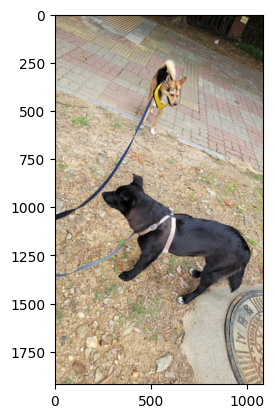

Caption:  개 사진
/content/val_image/IMG_0099122_dog(dog).jpg


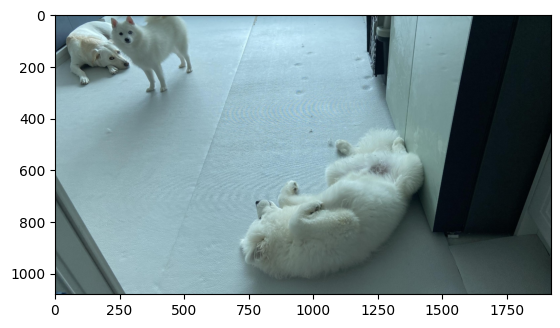

Caption:  개 은 개 중 사진 가장 왼쪽
/content/val_image/IMG_0045275_dog(dog).jpg


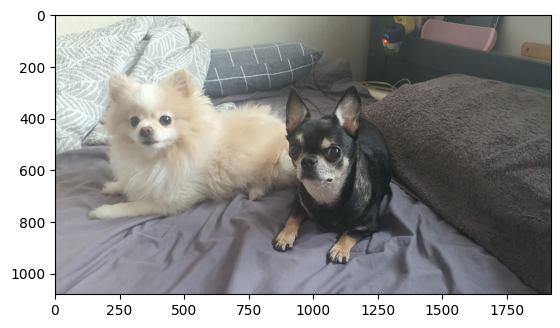

Caption:  개 사진
/content/val_image/IMG_0099126_dog(dog).jpg


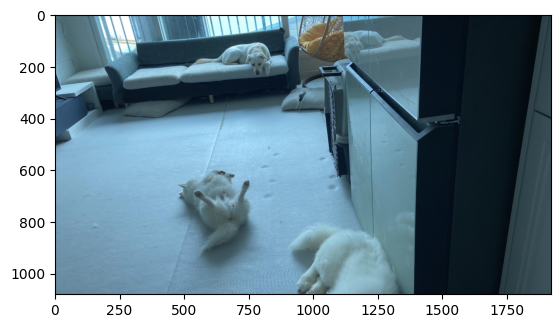

Caption:  소파 사진
/content/val_image/IMG_0242871_dog(dog).jpg


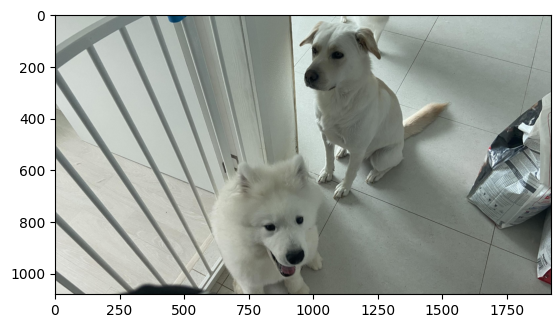

Caption:  개 은 개 중 사진 가장 왼쪽
/content/val_image/IMG_0228463_dog(dog).jpg


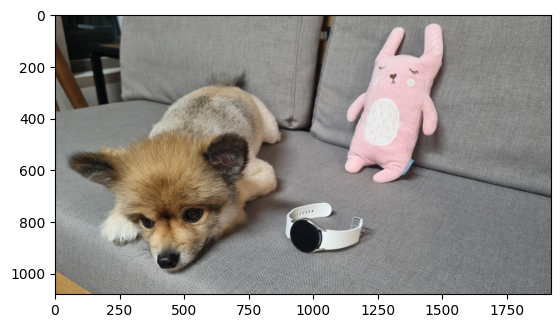

Caption:  인형 사진
/content/val_image/IMG_0245905_dog(dog).jpg


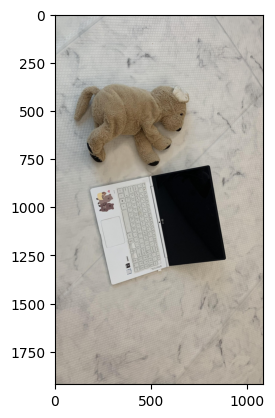

Caption:  책 은 책 중 사진 가장 왼쪽
/content/val_image/IMG_0154431_dog(dog).jpg


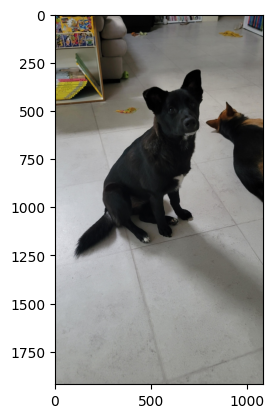

Caption:  개 사진
/content/val_image/IMG_0099128_dog(dog).jpg


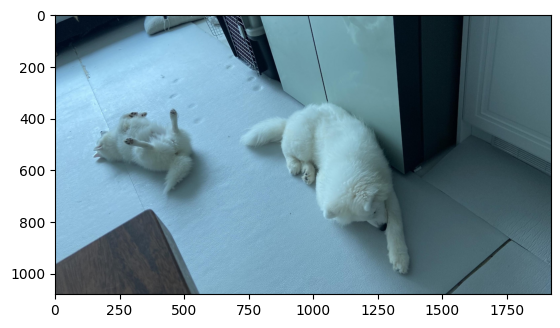

Caption:  인형 사진
/content/val_image/IMG_0196257_dog(dog).jpg


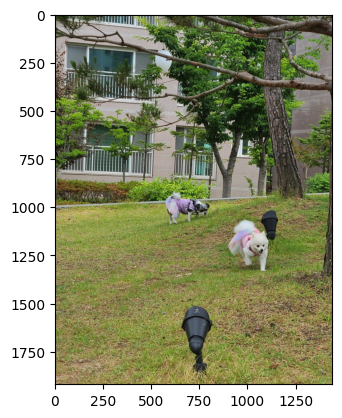

Caption:  개 은 개 중 사진 가장 왼쪽


In [87]:
# test data 캡셔닝 확인
import random

for i in range(10):
  z = random.randint(0,300)
  pic = list(encoding_val.keys())[z]
  image = encoding_val[pic].reshape((1,OUTPUT_DIM))
  print(os.path.join(root_captioning, pic))
  x = plt.imread(os.path.join(root_captioning, pic))
  plt.imshow(x)
  plt.show()
  print('Caption: ', generateCaption(image))